In [3]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
import pickle

#### Loading data after preprocessing

In [4]:
data_train  = pd.read_csv("../data/alt_maccsfp_after_preprocessing.csv")

#### Splitting data into training and test sets

In [5]:
y = data_train['ALT']
del data_train['ALT']
X = data_train.values
y = y.values

#### Configure the cross-validation procedure

In [7]:
cv_outer = KFold(n_splits=5, shuffle=True, random_state=234)
cv_inner = KFold(n_splits=5, shuffle=True, random_state=75579)

#### Helper functions for finding the best hyperparameters - we use dual cross-validation

In [8]:
def get_dual_cv_results(hyperparams_grid, model, cv_outer, cv_inner, x, y):
    cv_results = pd.DataFrame()

    for train_index, test_index in cv_outer.split(X):
        # split data
        x_train, x_test = x[train_index], [test_index]
        y_train, y_test = y[train_index], y[test_index]
        # define search
        search = GridSearchCV(model, hyperparams_grid, scoring='r2', cv=cv_inner,
                              return_train_score=True, verbose=1000)
        search_fit = search.fit(x_train, y_train)
        cv_result = pd.DataFrame(search_fit.cv_results_)
        cv_results = cv_results.append(cv_result, ignore_index=True)
    return cv_results


def group_dual_cv_results_data(cv_results):
    group_keys = [value for value in cv_results.columns.values if
                  value.startswith("param_") and 'random_state' not in value]
    groups = cv_results.groupby(by=group_keys)
    agg_arguments = {'mean_test_score': 'mean', 'std_test_score': 'mean',
                     'mean_train_score': 'mean', 'std_train_score': 'mean'}
    return groups.agg(agg_arguments)


def get_best_dual_cv_results(grouped_cv_results, key='mean_test_score'):
    return grouped_cv_results[key].max()


def get_best_hyperparameters(grouped_cv_results, key='mean_test_score'):
    return grouped_cv_results[key].idxmax()

#### In the following function the model is trained, saved and the results are stored

In [32]:
def calculate_model_results(model, cv_outer, x, y):
    results = pd.DataFrame(columns=['train_score', 'test_score', 'pred_train', 'pred_test'])

    for i, (train_index, test_index) in enumerate(cv_outer.split(x)):
        # split data
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model.fit(x_train, y_train)
        # save the model to disk
        model_name = str(model).split("(", 1)[0]
        filename = f"../models/finalized_{model_name}_model_{i}.pickle"
        pickle.dump(model, open(filename, 'wb'))
        y_pred_train = model.predict(x_train)
        train_score = model.score(x_train, y_train)
        y_pred_test = model.predict(x_test)
        test_score = model.score(x_test, y_test)
        results.loc[i] = [train_score, test_score, list(y_pred_train), list(y_pred_test)]
    results.to_csv(f"../results/{model_name}_results.csv", index=False)
    return results

def get_final_model_result(results):
    return round(results['test_score'].mean(), 3)

### LASSO 

In [10]:
hyperparams_grid_lasso = {'alpha': [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 10], 'random_state': [321321, 321]}
model_lasso = Lasso()

In [42]:
cv_results_lasso = get_dual_cv_results(hyperparams_grid_lasso, model_lasso, cv_outer, cv_inner, X, y)
cv_results_lasso

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] alpha=0.0001, random_state=321321 ...............................
[CV]  alpha=0.0001, random_state=321321, score=(train=0.809, test=0.061), total=   0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[CV] alpha=0.0001, random_state=321321 ...............................
[CV]  alpha=0.0001, random_state=321321, score=(train=0.921, test=-0.364), total=   0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[CV] alpha=0.0001, random_state=321321 ...............................
[CV]  alpha=0.0001, random_state=321321, score=(train=0.905, test=0.578), total=   0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[CV] alpha=0.0001, random_state=321321 ...............................
[CV]  alpha=0.0001, random_state=321321, score=(train=0.879, test=-0.

Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08946569500893942, tolerance: 0.0024602116125714587
Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.14075754583797462, tolerance: 0.0038718603246132733
Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.13920669177630596, tolerance: 0.002700179658294998
Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2770730751202328, tolerance: 0.0039534824031223995
Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.22615328133960722, tolerance: 0.0034140820291895502
Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08946569500893942, tolerance: 0.0024602116125714587
Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.14075754583797462,


[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.1s remaining:    0.0s
[CV] alpha=0.005, random_state=321321 ................................
[CV]  alpha=0.005, random_state=321321, score=(train=0.897, test=-0.425), total=   0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.1s remaining:    0.0s
[CV] alpha=0.005, random_state=321321 ................................
[CV]  alpha=0.005, random_state=321321, score=(train=0.883, test=0.376), total=   0.0s
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    0.1s remaining:    0.0s
[CV] alpha=0.005, random_state=321321 ................................
[CV]  alpha=0.005, random_state=321321, score=(train=0.859, test=-1.859), total=   0.0s
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    0.1s remaining:    0.0s
[CV] alpha=0.005, random_state=321321 ................................
[CV]  alpha=0.005, random_state=321321, score=(train=0.838, test=-0.394), total=   0.0s
[Parallel(n_jobs=1)]: Done  25 out of  25 | 

Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3350897232371812, tolerance: 0.004105531985926312
Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.37141490826812706, tolerance: 0.0031814302281822004
Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.10711626444099731, tolerance: 0.002646377576702048
Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.13280764803888978, tolerance: 0.003103959081678208
Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.23039693254823024, tolerance: 0.002868271824700862
Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.252799427457737, tolerance: 0.0030826464308876356
Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.37141490826812706, tole

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] alpha=0.0001, random_state=321321 ...............................
[CV]  alpha=0.0001, random_state=321321, score=(train=0.906, test=0.482), total=   0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[CV] alpha=0.0001, random_state=321321 ...............................
[CV]  alpha=0.0001, random_state=321321, score=(train=0.927, test=0.168), total=   0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[CV] alpha=0.0001, random_state=321321 ...............................
[CV]  alpha=0.0001, random_state=321321, score=(train=0.934, test=0.576), total=   0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[CV] alpha=0.0001, random_state=321321 ...............................
[CV]  alpha=0.0001, random_state=321321, score=(train=0.897, test=0.83

Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03130934563782106, tolerance: 0.002646377576702048
Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.023916186689084906, tolerance: 0.003103959081678208
Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01190012186681999, tolerance: 0.002868271824700862
Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011055996530033418, tolerance: 0.0030826464308876356
Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007836066066870817, tolerance: 0.0031814302281822004
Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03130934563782106, tolerance: 0.002646377576702048
Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02391618668908490


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.1s remaining:    0.0s
[CV] alpha=0.001, random_state=321321 ................................
[CV]  alpha=0.001, random_state=321321, score=(train=0.924, test=-0.065), total=   0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.1s remaining:    0.0s
[CV] alpha=0.001, random_state=321321 ................................
[CV]  alpha=0.001, random_state=321321, score=(train=0.933, test=0.564), total=   0.0s
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    0.1s remaining:    0.0s
[CV] alpha=0.001, random_state=321321 ................................
[CV]  alpha=0.001, random_state=321321, score=(train=0.896, test=0.771), total=   0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.1s remaining:    0.0s
[CV] alpha=0.001, random_state=321321 ................................
[CV]  alpha=0.001, random_state=321321, score=(train=0.898, test=0.766), total=   0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | el

[CV] alpha=0.5, random_state=321321 ..................................
[CV]  alpha=0.5, random_state=321321, score=(train=0.000, test=-0.010), total=   0.0s
[Parallel(n_jobs=1)]: Done  61 out of  61 | elapsed:    0.3s remaining:    0.0s
[CV] alpha=0.5, random_state=321321 ..................................
[CV]  alpha=0.5, random_state=321321, score=(train=0.000, test=-0.385), total=   0.0s
[Parallel(n_jobs=1)]: Done  62 out of  62 | elapsed:    0.3s remaining:    0.0s
[CV] alpha=0.5, random_state=321321 ..................................
[CV]  alpha=0.5, random_state=321321, score=(train=0.000, test=-0.082), total=   0.0s
[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.3s remaining:    0.0s
[CV] alpha=0.5, random_state=321321 ..................................
[CV]  alpha=0.5, random_state=321321, score=(train=0.000, test=-0.022), total=   0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.3s remaining:    0.0s
[CV] alpha=0.5, random_state=321321 ................

Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3003685342690545, tolerance: 0.0037400557524890675
Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.19433753208297633, tolerance: 0.002769920955647268
Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.17157887260452953, tolerance: 0.0031191830119624373
Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.21997390703735942, tolerance: 0.004151329235652973
Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.30428100312585205, tolerance: 0.0041628706916557795
Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5159890181239901, tolerance: 0.0031557935540557883
Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.19433753208297633, t


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[CV] alpha=0.001, random_state=321321 ................................
[CV]  alpha=0.001, random_state=321321, score=(train=0.839, test=0.832), total=   0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.0s remaining:    0.0s
[CV] alpha=0.001, random_state=321321 ................................
[CV]  alpha=0.001, random_state=321321, score=(train=0.938, test=-1.173), total=   0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.0s remaining:    0.0s
[CV] alpha=0.001, random_state=321321 ................................
[CV]  alpha=0.001, random_state=321321, score=(train=0.904, test=-0.816), total=   0.0s
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    0.0s remaining:    0.0s
[CV] alpha=0.001, random_state=321321 ................................
[CV]  alpha=0.001, random_state=321321, score=(train=0.896, test=-0.017), total=   0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | 

Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004522945937393885, tolerance: 0.0041628706916557795
Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.021652798292063125, tolerance: 0.0031557935540557883


[CV]  alpha=0.01, random_state=321321, score=(train=0.782, test=0.384), total=   0.0s
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    0.2s remaining:    0.0s
[CV] alpha=0.01, random_state=321 ....................................
[CV]  alpha=0.01, random_state=321, score=(train=0.761, test=0.641), total=   0.0s
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    0.2s remaining:    0.0s
[CV] alpha=0.01, random_state=321 ....................................
[CV]  alpha=0.01, random_state=321, score=(train=0.893, test=-0.363), total=   0.0s
[Parallel(n_jobs=1)]: Done  37 out of  37 | elapsed:    0.2s remaining:    0.0s
[CV] alpha=0.01, random_state=321 ....................................
[CV]  alpha=0.01, random_state=321, score=(train=0.865, test=-0.843), total=   0.0s
[Parallel(n_jobs=1)]: Done  38 out of  38 | elapsed:    0.2s remaining:    0.0s
[CV] alpha=0.01, random_state=321 ....................................
[CV]  alpha=0.01, random_state=321, score=(train=0.847, tes

Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6993008363983213, tolerance: 0.004167439915786809
Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.16327472846144064, tolerance: 0.003224673349735799
Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.18958367793096853, tolerance: 0.003698133886567862
Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.21501192835843774, tolerance: 0.004244983430373037
Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.36424414462575117, tolerance: 0.004059720673982403
Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6993008363983213, tolerance: 0.004167439915786809
Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.16327472846144064, toler

[CV]  alpha=0.0001, random_state=321, score=(train=0.873, test=0.182), total=   0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[CV] alpha=0.0001, random_state=321 ..................................
[CV]  alpha=0.0001, random_state=321, score=(train=0.921, test=0.407), total=   0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[CV] alpha=0.0001, random_state=321 ..................................
[CV]  alpha=0.0001, random_state=321, score=(train=0.894, test=-0.219), total=   0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[CV] alpha=0.0001, random_state=321 ..................................
[CV]  alpha=0.0001, random_state=321, score=(train=0.889, test=-1.674), total=   0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[CV] alpha=0.0001, random_state=321 ..................................
[CV]  alpha=0.0001, random_state=321, score=(train=0.8

Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.022220334094595007, tolerance: 0.003224673349735799
Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.015613485746599931, tolerance: 0.003698133886567862
Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02698439183143897, tolerance: 0.004059720673982403



[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.1s remaining:    0.0s
[CV] alpha=0.005, random_state=321321 ................................
[CV]  alpha=0.005, random_state=321321, score=(train=0.910, test=0.330), total=   0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.2s remaining:    0.0s
[CV] alpha=0.005, random_state=321321 ................................
[CV]  alpha=0.005, random_state=321321, score=(train=0.859, test=-0.060), total=   0.0s
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    0.2s remaining:    0.0s
[CV] alpha=0.005, random_state=321321 ................................
[CV]  alpha=0.005, random_state=321321, score=(train=0.871, test=-1.189), total=   0.0s
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    0.2s remaining:    0.0s
[CV] alpha=0.005, random_state=321321 ................................
[CV]  alpha=0.005, random_state=321321, score=(train=0.850, test=0.790), total=   0.0s
[Parallel(n_jobs=1)]: Done  25 out of  25 | e

[CV]  alpha=1, random_state=321, score=(train=0.000, test=-0.137), total=   0.0s
[Parallel(n_jobs=1)]: Done  78 out of  78 | elapsed:    0.3s remaining:    0.0s
[CV] alpha=1, random_state=321 .......................................
[CV]  alpha=1, random_state=321, score=(train=0.000, test=-0.331), total=   0.0s
[Parallel(n_jobs=1)]: Done  79 out of  79 | elapsed:    0.3s remaining:    0.0s
[CV] alpha=1, random_state=321 .......................................
[CV]  alpha=1, random_state=321, score=(train=0.000, test=-0.009), total=   0.0s
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    0.3s remaining:    0.0s
[CV] alpha=10, random_state=321321 ...................................
[CV]  alpha=10, random_state=321321, score=(train=0.000, test=-0.026), total=   0.0s
[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed:    0.3s remaining:    0.0s
[CV] alpha=10, random_state=321321 ...................................
[CV]  alpha=10, random_state=321321, score=(train=0.000, test=-0.022

Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7806681479499917, tolerance: 0.003538622325499927
Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4710698836117948, tolerance: 0.002959072150395512
Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3072600111637023, tolerance: 0.004105450037495854
Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5411156475568766, tolerance: 0.004541048096601215
Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2479565150369598, tolerance: 0.0035373767089277083
Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7806681479499917, tolerance: 0.003538622325499927
Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4710698836117948, tolerance

[CV]  alpha=0.001, random_state=321321, score=(train=0.829, test=0.703), total=   0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.0s remaining:    0.0s
[CV] alpha=0.001, random_state=321321 ................................
[CV]  alpha=0.001, random_state=321321, score=(train=0.870, test=0.767), total=   0.0s
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    0.1s remaining:    0.0s
[CV] alpha=0.001, random_state=321321 ................................
[CV]  alpha=0.001, random_state=321321, score=(train=0.893, test=-1.036), total=   0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.1s remaining:    0.0s
[CV] alpha=0.001, random_state=321321 ................................
[CV]  alpha=0.001, random_state=321321, score=(train=0.926, test=0.471), total=   0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.1s remaining:    0.0s
[CV] alpha=0.001, random_state=321 ...................................
[CV]  alpha=0.001, random_state=321, score=(tra

Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02068866089000654, tolerance: 0.004541048096601215
Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005308889231295577, tolerance: 0.0035373767089277083
Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02210267288885248, tolerance: 0.0035373767089277083
Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02210267288885248, tolerance: 0.0035373767089277083


[Parallel(n_jobs=1)]: Done  49 out of  49 | elapsed:    0.2s remaining:    0.0s
[CV] alpha=0.05, random_state=321 ....................................
[CV]  alpha=0.05, random_state=321, score=(train=0.441, test=0.278), total=   0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.2s remaining:    0.0s
[CV] alpha=0.1, random_state=321321 ..................................
[CV]  alpha=0.1, random_state=321321, score=(train=0.106, test=0.054), total=   0.0s
[Parallel(n_jobs=1)]: Done  51 out of  51 | elapsed:    0.2s remaining:    0.0s
[CV] alpha=0.1, random_state=321321 ..................................
[CV]  alpha=0.1, random_state=321321, score=(train=0.085, test=-0.007), total=   0.0s
[Parallel(n_jobs=1)]: Done  52 out of  52 | elapsed:    0.2s remaining:    0.0s
[CV] alpha=0.1, random_state=321321 ..................................
[CV]  alpha=0.1, random_state=321321, score=(train=0.123, test=0.148), total=   0.0s
[Parallel(n_jobs=1)]: Done  53 out of  53 | elapsed:    0

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha  \
0        0.009379      0.000495         0.000598        0.000489      0.0001   
1        0.009375      0.000798         0.000599        0.000489      0.0001   
2        0.006781      0.000399         0.000599        0.000489       0.001   
3        0.007380      0.000798         0.000000        0.000000       0.001   
4        0.003481      0.001516         0.000204        0.000409       0.005   
..            ...           ...              ...             ...         ...   
85       0.000599      0.000489         0.000200        0.000399         0.5   
86       0.000607      0.000496         0.000200        0.000399           1   
87       0.000601      0.000491         0.000199        0.000397           1   
88       0.000996      0.000026         0.000000        0.000000          10   
89       0.000598      0.000488         0.000785        0.000393          10   

   param_random_state                                     params  \
0              321321  {'alpha': 0.0001, 'random_state': 321321}   
1                 321     {'alpha': 0.0001, 'random_state': 321}   
2              321321   {'alpha': 0.001, 'random_state': 321321}   
3                 321      {'alpha': 0.001, 'random_state': 321}   
4              321321   {'alpha': 0.005, 'random_state': 321321}   
..                ...                                        ...   
85                321        {'alpha': 0.5, 'random_state': 321}   
86             321321       {'alpha': 1, 'random_state': 321321}   
87                321          {'alpha': 1, 'random_state': 321}   
88             321321      {'alpha': 10, 'random_state': 321321}   
89                321         {'alpha': 10, 'random_state': 321}   

    split0_test_score  split1_test_score  split2_test_score  ...  \
0            0.061248          -0.364031           0.578333  ...   
1            0.061248          -0.364031           0.578333  ...   
2           -0.224268          -0.252368           0.003696  ...   
3           -0.224268          -0.252368           0.003696  ...   
4           -0.014120          -0.424849           0.376372  ...   
..                ...                ...                ...  ...   
85          -0.027140          -0.064002          -0.043591  ...   
86          -0.027140          -0.064002          -0.043591  ...   
87          -0.027140          -0.064002          -0.043591  ...   
88          -0.027140          -0.064002          -0.043591  ...   
89          -0.027140          -0.064002          -0.043591  ...   

    mean_test_score  std_test_score  rank_test_score  split0_train_score  \
0          0.049424        0.318273                1            0.808889   
1          0.049424        0.318273                1            0.808889   
2         -0.224401        0.185980               13            0.808099   
3         -0.224401        0.185980               13            0.808099   
4         -0.463060        0.756415               17            0.794034   
..              ...             ...              ...                 ...   
85        -0.029862        0.022154               13            0.000000   
86        -0.029862        0.022154               13            0.000000   
87        -0.029862        0.022154               13            0.000000   
88        -0.029862        0.022154               13            0.000000   
89        -0.029862        0.022154               13            0.000000   

    split1_train_score  split2_train_score  split3_train_score  \
0             0.920893            0.904929            0.879074   
1             0.920893            0.904929            0.879074   
2             0.919747            0.903758            0.877864   
3             0.919747            0.903758            0.877864   
4             0.897461            0.882752            0.858727   
..                 ...                 ...                 ...   
85            0.000000            

In [43]:
grouped_cv_results_data_lasso = group_dual_cv_results_data(cv_results_lasso)
grouped_cv_results_data_lasso.sort_values('mean_test_score', ascending=False).iloc[:9]

mean_test_score  std_test_score  mean_train_score  \
param_alpha                                                      
0.0001              0.123199        0.516151          0.887636   
0.0500              0.073518        0.256965          0.455486   
0.0100              0.029256        0.533536          0.828397   
0.0050             -0.044299        0.643704          0.865206   
0.1000             -0.059529        0.149825          0.119132   
0.0010             -0.061789        0.590216          0.886284   
0.5000             -0.094310        0.088044          0.000000   
1.0000             -0.094310        0.088044          0.000000   
10.0000            -0.094310        0.088044          0.000000   

             std_train_score  
param_alpha                   
0.0001              0.028459  
0.0500              0.060452  
0.0100              0.032589  
0.0050              0.029733  
0.1000              0.053100  
0.0010              0.028558  
0.5000              0.000000  
1.0000              0.000000  
10.0000             0.000000

In [44]:
best_dual_cv_results_lasso = get_best_dual_cv_results(grouped_cv_results_data_lasso)
best_hyperparameter_lasso = get_best_hyperparameters(grouped_cv_results_data_lasso)
print("MEAN_TEST_SCORE: ",best_dual_cv_results_lasso)
print("BEST HYPERPARAMETERS: ", best_hyperparameter_lasso)

MEAN_TEST_SCORE:  0.12319874603406714
BEST HYPERPARAMETERS:  0.0001


In [11]:
lasso_model = Lasso(alpha=best_hyperparameter_lasso, random_state=6346)

In [12]:
lasso_results = calculate_model_results(lasso_model, cv_outer, X, y)
lasso_results

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3350897232371812, tolerance: 0.004105531985926312
  positive)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3003685342690545, tolerance: 0.0037400557524890675
  positive)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5042800347674214, tolerance: 0.004366101907166327
  positive)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iteratio

train_score  test_score                                         pred_train  \
0     0.872988    0.663963  [3.5582771823480335, 3.5582771823480335, 1.367...   
1     0.906552    0.247504  [3.571677977579052, 1.3611605532282773, 1.4246...   
2     0.878900    0.416589  [3.5879139531191466, 1.4258188998865813, 3.789...   
3     0.882060    0.726610  [3.571407528622753, 3.571407528622753, 1.35534...   
4     0.871289    0.753875  [3.5694931766743436, 3.5694931766743436, 1.356...   

                                           pred_test  
0  [3.9988188046676143, 3.557821318201789, 3.5833...  
1  [3.571677977579052, 3.7148542825733806, 3.2709...  
2  [3.5879139531191466, 1.3123471903766983, 3.460...  
3  [3.578575053983424, 3.668551556580291, 3.39013...  
4  [1.512542088856537, 3.5657866629831005, 3.6399...

In [33]:
lasso_result = get_final_model_result(lasso_results)
lasso_result

0.562

### Decision Tree Regressor

In [55]:
param_grid_dtr = {'max_depth': range(1, 11), 'min_samples_split': range(1, 30), 'random_state': [321321, 321]}

model_dtr = DecisionTreeRegressor()

In [56]:
cv_results_dtr = get_dual_cv_results(param_grid_dtr, model_dtr, cv_outer, cv_inner, X, y)
cv_results_dtr

Fitting 5 folds for each of 580 candidates, totalling 2900 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] max_depth=1, min_samples_split=1, random_state=321321 ...........
[CV]  max_depth=1, min_samples_split=1, random_state=321321, score=(train=nan, test=nan), total=   0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[CV] max_depth=1, min_samples_split=1, random_state=321321 ...........
[CV]  max_depth=1, min_samples_split=1, random_state=321321, score=(train=nan, test=nan), total=   0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[CV] max_depth=1, min_samples_split=1, random_state=321321 ...........
[CV]  max_depth=1, min_samples_split=1, random_state=321321, score=(train=nan, test=nan), total=   0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[CV] max_depth=1, min_samples_split=1, random_state=321321 ...........
[CV]  max_depth=1, 

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Valu

[CV]  max_depth=1, min_samples_split=11, random_state=321, score=(train=0.171, test=0.385), total=   0.0s
[Parallel(n_jobs=1)]: Done 110 out of 110 | elapsed:    0.1s remaining:    0.0s
[CV] max_depth=1, min_samples_split=12, random_state=321321 ..........
[CV]  max_depth=1, min_samples_split=12, random_state=321321, score=(train=0.262, test=0.097), total=   0.0s
[Parallel(n_jobs=1)]: Done 111 out of 111 | elapsed:    0.1s remaining:    0.0s
[CV] max_depth=1, min_samples_split=12, random_state=321321 ..........
[CV]  max_depth=1, min_samples_split=12, random_state=321321, score=(train=0.272, test=-0.981), total=   0.0s
[Parallel(n_jobs=1)]: Done 112 out of 112 | elapsed:    0.1s remaining:    0.0s
[CV] max_depth=1, min_samples_split=12, random_state=321321 ..........
[CV]  max_depth=1, min_samples_split=12, random_state=321321, score=(train=0.201, test=-0.076), total=   0.0s
[Parallel(n_jobs=1)]: Done 113 out of 113 | elapsed:    0.1s remaining:    0.0s
[CV] max_depth=1, min_samples_sp

[CV]  max_depth=1, min_samples_split=22, random_state=321, score=(train=0.201, test=-0.076), total=   0.0s
[Parallel(n_jobs=1)]: Done 218 out of 218 | elapsed:    0.3s remaining:    0.0s
[CV] max_depth=1, min_samples_split=22, random_state=321 .............
[CV]  max_depth=1, min_samples_split=22, random_state=321, score=(train=0.281, test=-1.682), total=   0.0s
[Parallel(n_jobs=1)]: Done 219 out of 219 | elapsed:    0.3s remaining:    0.0s
[CV] max_depth=1, min_samples_split=22, random_state=321 .............
[CV]  max_depth=1, min_samples_split=22, random_state=321, score=(train=0.171, test=0.385), total=   0.0s
[Parallel(n_jobs=1)]: Done 220 out of 220 | elapsed:    0.3s remaining:    0.0s
[CV] max_depth=1, min_samples_split=23, random_state=321321 ..........
[CV]  max_depth=1, min_samples_split=23, random_state=321321, score=(train=0.262, test=0.097), total=   0.0s
[Parallel(n_jobs=1)]: Done 221 out of 221 | elapsed:    0.3s remaining:    0.0s
[CV] max_depth=1, min_samples_split=23

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Valu


[Parallel(n_jobs=1)]: Done 332 out of 332 | elapsed:    0.5s remaining:    0.0s
[CV] max_depth=2, min_samples_split=5, random_state=321321 ...........
[CV]  max_depth=2, min_samples_split=5, random_state=321321, score=(train=0.394, test=0.322), total=   0.0s
[Parallel(n_jobs=1)]: Done 333 out of 333 | elapsed:    0.5s remaining:    0.0s
[CV] max_depth=2, min_samples_split=5, random_state=321321 ...........
[CV]  max_depth=2, min_samples_split=5, random_state=321321, score=(train=0.720, test=-0.159), total=   0.0s
[Parallel(n_jobs=1)]: Done 334 out of 334 | elapsed:    0.5s remaining:    0.0s
[CV] max_depth=2, min_samples_split=5, random_state=321321 ...........
[CV]  max_depth=2, min_samples_split=5, random_state=321321, score=(train=0.696, test=-0.349), total=   0.0s
[Parallel(n_jobs=1)]: Done 335 out of 335 | elapsed:    0.5s remaining:    0.0s
[CV] max_depth=2, min_samples_split=5, random_state=321 ..............
[CV]  max_depth=2, min_samples_split=5, random_state=321, score=(trai

[CV]  max_depth=2, min_samples_split=15, random_state=321321, score=(train=0.360, test=0.087), total=   0.0s
[Parallel(n_jobs=1)]: Done 435 out of 435 | elapsed:    0.6s remaining:    0.0s
[CV] max_depth=2, min_samples_split=15, random_state=321 .............
[CV]  max_depth=2, min_samples_split=15, random_state=321, score=(train=0.323, test=0.154), total=   0.0s
[Parallel(n_jobs=1)]: Done 436 out of 436 | elapsed:    0.7s remaining:    0.0s
[CV] max_depth=2, min_samples_split=15, random_state=321 .............
[CV]  max_depth=2, min_samples_split=15, random_state=321, score=(train=0.394, test=-0.810), total=   0.0s
[Parallel(n_jobs=1)]: Done 437 out of 437 | elapsed:    0.7s remaining:    0.0s
[CV] max_depth=2, min_samples_split=15, random_state=321 .............
[CV]  max_depth=2, min_samples_split=15, random_state=321, score=(train=0.295, test=0.264), total=   0.0s
[Parallel(n_jobs=1)]: Done 438 out of 438 | elapsed:    0.7s remaining:    0.0s
[CV] max_depth=2, min_samples_split=15,

[CV]  max_depth=2, min_samples_split=26, random_state=321, score=(train=0.394, test=-0.810), total=   0.0s
[Parallel(n_jobs=1)]: Done 547 out of 547 | elapsed:    0.8s remaining:    0.0s
[CV] max_depth=2, min_samples_split=26, random_state=321 .............
[CV]  max_depth=2, min_samples_split=26, random_state=321, score=(train=0.295, test=0.264), total=   0.0s
[Parallel(n_jobs=1)]: Done 548 out of 548 | elapsed:    0.8s remaining:    0.0s
[CV] max_depth=2, min_samples_split=26, random_state=321 .............
[CV]  max_depth=2, min_samples_split=26, random_state=321, score=(train=0.401, test=-1.328), total=   0.0s
[Parallel(n_jobs=1)]: Done 549 out of 549 | elapsed:    0.8s remaining:    0.0s
[CV] max_depth=2, min_samples_split=26, random_state=321 .............
[CV]  max_depth=2, min_samples_split=26, random_state=321, score=(train=0.360, test=0.087), total=   0.0s
[Parallel(n_jobs=1)]: Done 550 out of 550 | elapsed:    0.8s remaining:    0.0s
[CV] max_depth=2, min_samples_split=27, r

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Valu


[Parallel(n_jobs=1)]: Done 648 out of 648 | elapsed:    1.0s remaining:    0.0s
[CV] max_depth=3, min_samples_split=7, random_state=321 ..............
[CV]  max_depth=3, min_samples_split=7, random_state=321, score=(train=0.744, test=-0.036), total=   0.0s
[Parallel(n_jobs=1)]: Done 649 out of 649 | elapsed:    1.0s remaining:    0.0s
[CV] max_depth=3, min_samples_split=7, random_state=321 ..............
[CV]  max_depth=3, min_samples_split=7, random_state=321, score=(train=0.749, test=0.581), total=   0.0s
[Parallel(n_jobs=1)]: Done 650 out of 650 | elapsed:    1.0s remaining:    0.0s
[CV] max_depth=3, min_samples_split=8, random_state=321321 ...........
[CV]  max_depth=3, min_samples_split=8, random_state=321321, score=(train=0.755, test=0.123), total=   0.0s
[Parallel(n_jobs=1)]: Done 651 out of 651 | elapsed:    1.0s remaining:    0.0s
[CV] max_depth=3, min_samples_split=8, random_state=321321 ...........
[CV]  max_depth=3, min_samples_split=8, random_state=321321, score=(train=0.

[CV]  max_depth=3, min_samples_split=18, random_state=321321, score=(train=0.390, test=0.134), total=   0.0s
[Parallel(n_jobs=1)]: Done 755 out of 755 | elapsed:    1.2s remaining:    0.0s
[CV] max_depth=3, min_samples_split=18, random_state=321 .............
[CV]  max_depth=3, min_samples_split=18, random_state=321, score=(train=0.380, test=0.196), total=   0.0s
[Parallel(n_jobs=1)]: Done 756 out of 756 | elapsed:    1.2s remaining:    0.0s
[CV] max_depth=3, min_samples_split=18, random_state=321 .............
[CV]  max_depth=3, min_samples_split=18, random_state=321, score=(train=0.440, test=-1.045), total=   0.0s
[Parallel(n_jobs=1)]: Done 757 out of 757 | elapsed:    1.2s remaining:    0.0s
[CV] max_depth=3, min_samples_split=18, random_state=321 .............
[CV]  max_depth=3, min_samples_split=18, random_state=321, score=(train=0.322, test=0.306), total=   0.0s
[Parallel(n_jobs=1)]: Done 758 out of 758 | elapsed:    1.2s remaining:    0.0s
[CV] max_depth=3, min_samples_split=18,

[CV]  max_depth=3, min_samples_split=29, random_state=321321, score=(train=0.322, test=0.306), total=   0.0s
[Parallel(n_jobs=1)]: Done 863 out of 863 | elapsed:    1.4s remaining:    0.0s
[CV] max_depth=3, min_samples_split=29, random_state=321321 ..........
[CV]  max_depth=3, min_samples_split=29, random_state=321321, score=(train=0.426, test=-1.205), total=   0.0s
[Parallel(n_jobs=1)]: Done 864 out of 864 | elapsed:    1.4s remaining:    0.0s
[CV] max_depth=3, min_samples_split=29, random_state=321321 ..........
[CV]  max_depth=3, min_samples_split=29, random_state=321321, score=(train=0.390, test=0.134), total=   0.0s
[Parallel(n_jobs=1)]: Done 865 out of 865 | elapsed:    1.4s remaining:    0.0s
[CV] max_depth=3, min_samples_split=29, random_state=321 .............
[CV]  max_depth=3, min_samples_split=29, random_state=321, score=(train=0.349, test=0.139), total=   0.0s
[Parallel(n_jobs=1)]: Done 866 out of 866 | elapsed:    1.4s remaining:    0.0s
[CV] max_depth=3, min_samples_spl

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Valu

[CV]  max_depth=4, min_samples_split=11, random_state=321321, score=(train=0.452, test=-1.170), total=   0.0s
[Parallel(n_jobs=1)]: Done 974 out of 974 | elapsed:    1.6s remaining:    0.0s
[CV] max_depth=4, min_samples_split=11, random_state=321321 ..........
[CV]  max_depth=4, min_samples_split=11, random_state=321321, score=(train=0.424, test=0.104), total=   0.0s
[Parallel(n_jobs=1)]: Done 975 out of 975 | elapsed:    1.6s remaining:    0.0s
[CV] max_depth=4, min_samples_split=11, random_state=321 .............
[CV]  max_depth=4, min_samples_split=11, random_state=321, score=(train=0.402, test=0.200), total=   0.0s
[Parallel(n_jobs=1)]: Done 976 out of 976 | elapsed:    1.6s remaining:    0.0s
[CV] max_depth=4, min_samples_split=11, random_state=321 .............
[CV]  max_depth=4, min_samples_split=11, random_state=321, score=(train=0.468, test=-1.358), total=   0.0s
[Parallel(n_jobs=1)]: Done 977 out of 977 | elapsed:    1.6s remaining:    0.0s
[CV] max_depth=4, min_samples_split

[CV]  max_depth=4, min_samples_split=22, random_state=321321, score=(train=0.431, test=-1.178), total=   0.0s
[CV] max_depth=4, min_samples_split=22, random_state=321321 ..........
[CV]  max_depth=4, min_samples_split=22, random_state=321321, score=(train=0.409, test=0.112), total=   0.0s
[CV] max_depth=4, min_samples_split=22, random_state=321 .............
[CV]  max_depth=4, min_samples_split=22, random_state=321, score=(train=0.366, test=0.145), total=   0.0s
[CV] max_depth=4, min_samples_split=22, random_state=321 .............
[CV]  max_depth=4, min_samples_split=22, random_state=321, score=(train=0.457, test=-1.120), total=   0.0s
[CV] max_depth=4, min_samples_split=22, random_state=321 .............
[CV]  max_depth=4, min_samples_split=22, random_state=321, score=(train=0.338, test=0.314), total=   0.0s
[CV] max_depth=4, min_samples_split=22, random_state=321 .............
[CV]  max_depth=4, min_samples_split=22, random_state=321, score=(train=0.431, test=-1.012), total=   0.0s


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Valu

[CV]  max_depth=5, min_samples_split=5, random_state=321321, score=(train=0.832, test=0.682), total=   0.0s
[CV] max_depth=5, min_samples_split=5, random_state=321321 ...........
[CV]  max_depth=5, min_samples_split=5, random_state=321321, score=(train=0.839, test=0.279), total=   0.0s
[CV] max_depth=5, min_samples_split=5, random_state=321321 ...........
[CV]  max_depth=5, min_samples_split=5, random_state=321321, score=(train=0.802, test=0.597), total=   0.0s
[CV] max_depth=5, min_samples_split=5, random_state=321 ..............
[CV]  max_depth=5, min_samples_split=5, random_state=321, score=(train=0.798, test=0.537), total=   0.0s
[CV] max_depth=5, min_samples_split=5, random_state=321 ..............
[CV]  max_depth=5, min_samples_split=5, random_state=321, score=(train=0.890, test=-0.952), total=   0.0s
[CV] max_depth=5, min_samples_split=5, random_state=321 ..............
[CV]  max_depth=5, min_samples_split=5, random_state=321, score=(train=0.832, test=0.682), total=   0.0s
[CV] 

[CV]  max_depth=5, min_samples_split=16, random_state=321321, score=(train=0.401, test=0.218), total=   0.0s
[CV] max_depth=5, min_samples_split=16, random_state=321321 ..........
[CV]  max_depth=5, min_samples_split=16, random_state=321321, score=(train=0.472, test=-1.123), total=   0.0s
[CV] max_depth=5, min_samples_split=16, random_state=321321 ..........
[CV]  max_depth=5, min_samples_split=16, random_state=321321, score=(train=0.345, test=0.292), total=   0.0s
[CV] max_depth=5, min_samples_split=16, random_state=321321 ..........
[CV]  max_depth=5, min_samples_split=16, random_state=321321, score=(train=0.455, test=-1.068), total=   0.0s
[CV] max_depth=5, min_samples_split=16, random_state=321321 ..........
[CV]  max_depth=5, min_samples_split=16, random_state=321321, score=(train=0.428, test=0.143), total=   0.0s
[CV] max_depth=5, min_samples_split=16, random_state=321 .............
[CV]  max_depth=5, min_samples_split=16, random_state=321, score=(train=0.401, test=0.218), total=

[CV]  max_depth=5, min_samples_split=27, random_state=321, score=(train=0.457, test=-1.120), total=   0.0s
[CV] max_depth=5, min_samples_split=27, random_state=321 .............
[CV]  max_depth=5, min_samples_split=27, random_state=321, score=(train=0.345, test=0.292), total=   0.0s
[CV] max_depth=5, min_samples_split=27, random_state=321 .............
[CV]  max_depth=5, min_samples_split=27, random_state=321, score=(train=0.431, test=-1.012), total=   0.0s
[CV] max_depth=5, min_samples_split=27, random_state=321 .............
[CV]  max_depth=5, min_samples_split=27, random_state=321, score=(train=0.409, test=0.112), total=   0.0s
[CV] max_depth=5, min_samples_split=28, random_state=321321 ..........
[CV]  max_depth=5, min_samples_split=28, random_state=321321, score=(train=0.370, test=0.161), total=   0.0s
[CV] max_depth=5, min_samples_split=28, random_state=321321 ..........
[CV]  max_depth=5, min_samples_split=28, random_state=321321, score=(train=0.457, test=-1.120), total=   0.0s


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Valu

[CV]  max_depth=6, min_samples_split=8, random_state=321, score=(train=0.787, test=0.125), total=   0.0s
[CV] max_depth=6, min_samples_split=8, random_state=321 ..............
[CV]  max_depth=6, min_samples_split=8, random_state=321, score=(train=0.822, test=-0.398), total=   0.0s
[CV] max_depth=6, min_samples_split=8, random_state=321 ..............
[CV]  max_depth=6, min_samples_split=8, random_state=321, score=(train=0.357, test=0.279), total=   0.0s
[CV] max_depth=6, min_samples_split=8, random_state=321 ..............
[CV]  max_depth=6, min_samples_split=8, random_state=321, score=(train=0.781, test=0.274), total=   0.0s
[CV] max_depth=6, min_samples_split=8, random_state=321 ..............
[CV]  max_depth=6, min_samples_split=8, random_state=321, score=(train=0.785, test=-0.306), total=   0.0s
[CV] max_depth=6, min_samples_split=9, random_state=321321 ...........
[CV]  max_depth=6, min_samples_split=9, random_state=321321, score=(train=0.412, test=0.198), total=   0.0s
[CV] max_d

[CV]  max_depth=6, min_samples_split=17, random_state=321, score=(train=0.405, test=0.201), total=   0.0s
[CV] max_depth=6, min_samples_split=17, random_state=321 .............
[CV]  max_depth=6, min_samples_split=17, random_state=321, score=(train=0.472, test=-1.122), total=   0.0s
[CV] max_depth=6, min_samples_split=17, random_state=321 .............
[CV]  max_depth=6, min_samples_split=17, random_state=321, score=(train=0.352, test=0.290), total=   0.0s
[CV] max_depth=6, min_samples_split=17, random_state=321 .............
[CV]  max_depth=6, min_samples_split=17, random_state=321, score=(train=0.455, test=-0.944), total=   0.0s
[CV] max_depth=6, min_samples_split=17, random_state=321 .............
[CV]  max_depth=6, min_samples_split=17, random_state=321, score=(train=0.420, test=0.142), total=   0.0s
[CV] max_depth=6, min_samples_split=18, random_state=321321 ..........
[CV]  max_depth=6, min_samples_split=18, random_state=321321, score=(train=0.405, test=0.201), total=   0.0s
[CV]

[CV]  max_depth=6, min_samples_split=28, random_state=321321, score=(train=0.409, test=0.112), total=   0.0s
[CV] max_depth=6, min_samples_split=28, random_state=321 .............
[CV]  max_depth=6, min_samples_split=28, random_state=321, score=(train=0.370, test=0.161), total=   0.0s
[CV] max_depth=6, min_samples_split=28, random_state=321 .............
[CV]  max_depth=6, min_samples_split=28, random_state=321, score=(train=0.457, test=-1.120), total=   0.0s
[CV] max_depth=6, min_samples_split=28, random_state=321 .............
[CV]  max_depth=6, min_samples_split=28, random_state=321, score=(train=0.345, test=0.292), total=   0.0s
[CV] max_depth=6, min_samples_split=28, random_state=321 .............
[CV]  max_depth=6, min_samples_split=28, random_state=321, score=(train=0.431, test=-1.012), total=   0.0s
[CV] max_depth=6, min_samples_split=28, random_state=321 .............
[CV]  max_depth=6, min_samples_split=28, random_state=321, score=(train=0.409, test=0.112), total=   0.0s
[CV]

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Valu

[CV]  max_depth=7, min_samples_split=10, random_state=321, score=(train=0.362, test=0.304), total=   0.0s
[CV] max_depth=7, min_samples_split=10, random_state=321 .............
[CV]  max_depth=7, min_samples_split=10, random_state=321, score=(train=0.779, test=0.286), total=   0.0s
[CV] max_depth=7, min_samples_split=10, random_state=321 .............
[CV]  max_depth=7, min_samples_split=10, random_state=321, score=(train=0.785, test=-0.306), total=   0.0s
[CV] max_depth=7, min_samples_split=11, random_state=321321 ..........
[CV]  max_depth=7, min_samples_split=11, random_state=321321, score=(train=0.415, test=0.209), total=   0.0s
[CV] max_depth=7, min_samples_split=11, random_state=321321 ..........
[CV]  max_depth=7, min_samples_split=11, random_state=321321, score=(train=0.492, test=-1.414), total=   0.0s
[CV] max_depth=7, min_samples_split=11, random_state=321321 ..........
[CV]  max_depth=7, min_samples_split=11, random_state=321321, score=(train=0.362, test=0.304), total=   0.0

[CV]  max_depth=7, min_samples_split=21, random_state=321, score=(train=0.356, test=0.314), total=   0.0s
[CV] max_depth=7, min_samples_split=21, random_state=321 .............
[CV]  max_depth=7, min_samples_split=21, random_state=321, score=(train=0.434, test=-0.953), total=   0.0s
[CV] max_depth=7, min_samples_split=21, random_state=321 .............
[CV]  max_depth=7, min_samples_split=21, random_state=321, score=(train=0.409, test=0.112), total=   0.0s
[CV] max_depth=7, min_samples_split=22, random_state=321321 ..........
[CV]  max_depth=7, min_samples_split=22, random_state=321321, score=(train=0.375, test=0.144), total=   0.0s
[CV] max_depth=7, min_samples_split=22, random_state=321321 ..........
[CV]  max_depth=7, min_samples_split=22, random_state=321321, score=(train=0.472, test=-1.123), total=   0.0s
[CV] max_depth=7, min_samples_split=22, random_state=321321 ..........
[CV]  max_depth=7, min_samples_split=22, random_state=321321, score=(train=0.356, test=0.314), total=   0.0

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Valu

[CV]  max_depth=8, min_samples_split=4, random_state=321321, score=(train=0.846, test=0.413), total=   0.0s
[CV] max_depth=8, min_samples_split=4, random_state=321321 ...........
[CV]  max_depth=8, min_samples_split=4, random_state=321321, score=(train=0.856, test=0.377), total=   0.0s
[CV] max_depth=8, min_samples_split=4, random_state=321 ..............
[CV]  max_depth=8, min_samples_split=4, random_state=321, score=(train=0.807, test=0.524), total=   0.0s
[CV] max_depth=8, min_samples_split=4, random_state=321 ..............
[CV]  max_depth=8, min_samples_split=4, random_state=321, score=(train=0.914, test=-0.953), total=   0.0s
[CV] max_depth=8, min_samples_split=4, random_state=321 ..............
[CV]  max_depth=8, min_samples_split=4, random_state=321, score=(train=0.862, test=0.720), total=   0.0s
[CV] max_depth=8, min_samples_split=4, random_state=321 ..............
[CV]  max_depth=8, min_samples_split=4, random_state=321, score=(train=0.846, test=0.376), total=   0.0s
[CV] max

[CV]  max_depth=8, min_samples_split=15, random_state=321321, score=(train=0.408, test=0.212), total=   0.0s
[CV] max_depth=8, min_samples_split=15, random_state=321321 ..........
[CV]  max_depth=8, min_samples_split=15, random_state=321321, score=(train=0.472, test=-1.122), total=   0.0s
[CV] max_depth=8, min_samples_split=15, random_state=321321 ..........
[CV]  max_depth=8, min_samples_split=15, random_state=321321, score=(train=0.359, test=0.314), total=   0.0s
[CV] max_depth=8, min_samples_split=15, random_state=321321 ..........
[CV]  max_depth=8, min_samples_split=15, random_state=321321, score=(train=0.456, test=-1.099), total=   0.0s
[CV] max_depth=8, min_samples_split=15, random_state=321321 ..........
[CV]  max_depth=8, min_samples_split=15, random_state=321321, score=(train=0.446, test=0.130), total=   0.0s
[CV] max_depth=8, min_samples_split=15, random_state=321 .............
[CV]  max_depth=8, min_samples_split=15, random_state=321, score=(train=0.408, test=0.160), total=

[CV] max_depth=8, min_samples_split=26, random_state=321 .............
[CV]  max_depth=8, min_samples_split=26, random_state=321, score=(train=0.370, test=0.161), total=   0.0s
[CV] max_depth=8, min_samples_split=26, random_state=321 .............
[CV]  max_depth=8, min_samples_split=26, random_state=321, score=(train=0.457, test=-1.120), total=   0.0s
[CV] max_depth=8, min_samples_split=26, random_state=321 .............
[CV]  max_depth=8, min_samples_split=26, random_state=321, score=(train=0.356, test=0.314), total=   0.0s
[CV] max_depth=8, min_samples_split=26, random_state=321 .............
[CV]  max_depth=8, min_samples_split=26, random_state=321, score=(train=0.431, test=-1.012), total=   0.0s
[CV] max_depth=8, min_samples_split=26, random_state=321 .............
[CV]  max_depth=8, min_samples_split=26, random_state=321, score=(train=0.409, test=0.112), total=   0.0s
[CV] max_depth=8, min_samples_split=27, random_state=321321 ..........
[CV]  max_depth=8, min_samples_split=27, r

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Valu

[CV]  max_depth=9, min_samples_split=8, random_state=321, score=(train=0.782, test=0.254), total=   0.0s
[CV] max_depth=9, min_samples_split=8, random_state=321 ..............
[CV]  max_depth=9, min_samples_split=8, random_state=321, score=(train=0.788, test=-0.306), total=   0.0s
[CV] max_depth=9, min_samples_split=9, random_state=321321 ...........
[CV]  max_depth=9, min_samples_split=9, random_state=321321, score=(train=0.415, test=0.209), total=   0.0s
[CV] max_depth=9, min_samples_split=9, random_state=321321 ...........
[CV]  max_depth=9, min_samples_split=9, random_state=321321, score=(train=0.492, test=-1.414), total=   0.0s
[CV] max_depth=9, min_samples_split=9, random_state=321321 ...........
[CV]  max_depth=9, min_samples_split=9, random_state=321321, score=(train=0.365, test=0.301), total=   0.0s
[CV] max_depth=9, min_samples_split=9, random_state=321321 ...........
[CV]  max_depth=9, min_samples_split=9, random_state=321321, score=(train=0.779, test=0.275), total=   0.0s
[

[CV]  max_depth=9, min_samples_split=19, random_state=321, score=(train=0.434, test=-0.953), total=   0.0s
[CV] max_depth=9, min_samples_split=19, random_state=321 .............
[CV]  max_depth=9, min_samples_split=19, random_state=321, score=(train=0.409, test=0.112), total=   0.0s
[CV] max_depth=9, min_samples_split=20, random_state=321321 ..........
[CV]  max_depth=9, min_samples_split=20, random_state=321321, score=(train=0.378, test=0.155), total=   0.0s
[CV] max_depth=9, min_samples_split=20, random_state=321321 ..........
[CV]  max_depth=9, min_samples_split=20, random_state=321321, score=(train=0.472, test=-1.123), total=   0.0s
[CV] max_depth=9, min_samples_split=20, random_state=321321 ..........
[CV]  max_depth=9, min_samples_split=20, random_state=321321, score=(train=0.359, test=0.311), total=   0.0s
[CV] max_depth=9, min_samples_split=20, random_state=321321 ..........
[CV]  max_depth=9, min_samples_split=20, random_state=321321, score=(train=0.434, test=-1.242), total=  

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Valu

[CV]  max_depth=10, min_samples_split=2, random_state=321, score=(train=0.809, test=0.532), total=   0.0s
[CV] max_depth=10, min_samples_split=2, random_state=321 .............
[CV]  max_depth=10, min_samples_split=2, random_state=321, score=(train=0.921, test=-0.981), total=   0.0s
[CV] max_depth=10, min_samples_split=2, random_state=321 .............
[CV]  max_depth=10, min_samples_split=2, random_state=321, score=(train=0.905, test=0.713), total=   0.0s
[CV] max_depth=10, min_samples_split=2, random_state=321 .............
[CV]  max_depth=10, min_samples_split=2, random_state=321, score=(train=0.879, test=0.366), total=   0.0s
[CV] max_depth=10, min_samples_split=2, random_state=321 .............
[CV]  max_depth=10, min_samples_split=2, random_state=321, score=(train=0.858, test=-0.400), total=   0.0s
[CV] max_depth=10, min_samples_split=3, random_state=321321 ..........
[CV]  max_depth=10, min_samples_split=3, random_state=321321, score=(train=0.809, test=0.535), total=   0.0s
[CV]

[CV]  max_depth=10, min_samples_split=12, random_state=321, score=(train=0.447, test=0.118), total=   0.0s
[CV] max_depth=10, min_samples_split=13, random_state=321321 .........
[CV]  max_depth=10, min_samples_split=13, random_state=321321, score=(train=0.408, test=0.212), total=   0.0s
[CV] max_depth=10, min_samples_split=13, random_state=321321 .........
[CV]  max_depth=10, min_samples_split=13, random_state=321321, score=(train=0.492, test=-1.414), total=   0.0s
[CV] max_depth=10, min_samples_split=13, random_state=321321 .........
[CV]  max_depth=10, min_samples_split=13, random_state=321321, score=(train=0.365, test=0.301), total=   0.0s
[CV] max_depth=10, min_samples_split=13, random_state=321321 .........
[CV]  max_depth=10, min_samples_split=13, random_state=321321, score=(train=0.456, test=-1.085), total=   0.0s
[CV] max_depth=10, min_samples_split=13, random_state=321321 .........
[CV]  max_depth=10, min_samples_split=13, random_state=321321, score=(train=0.447, test=0.118), 

[CV]  max_depth=10, min_samples_split=24, random_state=321321, score=(train=0.457, test=-1.120), total=   0.0s
[CV] max_depth=10, min_samples_split=24, random_state=321321 .........
[CV]  max_depth=10, min_samples_split=24, random_state=321321, score=(train=0.359, test=0.314), total=   0.0s
[CV] max_depth=10, min_samples_split=24, random_state=321321 .........
[CV]  max_depth=10, min_samples_split=24, random_state=321321, score=(train=0.431, test=-1.178), total=   0.0s
[CV] max_depth=10, min_samples_split=24, random_state=321321 .........
[CV]  max_depth=10, min_samples_split=24, random_state=321321, score=(train=0.409, test=0.112), total=   0.0s
[CV] max_depth=10, min_samples_split=24, random_state=321 ............
[CV]  max_depth=10, min_samples_split=24, random_state=321, score=(train=0.375, test=0.144), total=   0.0s
[CV] max_depth=10, min_samples_split=24, random_state=321 ............
[CV]  max_depth=10, min_samples_split=24, random_state=321, score=(train=0.457, test=-1.120), to

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Valu

[CV]  max_depth=1, min_samples_split=6, random_state=321321, score=(train=0.301, test=-1.080), total=   0.0s
[Parallel(n_jobs=1)]: Done  51 out of  51 | elapsed:    0.0s remaining:    0.0s
[CV] max_depth=1, min_samples_split=6, random_state=321321 ...........
[CV]  max_depth=1, min_samples_split=6, random_state=321321, score=(train=0.229, test=-0.371), total=   0.0s
[Parallel(n_jobs=1)]: Done  52 out of  52 | elapsed:    0.0s remaining:    0.0s
[CV] max_depth=1, min_samples_split=6, random_state=321321 ...........
[CV]  max_depth=1, min_samples_split=6, random_state=321321, score=(train=0.231, test=-0.034), total=   0.0s
[Parallel(n_jobs=1)]: Done  53 out of  53 | elapsed:    0.0s remaining:    0.0s
[CV] max_depth=1, min_samples_split=6, random_state=321321 ...........
[CV]  max_depth=1, min_samples_split=6, random_state=321321, score=(train=0.254, test=-0.004), total=   0.0s
[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:    0.0s remaining:    0.0s
[CV] max_depth=1, min_samples_s

[CV]  max_depth=1, min_samples_split=17, random_state=321321, score=(train=0.301, test=-1.080), total=   0.0s
[Parallel(n_jobs=1)]: Done 161 out of 161 | elapsed:    0.2s remaining:    0.0s
[CV] max_depth=1, min_samples_split=17, random_state=321321 ..........
[CV]  max_depth=1, min_samples_split=17, random_state=321321, score=(train=0.229, test=-0.371), total=   0.0s
[Parallel(n_jobs=1)]: Done 162 out of 162 | elapsed:    0.2s remaining:    0.0s
[CV] max_depth=1, min_samples_split=17, random_state=321321 ..........
[CV]  max_depth=1, min_samples_split=17, random_state=321321, score=(train=0.231, test=-0.034), total=   0.0s
[Parallel(n_jobs=1)]: Done 163 out of 163 | elapsed:    0.2s remaining:    0.0s
[CV] max_depth=1, min_samples_split=17, random_state=321321 ..........
[CV]  max_depth=1, min_samples_split=17, random_state=321321, score=(train=0.254, test=-0.004), total=   0.0s
[Parallel(n_jobs=1)]: Done 164 out of 164 | elapsed:    0.2s remaining:    0.0s
[CV] max_depth=1, min_sampl

[CV] max_depth=1, min_samples_split=28, random_state=321321 ..........
[CV]  max_depth=1, min_samples_split=28, random_state=321321, score=(train=0.231, test=-0.034), total=   0.0s
[Parallel(n_jobs=1)]: Done 273 out of 273 | elapsed:    0.4s remaining:    0.0s
[CV] max_depth=1, min_samples_split=28, random_state=321321 ..........
[CV]  max_depth=1, min_samples_split=28, random_state=321321, score=(train=0.254, test=-0.004), total=   0.0s
[Parallel(n_jobs=1)]: Done 274 out of 274 | elapsed:    0.4s remaining:    0.0s
[CV] max_depth=1, min_samples_split=28, random_state=321321 ..........
[CV]  max_depth=1, min_samples_split=28, random_state=321321, score=(train=0.233, test=-0.136), total=   0.0s
[Parallel(n_jobs=1)]: Done 275 out of 275 | elapsed:    0.4s remaining:    0.0s
[CV] max_depth=1, min_samples_split=28, random_state=321 .............
[CV]  max_depth=1, min_samples_split=28, random_state=321, score=(train=0.301, test=-1.080), total=   0.0s
[Parallel(n_jobs=1)]: Done 276 out of 2

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Valu

[CV]  max_depth=2, min_samples_split=10, random_state=321, score=(train=0.359, test=0.029), total=   0.0s
[Parallel(n_jobs=1)]: Done 387 out of 387 | elapsed:    0.5s remaining:    0.0s
[CV] max_depth=2, min_samples_split=10, random_state=321 .............
[CV]  max_depth=2, min_samples_split=10, random_state=321, score=(train=0.369, test=0.013), total=   0.0s
[Parallel(n_jobs=1)]: Done 388 out of 388 | elapsed:    0.5s remaining:    0.0s
[CV] max_depth=2, min_samples_split=10, random_state=321 .............
[CV]  max_depth=2, min_samples_split=10, random_state=321, score=(train=0.396, test=0.053), total=   0.0s
[Parallel(n_jobs=1)]: Done 389 out of 389 | elapsed:    0.5s remaining:    0.0s
[CV] max_depth=2, min_samples_split=10, random_state=321 .............
[CV]  max_depth=2, min_samples_split=10, random_state=321, score=(train=0.395, test=0.411), total=   0.0s
[Parallel(n_jobs=1)]: Done 390 out of 390 | elapsed:    0.5s remaining:    0.0s
[CV] max_depth=2, min_samples_split=11, ran

[CV]  max_depth=2, min_samples_split=21, random_state=321321, score=(train=0.396, test=0.053), total=   0.0s
[Parallel(n_jobs=1)]: Done 494 out of 494 | elapsed:    0.7s remaining:    0.0s
[CV] max_depth=2, min_samples_split=21, random_state=321321 ..........
[CV]  max_depth=2, min_samples_split=21, random_state=321321, score=(train=0.395, test=0.411), total=   0.0s
[Parallel(n_jobs=1)]: Done 495 out of 495 | elapsed:    0.7s remaining:    0.0s
[CV] max_depth=2, min_samples_split=21, random_state=321 .............
[CV]  max_depth=2, min_samples_split=21, random_state=321, score=(train=0.427, test=-0.543), total=   0.0s
[Parallel(n_jobs=1)]: Done 496 out of 496 | elapsed:    0.7s remaining:    0.0s
[CV] max_depth=2, min_samples_split=21, random_state=321 .............
[CV]  max_depth=2, min_samples_split=21, random_state=321, score=(train=0.359, test=0.029), total=   0.0s
[Parallel(n_jobs=1)]: Done 497 out of 497 | elapsed:    0.7s remaining:    0.0s
[CV] max_depth=2, min_samples_split=

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Valu

[CV]  max_depth=3, min_samples_split=3, random_state=321, score=(train=0.833, test=0.870), total=   0.0s
[Parallel(n_jobs=1)]: Done 610 out of 610 | elapsed:    0.9s remaining:    0.0s
[CV] max_depth=3, min_samples_split=4, random_state=321321 ...........
[CV]  max_depth=3, min_samples_split=4, random_state=321321, score=(train=0.786, test=0.656), total=   0.0s
[Parallel(n_jobs=1)]: Done 611 out of 611 | elapsed:    0.9s remaining:    0.0s
[CV] max_depth=3, min_samples_split=4, random_state=321321 ...........
[CV]  max_depth=3, min_samples_split=4, random_state=321321, score=(train=0.880, test=0.280), total=   0.0s
[Parallel(n_jobs=1)]: Done 612 out of 612 | elapsed:    0.9s remaining:    0.0s
[CV] max_depth=3, min_samples_split=4, random_state=321321 ...........
[CV]  max_depth=3, min_samples_split=4, random_state=321321, score=(train=0.473, test=0.400), total=   0.0s
[Parallel(n_jobs=1)]: Done 613 out of 613 | elapsed:    0.9s remaining:    0.0s
[CV] max_depth=3, min_samples_split=4,

[CV]  max_depth=3, min_samples_split=14, random_state=321, score=(train=0.450, test=0.088), total=   0.0s
[Parallel(n_jobs=1)]: Done 717 out of 717 | elapsed:    1.1s remaining:    0.0s
[CV] max_depth=3, min_samples_split=14, random_state=321 .............
[CV]  max_depth=3, min_samples_split=14, random_state=321, score=(train=0.473, test=0.400), total=   0.0s
[Parallel(n_jobs=1)]: Done 718 out of 718 | elapsed:    1.1s remaining:    0.0s
[CV] max_depth=3, min_samples_split=14, random_state=321 .............
[CV]  max_depth=3, min_samples_split=14, random_state=321, score=(train=0.500, test=0.169), total=   0.0s
[Parallel(n_jobs=1)]: Done 719 out of 719 | elapsed:    1.1s remaining:    0.0s
[CV] max_depth=3, min_samples_split=14, random_state=321 .............
[CV]  max_depth=3, min_samples_split=14, random_state=321, score=(train=0.431, test=0.517), total=   0.0s
[Parallel(n_jobs=1)]: Done 720 out of 720 | elapsed:    1.1s remaining:    0.0s
[CV] max_depth=3, min_samples_split=15, ran

[CV]  max_depth=3, min_samples_split=25, random_state=321, score=(train=0.450, test=0.088), total=   0.0s
[Parallel(n_jobs=1)]: Done 827 out of 827 | elapsed:    1.3s remaining:    0.0s
[CV] max_depth=3, min_samples_split=25, random_state=321 .............
[CV]  max_depth=3, min_samples_split=25, random_state=321, score=(train=0.473, test=0.400), total=   0.0s
[Parallel(n_jobs=1)]: Done 828 out of 828 | elapsed:    1.3s remaining:    0.0s
[CV] max_depth=3, min_samples_split=25, random_state=321 .............
[CV]  max_depth=3, min_samples_split=25, random_state=321, score=(train=0.500, test=0.169), total=   0.0s
[Parallel(n_jobs=1)]: Done 829 out of 829 | elapsed:    1.3s remaining:    0.0s
[CV] max_depth=3, min_samples_split=25, random_state=321 .............
[CV]  max_depth=3, min_samples_split=25, random_state=321, score=(train=0.431, test=0.517), total=   0.0s
[Parallel(n_jobs=1)]: Done 830 out of 830 | elapsed:    1.3s remaining:    0.0s
[CV] max_depth=3, min_samples_split=26, ran

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Valu


[Parallel(n_jobs=1)]: Done 936 out of 936 | elapsed:    1.5s remaining:    0.0s
[CV] max_depth=4, min_samples_split=7, random_state=321 ..............
[CV]  max_depth=4, min_samples_split=7, random_state=321, score=(train=0.879, test=0.218), total=   0.0s
[Parallel(n_jobs=1)]: Done 937 out of 937 | elapsed:    1.5s remaining:    0.0s
[CV] max_depth=4, min_samples_split=7, random_state=321 ..............
[CV]  max_depth=4, min_samples_split=7, random_state=321, score=(train=0.816, test=0.648), total=   0.0s
[Parallel(n_jobs=1)]: Done 938 out of 938 | elapsed:    1.5s remaining:    0.0s
[CV] max_depth=4, min_samples_split=7, random_state=321 ..............
[CV]  max_depth=4, min_samples_split=7, random_state=321, score=(train=0.800, test=0.872), total=   0.0s
[Parallel(n_jobs=1)]: Done 939 out of 939 | elapsed:    1.5s remaining:    0.0s
[CV] max_depth=4, min_samples_split=7, random_state=321 ..............
[CV]  max_depth=4, min_samples_split=7, random_state=321, score=(train=0.556, te

[CV]  max_depth=4, min_samples_split=18, random_state=321321, score=(train=0.532, test=0.288), total=   0.0s
[CV] max_depth=4, min_samples_split=18, random_state=321321 ..........
[CV]  max_depth=4, min_samples_split=18, random_state=321321, score=(train=0.800, test=0.872), total=   0.0s
[CV] max_depth=4, min_samples_split=18, random_state=321321 ..........
[CV]  max_depth=4, min_samples_split=18, random_state=321321, score=(train=0.442, test=0.513), total=   0.0s
[CV] max_depth=4, min_samples_split=18, random_state=321 .............
[CV]  max_depth=4, min_samples_split=18, random_state=321, score=(train=0.484, test=-0.491), total=   0.0s
[CV] max_depth=4, min_samples_split=18, random_state=321 .............
[CV]  max_depth=4, min_samples_split=18, random_state=321, score=(train=0.466, test=0.110), total=   0.0s
[CV] max_depth=4, min_samples_split=18, random_state=321 .............
[CV]  max_depth=4, min_samples_split=18, random_state=321, score=(train=0.532, test=0.288), total=   0.0s

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Valu

[CV]  max_depth=5, min_samples_split=1, random_state=321321, score=(train=nan, test=nan), total=   0.0s
[CV] max_depth=5, min_samples_split=1, random_state=321321 ...........
[CV]  max_depth=5, min_samples_split=1, random_state=321321, score=(train=nan, test=nan), total=   0.0s
[CV] max_depth=5, min_samples_split=1, random_state=321321 ...........
[CV]  max_depth=5, min_samples_split=1, random_state=321321, score=(train=nan, test=nan), total=   0.0s
[CV] max_depth=5, min_samples_split=1, random_state=321 ..............
[CV]  max_depth=5, min_samples_split=1, random_state=321, score=(train=nan, test=nan), total=   0.0s
[CV] max_depth=5, min_samples_split=1, random_state=321 ..............
[CV]  max_depth=5, min_samples_split=1, random_state=321, score=(train=nan, test=nan), total=   0.0s
[CV] max_depth=5, min_samples_split=1, random_state=321 ..............
[CV]  max_depth=5, min_samples_split=1, random_state=321, score=(train=nan, test=nan), total=   0.0s
[CV] max_depth=5, min_samples_

[CV]  max_depth=5, min_samples_split=12, random_state=321, score=(train=0.572, test=0.273), total=   0.0s
[CV] max_depth=5, min_samples_split=12, random_state=321 .............
[CV]  max_depth=5, min_samples_split=12, random_state=321, score=(train=0.827, test=0.880), total=   0.0s
[CV] max_depth=5, min_samples_split=12, random_state=321 .............
[CV]  max_depth=5, min_samples_split=12, random_state=321, score=(train=0.458, test=0.521), total=   0.0s
[CV] max_depth=5, min_samples_split=13, random_state=321321 ..........
[CV]  max_depth=5, min_samples_split=13, random_state=321321, score=(train=0.496, test=-0.505), total=   0.0s
[CV] max_depth=5, min_samples_split=13, random_state=321321 ..........
[CV]  max_depth=5, min_samples_split=13, random_state=321321, score=(train=0.479, test=0.107), total=   0.0s
[CV] max_depth=5, min_samples_split=13, random_state=321321 ..........
[CV]  max_depth=5, min_samples_split=13, random_state=321321, score=(train=0.572, test=0.273), total=   0.0s

[CV]  max_depth=5, min_samples_split=23, random_state=321321, score=(train=0.446, test=0.522), total=   0.0s
[CV] max_depth=5, min_samples_split=23, random_state=321 .............
[CV]  max_depth=5, min_samples_split=23, random_state=321, score=(train=0.478, test=-0.505), total=   0.0s
[CV] max_depth=5, min_samples_split=23, random_state=321 .............
[CV]  max_depth=5, min_samples_split=23, random_state=321, score=(train=0.473, test=0.115), total=   0.0s
[CV] max_depth=5, min_samples_split=23, random_state=321 .............
[CV]  max_depth=5, min_samples_split=23, random_state=321, score=(train=0.545, test=0.308), total=   0.0s
[CV] max_depth=5, min_samples_split=23, random_state=321 .............
[CV]  max_depth=5, min_samples_split=23, random_state=321, score=(train=0.555, test=0.199), total=   0.0s
[CV] max_depth=5, min_samples_split=23, random_state=321 .............
[CV]  max_depth=5, min_samples_split=23, random_state=321, score=(train=0.446, test=0.522), total=   0.0s
[CV] 

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Valu

[CV]  max_depth=6, min_samples_split=6, random_state=321321, score=(train=0.918, test=0.242), total=   0.0s
[CV] max_depth=6, min_samples_split=6, random_state=321321 ...........
[CV]  max_depth=6, min_samples_split=6, random_state=321321, score=(train=0.868, test=0.576), total=   0.0s
[CV] max_depth=6, min_samples_split=6, random_state=321321 ...........
[CV]  max_depth=6, min_samples_split=6, random_state=321321, score=(train=0.850, test=0.829), total=   0.0s
[CV] max_depth=6, min_samples_split=6, random_state=321321 ...........
[CV]  max_depth=6, min_samples_split=6, random_state=321321, score=(train=0.644, test=0.626), total=   0.0s
[CV] max_depth=6, min_samples_split=6, random_state=321 ..............
[CV]  max_depth=6, min_samples_split=6, random_state=321, score=(train=0.832, test=0.675), total=   0.0s
[CV] max_depth=6, min_samples_split=6, random_state=321 ..............
[CV]  max_depth=6, min_samples_split=6, random_state=321, score=(train=0.918, test=0.242), total=   0.0s
[CV

[CV]  max_depth=6, min_samples_split=16, random_state=321, score=(train=0.459, test=0.510), total=   0.0s
[CV] max_depth=6, min_samples_split=17, random_state=321321 ..........
[CV]  max_depth=6, min_samples_split=17, random_state=321321, score=(train=0.494, test=-0.469), total=   0.0s
[CV] max_depth=6, min_samples_split=17, random_state=321321 ..........
[CV]  max_depth=6, min_samples_split=17, random_state=321321, score=(train=0.482, test=0.109), total=   0.0s
[CV] max_depth=6, min_samples_split=17, random_state=321321 ..........
[CV]  max_depth=6, min_samples_split=17, random_state=321321, score=(train=0.574, test=0.287), total=   0.0s
[CV] max_depth=6, min_samples_split=17, random_state=321321 ..........
[CV]  max_depth=6, min_samples_split=17, random_state=321321, score=(train=0.837, test=0.870), total=   0.0s
[CV] max_depth=6, min_samples_split=17, random_state=321321 ..........
[CV]  max_depth=6, min_samples_split=17, random_state=321321, score=(train=0.449, test=0.519), total= 

[CV]  max_depth=6, min_samples_split=28, random_state=321321, score=(train=0.536, test=0.200), total=   0.0s
[CV] max_depth=6, min_samples_split=28, random_state=321321 ..........
[CV]  max_depth=6, min_samples_split=28, random_state=321321, score=(train=0.442, test=0.513), total=   0.0s
[CV] max_depth=6, min_samples_split=28, random_state=321 .............
[CV]  max_depth=6, min_samples_split=28, random_state=321, score=(train=0.478, test=-0.505), total=   0.0s
[CV] max_depth=6, min_samples_split=28, random_state=321 .............
[CV]  max_depth=6, min_samples_split=28, random_state=321, score=(train=0.466, test=0.110), total=   0.0s
[CV] max_depth=6, min_samples_split=28, random_state=321 .............
[CV]  max_depth=6, min_samples_split=28, random_state=321, score=(train=0.545, test=0.308), total=   0.0s
[CV] max_depth=6, min_samples_split=28, random_state=321 .............
[CV]  max_depth=6, min_samples_split=28, random_state=321, score=(train=0.536, test=0.200), total=   0.0s
[C

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Valu

[CV]  max_depth=7, min_samples_split=10, random_state=321, score=(train=0.505, test=-0.466), total=   0.0s
[CV] max_depth=7, min_samples_split=10, random_state=321 .............
[CV]  max_depth=7, min_samples_split=10, random_state=321, score=(train=0.484, test=0.106), total=   0.0s
[CV] max_depth=7, min_samples_split=10, random_state=321 .............
[CV]  max_depth=7, min_samples_split=10, random_state=321, score=(train=0.586, test=0.215), total=   0.0s
[CV] max_depth=7, min_samples_split=10, random_state=321 .............
[CV]  max_depth=7, min_samples_split=10, random_state=321, score=(train=0.849, test=0.836), total=   0.0s
[CV] max_depth=7, min_samples_split=10, random_state=321 .............
[CV]  max_depth=7, min_samples_split=10, random_state=321, score=(train=0.462, test=0.515), total=   0.0s
[CV] max_depth=7, min_samples_split=11, random_state=321321 ..........
[CV]  max_depth=7, min_samples_split=11, random_state=321321, score=(train=0.505, test=-0.466), total=   0.0s
[CV]

[CV]  max_depth=7, min_samples_split=20, random_state=321321, score=(train=0.545, test=0.308), total=   0.0s
[CV] max_depth=7, min_samples_split=20, random_state=321321 ..........
[CV]  max_depth=7, min_samples_split=20, random_state=321321, score=(train=0.837, test=0.870), total=   0.0s
[CV] max_depth=7, min_samples_split=20, random_state=321321 ..........
[CV]  max_depth=7, min_samples_split=20, random_state=321321, score=(train=0.450, test=0.516), total=   0.0s
[CV] max_depth=7, min_samples_split=20, random_state=321 .............
[CV]  max_depth=7, min_samples_split=20, random_state=321, score=(train=0.478, test=-0.505), total=   0.0s
[CV] max_depth=7, min_samples_split=20, random_state=321 .............
[CV]  max_depth=7, min_samples_split=20, random_state=321, score=(train=0.475, test=0.117), total=   0.0s
[CV] max_depth=7, min_samples_split=20, random_state=321 .............
[CV]  max_depth=7, min_samples_split=20, random_state=321, score=(train=0.545, test=0.308), total=   0.0s

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Valu

[CV]  max_depth=8, min_samples_split=2, random_state=321, score=(train=0.897, test=0.883), total=   0.0s
[CV] max_depth=8, min_samples_split=2, random_state=321 ..............
[CV]  max_depth=8, min_samples_split=2, random_state=321, score=(train=0.900, test=0.855), total=   0.0s
[CV] max_depth=8, min_samples_split=3, random_state=321321 ...........
[CV]  max_depth=8, min_samples_split=3, random_state=321321, score=(train=0.902, test=0.832), total=   0.0s
[CV] max_depth=8, min_samples_split=3, random_state=321321 ...........
[CV]  max_depth=8, min_samples_split=3, random_state=321321, score=(train=0.923, test=0.286), total=   0.0s
[CV] max_depth=8, min_samples_split=3, random_state=321321 ...........
[CV]  max_depth=8, min_samples_split=3, random_state=321321, score=(train=0.931, test=0.614), total=   0.0s
[CV] max_depth=8, min_samples_split=3, random_state=321321 ...........
[CV]  max_depth=8, min_samples_split=3, random_state=321321, score=(train=0.895, test=0.865), total=   0.0s
[CV

[CV]  max_depth=8, min_samples_split=13, random_state=321321, score=(train=0.841, test=0.851), total=   0.0s
[CV] max_depth=8, min_samples_split=13, random_state=321321 ..........
[CV]  max_depth=8, min_samples_split=13, random_state=321321, score=(train=0.460, test=0.507), total=   0.0s
[CV] max_depth=8, min_samples_split=13, random_state=321 .............
[CV]  max_depth=8, min_samples_split=13, random_state=321, score=(train=0.505, test=-0.466), total=   0.0s
[CV] max_depth=8, min_samples_split=13, random_state=321 .............
[CV]  max_depth=8, min_samples_split=13, random_state=321, score=(train=0.485, test=0.107), total=   0.0s
[CV] max_depth=8, min_samples_split=13, random_state=321 .............
[CV]  max_depth=8, min_samples_split=13, random_state=321, score=(train=0.585, test=0.215), total=   0.0s
[CV] max_depth=8, min_samples_split=13, random_state=321 .............
[CV]  max_depth=8, min_samples_split=13, random_state=321, score=(train=0.841, test=0.851), total=   0.0s
[C

[CV]  max_depth=8, min_samples_split=24, random_state=321, score=(train=0.473, test=0.115), total=   0.0s
[CV] max_depth=8, min_samples_split=24, random_state=321 .............
[CV]  max_depth=8, min_samples_split=24, random_state=321, score=(train=0.545, test=0.308), total=   0.0s
[CV] max_depth=8, min_samples_split=24, random_state=321 .............
[CV]  max_depth=8, min_samples_split=24, random_state=321, score=(train=0.565, test=0.190), total=   0.0s
[CV] max_depth=8, min_samples_split=24, random_state=321 .............
[CV]  max_depth=8, min_samples_split=24, random_state=321, score=(train=0.449, test=0.519), total=   0.0s
[CV] max_depth=8, min_samples_split=25, random_state=321321 ..........
[CV]  max_depth=8, min_samples_split=25, random_state=321321, score=(train=0.478, test=-0.505), total=   0.0s
[CV] max_depth=8, min_samples_split=25, random_state=321321 ..........
[CV]  max_depth=8, min_samples_split=25, random_state=321321, score=(train=0.473, test=0.115), total=   0.0s
[C

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Valu

[CV]  max_depth=9, min_samples_split=6, random_state=321, score=(train=0.645, test=0.622), total=   0.0s
[CV] max_depth=9, min_samples_split=7, random_state=321321 ...........
[CV]  max_depth=9, min_samples_split=7, random_state=321321, score=(train=0.507, test=-0.452), total=   0.0s
[CV] max_depth=9, min_samples_split=7, random_state=321321 ...........
[CV]  max_depth=9, min_samples_split=7, random_state=321321, score=(train=0.899, test=0.216), total=   0.0s
[CV] max_depth=9, min_samples_split=7, random_state=321321 ...........
[CV]  max_depth=9, min_samples_split=7, random_state=321321, score=(train=0.873, test=0.565), total=   0.0s
[CV] max_depth=9, min_samples_split=7, random_state=321321 ...........
[CV]  max_depth=9, min_samples_split=7, random_state=321321, score=(train=0.855, test=0.849), total=   0.0s
[CV] max_depth=9, min_samples_split=7, random_state=321321 ...........
[CV]  max_depth=9, min_samples_split=7, random_state=321321, score=(train=0.568, test=0.623), total=   0.0s

[CV]  max_depth=9, min_samples_split=17, random_state=321321, score=(train=0.837, test=0.870), total=   0.0s
[CV] max_depth=9, min_samples_split=17, random_state=321321 ..........
[CV]  max_depth=9, min_samples_split=17, random_state=321321, score=(train=0.451, test=0.516), total=   0.0s
[CV] max_depth=9, min_samples_split=17, random_state=321 .............
[CV]  max_depth=9, min_samples_split=17, random_state=321, score=(train=0.494, test=-0.469), total=   0.0s
[CV] max_depth=9, min_samples_split=17, random_state=321 .............
[CV]  max_depth=9, min_samples_split=17, random_state=321, score=(train=0.482, test=0.110), total=   0.0s
[CV] max_depth=9, min_samples_split=17, random_state=321 .............
[CV]  max_depth=9, min_samples_split=17, random_state=321, score=(train=0.574, test=0.287), total=   0.0s
[CV] max_depth=9, min_samples_split=17, random_state=321 .............
[CV]  max_depth=9, min_samples_split=17, random_state=321, score=(train=0.837, test=0.870), total=   0.0s
[C

[CV]  max_depth=9, min_samples_split=27, random_state=321, score=(train=0.446, test=0.522), total=   0.0s
[CV] max_depth=9, min_samples_split=28, random_state=321321 ..........
[CV]  max_depth=9, min_samples_split=28, random_state=321321, score=(train=0.478, test=-0.505), total=   0.0s
[CV] max_depth=9, min_samples_split=28, random_state=321321 ..........
[CV]  max_depth=9, min_samples_split=28, random_state=321321, score=(train=0.466, test=0.110), total=   0.0s
[CV] max_depth=9, min_samples_split=28, random_state=321321 ..........
[CV]  max_depth=9, min_samples_split=28, random_state=321321, score=(train=0.545, test=0.308), total=   0.0s
[CV] max_depth=9, min_samples_split=28, random_state=321321 ..........
[CV]  max_depth=9, min_samples_split=28, random_state=321321, score=(train=0.536, test=0.200), total=   0.0s
[CV] max_depth=9, min_samples_split=28, random_state=321321 ..........
[CV]  max_depth=9, min_samples_split=28, random_state=321321, score=(train=0.442, test=0.513), total= 

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Valu

[CV]  max_depth=10, min_samples_split=8, random_state=321321, score=(train=0.566, test=0.613), total=   0.0s
[CV] max_depth=10, min_samples_split=8, random_state=321 .............
[CV]  max_depth=10, min_samples_split=8, random_state=321, score=(train=0.507, test=-0.452), total=   0.0s
[CV] max_depth=10, min_samples_split=8, random_state=321 .............
[CV]  max_depth=10, min_samples_split=8, random_state=321, score=(train=0.895, test=0.268), total=   0.0s
[CV] max_depth=10, min_samples_split=8, random_state=321 .............
[CV]  max_depth=10, min_samples_split=8, random_state=321, score=(train=0.589, test=0.206), total=   0.0s
[CV] max_depth=10, min_samples_split=8, random_state=321 .............
[CV]  max_depth=10, min_samples_split=8, random_state=321, score=(train=0.850, test=0.830), total=   0.0s
[CV] max_depth=10, min_samples_split=8, random_state=321 .............
[CV]  max_depth=10, min_samples_split=8, random_state=321, score=(train=0.566, test=0.613), total=   0.0s
[CV] 

[CV]  max_depth=10, min_samples_split=19, random_state=321321, score=(train=0.478, test=-0.505), total=   0.0s
[CV] max_depth=10, min_samples_split=19, random_state=321321 .........
[CV]  max_depth=10, min_samples_split=19, random_state=321321, score=(train=0.475, test=0.117), total=   0.0s
[CV] max_depth=10, min_samples_split=19, random_state=321321 .........
[CV]  max_depth=10, min_samples_split=19, random_state=321321, score=(train=0.545, test=0.308), total=   0.0s
[CV] max_depth=10, min_samples_split=19, random_state=321321 .........
[CV]  max_depth=10, min_samples_split=19, random_state=321321, score=(train=0.837, test=0.870), total=   0.0s
[CV] max_depth=10, min_samples_split=19, random_state=321321 .........
[CV]  max_depth=10, min_samples_split=19, random_state=321321, score=(train=0.450, test=0.516), total=   0.0s
[CV] max_depth=10, min_samples_split=19, random_state=321 ............
[CV]  max_depth=10, min_samples_split=19, random_state=321, score=(train=0.478, test=-0.505), 

[CV]  max_depth=10, min_samples_split=29, random_state=321321, score=(train=0.442, test=0.513), total=   0.0s
[CV] max_depth=10, min_samples_split=29, random_state=321 ............
[CV]  max_depth=10, min_samples_split=29, random_state=321, score=(train=0.478, test=-0.505), total=   0.0s
[CV] max_depth=10, min_samples_split=29, random_state=321 ............
[CV]  max_depth=10, min_samples_split=29, random_state=321, score=(train=0.466, test=0.110), total=   0.0s
[CV] max_depth=10, min_samples_split=29, random_state=321 ............
[CV]  max_depth=10, min_samples_split=29, random_state=321, score=(train=0.545, test=0.308), total=   0.0s
[CV] max_depth=10, min_samples_split=29, random_state=321 ............
[CV]  max_depth=10, min_samples_split=29, random_state=321, score=(train=0.536, test=0.200), total=   0.0s
[CV] max_depth=10, min_samples_split=29, random_state=321 ............
[CV]  max_depth=10, min_samples_split=29, random_state=321, score=(train=0.442, test=0.513), total=   0.0s

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Valu

[CV]  max_depth=1, min_samples_split=10, random_state=321321, score=(train=0.275, test=-0.131), total=   0.0s
[Parallel(n_jobs=1)]: Done  92 out of  92 | elapsed:    0.1s remaining:    0.0s
[CV] max_depth=1, min_samples_split=10, random_state=321321 ..........
[CV]  max_depth=1, min_samples_split=10, random_state=321321, score=(train=0.251, test=-0.357), total=   0.0s
[Parallel(n_jobs=1)]: Done  93 out of  93 | elapsed:    0.1s remaining:    0.0s
[CV] max_depth=1, min_samples_split=10, random_state=321321 ..........
[CV]  max_depth=1, min_samples_split=10, random_state=321321, score=(train=0.262, test=-1.353), total=   0.0s
[Parallel(n_jobs=1)]: Done  94 out of  94 | elapsed:    0.1s remaining:    0.0s
[CV] max_depth=1, min_samples_split=10, random_state=321321 ..........
[CV]  max_depth=1, min_samples_split=10, random_state=321321, score=(train=0.224, test=-0.073), total=   0.0s
[Parallel(n_jobs=1)]: Done  95 out of  95 | elapsed:    0.1s remaining:    0.0s
[CV] max_depth=1, min_sampl

[CV]  max_depth=1, min_samples_split=21, random_state=321321, score=(train=0.252, test=-0.080), total=   0.0s
[Parallel(n_jobs=1)]: Done 201 out of 201 | elapsed:    0.2s remaining:    0.0s
[CV] max_depth=1, min_samples_split=21, random_state=321321 ..........
[CV]  max_depth=1, min_samples_split=21, random_state=321321, score=(train=0.275, test=-0.131), total=   0.0s
[Parallel(n_jobs=1)]: Done 202 out of 202 | elapsed:    0.2s remaining:    0.0s
[CV] max_depth=1, min_samples_split=21, random_state=321321 ..........
[CV]  max_depth=1, min_samples_split=21, random_state=321321, score=(train=0.251, test=-0.357), total=   0.0s
[Parallel(n_jobs=1)]: Done 203 out of 203 | elapsed:    0.2s remaining:    0.0s
[CV] max_depth=1, min_samples_split=21, random_state=321321 ..........
[CV]  max_depth=1, min_samples_split=21, random_state=321321, score=(train=0.262, test=-1.353), total=   0.0s
[Parallel(n_jobs=1)]: Done 204 out of 204 | elapsed:    0.3s remaining:    0.0s
[CV] max_depth=1, min_sampl

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Valu


[Parallel(n_jobs=1)]: Done 317 out of 317 | elapsed:    0.4s remaining:    0.0s
[CV] max_depth=2, min_samples_split=3, random_state=321 ..............
[CV]  max_depth=2, min_samples_split=3, random_state=321, score=(train=0.795, test=-0.160), total=   0.0s
[Parallel(n_jobs=1)]: Done 318 out of 318 | elapsed:    0.4s remaining:    0.0s
[CV] max_depth=2, min_samples_split=3, random_state=321 ..............
[CV]  max_depth=2, min_samples_split=3, random_state=321, score=(train=0.774, test=-0.035), total=   0.0s
[Parallel(n_jobs=1)]: Done 319 out of 319 | elapsed:    0.4s remaining:    0.0s
[CV] max_depth=2, min_samples_split=3, random_state=321 ..............
[CV]  max_depth=2, min_samples_split=3, random_state=321, score=(train=0.335, test=0.318), total=   0.0s
[Parallel(n_jobs=1)]: Done 320 out of 320 | elapsed:    0.4s remaining:    0.0s
[CV] max_depth=2, min_samples_split=4, random_state=321321 ...........
[CV]  max_depth=2, min_samples_split=4, random_state=321321, score=(train=0.43

[CV]  max_depth=2, min_samples_split=14, random_state=321, score=(train=0.436, test=0.179), total=   0.0s
[Parallel(n_jobs=1)]: Done 426 out of 426 | elapsed:    0.6s remaining:    0.0s
[CV] max_depth=2, min_samples_split=14, random_state=321 .............
[CV]  max_depth=2, min_samples_split=14, random_state=321, score=(train=0.341, test=-0.256), total=   0.0s
[Parallel(n_jobs=1)]: Done 427 out of 427 | elapsed:    0.6s remaining:    0.0s
[CV] max_depth=2, min_samples_split=14, random_state=321 .............
[CV]  max_depth=2, min_samples_split=14, random_state=321, score=(train=0.395, test=-0.160), total=   0.0s
[Parallel(n_jobs=1)]: Done 428 out of 428 | elapsed:    0.6s remaining:    0.0s
[CV] max_depth=2, min_samples_split=14, random_state=321 .............
[CV]  max_depth=2, min_samples_split=14, random_state=321, score=(train=0.417, test=-1.491), total=   0.0s
[Parallel(n_jobs=1)]: Done 429 out of 429 | elapsed:    0.6s remaining:    0.0s
[CV] max_depth=2, min_samples_split=14, 

[CV]  max_depth=2, min_samples_split=25, random_state=321, score=(train=0.395, test=-0.160), total=   0.0s
[Parallel(n_jobs=1)]: Done 538 out of 538 | elapsed:    0.8s remaining:    0.0s
[CV] max_depth=2, min_samples_split=25, random_state=321 .............
[CV]  max_depth=2, min_samples_split=25, random_state=321, score=(train=0.417, test=-1.491), total=   0.0s
[Parallel(n_jobs=1)]: Done 539 out of 539 | elapsed:    0.8s remaining:    0.0s
[CV] max_depth=2, min_samples_split=25, random_state=321 .............
[CV]  max_depth=2, min_samples_split=25, random_state=321, score=(train=0.335, test=0.318), total=   0.0s
[Parallel(n_jobs=1)]: Done 540 out of 540 | elapsed:    0.8s remaining:    0.0s
[CV] max_depth=2, min_samples_split=26, random_state=321321 ..........
[CV]  max_depth=2, min_samples_split=26, random_state=321321, score=(train=0.436, test=0.179), total=   0.0s
[Parallel(n_jobs=1)]: Done 541 out of 541 | elapsed:    0.8s remaining:    0.0s
[CV] max_depth=2, min_samples_split=26

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Valu

[CV]  max_depth=3, min_samples_split=7, random_state=321, score=(train=0.761, test=0.428), total=   0.0s
[Parallel(n_jobs=1)]: Done 650 out of 650 | elapsed:    1.0s remaining:    0.0s
[CV] max_depth=3, min_samples_split=8, random_state=321321 ...........
[CV]  max_depth=3, min_samples_split=8, random_state=321321, score=(train=0.548, test=0.166), total=   0.0s
[Parallel(n_jobs=1)]: Done 651 out of 651 | elapsed:    1.0s remaining:    0.0s
[CV] max_depth=3, min_samples_split=8, random_state=321321 ...........
[CV]  max_depth=3, min_samples_split=8, random_state=321321, score=(train=0.910, test=-0.040), total=   0.0s
[Parallel(n_jobs=1)]: Done 652 out of 652 | elapsed:    1.0s remaining:    0.0s
[CV] max_depth=3, min_samples_split=8, random_state=321321 ...........
[CV]  max_depth=3, min_samples_split=8, random_state=321321, score=(train=0.854, test=0.420), total=   0.0s
[Parallel(n_jobs=1)]: Done 653 out of 653 | elapsed:    1.0s remaining:    0.0s
[CV] max_depth=3, min_samples_split=8

[CV] max_depth=3, min_samples_split=18, random_state=321 .............
[CV]  max_depth=3, min_samples_split=18, random_state=321, score=(train=0.361, test=-0.107), total=   0.0s
[Parallel(n_jobs=1)]: Done 757 out of 757 | elapsed:    1.2s remaining:    0.0s
[CV] max_depth=3, min_samples_split=18, random_state=321 .............
[CV]  max_depth=3, min_samples_split=18, random_state=321, score=(train=0.435, test=0.420), total=   0.0s
[Parallel(n_jobs=1)]: Done 758 out of 758 | elapsed:    1.2s remaining:    0.0s
[CV] max_depth=3, min_samples_split=18, random_state=321 .............
[CV]  max_depth=3, min_samples_split=18, random_state=321, score=(train=0.489, test=-1.558), total=   0.0s
[Parallel(n_jobs=1)]: Done 759 out of 759 | elapsed:    1.2s remaining:    0.0s
[CV] max_depth=3, min_samples_split=18, random_state=321 .............
[CV]  max_depth=3, min_samples_split=18, random_state=321, score=(train=0.410, test=0.371), total=   0.0s
[Parallel(n_jobs=1)]: Done 760 out of 760 | elapse

[CV]  max_depth=3, min_samples_split=29, random_state=321, score=(train=0.361, test=-0.107), total=   0.0s
[Parallel(n_jobs=1)]: Done 867 out of 867 | elapsed:    1.4s remaining:    0.0s
[CV] max_depth=3, min_samples_split=29, random_state=321 .............
[CV]  max_depth=3, min_samples_split=29, random_state=321, score=(train=0.435, test=0.420), total=   0.0s
[Parallel(n_jobs=1)]: Done 868 out of 868 | elapsed:    1.4s remaining:    0.0s
[CV] max_depth=3, min_samples_split=29, random_state=321 .............
[CV]  max_depth=3, min_samples_split=29, random_state=321, score=(train=0.489, test=-1.558), total=   0.0s
[Parallel(n_jobs=1)]: Done 869 out of 869 | elapsed:    1.4s remaining:    0.0s
[CV] max_depth=3, min_samples_split=29, random_state=321 .............
[CV]  max_depth=3, min_samples_split=29, random_state=321, score=(train=0.410, test=0.371), total=   0.0s
[Parallel(n_jobs=1)]: Done 870 out of 870 | elapsed:    1.4s remaining:    0.0s
[CV] max_depth=4, min_samples_split=1, ra

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Valu

[CV]  max_depth=4, min_samples_split=11, random_state=321321, score=(train=0.867, test=0.203), total=   0.0s
[Parallel(n_jobs=1)]: Done 973 out of 973 | elapsed:    1.6s remaining:    0.0s
[CV] max_depth=4, min_samples_split=11, random_state=321321 ..........
[CV]  max_depth=4, min_samples_split=11, random_state=321321, score=(train=0.506, test=-1.395), total=   0.0s
[Parallel(n_jobs=1)]: Done 974 out of 974 | elapsed:    1.6s remaining:    0.0s
[CV] max_depth=4, min_samples_split=11, random_state=321321 ..........
[CV]  max_depth=4, min_samples_split=11, random_state=321321, score=(train=0.796, test=0.405), total=   0.0s
[Parallel(n_jobs=1)]: Done 975 out of 975 | elapsed:    1.6s remaining:    0.0s
[CV] max_depth=4, min_samples_split=11, random_state=321 .............
[CV]  max_depth=4, min_samples_split=11, random_state=321, score=(train=0.580, test=0.164), total=   0.0s
[Parallel(n_jobs=1)]: Done 976 out of 976 | elapsed:    1.6s remaining:    0.0s
[CV] max_depth=4, min_samples_spl

[CV]  max_depth=4, min_samples_split=21, random_state=321, score=(train=0.423, test=0.371), total=   0.0s
[CV] max_depth=4, min_samples_split=22, random_state=321321 ..........
[CV]  max_depth=4, min_samples_split=22, random_state=321321, score=(train=0.555, test=0.178), total=   0.0s
[CV] max_depth=4, min_samples_split=22, random_state=321321 ..........
[CV]  max_depth=4, min_samples_split=22, random_state=321321, score=(train=0.367, test=0.142), total=   0.0s
[CV] max_depth=4, min_samples_split=22, random_state=321321 ..........
[CV]  max_depth=4, min_samples_split=22, random_state=321321, score=(train=0.453, test=0.251), total=   0.0s
[CV] max_depth=4, min_samples_split=22, random_state=321321 ..........
[CV]  max_depth=4, min_samples_split=22, random_state=321321, score=(train=0.498, test=-1.523), total=   0.0s
[CV] max_depth=4, min_samples_split=22, random_state=321321 ..........
[CV]  max_depth=4, min_samples_split=22, random_state=321321, score=(train=0.423, test=0.371), total= 

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Valu

[CV]  max_depth=5, min_samples_split=3, random_state=321321, score=(train=0.895, test=-0.082), total=   0.0s
[CV] max_depth=5, min_samples_split=3, random_state=321321 ...........
[CV]  max_depth=5, min_samples_split=3, random_state=321321, score=(train=0.834, test=0.474), total=   0.0s
[CV] max_depth=5, min_samples_split=3, random_state=321 ..............
[CV]  max_depth=5, min_samples_split=3, random_state=321, score=(train=0.832, test=0.895), total=   0.0s
[CV] max_depth=5, min_samples_split=3, random_state=321 ..............
[CV]  max_depth=5, min_samples_split=3, random_state=321, score=(train=0.936, test=0.151), total=   0.0s
[CV] max_depth=5, min_samples_split=3, random_state=321 ..............
[CV]  max_depth=5, min_samples_split=3, random_state=321, score=(train=0.897, test=0.104), total=   0.0s
[CV] max_depth=5, min_samples_split=3, random_state=321 ..............
[CV]  max_depth=5, min_samples_split=3, random_state=321, score=(train=0.895, test=-0.082), total=   0.0s
[CV] ma

[CV]  max_depth=5, min_samples_split=13, random_state=321, score=(train=0.514, test=-1.520), total=   0.0s
[CV] max_depth=5, min_samples_split=13, random_state=321 .............
[CV]  max_depth=5, min_samples_split=13, random_state=321, score=(train=0.449, test=0.330), total=   0.0s
[CV] max_depth=5, min_samples_split=14, random_state=321321 ..........
[CV]  max_depth=5, min_samples_split=14, random_state=321321, score=(train=0.584, test=0.177), total=   0.0s
[CV] max_depth=5, min_samples_split=14, random_state=321321 ..........
[CV]  max_depth=5, min_samples_split=14, random_state=321321, score=(train=0.382, test=0.081), total=   0.0s
[CV] max_depth=5, min_samples_split=14, random_state=321321 ..........
[CV]  max_depth=5, min_samples_split=14, random_state=321321, score=(train=0.474, test=0.158), total=   0.0s
[CV] max_depth=5, min_samples_split=14, random_state=321321 ..........
[CV]  max_depth=5, min_samples_split=14, random_state=321321, score=(train=0.512, test=-1.578), total=   

[CV]  max_depth=5, min_samples_split=25, random_state=321321, score=(train=0.428, test=0.371), total=   0.0s
[CV] max_depth=5, min_samples_split=25, random_state=321 .............
[CV]  max_depth=5, min_samples_split=25, random_state=321, score=(train=0.555, test=0.178), total=   0.0s
[CV] max_depth=5, min_samples_split=25, random_state=321 .............
[CV]  max_depth=5, min_samples_split=25, random_state=321, score=(train=0.361, test=-0.107), total=   0.0s
[CV] max_depth=5, min_samples_split=25, random_state=321 .............
[CV]  max_depth=5, min_samples_split=25, random_state=321, score=(train=0.453, test=0.251), total=   0.0s
[CV] max_depth=5, min_samples_split=25, random_state=321 .............
[CV]  max_depth=5, min_samples_split=25, random_state=321, score=(train=0.498, test=-1.523), total=   0.0s
[CV] max_depth=5, min_samples_split=25, random_state=321 .............
[CV]  max_depth=5, min_samples_split=25, random_state=321, score=(train=0.428, test=0.371), total=   0.0s
[CV]

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Valu

[CV]  max_depth=6, min_samples_split=8, random_state=321321, score=(train=0.600, test=0.172), total=   0.0s
[CV] max_depth=6, min_samples_split=8, random_state=321321 ...........
[CV]  max_depth=6, min_samples_split=8, random_state=321321, score=(train=0.932, test=0.175), total=   0.0s
[CV] max_depth=6, min_samples_split=8, random_state=321321 ...........
[CV]  max_depth=6, min_samples_split=8, random_state=321321, score=(train=0.900, test=-0.056), total=   0.0s
[CV] max_depth=6, min_samples_split=8, random_state=321321 ...........
[CV]  max_depth=6, min_samples_split=8, random_state=321321, score=(train=0.875, test=0.030), total=   0.0s
[CV] max_depth=6, min_samples_split=8, random_state=321321 ...........
[CV]  max_depth=6, min_samples_split=8, random_state=321321, score=(train=0.834, test=0.499), total=   0.0s
[CV] max_depth=6, min_samples_split=8, random_state=321 ..............
[CV]  max_depth=6, min_samples_split=8, random_state=321, score=(train=0.600, test=0.172), total=   0.0s

[CV]  max_depth=6, min_samples_split=19, random_state=321321, score=(train=0.584, test=0.177), total=   0.0s
[CV] max_depth=6, min_samples_split=19, random_state=321321 ..........
[CV]  max_depth=6, min_samples_split=19, random_state=321321, score=(train=0.379, test=0.086), total=   0.0s
[CV] max_depth=6, min_samples_split=19, random_state=321321 ..........
[CV]  max_depth=6, min_samples_split=19, random_state=321321, score=(train=0.459, test=0.207), total=   0.0s
[CV] max_depth=6, min_samples_split=19, random_state=321321 ..........
[CV]  max_depth=6, min_samples_split=19, random_state=321321, score=(train=0.504, test=-1.706), total=   0.0s
[CV] max_depth=6, min_samples_split=19, random_state=321321 ..........
[CV]  max_depth=6, min_samples_split=19, random_state=321321, score=(train=0.433, test=0.378), total=   0.0s
[CV] max_depth=6, min_samples_split=19, random_state=321 .............
[CV]  max_depth=6, min_samples_split=19, random_state=321, score=(train=0.584, test=0.177), total= 

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Valu


[CV] max_depth=7, min_samples_split=2, random_state=321321 ...........
[CV]  max_depth=7, min_samples_split=2, random_state=321321, score=(train=0.939, test=0.175), total=   0.0s
[CV] max_depth=7, min_samples_split=2, random_state=321321 ...........
[CV]  max_depth=7, min_samples_split=2, random_state=321321, score=(train=0.905, test=0.017), total=   0.0s
[CV] max_depth=7, min_samples_split=2, random_state=321321 ...........
[CV]  max_depth=7, min_samples_split=2, random_state=321321, score=(train=0.897, test=0.029), total=   0.0s
[CV] max_depth=7, min_samples_split=2, random_state=321321 ...........
[CV]  max_depth=7, min_samples_split=2, random_state=321321, score=(train=0.846, test=0.909), total=   0.0s
[CV] max_depth=7, min_samples_split=2, random_state=321 ..............
[CV]  max_depth=7, min_samples_split=2, random_state=321, score=(train=0.840, test=0.889), total=   0.0s
[CV] max_depth=7, min_samples_split=2, random_state=321 ..............
[CV]  max_depth=7, min_samples_split

[CV]  max_depth=7, min_samples_split=12, random_state=321, score=(train=0.514, test=-1.439), total=   0.0s
[CV] max_depth=7, min_samples_split=12, random_state=321 .............
[CV]  max_depth=7, min_samples_split=12, random_state=321, score=(train=0.462, test=0.346), total=   0.0s
[CV] max_depth=7, min_samples_split=13, random_state=321321 ..........
[CV]  max_depth=7, min_samples_split=13, random_state=321321, score=(train=0.584, test=0.177), total=   0.0s
[CV] max_depth=7, min_samples_split=13, random_state=321321 ..........
[CV]  max_depth=7, min_samples_split=13, random_state=321321, score=(train=0.382, test=0.081), total=   0.0s
[CV] max_depth=7, min_samples_split=13, random_state=321321 ..........
[CV]  max_depth=7, min_samples_split=13, random_state=321321, score=(train=0.874, test=0.126), total=   0.0s
[CV] max_depth=7, min_samples_split=13, random_state=321321 ..........
[CV]  max_depth=7, min_samples_split=13, random_state=321321, score=(train=0.514, test=-1.439), total=   

[CV]  max_depth=7, min_samples_split=24, random_state=321321, score=(train=0.555, test=0.178), total=   0.0s
[CV] max_depth=7, min_samples_split=24, random_state=321321 ..........
[CV]  max_depth=7, min_samples_split=24, random_state=321321, score=(train=0.361, test=-0.107), total=   0.0s
[CV] max_depth=7, min_samples_split=24, random_state=321321 ..........
[CV]  max_depth=7, min_samples_split=24, random_state=321321, score=(train=0.459, test=0.207), total=   0.0s
[CV] max_depth=7, min_samples_split=24, random_state=321321 ..........
[CV]  max_depth=7, min_samples_split=24, random_state=321321, score=(train=0.498, test=-1.523), total=   0.0s
[CV] max_depth=7, min_samples_split=24, random_state=321321 ..........
[CV]  max_depth=7, min_samples_split=24, random_state=321321, score=(train=0.428, test=0.371), total=   0.0s
[CV] max_depth=7, min_samples_split=24, random_state=321 .............
[CV]  max_depth=7, min_samples_split=24, random_state=321, score=(train=0.555, test=0.178), total=

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Valu

[CV]  max_depth=8, min_samples_split=6, random_state=321321, score=(train=0.894, test=-0.033), total=   0.0s
[CV] max_depth=8, min_samples_split=6, random_state=321321 ...........
[CV]  max_depth=8, min_samples_split=6, random_state=321321, score=(train=0.844, test=0.188), total=   0.0s
[CV] max_depth=8, min_samples_split=6, random_state=321 ..............
[CV]  max_depth=8, min_samples_split=6, random_state=321, score=(train=0.833, test=0.854), total=   0.0s
[CV] max_depth=8, min_samples_split=6, random_state=321 ..............
[CV]  max_depth=8, min_samples_split=6, random_state=321, score=(train=0.932, test=0.182), total=   0.0s
[CV] max_depth=8, min_samples_split=6, random_state=321 ..............
[CV]  max_depth=8, min_samples_split=6, random_state=321, score=(train=0.901, test=-0.048), total=   0.0s
[CV] max_depth=8, min_samples_split=6, random_state=321 ..............
[CV]  max_depth=8, min_samples_split=6, random_state=321, score=(train=0.894, test=-0.015), total=   0.0s
[CV] m

[CV]  max_depth=8, min_samples_split=17, random_state=321321, score=(train=0.584, test=0.177), total=   0.0s
[CV] max_depth=8, min_samples_split=17, random_state=321321 ..........
[CV]  max_depth=8, min_samples_split=17, random_state=321321, score=(train=0.382, test=0.081), total=   0.0s
[CV] max_depth=8, min_samples_split=17, random_state=321321 ..........
[CV]  max_depth=8, min_samples_split=17, random_state=321321, score=(train=0.474, test=0.158), total=   0.0s
[CV] max_depth=8, min_samples_split=17, random_state=321321 ..........
[CV]  max_depth=8, min_samples_split=17, random_state=321321, score=(train=0.513, test=-1.497), total=   0.0s
[CV] max_depth=8, min_samples_split=17, random_state=321321 ..........
[CV]  max_depth=8, min_samples_split=17, random_state=321321, score=(train=0.459, test=0.345), total=   0.0s
[CV] max_depth=8, min_samples_split=17, random_state=321 .............
[CV]  max_depth=8, min_samples_split=17, random_state=321, score=(train=0.584, test=0.177), total= 

[CV]  max_depth=8, min_samples_split=28, random_state=321, score=(train=0.498, test=-1.523), total=   0.0s
[CV] max_depth=8, min_samples_split=28, random_state=321 .............
[CV]  max_depth=8, min_samples_split=28, random_state=321, score=(train=0.423, test=0.371), total=   0.0s
[CV] max_depth=8, min_samples_split=29, random_state=321321 ..........
[CV]  max_depth=8, min_samples_split=29, random_state=321321, score=(train=0.555, test=0.178), total=   0.0s
[CV] max_depth=8, min_samples_split=29, random_state=321321 ..........
[CV]  max_depth=8, min_samples_split=29, random_state=321321, score=(train=0.361, test=-0.107), total=   0.0s
[CV] max_depth=8, min_samples_split=29, random_state=321321 ..........
[CV]  max_depth=8, min_samples_split=29, random_state=321321, score=(train=0.453, test=0.251), total=   0.0s
[CV] max_depth=8, min_samples_split=29, random_state=321321 ..........
[CV]  max_depth=8, min_samples_split=29, random_state=321321, score=(train=0.498, test=-1.523), total=  

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Valu

[CV]  max_depth=9, min_samples_split=11, random_state=321321, score=(train=0.902, test=0.136), total=   0.0s
[CV] max_depth=9, min_samples_split=11, random_state=321321 ..........
[CV]  max_depth=9, min_samples_split=11, random_state=321321, score=(train=0.874, test=0.126), total=   0.0s
[CV] max_depth=9, min_samples_split=11, random_state=321321 ..........
[CV]  max_depth=9, min_samples_split=11, random_state=321321, score=(train=0.514, test=-1.439), total=   0.0s
[CV] max_depth=9, min_samples_split=11, random_state=321321 ..........
[CV]  max_depth=9, min_samples_split=11, random_state=321321, score=(train=0.815, test=0.399), total=   0.0s
[CV] max_depth=9, min_samples_split=11, random_state=321 .............
[CV]  max_depth=9, min_samples_split=11, random_state=321, score=(train=0.593, test=0.176), total=   0.0s
[CV] max_depth=9, min_samples_split=11, random_state=321 .............
[CV]  max_depth=9, min_samples_split=11, random_state=321, score=(train=0.902, test=0.136), total=   0

[CV]  max_depth=9, min_samples_split=22, random_state=321321, score=(train=0.559, test=0.191), total=   0.0s
[CV] max_depth=9, min_samples_split=22, random_state=321321 ..........
[CV]  max_depth=9, min_samples_split=22, random_state=321321, score=(train=0.367, test=0.142), total=   0.0s
[CV] max_depth=9, min_samples_split=22, random_state=321321 ..........
[CV]  max_depth=9, min_samples_split=22, random_state=321321, score=(train=0.459, test=0.207), total=   0.0s
[CV] max_depth=9, min_samples_split=22, random_state=321321 ..........
[CV]  max_depth=9, min_samples_split=22, random_state=321321, score=(train=0.498, test=-1.523), total=   0.0s
[CV] max_depth=9, min_samples_split=22, random_state=321321 ..........
[CV]  max_depth=9, min_samples_split=22, random_state=321321, score=(train=0.428, test=0.371), total=   0.0s
[CV] max_depth=9, min_samples_split=22, random_state=321 .............
[CV]  max_depth=9, min_samples_split=22, random_state=321, score=(train=0.559, test=0.191), total= 

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Valu

[CV]  max_depth=10, min_samples_split=4, random_state=321, score=(train=0.904, test=-0.028), total=   0.0s
[CV] max_depth=10, min_samples_split=4, random_state=321 .............
[CV]  max_depth=10, min_samples_split=4, random_state=321, score=(train=0.896, test=-0.002), total=   0.0s
[CV] max_depth=10, min_samples_split=4, random_state=321 .............
[CV]  max_depth=10, min_samples_split=4, random_state=321, score=(train=0.846, test=0.468), total=   0.0s
[CV] max_depth=10, min_samples_split=5, random_state=321321 ..........
[CV]  max_depth=10, min_samples_split=5, random_state=321321, score=(train=0.833, test=0.856), total=   0.0s
[CV] max_depth=10, min_samples_split=5, random_state=321321 ..........
[CV]  max_depth=10, min_samples_split=5, random_state=321321, score=(train=0.933, test=0.178), total=   0.0s
[CV] max_depth=10, min_samples_split=5, random_state=321321 ..........
[CV]  max_depth=10, min_samples_split=5, random_state=321321, score=(train=0.901, test=-0.050), total=   0.

[CV]  max_depth=10, min_samples_split=15, random_state=321321, score=(train=0.459, test=0.343), total=   0.0s
[CV] max_depth=10, min_samples_split=15, random_state=321 ............
[CV]  max_depth=10, min_samples_split=15, random_state=321, score=(train=0.584, test=0.177), total=   0.0s
[CV] max_depth=10, min_samples_split=15, random_state=321 ............
[CV]  max_depth=10, min_samples_split=15, random_state=321, score=(train=0.382, test=0.081), total=   0.0s
[CV] max_depth=10, min_samples_split=15, random_state=321 ............
[CV]  max_depth=10, min_samples_split=15, random_state=321, score=(train=0.475, test=0.126), total=   0.0s
[CV] max_depth=10, min_samples_split=15, random_state=321 ............
[CV]  max_depth=10, min_samples_split=15, random_state=321, score=(train=0.513, test=-1.497), total=   0.0s
[CV] max_depth=10, min_samples_split=15, random_state=321 ............
[CV]  max_depth=10, min_samples_split=15, random_state=321, score=(train=0.459, test=0.319), total=   0.0s

[CV]  max_depth=10, min_samples_split=26, random_state=321, score=(train=0.428, test=0.371), total=   0.0s
[CV] max_depth=10, min_samples_split=27, random_state=321321 .........
[CV]  max_depth=10, min_samples_split=27, random_state=321321, score=(train=0.555, test=0.178), total=   0.0s
[CV] max_depth=10, min_samples_split=27, random_state=321321 .........
[CV]  max_depth=10, min_samples_split=27, random_state=321321, score=(train=0.361, test=-0.107), total=   0.0s
[CV] max_depth=10, min_samples_split=27, random_state=321321 .........
[CV]  max_depth=10, min_samples_split=27, random_state=321321, score=(train=0.453, test=0.251), total=   0.0s
[CV] max_depth=10, min_samples_split=27, random_state=321321 .........
[CV]  max_depth=10, min_samples_split=27, random_state=321321, score=(train=0.498, test=-1.523), total=   0.0s
[CV] max_depth=10, min_samples_split=27, random_state=321321 .........
[CV]  max_depth=10, min_samples_split=27, random_state=321321, score=(train=0.423, test=0.371), 

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Valu

[CV]  max_depth=1, min_samples_split=8, random_state=321, score=(train=0.350, test=0.138), total=   0.0s
[Parallel(n_jobs=1)]: Done  78 out of  78 | elapsed:    0.0s remaining:    0.0s
[CV] max_depth=1, min_samples_split=8, random_state=321 ..............
[CV]  max_depth=1, min_samples_split=8, random_state=321, score=(train=0.344, test=-0.031), total=   0.0s
[Parallel(n_jobs=1)]: Done  79 out of  79 | elapsed:    0.0s remaining:    0.0s
[CV] max_depth=1, min_samples_split=8, random_state=321 ..............
[CV]  max_depth=1, min_samples_split=8, random_state=321, score=(train=0.280, test=0.513), total=   0.0s
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    0.0s remaining:    0.0s
[CV] max_depth=1, min_samples_split=9, random_state=321321 ...........
[CV]  max_depth=1, min_samples_split=9, random_state=321321, score=(train=0.289, test=0.518), total=   0.0s
[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed:    0.0s remaining:    0.0s
[CV] max_depth=1, min_samples_split=9, rand

[CV]  max_depth=1, min_samples_split=19, random_state=321, score=(train=0.385, test=0.158), total=   0.0s
[Parallel(n_jobs=1)]: Done 187 out of 187 | elapsed:    0.2s remaining:    0.0s
[CV] max_depth=1, min_samples_split=19, random_state=321 .............
[CV]  max_depth=1, min_samples_split=19, random_state=321, score=(train=0.350, test=0.138), total=   0.0s
[Parallel(n_jobs=1)]: Done 188 out of 188 | elapsed:    0.2s remaining:    0.0s
[CV] max_depth=1, min_samples_split=19, random_state=321 .............
[CV]  max_depth=1, min_samples_split=19, random_state=321, score=(train=0.344, test=-0.031), total=   0.0s
[Parallel(n_jobs=1)]: Done 189 out of 189 | elapsed:    0.2s remaining:    0.0s
[CV] max_depth=1, min_samples_split=19, random_state=321 .............
[CV]  max_depth=1, min_samples_split=19, random_state=321, score=(train=0.280, test=0.513), total=   0.0s
[Parallel(n_jobs=1)]: Done 190 out of 190 | elapsed:    0.2s remaining:    0.0s
[CV] max_depth=1, min_samples_split=20, ra

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Valu


[Parallel(n_jobs=1)]: Done 302 out of 302 | elapsed:    0.4s remaining:    0.0s
[CV] max_depth=2, min_samples_split=2, random_state=321321 ...........
[CV]  max_depth=2, min_samples_split=2, random_state=321321, score=(train=0.745, test=0.627), total=   0.0s
[Parallel(n_jobs=1)]: Done 303 out of 303 | elapsed:    0.4s remaining:    0.0s
[CV] max_depth=2, min_samples_split=2, random_state=321321 ...........
[CV]  max_depth=2, min_samples_split=2, random_state=321321, score=(train=0.772, test=0.061), total=   0.0s
[Parallel(n_jobs=1)]: Done 304 out of 304 | elapsed:    0.4s remaining:    0.0s
[CV] max_depth=2, min_samples_split=2, random_state=321321 ...........
[CV]  max_depth=2, min_samples_split=2, random_state=321321, score=(train=0.722, test=0.842), total=   0.0s
[Parallel(n_jobs=1)]: Done 305 out of 305 | elapsed:    0.4s remaining:    0.0s
[CV] max_depth=2, min_samples_split=2, random_state=321 ..............
[CV]  max_depth=2, min_samples_split=2, random_state=321, score=(train=

[CV]  max_depth=2, min_samples_split=13, random_state=321321, score=(train=0.485, test=0.142), total=   0.0s
[Parallel(n_jobs=1)]: Done 412 out of 412 | elapsed:    0.6s remaining:    0.0s
[CV] max_depth=2, min_samples_split=13, random_state=321321 ..........
[CV]  max_depth=2, min_samples_split=13, random_state=321321, score=(train=0.492, test=0.043), total=   0.0s
[Parallel(n_jobs=1)]: Done 413 out of 413 | elapsed:    0.6s remaining:    0.0s
[CV] max_depth=2, min_samples_split=13, random_state=321321 ..........
[CV]  max_depth=2, min_samples_split=13, random_state=321321, score=(train=0.402, test=0.061), total=   0.0s
[Parallel(n_jobs=1)]: Done 414 out of 414 | elapsed:    0.6s remaining:    0.0s
[CV] max_depth=2, min_samples_split=13, random_state=321321 ..........
[CV]  max_depth=2, min_samples_split=13, random_state=321321, score=(train=0.392, test=0.532), total=   0.0s
[Parallel(n_jobs=1)]: Done 415 out of 415 | elapsed:    0.6s remaining:    0.0s
[CV] max_depth=2, min_samples_s

[CV]  max_depth=2, min_samples_split=24, random_state=321321, score=(train=0.398, test=0.537), total=   0.0s
[Parallel(n_jobs=1)]: Done 521 out of 521 | elapsed:    0.8s remaining:    0.0s
[CV] max_depth=2, min_samples_split=24, random_state=321321 ..........
[CV]  max_depth=2, min_samples_split=24, random_state=321321, score=(train=0.485, test=0.142), total=   0.0s
[Parallel(n_jobs=1)]: Done 522 out of 522 | elapsed:    0.8s remaining:    0.0s
[CV] max_depth=2, min_samples_split=24, random_state=321321 ..........
[CV]  max_depth=2, min_samples_split=24, random_state=321321, score=(train=0.492, test=0.043), total=   0.0s
[Parallel(n_jobs=1)]: Done 523 out of 523 | elapsed:    0.8s remaining:    0.0s
[CV] max_depth=2, min_samples_split=24, random_state=321321 ..........
[CV]  max_depth=2, min_samples_split=24, random_state=321321, score=(train=0.402, test=0.061), total=   0.0s
[Parallel(n_jobs=1)]: Done 524 out of 524 | elapsed:    0.8s remaining:    0.0s
[CV] max_depth=2, min_samples_s

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Valu

[CV]  max_depth=3, min_samples_split=6, random_state=321321, score=(train=0.794, test=0.751), total=   0.0s
[Parallel(n_jobs=1)]: Done 635 out of 635 | elapsed:    1.0s remaining:    0.0s
[CV] max_depth=3, min_samples_split=6, random_state=321 ..............
[CV]  max_depth=3, min_samples_split=6, random_state=321, score=(train=0.771, test=0.881), total=   0.0s
[Parallel(n_jobs=1)]: Done 636 out of 636 | elapsed:    1.0s remaining:    0.0s
[CV] max_depth=3, min_samples_split=6, random_state=321 ..............
[CV]  max_depth=3, min_samples_split=6, random_state=321, score=(train=0.855, test=0.570), total=   0.0s
[Parallel(n_jobs=1)]: Done 637 out of 637 | elapsed:    1.0s remaining:    0.0s
[CV] max_depth=3, min_samples_split=6, random_state=321 ..............
[CV]  max_depth=3, min_samples_split=6, random_state=321, score=(train=0.775, test=0.607), total=   0.0s
[Parallel(n_jobs=1)]: Done 638 out of 638 | elapsed:    1.0s remaining:    0.0s
[CV] max_depth=3, min_samples_split=6, rando

[CV]  max_depth=3, min_samples_split=17, random_state=321321, score=(train=0.417, test=0.555), total=   0.0s
[Parallel(n_jobs=1)]: Done 741 out of 741 | elapsed:    1.1s remaining:    0.0s
[CV] max_depth=3, min_samples_split=17, random_state=321321 ..........
[CV]  max_depth=3, min_samples_split=17, random_state=321321, score=(train=0.527, test=0.243), total=   0.0s
[Parallel(n_jobs=1)]: Done 742 out of 742 | elapsed:    1.1s remaining:    0.0s
[CV] max_depth=3, min_samples_split=17, random_state=321321 ..........
[CV]  max_depth=3, min_samples_split=17, random_state=321321, score=(train=0.523, test=0.024), total=   0.0s
[Parallel(n_jobs=1)]: Done 743 out of 743 | elapsed:    1.2s remaining:    0.0s
[CV] max_depth=3, min_samples_split=17, random_state=321321 ..........
[CV]  max_depth=3, min_samples_split=17, random_state=321321, score=(train=0.426, test=-0.043), total=   0.0s
[Parallel(n_jobs=1)]: Done 744 out of 744 | elapsed:    1.2s remaining:    0.0s
[CV] max_depth=3, min_samples_

[CV]  max_depth=3, min_samples_split=27, random_state=321, score=(train=0.410, test=0.530), total=   0.0s
[Parallel(n_jobs=1)]: Done 850 out of 850 | elapsed:    1.3s remaining:    0.0s
[CV] max_depth=3, min_samples_split=28, random_state=321321 ..........
[CV]  max_depth=3, min_samples_split=28, random_state=321321, score=(train=0.417, test=0.555), total=   0.0s
[Parallel(n_jobs=1)]: Done 851 out of 851 | elapsed:    1.3s remaining:    0.0s
[CV] max_depth=3, min_samples_split=28, random_state=321321 ..........
[CV]  max_depth=3, min_samples_split=28, random_state=321321, score=(train=0.527, test=0.243), total=   0.0s
[Parallel(n_jobs=1)]: Done 852 out of 852 | elapsed:    1.3s remaining:    0.0s
[CV] max_depth=3, min_samples_split=28, random_state=321321 ..........
[CV]  max_depth=3, min_samples_split=28, random_state=321321, score=(train=0.523, test=0.024), total=   0.0s
[Parallel(n_jobs=1)]: Done 853 out of 853 | elapsed:    1.3s remaining:    0.0s
[CV] max_depth=3, min_samples_spli

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Valu


[CV]  max_depth=4, min_samples_split=9, random_state=321, score=(train=0.765, test=0.822), total=   0.0s
[Parallel(n_jobs=1)]: Done 960 out of 960 | elapsed:    1.5s remaining:    0.0s
[CV] max_depth=4, min_samples_split=10, random_state=321321 ..........
[CV]  max_depth=4, min_samples_split=10, random_state=321321, score=(train=0.449, test=0.531), total=   0.0s
[Parallel(n_jobs=1)]: Done 961 out of 961 | elapsed:    1.5s remaining:    0.0s
[CV] max_depth=4, min_samples_split=10, random_state=321321 ..........
[CV]  max_depth=4, min_samples_split=10, random_state=321321, score=(train=0.539, test=0.221), total=   0.0s
[Parallel(n_jobs=1)]: Done 962 out of 962 | elapsed:    1.5s remaining:    0.0s
[CV] max_depth=4, min_samples_split=10, random_state=321321 ..........
[CV]  max_depth=4, min_samples_split=10, random_state=321321, score=(train=0.557, test=-0.025), total=   0.0s
[Parallel(n_jobs=1)]: Done 963 out of 963 | elapsed:    1.5s remaining:    0.0s
[CV] max_depth=4, min_samples_spl

[CV]  max_depth=4, min_samples_split=20, random_state=321, score=(train=0.548, test=-0.037), total=   0.0s
[CV] max_depth=4, min_samples_split=20, random_state=321 .............
[CV]  max_depth=4, min_samples_split=20, random_state=321, score=(train=0.434, test=0.061), total=   0.0s
[CV] max_depth=4, min_samples_split=20, random_state=321 .............
[CV]  max_depth=4, min_samples_split=20, random_state=321, score=(train=0.435, test=0.512), total=   0.0s
[CV] max_depth=4, min_samples_split=21, random_state=321321 ..........
[CV]  max_depth=4, min_samples_split=21, random_state=321321, score=(train=0.433, test=0.568), total=   0.0s
[CV] max_depth=4, min_samples_split=21, random_state=321321 ..........
[CV]  max_depth=4, min_samples_split=21, random_state=321321, score=(train=0.539, test=0.221), total=   0.0s
[CV] max_depth=4, min_samples_split=21, random_state=321321 ..........
[CV]  max_depth=4, min_samples_split=21, random_state=321321, score=(train=0.548, test=-0.037), total=   0.0

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Valu

[CV]  max_depth=5, min_samples_split=3, random_state=321, score=(train=0.901, test=0.448), total=   0.0s
[CV] max_depth=5, min_samples_split=3, random_state=321 ..............
[CV]  max_depth=5, min_samples_split=3, random_state=321, score=(train=0.887, test=-1.501), total=   0.0s
[CV] max_depth=5, min_samples_split=3, random_state=321 ..............
[CV]  max_depth=5, min_samples_split=3, random_state=321, score=(train=0.883, test=-0.157), total=   0.0s
[CV] max_depth=5, min_samples_split=3, random_state=321 ..............
[CV]  max_depth=5, min_samples_split=3, random_state=321, score=(train=0.865, test=0.803), total=   0.0s
[CV] max_depth=5, min_samples_split=4, random_state=321321 ...........
[CV]  max_depth=5, min_samples_split=4, random_state=321321, score=(train=0.867, test=0.147), total=   0.0s
[CV] max_depth=5, min_samples_split=4, random_state=321321 ...........
[CV]  max_depth=5, min_samples_split=4, random_state=321321, score=(train=0.890, test=0.452), total=   0.0s
[CV] ma

[CV]  max_depth=5, min_samples_split=14, random_state=321321, score=(train=0.447, test=0.483), total=   0.0s
[CV] max_depth=5, min_samples_split=14, random_state=321 .............
[CV]  max_depth=5, min_samples_split=14, random_state=321, score=(train=0.452, test=0.517), total=   0.0s
[CV] max_depth=5, min_samples_split=14, random_state=321 .............
[CV]  max_depth=5, min_samples_split=14, random_state=321, score=(train=0.556, test=0.228), total=   0.0s
[CV] max_depth=5, min_samples_split=14, random_state=321 .............
[CV]  max_depth=5, min_samples_split=14, random_state=321, score=(train=0.574, test=-0.008), total=   0.0s
[CV] max_depth=5, min_samples_split=14, random_state=321 .............
[CV]  max_depth=5, min_samples_split=14, random_state=321, score=(train=0.461, test=-0.144), total=   0.0s
[CV] max_depth=5, min_samples_split=14, random_state=321 .............
[CV]  max_depth=5, min_samples_split=14, random_state=321, score=(train=0.447, test=0.483), total=   0.0s
[CV]

[CV]  max_depth=5, min_samples_split=25, random_state=321, score=(train=0.556, test=0.228), total=   0.0s
[CV] max_depth=5, min_samples_split=25, random_state=321 .............
[CV]  max_depth=5, min_samples_split=25, random_state=321, score=(train=0.548, test=-0.037), total=   0.0s
[CV] max_depth=5, min_samples_split=25, random_state=321 .............
[CV]  max_depth=5, min_samples_split=25, random_state=321, score=(train=0.437, test=0.025), total=   0.0s
[CV] max_depth=5, min_samples_split=25, random_state=321 .............
[CV]  max_depth=5, min_samples_split=25, random_state=321, score=(train=0.423, test=0.509), total=   0.0s
[CV] max_depth=5, min_samples_split=26, random_state=321321 ..........
[CV]  max_depth=5, min_samples_split=26, random_state=321321, score=(train=0.436, test=0.553), total=   0.0s
[CV] max_depth=5, min_samples_split=26, random_state=321321 ..........
[CV]  max_depth=5, min_samples_split=26, random_state=321321, score=(train=0.556, test=0.228), total=   0.0s
[C

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Valu

[CV]  max_depth=6, min_samples_split=8, random_state=321321, score=(train=0.568, test=0.226), total=   0.0s
[CV] max_depth=6, min_samples_split=8, random_state=321321 ...........
[CV]  max_depth=6, min_samples_split=8, random_state=321321, score=(train=0.584, test=-0.035), total=   0.0s
[CV] max_depth=6, min_samples_split=8, random_state=321321 ...........
[CV]  max_depth=6, min_samples_split=8, random_state=321321, score=(train=0.839, test=-0.180), total=   0.0s
[CV] max_depth=6, min_samples_split=8, random_state=321321 ...........
[CV]  max_depth=6, min_samples_split=8, random_state=321321, score=(train=0.786, test=0.844), total=   0.0s
[CV] max_depth=6, min_samples_split=8, random_state=321 ..............
[CV]  max_depth=6, min_samples_split=8, random_state=321, score=(train=0.780, test=-0.028), total=   0.0s
[CV] max_depth=6, min_samples_split=8, random_state=321 ..............
[CV]  max_depth=6, min_samples_split=8, random_state=321, score=(train=0.568, test=0.123), total=   0.0s


[CV]  max_depth=6, min_samples_split=17, random_state=321321, score=(train=0.440, test=0.479), total=   0.0s
[CV] max_depth=6, min_samples_split=17, random_state=321 .............
[CV]  max_depth=6, min_samples_split=17, random_state=321, score=(train=0.453, test=0.530), total=   0.0s
[CV] max_depth=6, min_samples_split=17, random_state=321 .............
[CV]  max_depth=6, min_samples_split=17, random_state=321, score=(train=0.565, test=0.223), total=   0.0s
[CV] max_depth=6, min_samples_split=17, random_state=321 .............
[CV]  max_depth=6, min_samples_split=17, random_state=321, score=(train=0.572, test=-0.022), total=   0.0s
[CV] max_depth=6, min_samples_split=17, random_state=321 .............
[CV]  max_depth=6, min_samples_split=17, random_state=321, score=(train=0.437, test=0.025), total=   0.0s
[CV] max_depth=6, min_samples_split=17, random_state=321 .............
[CV]  max_depth=6, min_samples_split=17, random_state=321, score=(train=0.440, test=0.479), total=   0.0s
[CV] 

[CV]  max_depth=6, min_samples_split=29, random_state=321321, score=(train=0.565, test=0.223), total=   0.0s
[CV] max_depth=6, min_samples_split=29, random_state=321321 ..........
[CV]  max_depth=6, min_samples_split=29, random_state=321321, score=(train=0.548, test=-0.037), total=   0.0s
[CV] max_depth=6, min_samples_split=29, random_state=321321 ..........
[CV]  max_depth=6, min_samples_split=29, random_state=321321, score=(train=0.437, test=0.025), total=   0.0s
[CV] max_depth=6, min_samples_split=29, random_state=321321 ..........
[CV]  max_depth=6, min_samples_split=29, random_state=321321, score=(train=0.410, test=0.530), total=   0.0s
[CV] max_depth=6, min_samples_split=29, random_state=321 .............
[CV]  max_depth=6, min_samples_split=29, random_state=321, score=(train=0.433, test=0.568), total=   0.0s
[CV] max_depth=6, min_samples_split=29, random_state=321 .............
[CV]  max_depth=6, min_samples_split=29, random_state=321, score=(train=0.565, test=0.223), total=   0

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Valu

[CV]  max_depth=7, min_samples_split=11, random_state=321321, score=(train=0.835, test=-0.168), total=   0.0s
[CV] max_depth=7, min_samples_split=11, random_state=321321 ..........
[CV]  max_depth=7, min_samples_split=11, random_state=321321, score=(train=0.453, test=0.512), total=   0.0s
[CV] max_depth=7, min_samples_split=11, random_state=321 .............
[CV]  max_depth=7, min_samples_split=11, random_state=321, score=(train=0.458, test=0.547), total=   0.0s
[CV] max_depth=7, min_samples_split=11, random_state=321 .............
[CV]  max_depth=7, min_samples_split=11, random_state=321, score=(train=0.574, test=0.125), total=   0.0s
[CV] max_depth=7, min_samples_split=11, random_state=321 .............
[CV]  max_depth=7, min_samples_split=11, random_state=321, score=(train=0.585, test=-0.030), total=   0.0s
[CV] max_depth=7, min_samples_split=11, random_state=321 .............
[CV]  max_depth=7, min_samples_split=11, random_state=321, score=(train=0.835, test=-0.168), total=   0.0s


[CV] max_depth=7, min_samples_split=21, random_state=321321 ..........
[CV]  max_depth=7, min_samples_split=21, random_state=321321, score=(train=0.560, test=-0.036), total=   0.0s
[CV] max_depth=7, min_samples_split=21, random_state=321321 ..........
[CV]  max_depth=7, min_samples_split=21, random_state=321321, score=(train=0.437, test=0.025), total=   0.0s
[CV] max_depth=7, min_samples_split=21, random_state=321321 ..........
[CV]  max_depth=7, min_samples_split=21, random_state=321321, score=(train=0.440, test=0.479), total=   0.0s
[CV] max_depth=7, min_samples_split=21, random_state=321 .............
[CV]  max_depth=7, min_samples_split=21, random_state=321, score=(train=0.437, test=0.566), total=   0.0s
[CV] max_depth=7, min_samples_split=21, random_state=321 .............
[CV]  max_depth=7, min_samples_split=21, random_state=321, score=(train=0.570, test=0.228), total=   0.0s
[CV] max_depth=7, min_samples_split=21, random_state=321 .............
[CV]  max_depth=7, min_samples_spl

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Valu

[CV]  max_depth=8, min_samples_split=3, random_state=321, score=(train=0.892, test=0.355), total=   0.0s
[CV] max_depth=8, min_samples_split=3, random_state=321 ..............
[CV]  max_depth=8, min_samples_split=3, random_state=321, score=(train=0.889, test=-0.170), total=   0.0s
[CV] max_depth=8, min_samples_split=3, random_state=321 ..............
[CV]  max_depth=8, min_samples_split=3, random_state=321, score=(train=0.872, test=0.850), total=   0.0s
[CV] max_depth=8, min_samples_split=4, random_state=321321 ...........
[CV]  max_depth=8, min_samples_split=4, random_state=321321, score=(train=0.870, test=-0.256), total=   0.0s
[CV] max_depth=8, min_samples_split=4, random_state=321321 ...........
[CV]  max_depth=8, min_samples_split=4, random_state=321321, score=(train=0.908, test=0.577), total=   0.0s
[CV] max_depth=8, min_samples_split=4, random_state=321321 ...........
[CV]  max_depth=8, min_samples_split=4, random_state=321321, score=(train=0.890, test=0.378), total=   0.0s
[CV]

[CV]  max_depth=8, min_samples_split=14, random_state=321321, score=(train=0.578, test=-0.014), total=   0.0s
[CV] max_depth=8, min_samples_split=14, random_state=321321 ..........
[CV]  max_depth=8, min_samples_split=14, random_state=321321, score=(train=0.465, test=-0.174), total=   0.0s
[CV] max_depth=8, min_samples_split=14, random_state=321321 ..........
[CV]  max_depth=8, min_samples_split=14, random_state=321321, score=(train=0.447, test=0.483), total=   0.0s
[CV] max_depth=8, min_samples_split=14, random_state=321 .............
[CV]  max_depth=8, min_samples_split=14, random_state=321, score=(train=0.453, test=0.530), total=   0.0s
[CV] max_depth=8, min_samples_split=14, random_state=321 .............
[CV]  max_depth=8, min_samples_split=14, random_state=321, score=(train=0.574, test=0.246), total=   0.0s
[CV] max_depth=8, min_samples_split=14, random_state=321 .............
[CV]  max_depth=8, min_samples_split=14, random_state=321, score=(train=0.578, test=-0.014), total=   0.

[CV]  max_depth=8, min_samples_split=25, random_state=321321, score=(train=0.423, test=0.509), total=   0.0s
[CV] max_depth=8, min_samples_split=25, random_state=321 .............
[CV]  max_depth=8, min_samples_split=25, random_state=321, score=(train=0.436, test=0.553), total=   0.0s
[CV] max_depth=8, min_samples_split=25, random_state=321 .............
[CV]  max_depth=8, min_samples_split=25, random_state=321, score=(train=0.574, test=0.246), total=   0.0s
[CV] max_depth=8, min_samples_split=25, random_state=321 .............
[CV]  max_depth=8, min_samples_split=25, random_state=321, score=(train=0.548, test=-0.037), total=   0.0s
[CV] max_depth=8, min_samples_split=25, random_state=321 .............
[CV]  max_depth=8, min_samples_split=25, random_state=321, score=(train=0.437, test=0.025), total=   0.0s
[CV] max_depth=8, min_samples_split=25, random_state=321 .............
[CV]  max_depth=8, min_samples_split=25, random_state=321, score=(train=0.423, test=0.509), total=   0.0s
[CV] 

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Valu

[CV]  max_depth=9, min_samples_split=7, random_state=321321, score=(train=0.906, test=0.582), total=   0.0s
[CV] max_depth=9, min_samples_split=7, random_state=321321 ...........
[CV]  max_depth=9, min_samples_split=7, random_state=321321, score=(train=0.839, test=0.542), total=   0.0s
[CV] max_depth=9, min_samples_split=7, random_state=321321 ...........
[CV]  max_depth=9, min_samples_split=7, random_state=321321, score=(train=0.839, test=-0.177), total=   0.0s
[CV] max_depth=9, min_samples_split=7, random_state=321321 ...........
[CV]  max_depth=9, min_samples_split=7, random_state=321321, score=(train=0.786, test=0.023), total=   0.0s
[CV] max_depth=9, min_samples_split=7, random_state=321 ..............
[CV]  max_depth=9, min_samples_split=7, random_state=321, score=(train=0.812, test=-0.021), total=   0.0s
[CV] max_depth=9, min_samples_split=7, random_state=321 ..............
[CV]  max_depth=9, min_samples_split=7, random_state=321, score=(train=0.906, test=0.476), total=   0.0s
[

[CV]  max_depth=9, min_samples_split=17, random_state=321, score=(train=0.575, test=0.246), total=   0.0s
[CV] max_depth=9, min_samples_split=17, random_state=321 .............
[CV]  max_depth=9, min_samples_split=17, random_state=321, score=(train=0.572, test=-0.022), total=   0.0s
[CV] max_depth=9, min_samples_split=17, random_state=321 .............
[CV]  max_depth=9, min_samples_split=17, random_state=321, score=(train=0.437, test=0.025), total=   0.0s
[CV] max_depth=9, min_samples_split=17, random_state=321 .............
[CV]  max_depth=9, min_samples_split=17, random_state=321, score=(train=0.440, test=0.479), total=   0.0s
[CV] max_depth=9, min_samples_split=18, random_state=321321 ..........
[CV]  max_depth=9, min_samples_split=18, random_state=321321, score=(train=0.437, test=0.566), total=   0.0s
[CV] max_depth=9, min_samples_split=18, random_state=321321 ..........
[CV]  max_depth=9, min_samples_split=18, random_state=321321, score=(train=0.575, test=0.253), total=   0.0s
[C

[CV]  max_depth=9, min_samples_split=29, random_state=321321, score=(train=0.433, test=0.568), total=   0.0s
[CV] max_depth=9, min_samples_split=29, random_state=321321 ..........
[CV]  max_depth=9, min_samples_split=29, random_state=321321, score=(train=0.574, test=0.246), total=   0.0s
[CV] max_depth=9, min_samples_split=29, random_state=321321 ..........
[CV]  max_depth=9, min_samples_split=29, random_state=321321, score=(train=0.548, test=-0.037), total=   0.0s
[CV] max_depth=9, min_samples_split=29, random_state=321321 ..........
[CV]  max_depth=9, min_samples_split=29, random_state=321321, score=(train=0.437, test=0.025), total=   0.0s
[CV] max_depth=9, min_samples_split=29, random_state=321321 ..........
[CV]  max_depth=9, min_samples_split=29, random_state=321321, score=(train=0.410, test=0.530), total=   0.0s
[CV] max_depth=9, min_samples_split=29, random_state=321 .............
[CV]  max_depth=9, min_samples_split=29, random_state=321, score=(train=0.433, test=0.568), total= 

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Valu

[CV]  max_depth=10, min_samples_split=11, random_state=321321, score=(train=0.458, test=0.547), total=   0.0s
[CV] max_depth=10, min_samples_split=11, random_state=321321 .........
[CV]  max_depth=10, min_samples_split=11, random_state=321321, score=(train=0.578, test=0.150), total=   0.0s
[CV] max_depth=10, min_samples_split=11, random_state=321321 .........
[CV]  max_depth=10, min_samples_split=11, random_state=321321, score=(train=0.585, test=-0.036), total=   0.0s
[CV] max_depth=10, min_samples_split=11, random_state=321321 .........
[CV]  max_depth=10, min_samples_split=11, random_state=321321, score=(train=0.835, test=-0.168), total=   0.0s
[CV] max_depth=10, min_samples_split=11, random_state=321321 .........
[CV]  max_depth=10, min_samples_split=11, random_state=321321, score=(train=0.453, test=0.512), total=   0.0s
[CV] max_depth=10, min_samples_split=11, random_state=321 ............
[CV]  max_depth=10, min_samples_split=11, random_state=321, score=(train=0.458, test=0.547), 

[CV]  max_depth=10, min_samples_split=21, random_state=321, score=(train=0.437, test=0.025), total=   0.0s
[CV] max_depth=10, min_samples_split=21, random_state=321 ............
[CV]  max_depth=10, min_samples_split=21, random_state=321, score=(train=0.440, test=0.479), total=   0.0s
[CV] max_depth=10, min_samples_split=22, random_state=321321 .........
[CV]  max_depth=10, min_samples_split=22, random_state=321321, score=(train=0.437, test=0.566), total=   0.0s
[CV] max_depth=10, min_samples_split=22, random_state=321321 .........
[CV]  max_depth=10, min_samples_split=22, random_state=321321, score=(train=0.575, test=0.253), total=   0.0s
[CV] max_depth=10, min_samples_split=22, random_state=321321 .........
[CV]  max_depth=10, min_samples_split=22, random_state=321321, score=(train=0.548, test=-0.037), total=   0.0s
[CV] max_depth=10, min_samples_split=22, random_state=321321 .........
[CV]  max_depth=10, min_samples_split=22, random_state=321321, score=(train=0.437, test=0.025), tota

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Valu

[CV]  max_depth=1, min_samples_split=3, random_state=321, score=(train=0.272, test=-0.806), total=   0.0s
[Parallel(n_jobs=1)]: Done  29 out of  29 | elapsed:    0.0s remaining:    0.0s
[CV] max_depth=1, min_samples_split=3, random_state=321 ..............
[CV]  max_depth=1, min_samples_split=3, random_state=321, score=(train=0.218, test=-0.001), total=   0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s remaining:    0.0s
[CV] max_depth=1, min_samples_split=4, random_state=321321 ...........
[CV]  max_depth=1, min_samples_split=4, random_state=321321, score=(train=0.270, test=0.125), total=   0.0s
[Parallel(n_jobs=1)]: Done  31 out of  31 | elapsed:    0.0s remaining:    0.0s
[CV] max_depth=1, min_samples_split=4, random_state=321321 ...........
[CV]  max_depth=1, min_samples_split=4, random_state=321321, score=(train=0.276, test=0.127), total=   0.0s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.0s remaining:    0.0s
[CV] max_depth=1, min_samples_split=4, 

[CV]  max_depth=1, min_samples_split=14, random_state=321, score=(train=0.218, test=-0.001), total=   0.0s
[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed:    0.1s remaining:    0.0s
[CV] max_depth=1, min_samples_split=15, random_state=321321 ..........
[CV]  max_depth=1, min_samples_split=15, random_state=321321, score=(train=0.270, test=0.125), total=   0.0s
[Parallel(n_jobs=1)]: Done 141 out of 141 | elapsed:    0.1s remaining:    0.0s
[CV] max_depth=1, min_samples_split=15, random_state=321321 ..........
[CV]  max_depth=1, min_samples_split=15, random_state=321321, score=(train=0.276, test=0.127), total=   0.0s
[Parallel(n_jobs=1)]: Done 142 out of 142 | elapsed:    0.1s remaining:    0.0s
[CV] max_depth=1, min_samples_split=15, random_state=321321 ..........
[CV]  max_depth=1, min_samples_split=15, random_state=321321, score=(train=0.213, test=0.436), total=   0.0s
[Parallel(n_jobs=1)]: Done 143 out of 143 | elapsed:    0.1s remaining:    0.0s
[CV] max_depth=1, min_samples_spl

[CV]  max_depth=1, min_samples_split=26, random_state=321321, score=(train=0.276, test=0.127), total=   0.0s
[Parallel(n_jobs=1)]: Done 252 out of 252 | elapsed:    0.3s remaining:    0.0s
[CV] max_depth=1, min_samples_split=26, random_state=321321 ..........
[CV]  max_depth=1, min_samples_split=26, random_state=321321, score=(train=0.213, test=0.436), total=   0.0s
[Parallel(n_jobs=1)]: Done 253 out of 253 | elapsed:    0.3s remaining:    0.0s
[CV] max_depth=1, min_samples_split=26, random_state=321321 ..........
[CV]  max_depth=1, min_samples_split=26, random_state=321321, score=(train=0.272, test=-0.806), total=   0.0s
[Parallel(n_jobs=1)]: Done 254 out of 254 | elapsed:    0.3s remaining:    0.0s
[CV] max_depth=1, min_samples_split=26, random_state=321321 ..........
[CV]  max_depth=1, min_samples_split=26, random_state=321321, score=(train=0.218, test=-0.001), total=   0.0s
[Parallel(n_jobs=1)]: Done 255 out of 255 | elapsed:    0.3s remaining:    0.0s
[CV] max_depth=1, min_samples

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Valu

[CV]  max_depth=2, min_samples_split=8, random_state=321, score=(train=0.711, test=0.645), total=   0.0s
[Parallel(n_jobs=1)]: Done 367 out of 367 | elapsed:    0.5s remaining:    0.0s
[CV] max_depth=2, min_samples_split=8, random_state=321 ..............
[CV]  max_depth=2, min_samples_split=8, random_state=321, score=(train=0.672, test=0.868), total=   0.0s
[Parallel(n_jobs=1)]: Done 368 out of 368 | elapsed:    0.5s remaining:    0.0s
[CV] max_depth=2, min_samples_split=8, random_state=321 ..............
[CV]  max_depth=2, min_samples_split=8, random_state=321, score=(train=0.719, test=-0.052), total=   0.0s
[Parallel(n_jobs=1)]: Done 369 out of 369 | elapsed:    0.5s remaining:    0.0s
[CV] max_depth=2, min_samples_split=8, random_state=321 ..............
[CV]  max_depth=2, min_samples_split=8, random_state=321, score=(train=0.397, test=0.319), total=   0.0s
[Parallel(n_jobs=1)]: Done 370 out of 370 | elapsed:    0.5s remaining:    0.0s
[CV] max_depth=2, min_samples_split=9, random_

[CV]  max_depth=2, min_samples_split=19, random_state=321321, score=(train=0.371, test=0.339), total=   0.0s
[Parallel(n_jobs=1)]: Done 471 out of 471 | elapsed:    0.7s remaining:    0.0s
[CV] max_depth=2, min_samples_split=19, random_state=321321 ..........
[CV]  max_depth=2, min_samples_split=19, random_state=321321, score=(train=0.390, test=0.331), total=   0.0s
[Parallel(n_jobs=1)]: Done 472 out of 472 | elapsed:    0.7s remaining:    0.0s
[CV] max_depth=2, min_samples_split=19, random_state=321321 ..........
[CV]  max_depth=2, min_samples_split=19, random_state=321321, score=(train=0.369, test=0.464), total=   0.0s
[Parallel(n_jobs=1)]: Done 473 out of 473 | elapsed:    0.7s remaining:    0.0s
[CV] max_depth=2, min_samples_split=19, random_state=321321 ..........
[CV]  max_depth=2, min_samples_split=19, random_state=321321, score=(train=0.412, test=-0.632), total=   0.0s
[Parallel(n_jobs=1)]: Done 474 out of 474 | elapsed:    0.7s remaining:    0.0s
[CV] max_depth=2, min_samples_

[Parallel(n_jobs=1)]: Done 580 out of 580 | elapsed:    0.9s remaining:    0.0s
[CV] max_depth=3, min_samples_split=1, random_state=321321 ...........
[CV]  max_depth=3, min_samples_split=1, random_state=321321, score=(train=nan, test=nan), total=   0.0s
[Parallel(n_jobs=1)]: Done 581 out of 581 | elapsed:    0.9s remaining:    0.0s
[CV] max_depth=3, min_samples_split=1, random_state=321321 ...........
[CV]  max_depth=3, min_samples_split=1, random_state=321321, score=(train=nan, test=nan), total=   0.0s
[Parallel(n_jobs=1)]: Done 582 out of 582 | elapsed:    0.9s remaining:    0.0s
[CV] max_depth=3, min_samples_split=1, random_state=321321 ...........
[CV]  max_depth=3, min_samples_split=1, random_state=321321, score=(train=nan, test=nan), total=   0.0s
[Parallel(n_jobs=1)]: Done 583 out of 583 | elapsed:    0.9s remaining:    0.0s
[CV] max_depth=3, min_samples_split=1, random_state=321321 ...........
[CV]  max_depth=3, min_samples_split=1, random_state=321321, score=(train=nan, test=

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Valu

[CV]  max_depth=3, min_samples_split=12, random_state=321321, score=(train=0.407, test=0.360), total=   0.0s
[Parallel(n_jobs=1)]: Done 691 out of 691 | elapsed:    1.1s remaining:    0.0s
[CV] max_depth=3, min_samples_split=12, random_state=321321 ..........
[CV]  max_depth=3, min_samples_split=12, random_state=321321, score=(train=0.446, test=0.400), total=   0.0s
[Parallel(n_jobs=1)]: Done 692 out of 692 | elapsed:    1.1s remaining:    0.0s
[CV] max_depth=3, min_samples_split=12, random_state=321321 ..........
[CV]  max_depth=3, min_samples_split=12, random_state=321321, score=(train=0.443, test=0.394), total=   0.0s
[Parallel(n_jobs=1)]: Done 693 out of 693 | elapsed:    1.1s remaining:    0.0s
[CV] max_depth=3, min_samples_split=12, random_state=321321 ..........
[CV]  max_depth=3, min_samples_split=12, random_state=321321, score=(train=0.477, test=-0.879), total=   0.0s
[Parallel(n_jobs=1)]: Done 694 out of 694 | elapsed:    1.1s remaining:    0.0s
[CV] max_depth=3, min_samples_

[CV]  max_depth=3, min_samples_split=22, random_state=321, score=(train=0.446, test=0.400), total=   0.0s
[Parallel(n_jobs=1)]: Done 797 out of 797 | elapsed:    1.3s remaining:    0.0s
[CV] max_depth=3, min_samples_split=22, random_state=321 .............
[CV]  max_depth=3, min_samples_split=22, random_state=321, score=(train=0.443, test=0.394), total=   0.0s
[Parallel(n_jobs=1)]: Done 798 out of 798 | elapsed:    1.3s remaining:    0.0s
[CV] max_depth=3, min_samples_split=22, random_state=321 .............
[CV]  max_depth=3, min_samples_split=22, random_state=321, score=(train=0.477, test=-0.879), total=   0.0s
[Parallel(n_jobs=1)]: Done 799 out of 799 | elapsed:    1.3s remaining:    0.0s
[CV] max_depth=3, min_samples_split=22, random_state=321 .............
[CV]  max_depth=3, min_samples_split=22, random_state=321, score=(train=0.479, test=0.299), total=   0.0s
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    1.3s remaining:    0.0s
[CV] max_depth=3, min_samples_split=23, ra

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Valu

[CV]  max_depth=4, min_samples_split=4, random_state=321, score=(train=0.843, test=0.634), total=   0.0s
[Parallel(n_jobs=1)]: Done 910 out of 910 | elapsed:    1.4s remaining:    0.0s
[CV] max_depth=4, min_samples_split=5, random_state=321321 ...........
[CV]  max_depth=4, min_samples_split=5, random_state=321321, score=(train=0.792, test=0.317), total=   0.0s
[Parallel(n_jobs=1)]: Done 911 out of 911 | elapsed:    1.4s remaining:    0.0s
[CV] max_depth=4, min_samples_split=5, random_state=321321 ...........
[CV]  max_depth=4, min_samples_split=5, random_state=321321, score=(train=0.797, test=0.770), total=   0.0s
[Parallel(n_jobs=1)]: Done 912 out of 912 | elapsed:    1.4s remaining:    0.0s
[CV] max_depth=4, min_samples_split=5, random_state=321321 ...........
[CV]  max_depth=4, min_samples_split=5, random_state=321321, score=(train=0.835, test=0.761), total=   0.0s
[Parallel(n_jobs=1)]: Done 913 out of 913 | elapsed:    1.4s remaining:    0.0s
[CV] max_depth=4, min_samples_split=5,

[CV]  max_depth=4, min_samples_split=15, random_state=321321, score=(train=0.510, test=-1.346), total=   0.0s
[CV] max_depth=4, min_samples_split=15, random_state=321321 ..........
[CV]  max_depth=4, min_samples_split=15, random_state=321321, score=(train=0.497, test=0.363), total=   0.0s
[CV] max_depth=4, min_samples_split=15, random_state=321 .............
[CV]  max_depth=4, min_samples_split=15, random_state=321, score=(train=0.427, test=0.369), total=   0.0s
[CV] max_depth=4, min_samples_split=15, random_state=321 .............
[CV]  max_depth=4, min_samples_split=15, random_state=321, score=(train=0.473, test=0.440), total=   0.0s
[CV] max_depth=4, min_samples_split=15, random_state=321 .............
[CV]  max_depth=4, min_samples_split=15, random_state=321, score=(train=0.524, test=0.356), total=   0.0s
[CV] max_depth=4, min_samples_split=15, random_state=321 .............
[CV]  max_depth=4, min_samples_split=15, random_state=321, score=(train=0.510, test=-1.346), total=   0.0s
[

[CV]  max_depth=4, min_samples_split=26, random_state=321, score=(train=0.458, test=0.333), total=   0.0s
[CV] max_depth=4, min_samples_split=26, random_state=321 .............
[CV]  max_depth=4, min_samples_split=26, random_state=321, score=(train=0.510, test=-1.346), total=   0.0s
[CV] max_depth=4, min_samples_split=26, random_state=321 .............
[CV]  max_depth=4, min_samples_split=26, random_state=321, score=(train=0.497, test=0.363), total=   0.0s
[CV] max_depth=4, min_samples_split=27, random_state=321321 ..........
[CV]  max_depth=4, min_samples_split=27, random_state=321321, score=(train=0.410, test=0.379), total=   0.0s
[CV] max_depth=4, min_samples_split=27, random_state=321321 ..........
[CV]  max_depth=4, min_samples_split=27, random_state=321321, score=(train=0.461, test=0.401), total=   0.0s
[CV] max_depth=4, min_samples_split=27, random_state=321321 ..........
[CV]  max_depth=4, min_samples_split=27, random_state=321321, score=(train=0.458, test=0.333), total=   0.0s

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Valu

[CV]  max_depth=5, min_samples_split=9, random_state=321321, score=(train=0.838, test=-0.833), total=   0.0s
[CV] max_depth=5, min_samples_split=9, random_state=321321 ...........
[CV]  max_depth=5, min_samples_split=9, random_state=321321, score=(train=0.860, test=0.577), total=   0.0s
[CV] max_depth=5, min_samples_split=9, random_state=321 ..............
[CV]  max_depth=5, min_samples_split=9, random_state=321, score=(train=0.430, test=0.381), total=   0.0s
[CV] max_depth=5, min_samples_split=9, random_state=321 ..............
[CV]  max_depth=5, min_samples_split=9, random_state=321, score=(train=0.483, test=0.467), total=   0.0s
[CV] max_depth=5, min_samples_split=9, random_state=321 ..............
[CV]  max_depth=5, min_samples_split=9, random_state=321, score=(train=0.852, test=0.777), total=   0.0s
[CV] max_depth=5, min_samples_split=9, random_state=321 ..............
[CV]  max_depth=5, min_samples_split=9, random_state=321, score=(train=0.838, test=-0.833), total=   0.0s
[CV] ma

[CV]  max_depth=5, min_samples_split=20, random_state=321321, score=(train=0.531, test=-1.413), total=   0.0s
[CV] max_depth=5, min_samples_split=20, random_state=321321 ..........
[CV]  max_depth=5, min_samples_split=20, random_state=321321, score=(train=0.515, test=0.315), total=   0.0s
[CV] max_depth=5, min_samples_split=20, random_state=321 .............
[CV]  max_depth=5, min_samples_split=20, random_state=321, score=(train=0.411, test=0.391), total=   0.0s
[CV] max_depth=5, min_samples_split=20, random_state=321 .............
[CV]  max_depth=5, min_samples_split=20, random_state=321, score=(train=0.470, test=0.406), total=   0.0s
[CV] max_depth=5, min_samples_split=20, random_state=321 .............
[CV]  max_depth=5, min_samples_split=20, random_state=321, score=(train=0.524, test=0.356), total=   0.0s
[CV] max_depth=5, min_samples_split=20, random_state=321 .............
[CV]  max_depth=5, min_samples_split=20, random_state=321, score=(train=0.531, test=-1.413), total=   0.0s
[

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Valu

[CV]  max_depth=6, min_samples_split=2, random_state=321, score=(train=0.915, test=0.624), total=   0.0s
[CV] max_depth=6, min_samples_split=3, random_state=321321 ...........
[CV]  max_depth=6, min_samples_split=3, random_state=321321, score=(train=0.849, test=0.409), total=   0.0s
[CV] max_depth=6, min_samples_split=3, random_state=321321 ...........
[CV]  max_depth=6, min_samples_split=3, random_state=321321, score=(train=0.821, test=0.793), total=   0.0s
[CV] max_depth=6, min_samples_split=3, random_state=321321 ...........
[CV]  max_depth=6, min_samples_split=3, random_state=321321, score=(train=0.867, test=0.768), total=   0.0s
[CV] max_depth=6, min_samples_split=3, random_state=321321 ...........
[CV]  max_depth=6, min_samples_split=3, random_state=321321, score=(train=0.861, test=-0.692), total=   0.0s
[CV] max_depth=6, min_samples_split=3, random_state=321321 ...........
[CV]  max_depth=6, min_samples_split=3, random_state=321321, score=(train=0.882, test=0.589), total=   0.0s

[CV] max_depth=6, min_samples_split=13, random_state=321 .............
[CV]  max_depth=6, min_samples_split=13, random_state=321, score=(train=0.429, test=0.373), total=   0.0s
[CV] max_depth=6, min_samples_split=13, random_state=321 .............
[CV]  max_depth=6, min_samples_split=13, random_state=321, score=(train=0.492, test=0.447), total=   0.0s
[CV] max_depth=6, min_samples_split=13, random_state=321 .............
[CV]  max_depth=6, min_samples_split=13, random_state=321, score=(train=0.551, test=0.372), total=   0.0s
[CV] max_depth=6, min_samples_split=13, random_state=321 .............
[CV]  max_depth=6, min_samples_split=13, random_state=321, score=(train=0.544, test=-1.341), total=   0.0s
[CV] max_depth=6, min_samples_split=13, random_state=321 .............
[CV]  max_depth=6, min_samples_split=13, random_state=321, score=(train=0.535, test=0.317), total=   0.0s
[CV] max_depth=6, min_samples_split=14, random_state=321321 ..........
[CV]  max_depth=6, min_samples_split=14, ra

[CV]  max_depth=6, min_samples_split=24, random_state=321, score=(train=0.470, test=0.406), total=   0.0s
[CV] max_depth=6, min_samples_split=24, random_state=321 .............
[CV]  max_depth=6, min_samples_split=24, random_state=321, score=(train=0.458, test=0.333), total=   0.0s
[CV] max_depth=6, min_samples_split=24, random_state=321 .............
[CV]  max_depth=6, min_samples_split=24, random_state=321, score=(train=0.522, test=-1.420), total=   0.0s
[CV] max_depth=6, min_samples_split=24, random_state=321 .............
[CV]  max_depth=6, min_samples_split=24, random_state=321, score=(train=0.522, test=0.314), total=   0.0s
[CV] max_depth=6, min_samples_split=25, random_state=321321 ..........
[CV]  max_depth=6, min_samples_split=25, random_state=321321, score=(train=0.413, test=0.383), total=   0.0s
[CV] max_depth=6, min_samples_split=25, random_state=321321 ..........
[CV]  max_depth=6, min_samples_split=25, random_state=321321, score=(train=0.470, test=0.406), total=   0.0s
[C

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Valu

[CV]  max_depth=7, min_samples_split=6, random_state=321, score=(train=0.868, test=-0.799), total=   0.0s
[CV] max_depth=7, min_samples_split=6, random_state=321 ..............
[CV]  max_depth=7, min_samples_split=6, random_state=321, score=(train=0.886, test=0.101), total=   0.0s
[CV] max_depth=7, min_samples_split=7, random_state=321321 ...........
[CV]  max_depth=7, min_samples_split=7, random_state=321321, score=(train=0.731, test=0.248), total=   0.0s
[CV] max_depth=7, min_samples_split=7, random_state=321321 ...........
[CV]  max_depth=7, min_samples_split=7, random_state=321321, score=(train=0.817, test=0.783), total=   0.0s
[CV] max_depth=7, min_samples_split=7, random_state=321321 ...........
[CV]  max_depth=7, min_samples_split=7, random_state=321321, score=(train=0.859, test=0.773), total=   0.0s
[CV] max_depth=7, min_samples_split=7, random_state=321321 ...........
[CV]  max_depth=7, min_samples_split=7, random_state=321321, score=(train=0.859, test=-0.796), total=   0.0s
[

[CV]  max_depth=7, min_samples_split=17, random_state=321, score=(train=0.430, test=0.377), total=   0.0s
[CV] max_depth=7, min_samples_split=17, random_state=321 .............
[CV]  max_depth=7, min_samples_split=17, random_state=321, score=(train=0.477, test=0.409), total=   0.0s
[CV] max_depth=7, min_samples_split=17, random_state=321 .............
[CV]  max_depth=7, min_samples_split=17, random_state=321, score=(train=0.546, test=0.367), total=   0.0s
[CV] max_depth=7, min_samples_split=17, random_state=321 .............
[CV]  max_depth=7, min_samples_split=17, random_state=321, score=(train=0.544, test=-1.436), total=   0.0s
[CV] max_depth=7, min_samples_split=17, random_state=321 .............
[CV]  max_depth=7, min_samples_split=17, random_state=321, score=(train=0.527, test=0.315), total=   0.0s
[CV] max_depth=7, min_samples_split=18, random_state=321321 ..........
[CV]  max_depth=7, min_samples_split=18, random_state=321321, score=(train=0.430, test=0.377), total=   0.0s
[CV] 

[CV]  max_depth=7, min_samples_split=28, random_state=321, score=(train=0.458, test=0.333), total=   0.0s
[CV] max_depth=7, min_samples_split=28, random_state=321 .............
[CV]  max_depth=7, min_samples_split=28, random_state=321, score=(train=0.510, test=-1.346), total=   0.0s
[CV] max_depth=7, min_samples_split=28, random_state=321 .............
[CV]  max_depth=7, min_samples_split=28, random_state=321, score=(train=0.527, test=0.315), total=   0.0s
[CV] max_depth=7, min_samples_split=29, random_state=321321 ..........
[CV]  max_depth=7, min_samples_split=29, random_state=321321, score=(train=0.410, test=0.379), total=   0.0s
[CV] max_depth=7, min_samples_split=29, random_state=321321 ..........
[CV]  max_depth=7, min_samples_split=29, random_state=321321, score=(train=0.470, test=0.406), total=   0.0s
[CV] max_depth=7, min_samples_split=29, random_state=321321 ..........
[CV]  max_depth=7, min_samples_split=29, random_state=321321, score=(train=0.458, test=0.333), total=   0.0s

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Valu

[CV]  max_depth=8, min_samples_split=10, random_state=321, score=(train=0.553, test=0.362), total=   0.0s
[CV] max_depth=8, min_samples_split=10, random_state=321 .............
[CV]  max_depth=8, min_samples_split=10, random_state=321, score=(train=0.860, test=-0.816), total=   0.0s
[CV] max_depth=8, min_samples_split=10, random_state=321 .............
[CV]  max_depth=8, min_samples_split=10, random_state=321, score=(train=0.879, test=0.593), total=   0.0s
[CV] max_depth=8, min_samples_split=11, random_state=321321 ..........
[CV]  max_depth=8, min_samples_split=11, random_state=321321, score=(train=0.431, test=0.371), total=   0.0s
[CV] max_depth=8, min_samples_split=11, random_state=321321 ..........
[CV]  max_depth=8, min_samples_split=11, random_state=321321, score=(train=0.492, test=0.447), total=   0.0s
[CV] max_depth=8, min_samples_split=11, random_state=321321 ..........
[CV]  max_depth=8, min_samples_split=11, random_state=321321, score=(train=0.552, test=0.356), total=   0.0s

[CV]  max_depth=8, min_samples_split=21, random_state=321321, score=(train=0.531, test=0.319), total=   0.0s
[CV] max_depth=8, min_samples_split=21, random_state=321 .............
[CV]  max_depth=8, min_samples_split=21, random_state=321, score=(train=0.413, test=0.388), total=   0.0s
[CV] max_depth=8, min_samples_split=21, random_state=321 .............
[CV]  max_depth=8, min_samples_split=21, random_state=321, score=(train=0.477, test=0.409), total=   0.0s
[CV] max_depth=8, min_samples_split=21, random_state=321 .............
[CV]  max_depth=8, min_samples_split=21, random_state=321, score=(train=0.458, test=0.333), total=   0.0s
[CV] max_depth=8, min_samples_split=21, random_state=321 .............
[CV]  max_depth=8, min_samples_split=21, random_state=321, score=(train=0.538, test=-1.379), total=   0.0s
[CV] max_depth=8, min_samples_split=21, random_state=321 .............
[CV]  max_depth=8, min_samples_split=21, random_state=321, score=(train=0.531, test=0.319), total=   0.0s
[CV] 

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Valu


[CV] max_depth=9, min_samples_split=2, random_state=321321 ...........
[CV]  max_depth=9, min_samples_split=2, random_state=321321, score=(train=0.871, test=0.757), total=   0.0s
[CV] max_depth=9, min_samples_split=2, random_state=321321 ...........
[CV]  max_depth=9, min_samples_split=2, random_state=321321, score=(train=0.894, test=-0.256), total=   0.0s
[CV] max_depth=9, min_samples_split=2, random_state=321321 ...........
[CV]  max_depth=9, min_samples_split=2, random_state=321321, score=(train=0.927, test=0.637), total=   0.0s
[CV] max_depth=9, min_samples_split=2, random_state=321 ..............
[CV]  max_depth=9, min_samples_split=2, random_state=321, score=(train=0.851, test=0.840), total=   0.0s
[CV] max_depth=9, min_samples_split=2, random_state=321 ..............
[CV]  max_depth=9, min_samples_split=2, random_state=321, score=(train=0.830, test=0.790), total=   0.0s
[CV] max_depth=9, min_samples_split=2, random_state=321 ..............
[CV]  max_depth=9, min_samples_split=2

[CV] max_depth=9, min_samples_split=12, random_state=321321 ..........
[CV]  max_depth=9, min_samples_split=12, random_state=321321, score=(train=0.551, test=0.372), total=   0.0s
[CV] max_depth=9, min_samples_split=12, random_state=321321 ..........
[CV]  max_depth=9, min_samples_split=12, random_state=321321, score=(train=0.553, test=-1.323), total=   0.0s
[CV] max_depth=9, min_samples_split=12, random_state=321321 ..........
[CV]  max_depth=9, min_samples_split=12, random_state=321321, score=(train=0.545, test=0.326), total=   0.0s
[CV] max_depth=9, min_samples_split=12, random_state=321 .............
[CV]  max_depth=9, min_samples_split=12, random_state=321, score=(train=0.430, test=0.374), total=   0.0s
[CV] max_depth=9, min_samples_split=12, random_state=321 .............
[CV]  max_depth=9, min_samples_split=12, random_state=321, score=(train=0.492, test=0.447), total=   0.0s
[CV] max_depth=9, min_samples_split=12, random_state=321 .............
[CV]  max_depth=9, min_samples_spl

[CV]  max_depth=9, min_samples_split=19, random_state=321, score=(train=0.477, test=0.409), total=   0.0s
[CV] max_depth=9, min_samples_split=19, random_state=321 .............
[CV]  max_depth=9, min_samples_split=19, random_state=321, score=(train=0.540, test=0.342), total=   0.0s
[CV] max_depth=9, min_samples_split=19, random_state=321 .............
[CV]  max_depth=9, min_samples_split=19, random_state=321, score=(train=0.538, test=-1.379), total=   0.0s
[CV] max_depth=9, min_samples_split=19, random_state=321 .............
[CV]  max_depth=9, min_samples_split=19, random_state=321, score=(train=0.532, test=0.323), total=   0.0s
[CV] max_depth=9, min_samples_split=20, random_state=321321 ..........
[CV]  max_depth=9, min_samples_split=20, random_state=321321, score=(train=0.413, test=0.386), total=   0.0s
[CV] max_depth=9, min_samples_split=20, random_state=321321 ..........
[CV]  max_depth=9, min_samples_split=20, random_state=321321, score=(train=0.477, test=0.409), total=   0.0s
[C

[CV]  max_depth=9, min_samples_split=28, random_state=321, score=(train=0.458, test=0.333), total=   0.0s
[CV] max_depth=9, min_samples_split=28, random_state=321 .............
[CV]  max_depth=9, min_samples_split=28, random_state=321, score=(train=0.510, test=-1.346), total=   0.0s
[CV] max_depth=9, min_samples_split=28, random_state=321 .............
[CV]  max_depth=9, min_samples_split=28, random_state=321, score=(train=0.531, test=0.319), total=   0.0s
[CV] max_depth=9, min_samples_split=29, random_state=321321 ..........
[CV]  max_depth=9, min_samples_split=29, random_state=321321, score=(train=0.410, test=0.379), total=   0.0s
[CV] max_depth=9, min_samples_split=29, random_state=321321 ..........
[CV]  max_depth=9, min_samples_split=29, random_state=321321, score=(train=0.470, test=0.406), total=   0.0s
[CV] max_depth=9, min_samples_split=29, random_state=321321 ..........
[CV]  max_depth=9, min_samples_split=29, random_state=321321, score=(train=0.458, test=0.333), total=   0.0s

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Valu

[CV]  max_depth=10, min_samples_split=7, random_state=321, score=(train=0.817, test=0.783), total=   0.0s
[CV] max_depth=10, min_samples_split=7, random_state=321 .............
[CV]  max_depth=10, min_samples_split=7, random_state=321, score=(train=0.859, test=0.780), total=   0.0s
[CV] max_depth=10, min_samples_split=7, random_state=321 .............
[CV]  max_depth=10, min_samples_split=7, random_state=321, score=(train=0.860, test=-0.816), total=   0.0s
[CV] max_depth=10, min_samples_split=7, random_state=321 .............
[CV]  max_depth=10, min_samples_split=7, random_state=321, score=(train=0.891, test=0.582), total=   0.0s
[CV] max_depth=10, min_samples_split=8, random_state=321321 ..........
[CV]  max_depth=10, min_samples_split=8, random_state=321321, score=(train=0.434, test=0.377), total=   0.0s
[CV] max_depth=10, min_samples_split=8, random_state=321321 ..........
[CV]  max_depth=10, min_samples_split=8, random_state=321321, score=(train=0.817, test=0.783), total=   0.0s
[C

[CV]  max_depth=10, min_samples_split=17, random_state=321, score=(train=0.532, test=0.323), total=   0.0s
[CV] max_depth=10, min_samples_split=18, random_state=321321 .........
[CV]  max_depth=10, min_samples_split=18, random_state=321321, score=(train=0.430, test=0.376), total=   0.0s
[CV] max_depth=10, min_samples_split=18, random_state=321321 .........
[CV]  max_depth=10, min_samples_split=18, random_state=321321, score=(train=0.477, test=0.409), total=   0.0s
[CV] max_depth=10, min_samples_split=18, random_state=321321 .........
[CV]  max_depth=10, min_samples_split=18, random_state=321321, score=(train=0.540, test=0.342), total=   0.0s
[CV] max_depth=10, min_samples_split=18, random_state=321321 .........
[CV]  max_depth=10, min_samples_split=18, random_state=321321, score=(train=0.538, test=-1.379), total=   0.0s
[CV] max_depth=10, min_samples_split=18, random_state=321321 .........
[CV]  max_depth=10, min_samples_split=18, random_state=321321, score=(train=0.532, test=0.323), t

[CV]  max_depth=10, min_samples_split=28, random_state=321, score=(train=0.470, test=0.406), total=   0.0s
[CV] max_depth=10, min_samples_split=28, random_state=321 ............
[CV]  max_depth=10, min_samples_split=28, random_state=321, score=(train=0.458, test=0.333), total=   0.0s
[CV] max_depth=10, min_samples_split=28, random_state=321 ............
[CV]  max_depth=10, min_samples_split=28, random_state=321, score=(train=0.510, test=-1.346), total=   0.0s
[CV] max_depth=10, min_samples_split=28, random_state=321 ............
[CV]  max_depth=10, min_samples_split=28, random_state=321, score=(train=0.531, test=0.319), total=   0.0s
[CV] max_depth=10, min_samples_split=29, random_state=321321 .........
[CV]  max_depth=10, min_samples_split=29, random_state=321321, score=(train=0.410, test=0.379), total=   0.0s
[CV] max_depth=10, min_samples_split=29, random_state=321321 .........
[CV]  max_depth=10, min_samples_split=29, random_state=321321, score=(train=0.470, test=0.406), total=   0

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0          0.000399      0.000489         0.000000        0.000000   
1          0.000399      0.000489         0.000000        0.000000   
2          0.000593      0.000484         0.000399        0.000489   
3          0.000400      0.000489         0.000600        0.000490   
4          0.000780      0.000392         0.000395        0.000484   
...             ...           ...              ...             ...   
2895       0.000599      0.000489         0.000399        0.000489   
2896       0.000600      0.000490         0.000200        0.000400   
2897       0.000199      0.000398         0.000995        0.000003   
2898       0.000791      0.000396         0.000405        0.000497   
2899       0.000605      0.000494         0.000398        0.000487   

     param_max_depth param_min_samples_split param_random_state  \
0                  1                       1             321321   
1                  1                       1                321   
2                  1                       2             321321   
3                  1                       2                321   
4                  1                       3             321321   
...              ...                     ...                ...   
2895              10                      27                321   
2896              10                      28             321321   
2897              10                      28                321   
2898              10                      29             321321   
2899              10                      29                321   

                                                 params  split0_test_score  \
0     {'max_depth': 1, 'min_samples_split': 1, 'rand...                NaN   
1     {'max_depth': 1, 'min_samples_split': 1, 'rand...                NaN   
2     {'max_depth': 1, 'min_samples_split': 2, 'rand...           0.096787   
3     {'max_depth': 1, 'min_samples_split': 2, 'rand...           0.096787   
4     {'max_depth': 1, 'min_samples_split': 3, 'rand...           0.096787   
...                                                 ...                ...   
2895  {'max_depth': 10, 'min_samples_split': 27, 'ra...           0.382826   
2896  {'max_depth': 10, 'min_samples_split': 28, 'ra...           0.391283   
2897  {'max_depth': 10, 'min_samples_split': 28, 'ra...           0.391283   
2898  {'max_depth': 10, 'min_samples_split': 29, 'ra...           0.378869   
2899  {'max_depth': 10, 'min_samples_split': 29, 'ra...           0.378869   

      split1_test_score  ...  mean_test_score  std_test_score  \
0                   NaN  ...              NaN             NaN   
1                   NaN  ...              NaN             NaN   
2             -0.981025  ...        -0.451222        0.766258   
3             -0.981025  ...        -0.451222        0.766258   
4             -0.981025  ...        -0.451222        0.766258   
...                 ...  ...              ...             ...   
2895           0.405557  ...         0.018791        0.683241   
2896           0.405557  ...         0.020482        0.684150   
2897           0.405557  ...         0.020482        0.684150   
2898           0.405557  ...         0.018000        0.682821   
2899           0.405557  ...         0.018000        0.682821   

      rank_test_score  split0_train_score  split1_train_score  \
0                 580                 NaN                 NaN   
1                 561                 NaN                 NaN   
2                 505            0.262325            0.271724   
3                 533            0.262325            0.271724   
4                 505            0.262325            0.271724   
...               ...                 ...                 ...   
2895              335            0.412684            0.469572   
2896              316            0.411468            0.469572   
2897              313            0.411468            0.46

In [57]:
grouped_cv_results_data_dtr = group_dual_cv_results_data(cv_results_dtr)
grouped_cv_results_data_dtr.sort_values('mean_test_score', ascending=False).iloc[:9]

mean_test_score  std_test_score  \
param_max_depth param_min_samples_split                                    
6               6                               0.396131        0.381222   
                2                               0.377382        0.419664   
9               2                               0.372950        0.445049   
4               2                               0.372005        0.414684   
7               2                               0.369548        0.434058   
3               6                               0.368503        0.319639   
9               6                               0.367769        0.410809   
10              2                               0.362433        0.424619   
6               3                               0.357590        0.409683   

                                         mean_train_score  std_train_score  
param_max_depth param_min_samples_split                                     
6               6                                0.842924         0.040426  
                2                                0.883514         0.027525  
9               2                                0.887624         0.028423  
4               2                                0.859067         0.027762  
7               2                                0.886546         0.027740  
3               6                                0.766815         0.056934  
9               6                                0.846333         0.041542  
10              2                                0.887649         0.028453  
6               3                                0.879949         0.025338

In [58]:
best_dual_cv_results_dtr = get_best_dual_cv_results(grouped_cv_results_data_dtr)
best_hyperparameter_dtr = get_best_hyperparameters(grouped_cv_results_data_dtr)
print("MEAN_TEST_SCORE: ", best_dual_cv_results_dtr)
print("BEST HYPERPARAMETERS: ", best_hyperparameter_dtr)

MEAN_TEST_SCORE:  0.3961305250374866
BEST HYPERPARAMETERS:  (6, 6)


In [14]:
dtr_model = DecisionTreeRegressor(max_depth = 6, min_samples_split = 6,  random_state=6346)

In [15]:
dtr_results = calculate_model_results(dtr_model, cv_outer, X, y)
dtr_results

train_score  test_score                                         pred_train  \
0     0.835703    0.726016  [3.556298593857117, 3.556298593857117, 1.25941...   
1     0.852429    0.260963  [3.697565668954106, 1.237296493739745, 1.23729...   
2     0.871356    0.644451  [3.5879000521728153, 1.147961078612592, 3.8171...   
3     0.868737    0.667189  [3.5672107479269113, 3.5672107479269113, 1.191...   
4     0.828136    0.817699  [3.686719906521509, 3.686719906521509, 1.13310...   

                                           pred_test  
0  [3.99911771227908, 3.556298593857117, 3.556298...  
1  [3.697565668954106, 3.708440950061887, 3.35694...  
2  [3.5879000521728153, 1.147961078612592, 3.5008...  
3  [3.5672107479269113, 3.660574490720928, 3.3897...  
4  [1.1331052234948915, 3.499585964997424, 3.6391...

In [34]:
dtr_result = get_final_model_result(dtr_results)
dtr_result

0.623

### RANDOM FOREST REGRESSOR

In [68]:
param_grid_rfr={"n_estimators": [1, 5, 10, 20, 30, 40, 50, 100],
            "max_features": ["auto", "sqrt", "log2"],
            "min_samples_split": [2, 4, 8, 16],
            "bootstrap": [True, False],
            'random_state': [321321, 321]
}

model_rfr = RandomForestRegressor()

In [115]:
cv_results_rfr = get_dual_cv_results(param_grid_rfr, model_rfr, cv_outer, cv_inner, X, y)
cv_results_rfr

Fitting 5 folds for each of 384 candidates, totalling 1920 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=1, random_state=321321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=1, random_state=321321, score=(train=0.402, test=-0.651), total=   0.1s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=1, random_state=321321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=1, random_state=321321, score=(train=0.852, test=-1.029), total=   0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=1, random_state=321321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=1, random_state=321321, score=(t

[CV]  bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=10, random_state=321, score=(train=0.741, test=0.681), total=   0.0s
[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed:    0.3s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=10, random_state=321, score=(train=0.812, test=0.175), total=   0.0s
[Parallel(n_jobs=1)]: Done  29 out of  29 | elapsed:    0.3s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=10, random_state=321, score=(train=0.747, test=0.212), total=   0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.4s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=20, random_state=321321 
[CV]  bootstrap=True, max_features=au

[CV]  bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=40, random_state=321321, score=(train=0.803, test=-0.002), total=   0.1s
[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    1.5s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=40, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=40, random_state=321, score=(train=0.731, test=0.185), total=   0.1s
[Parallel(n_jobs=1)]: Done  56 out of  56 | elapsed:    1.5s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=40, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=40, random_state=321, score=(train=0.855, test=-0.201), total=   0.1s
[Parallel(n_jobs=1)]: Done  57 out of  57 | elapsed:    1.6s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=40, random_state=321 
[CV]  bootstrap=True, max_features=

[CV]  bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=1, random_state=321, score=(train=0.744, test=-0.024), total=   0.0s
[Parallel(n_jobs=1)]: Done  89 out of  89 | elapsed:    4.0s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=1, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=1, random_state=321, score=(train=0.128, test=-0.406), total=   0.0s
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    4.1s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=5, random_state=321321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=5, random_state=321321, score=(train=0.250, test=-0.574), total=   0.0s
[Parallel(n_jobs=1)]: Done  91 out of  91 | elapsed:    4.1s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=5, random_state=321321 
[CV]  bootstrap=True, max_features

[CV]  bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=20, random_state=321321, score=(train=0.780, test=-0.097), total=   0.0s
[Parallel(n_jobs=1)]: Done 115 out of 115 | elapsed:    4.5s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=20, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=20, random_state=321, score=(train=0.693, test=0.125), total=   0.0s
[Parallel(n_jobs=1)]: Done 116 out of 116 | elapsed:    4.5s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=20, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=20, random_state=321, score=(train=0.802, test=-0.198), total=   0.0s
[Parallel(n_jobs=1)]: Done 117 out of 117 | elapsed:    4.5s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=20, random_state=321 
[CV]  bootstrap=True, max_features=

[CV]  bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=50, random_state=321321, score=(train=0.643, test=0.073), total=   0.1s
[Parallel(n_jobs=1)]: Done 141 out of 141 | elapsed:    5.7s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=50, random_state=321321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=50, random_state=321321, score=(train=0.824, test=-0.159), total=   0.1s
[Parallel(n_jobs=1)]: Done 142 out of 142 | elapsed:    5.8s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=50, random_state=321321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=50, random_state=321321, score=(train=0.698, test=0.300), total=   0.1s
[Parallel(n_jobs=1)]: Done 143 out of 143 | elapsed:    5.9s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=50, random_state=321321 
[CV]  bootstrap=True,

[CV]  bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=5, random_state=321321, score=(train=0.252, test=-0.580), total=   0.0s
[Parallel(n_jobs=1)]: Done 171 out of 171 | elapsed:    7.9s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=5, random_state=321321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=5, random_state=321321, score=(train=0.574, test=-0.596), total=   0.0s
[Parallel(n_jobs=1)]: Done 172 out of 172 | elapsed:    7.9s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=5, random_state=321321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=5, random_state=321321, score=(train=0.436, test=0.385), total=   0.0s
[Parallel(n_jobs=1)]: Done 173 out of 173 | elapsed:    7.9s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=5, random_state=321321 
[CV]  bootstrap=True, max_

[CV]  bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=30, random_state=321321, score=(train=0.518, test=0.249), total=   0.0s
[Parallel(n_jobs=1)]: Done 203 out of 203 | elapsed:    8.5s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=30, random_state=321321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=30, random_state=321321, score=(train=0.575, test=-0.422), total=   0.0s
[Parallel(n_jobs=1)]: Done 204 out of 204 | elapsed:    8.6s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=30, random_state=321321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=30, random_state=321321, score=(train=0.593, test=0.044), total=   0.0s
[Parallel(n_jobs=1)]: Done 205 out of 205 | elapsed:    8.6s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=30, random_state=321 
[CV]  bootstrap=True, ma

[CV]  bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=100, random_state=321321, score=(train=0.492, test=-0.017), total=   0.1s
[Parallel(n_jobs=1)]: Done 231 out of 231 | elapsed:   10.3s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=100, random_state=321321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=100, random_state=321321, score=(train=0.617, test=-0.724), total=   0.1s
[Parallel(n_jobs=1)]: Done 232 out of 232 | elapsed:   10.4s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=100, random_state=321321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=100, random_state=321321, score=(train=0.575, test=0.339), total=   0.1s
[Parallel(n_jobs=1)]: Done 233 out of 233 | elapsed:   10.5s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=100, random_state=321321 
[CV]  bootstra

[CV]  bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=10, random_state=321321, score=(train=0.512, test=-1.021), total=   0.0s
[Parallel(n_jobs=1)]: Done 264 out of 264 | elapsed:   11.7s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=10, random_state=321321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=10, random_state=321321, score=(train=0.544, test=0.106), total=   0.0s
[Parallel(n_jobs=1)]: Done 265 out of 265 | elapsed:   11.7s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=10, random_state=321, score=(train=0.426, test=-0.070), total=   0.0s
[Parallel(n_jobs=1)]: Done 266 out of 266 | elapsed:   11.7s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=10, random_state=321 
[CV]  bootstrap=True, m

[CV]  bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=30, random_state=321, score=(train=0.555, test=0.002), total=   0.0s
[Parallel(n_jobs=1)]: Done 290 out of 290 | elapsed:   12.6s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=40, random_state=321321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=40, random_state=321321, score=(train=0.434, test=-0.028), total=   0.1s
[Parallel(n_jobs=1)]: Done 291 out of 291 | elapsed:   12.6s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=40, random_state=321321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=40, random_state=321321, score=(train=0.579, test=-0.747), total=   0.1s
[Parallel(n_jobs=1)]: Done 292 out of 292 | elapsed:   12.7s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=40, random_state=321321 
[CV]  bootstrap=T

[CV]  bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=100, random_state=321, score=(train=0.547, test=-0.844), total=   0.1s
[Parallel(n_jobs=1)]: Done 317 out of 317 | elapsed:   14.8s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=100, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=100, random_state=321, score=(train=0.496, test=0.363), total=   0.1s
[Parallel(n_jobs=1)]: Done 318 out of 318 | elapsed:   14.9s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=100, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=100, random_state=321, score=(train=0.518, test=-0.694), total=   0.1s
[Parallel(n_jobs=1)]: Done 319 out of 319 | elapsed:   15.1s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=100, random_state=321 
[CV]  bootstrap=True, max_

[CV]  bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=10, random_state=321, score=(train=0.689, test=0.318), total=   0.0s
[Parallel(n_jobs=1)]: Done 346 out of 346 | elapsed:   15.5s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=10, random_state=321, score=(train=0.830, test=-0.449), total=   0.0s
[Parallel(n_jobs=1)]: Done 347 out of 347 | elapsed:   15.5s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=10, random_state=321, score=(train=0.721, test=0.714), total=   0.0s
[Parallel(n_jobs=1)]: Done 348 out of 348 | elapsed:   15.5s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=sqrt

[CV]  bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=40, random_state=321321, score=(train=0.788, test=0.511), total=   0.1s
[Parallel(n_jobs=1)]: Done 373 out of 373 | elapsed:   16.4s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=40, random_state=321321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=40, random_state=321321, score=(train=0.801, test=0.234), total=   0.0s
[Parallel(n_jobs=1)]: Done 374 out of 374 | elapsed:   16.4s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=40, random_state=321321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=40, random_state=321321, score=(train=0.814, test=0.083), total=   0.0s
[Parallel(n_jobs=1)]: Done 375 out of 375 | elapsed:   16.5s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=40, random_state=321 
[CV]  bootstrap=True, max

[CV]  bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=1, random_state=321321, score=(train=0.191, test=-0.727), total=   0.0s
[Parallel(n_jobs=1)]: Done 401 out of 401 | elapsed:   18.5s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=1, random_state=321321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=1, random_state=321321, score=(train=0.699, test=-3.170), total=   0.0s
[Parallel(n_jobs=1)]: Done 402 out of 402 | elapsed:   18.5s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=1, random_state=321321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=1, random_state=321321, score=(train=0.683, test=0.743), total=   0.0s
[Parallel(n_jobs=1)]: Done 403 out of 403 | elapsed:   18.5s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=1, random_state=321321 
[CV]  bootstrap=True, max_

[CV]  bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=20, random_state=321, score=(train=0.794, test=-0.338), total=   0.0s
[Parallel(n_jobs=1)]: Done 437 out of 437 | elapsed:   19.0s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=20, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=20, random_state=321, score=(train=0.750, test=0.560), total=   0.0s
[Parallel(n_jobs=1)]: Done 438 out of 438 | elapsed:   19.0s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=20, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=20, random_state=321, score=(train=0.786, test=-0.134), total=   0.0s
[Parallel(n_jobs=1)]: Done 439 out of 439 | elapsed:   19.0s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=20, random_state=321 
[CV]  bootstrap=True, max_features=sqr

[CV]  bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=50, random_state=321321, score=(train=0.782, test=0.195), total=   0.0s
[Parallel(n_jobs=1)]: Done 465 out of 465 | elapsed:   20.1s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=50, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=50, random_state=321, score=(train=0.697, test=0.258), total=   0.1s
[Parallel(n_jobs=1)]: Done 466 out of 466 | elapsed:   20.2s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=50, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=50, random_state=321, score=(train=0.797, test=-0.138), total=   0.1s
[Parallel(n_jobs=1)]: Done 467 out of 467 | elapsed:   20.2s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=50, random_state=321 
[CV]  bootstrap=True, max_features=s

[CV]  bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=10, random_state=321, score=(train=0.495, test=0.151), total=   0.0s
[Parallel(n_jobs=1)]: Done 506 out of 506 | elapsed:   21.9s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=10, random_state=321, score=(train=0.529, test=-0.515), total=   0.0s
[Parallel(n_jobs=1)]: Done 507 out of 507 | elapsed:   21.9s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=10, random_state=321, score=(train=0.452, test=0.357), total=   0.0s
[Parallel(n_jobs=1)]: Done 508 out of 508 | elapsed:   21.9s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=sqrt

[CV]  bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=40, random_state=321, score=(train=0.502, test=0.189), total=   0.0s
[Parallel(n_jobs=1)]: Done 536 out of 536 | elapsed:   22.8s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=40, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=40, random_state=321, score=(train=0.621, test=-0.540), total=   0.0s
[Parallel(n_jobs=1)]: Done 537 out of 537 | elapsed:   22.8s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=40, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=40, random_state=321, score=(train=0.544, test=0.327), total=   0.0s
[Parallel(n_jobs=1)]: Done 538 out of 538 | elapsed:   22.9s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=40, random_state=321 
[CV]  bootstrap=True, max_features=sqrt

[CV]  bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=10, random_state=321, score=(train=0.468, test=-0.349), total=   0.0s
[Parallel(n_jobs=1)]: Done 587 out of 587 | elapsed:   24.8s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=10, random_state=321, score=(train=0.334, test=0.144), total=   0.0s
[Parallel(n_jobs=1)]: Done 588 out of 588 | elapsed:   24.8s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=10, random_state=321, score=(train=0.493, test=-0.386), total=   0.0s
[Parallel(n_jobs=1)]: Done 589 out of 589 | elapsed:   24.8s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_featur

[CV]  bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=40, random_state=321, score=(train=0.410, test=0.106), total=   0.0s
[Parallel(n_jobs=1)]: Done 616 out of 616 | elapsed:   25.7s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=40, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=40, random_state=321, score=(train=0.485, test=-0.377), total=   0.0s
[Parallel(n_jobs=1)]: Done 617 out of 617 | elapsed:   25.8s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=40, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=40, random_state=321, score=(train=0.392, test=0.231), total=   0.0s
[Parallel(n_jobs=1)]: Done 618 out of 618 | elapsed:   25.8s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=40, random_state=321 
[CV]  bootstrap=True, max_feature

[CV]  bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=5, random_state=321321, score=(train=0.784, test=-0.321), total=   0.0s
[Parallel(n_jobs=1)]: Done 655 out of 655 | elapsed:   27.7s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=5, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=5, random_state=321, score=(train=0.635, test=0.291), total=   0.0s
[Parallel(n_jobs=1)]: Done 656 out of 656 | elapsed:   27.7s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=5, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=5, random_state=321, score=(train=0.735, test=-0.461), total=   0.0s
[Parallel(n_jobs=1)]: Done 657 out of 657 | elapsed:   27.7s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=5, random_state=321 
[CV]  bootstrap=True, max_features=log2, 

[CV]  bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=30, random_state=321321, score=(train=0.801, test=0.260), total=   0.0s
[Parallel(n_jobs=1)]: Done 684 out of 684 | elapsed:   28.3s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=30, random_state=321321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=30, random_state=321321, score=(train=0.809, test=0.287), total=   0.0s
[Parallel(n_jobs=1)]: Done 685 out of 685 | elapsed:   28.3s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=30, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=30, random_state=321, score=(train=0.753, test=0.344), total=   0.0s
[Parallel(n_jobs=1)]: Done 686 out of 686 | elapsed:   28.4s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=30, random_state=321 
[CV]  bootstrap=True, max_featu

[CV]  bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=100, random_state=321321, score=(train=0.734, test=0.348), total=   0.1s
[Parallel(n_jobs=1)]: Done 711 out of 711 | elapsed:   29.8s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=100, random_state=321321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=100, random_state=321321, score=(train=0.868, test=-0.177), total=   0.1s
[Parallel(n_jobs=1)]: Done 712 out of 712 | elapsed:   29.9s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=100, random_state=321321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=100, random_state=321321, score=(train=0.798, test=0.420), total=   0.1s
[Parallel(n_jobs=1)]: Done 713 out of 713 | elapsed:   30.0s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=100, random_state=321321 
[CV]  bootstrap

[CV]  bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=5, random_state=321, score=(train=0.557, test=0.535), total=   0.0s
[Parallel(n_jobs=1)]: Done 738 out of 738 | elapsed:   31.0s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=5, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=5, random_state=321, score=(train=0.693, test=0.318), total=   0.0s
[Parallel(n_jobs=1)]: Done 739 out of 739 | elapsed:   31.0s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=5, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=5, random_state=321, score=(train=0.608, test=0.166), total=   0.0s
[Parallel(n_jobs=1)]: Done 740 out of 740 | elapsed:   31.0s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=10, random_state=321321 
[CV]  bootstrap=True, max_features=log2, m

[CV]  bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=30, random_state=321, score=(train=0.694, test=0.344), total=   0.0s
[Parallel(n_jobs=1)]: Done 766 out of 766 | elapsed:   31.7s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=30, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=30, random_state=321, score=(train=0.798, test=-0.033), total=   0.0s
[Parallel(n_jobs=1)]: Done 767 out of 767 | elapsed:   31.7s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=30, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=30, random_state=321, score=(train=0.732, test=0.585), total=   0.0s
[Parallel(n_jobs=1)]: Done 768 out of 768 | elapsed:   31.7s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=30, random_state=321 
[CV]  bootstrap=True, max_features=log2

[CV]  bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=100, random_state=321321, score=(train=0.700, test=0.417), total=   0.1s
[Parallel(n_jobs=1)]: Done 793 out of 793 | elapsed:   33.2s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=100, random_state=321321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=100, random_state=321321, score=(train=0.764, test=0.008), total=   0.1s
[Parallel(n_jobs=1)]: Done 794 out of 794 | elapsed:   33.3s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=100, random_state=321321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=100, random_state=321321, score=(train=0.755, test=0.128), total=   0.1s
[Parallel(n_jobs=1)]: Done 795 out of 795 | elapsed:   33.4s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=100, random_state=321 
[CV]  bootstrap=Tru

[CV]  bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=20, random_state=321321, score=(train=0.442, test=0.003), total=   0.0s
[Parallel(n_jobs=1)]: Done 831 out of 831 | elapsed:   34.3s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=20, random_state=321321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=20, random_state=321321, score=(train=0.613, test=-0.173), total=   0.0s
[Parallel(n_jobs=1)]: Done 832 out of 832 | elapsed:   34.3s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=20, random_state=321321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=20, random_state=321321, score=(train=0.508, test=0.375), total=   0.0s
[Parallel(n_jobs=1)]: Done 833 out of 833 | elapsed:   34.4s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=20, random_state=321321 
[CV]  bootstrap=True,

[CV]  bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=40, random_state=321, score=(train=0.641, test=-0.208), total=   0.1s
[Parallel(n_jobs=1)]: Done 857 out of 857 | elapsed:   35.3s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=40, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=40, random_state=321, score=(train=0.497, test=0.290), total=   0.1s
[Parallel(n_jobs=1)]: Done 858 out of 858 | elapsed:   35.3s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=40, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=40, random_state=321, score=(train=0.577, test=-0.506), total=   0.0s
[Parallel(n_jobs=1)]: Done 859 out of 859 | elapsed:   35.4s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=40, random_state=321 
[CV]  bootstrap=True, max_features=log

[CV] bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=10, random_state=321321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=10, random_state=321321, score=(train=0.293, test=0.045), total=   0.0s
[Parallel(n_jobs=1)]: Done 901 out of 901 | elapsed:   37.3s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=10, random_state=321321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=10, random_state=321321, score=(train=0.447, test=-0.065), total=   0.0s
[Parallel(n_jobs=1)]: Done 902 out of 902 | elapsed:   37.3s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=10, random_state=321321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=10, random_state=321321, score=(train=0.330, test=0.124), total=   0.0s
[Parallel(n_jobs=1)]: Done 903 out of 903 | elapsed:   37.3s remaining:    0.0s
[CV] bootstrap=

[CV]  bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=40, random_state=321321, score=(train=0.311, test=-0.016), total=   0.1s
[Parallel(n_jobs=1)]: Done 931 out of 931 | elapsed:   38.2s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=40, random_state=321321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=40, random_state=321321, score=(train=0.420, test=0.083), total=   0.1s
[Parallel(n_jobs=1)]: Done 932 out of 932 | elapsed:   38.3s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=40, random_state=321321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=40, random_state=321321, score=(train=0.325, test=0.102), total=   0.0s
[Parallel(n_jobs=1)]: Done 933 out of 933 | elapsed:   38.3s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=40, random_state=321321 
[CV]  bootstrap

[CV]  bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=100, random_state=321, score=(train=0.384, test=0.162), total=   0.1s
[Parallel(n_jobs=1)]: Done 958 out of 958 | elapsed:   40.1s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=100, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=100, random_state=321, score=(train=0.420, test=-0.221), total=   0.1s
[Parallel(n_jobs=1)]: Done 959 out of 959 | elapsed:   40.3s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=100, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=100, random_state=321, score=(train=0.399, test=0.158), total=   0.1s
[Parallel(n_jobs=1)]: Done 960 out of 960 | elapsed:   40.4s remaining:    0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=1, random_state=321321 
[CV]  bootstrap=False, max

[CV]  bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=10, random_state=321321, score=(train=0.879, test=0.284), total=   0.0s
[Parallel(n_jobs=1)]: Done 984 out of 984 | elapsed:   40.6s remaining:    0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=10, random_state=321321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=10, random_state=321321, score=(train=0.858, test=0.140), total=   0.0s
[Parallel(n_jobs=1)]: Done 985 out of 985 | elapsed:   40.6s remaining:    0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=10, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=10, random_state=321, score=(train=0.809, test=0.490), total=   0.0s
[Parallel(n_jobs=1)]: Done 986 out of 986 | elapsed:   40.7s remaining:    0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=10, random_state=321 
[CV]  bootstrap=False, ma

[CV]  bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=40, random_state=321, score=(train=0.921, test=-0.967), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=40, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=40, random_state=321, score=(train=0.905, test=0.709), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=40, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=40, random_state=321, score=(train=0.879, test=0.309), total=   0.1s
[CV] bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=40, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=40, random_state=321, score=(train=0.858, test=-0.093), total=   0.1s
[CV] bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=50, random_state=321321 
[CV]  bootstrap=False, max_

[CV]  bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=5, random_state=321321, score=(train=0.856, test=-0.193), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=5, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=5, random_state=321, score=(train=0.807, test=0.478), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=5, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=5, random_state=321, score=(train=0.914, test=-0.953), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=5, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=5, random_state=321, score=(train=0.863, test=0.716), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=5, random_state=321 
[CV]  bootstrap=False, max_features

[CV]  bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=40, random_state=321321, score=(train=0.807, test=0.495), total=   0.1s
[CV] bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=40, random_state=321321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=40, random_state=321321, score=(train=0.914, test=-0.953), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=40, random_state=321321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=40, random_state=321321, score=(train=0.863, test=0.716), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=40, random_state=321321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=40, random_state=321321, score=(train=0.846, test=0.304), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=40, random_state=321321 
[CV]  b

[CV]  bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=5, random_state=321, score=(train=0.791, test=0.523), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=5, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=5, random_state=321, score=(train=0.822, test=-0.398), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=5, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=5, random_state=321, score=(train=0.365, test=0.300), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=5, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=5, random_state=321, score=(train=0.782, test=0.233), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=5, random_state=321 
[CV]  bootstrap=False, max_features=aut

[CV]  bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=40, random_state=321321, score=(train=0.365, test=0.300), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=40, random_state=321321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=40, random_state=321321, score=(train=0.782, test=0.224), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=40, random_state=321321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=40, random_state=321321, score=(train=0.788, test=0.130), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=40, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=40, random_state=321, score=(train=0.791, test=0.496), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=40, random_state=321 
[CV]  bootstrap=F

[CV]  bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=5, random_state=321321, score=(train=0.359, test=0.311), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=5, random_state=321321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=5, random_state=321321, score=(train=0.455, test=-1.004), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=5, random_state=321321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=5, random_state=321321, score=(train=0.428, test=0.143), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=5, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=5, random_state=321, score=(train=0.408, test=0.213), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=5, random_state=321 
[CV]  bootstrap=

[CV]  bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=40, random_state=321321, score=(train=0.472, test=-1.122), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=40, random_state=321321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=40, random_state=321321, score=(train=0.359, test=0.311), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=40, random_state=321321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=40, random_state=321321, score=(train=0.455, test=-0.997), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=40, random_state=321321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=40, random_state=321321, score=(train=0.428, test=0.143), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=40, random_state=321 
[

[CV]  bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=5, random_state=321, score=(train=0.809, test=0.604), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=5, random_state=321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=5, random_state=321, score=(train=0.921, test=-0.366), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=5, random_state=321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=5, random_state=321, score=(train=0.905, test=0.660), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=5, random_state=321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=5, random_state=321, score=(train=0.879, test=0.057), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=5, random_state=321 
[CV]  bootstrap=False, max_features=sqr

[CV]  bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=30, random_state=321, score=(train=0.858, test=0.137), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=40, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=40, random_state=321321, score=(train=0.809, test=0.509), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=40, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=40, random_state=321321, score=(train=0.921, test=-0.439), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=40, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=40, random_state=321321, score=(train=0.905, test=0.681), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=40, random_state=321321 
[CV]  boot

[CV]  bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=10, random_state=321, score=(train=0.879, test=0.712), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=10, random_state=321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=10, random_state=321, score=(train=0.869, test=-0.528), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=10, random_state=321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=10, random_state=321, score=(train=0.831, test=0.083), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=20, random_state=321321, score=(train=0.792, test=0.360), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=20, random_state=321321 
[CV]  bootstrap=False,

[CV]  bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=50, random_state=321321, score=(train=0.836, test=0.217), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=50, random_state=321, score=(train=0.801, test=0.476), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=50, random_state=321, score=(train=0.906, test=-0.342), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=50, random_state=321, score=(train=0.882, test=0.721), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_f

[CV]  bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=5, random_state=321, score=(train=0.797, test=-0.179), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=5, random_state=321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=5, random_state=321, score=(train=0.781, test=-0.064), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=10, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=10, random_state=321321, score=(train=0.653, test=0.126), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=10, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=10, random_state=321321, score=(train=0.860, test=-0.280), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=10, random_state=321321 
[CV]  bootstrap=F

[CV]  bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=40, random_state=321, score=(train=0.734, test=0.387), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=40, random_state=321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=40, random_state=321, score=(train=0.849, test=-0.340), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=40, random_state=321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=40, random_state=321, score=(train=0.819, test=0.698), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=40, random_state=321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=40, random_state=321, score=(train=0.798, test=-0.371), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=40, random_state=321 
[CV]  bootstrap=False, max_fea

[CV]  bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=20, random_state=321321, score=(train=0.680, test=-0.479), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=20, random_state=321321, score=(train=0.596, test=0.516), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=20, random_state=321321, score=(train=0.589, test=-0.202), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=20, random_state=321321, score=(train=0.660, test=0.207), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=20, random_state=321 
[

[CV]  bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=50, random_state=321, score=(train=0.624, test=-0.393), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=50, random_state=321, score=(train=0.602, test=0.261), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=100, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=100, random_state=321321, score=(train=0.524, test=0.160), total=   0.1s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=100, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=100, random_state=321321, score=(train=0.649, test=-0.458), total=   0.1s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=100, random_state=321321 
[C

[CV]  bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=20, random_state=321321, score=(train=0.905, test=0.606), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=20, random_state=321321, score=(train=0.879, test=0.114), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=20, random_state=321321, score=(train=0.858, test=0.219), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=20, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=20, random_state=321, score=(train=0.809, test=0.434), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=20, random_state=321 
[CV]  bootstrap=F

[CV]  bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=50, random_state=321, score=(train=0.921, test=-0.351), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=50, random_state=321, score=(train=0.905, test=0.657), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=50, random_state=321, score=(train=0.879, test=0.053), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=50, random_state=321, score=(train=0.858, test=0.265), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=100, random_state=321321 
[CV]  bootstrap=False, max_

[CV]  bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=10, random_state=321, score=(train=0.846, test=0.681), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=10, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=10, random_state=321, score=(train=0.843, test=-0.095), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=10, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=10, random_state=321, score=(train=0.822, test=0.312), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=20, random_state=321321, score=(train=0.794, test=0.294), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=20, random_state=321321 
[CV]  bootstrap=False,

[CV]  bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=50, random_state=321321, score=(train=0.836, test=0.282), total=   0.1s
[CV] bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=50, random_state=321, score=(train=0.788, test=0.306), total=   0.1s
[CV] bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=50, random_state=321, score=(train=0.897, test=-0.337), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=50, random_state=321, score=(train=0.876, test=0.659), total=   0.1s
[CV] bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_f

[CV]  bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=20, random_state=321321, score=(train=0.701, test=0.222), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=20, random_state=321321, score=(train=0.811, test=-0.289), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=20, random_state=321321, score=(train=0.756, test=0.501), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=20, random_state=321321, score=(train=0.812, test=0.236), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=20, random_state=321321 
[CV]  b

[CV]  bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=50, random_state=321, score=(train=0.826, test=-0.297), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=50, random_state=321, score=(train=0.751, test=0.601), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=50, random_state=321, score=(train=0.785, test=0.086), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=50, random_state=321, score=(train=0.789, test=0.293), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=100, random_state=321321 
[CV]  bootstrap=False, max_

[CV]  bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=10, random_state=321, score=(train=0.510, test=-0.530), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=10, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=10, random_state=321, score=(train=0.507, test=0.349), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=20, random_state=321321, score=(train=0.468, test=0.097), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=20, random_state=321321, score=(train=0.549, test=-0.153), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=20, random_state=321321 
[CV]  b

[CV]  bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=50, random_state=321, score=(train=0.596, test=-0.396), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=50, random_state=321, score=(train=0.530, test=0.349), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=50, random_state=321, score=(train=0.551, test=-0.385), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=50, random_state=321, score=(train=0.526, test=0.269), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=100, random_state=321321 
[CV]  bootstrap=Fa

[CV]  bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=10, random_state=321, score=(train=0.836, test=0.698), total=   0.0s
[Parallel(n_jobs=1)]: Done  26 out of  26 | elapsed:    0.1s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=10, random_state=321, score=(train=0.840, test=0.298), total=   0.0s
[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:    0.2s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=10, random_state=321, score=(train=0.861, test=0.491), total=   0.0s
[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed:    0.2s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=auto,

[CV]  bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=40, random_state=321321, score=(train=0.842, test=0.222), total=   0.1s
[Parallel(n_jobs=1)]: Done  52 out of  52 | elapsed:    1.1s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=40, random_state=321321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=40, random_state=321321, score=(train=0.858, test=0.565), total=   0.1s
[Parallel(n_jobs=1)]: Done  53 out of  53 | elapsed:    1.1s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=40, random_state=321321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=40, random_state=321321, score=(train=0.814, test=0.621), total=   0.1s
[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:    1.2s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=40, random_state=321321 
[CV]  bootstrap=True, 

[CV]  bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=100, random_state=321, score=(train=0.834, test=0.678), total=   0.1s
[Parallel(n_jobs=1)]: Done  79 out of  79 | elapsed:    3.5s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=100, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=100, random_state=321, score=(train=0.838, test=0.798), total=   0.1s
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    3.7s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=1, random_state=321321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=1, random_state=321321, score=(train=0.774, test=0.721), total=   0.0s
[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed:    3.7s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=1, random_state=321321 
[CV]  bootstrap=True, max_featu

[CV]  bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=10, random_state=321, score=(train=0.780, test=0.381), total=   0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    3.9s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=10, random_state=321, score=(train=0.696, test=0.451), total=   0.0s
[Parallel(n_jobs=1)]: Done 109 out of 109 | elapsed:    3.9s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=10, random_state=321, score=(train=0.781, test=0.702), total=   0.0s
[Parallel(n_jobs=1)]: Done 110 out of 110 | elapsed:    4.0s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=20, random_state=321321 
[CV]  bootstrap=True, max_features=au

[CV]  bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=40, random_state=321321, score=(train=0.758, test=0.577), total=   0.1s
[Parallel(n_jobs=1)]: Done 134 out of 134 | elapsed:    4.9s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=40, random_state=321321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=40, random_state=321321, score=(train=0.795, test=0.682), total=   0.1s
[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed:    5.0s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=40, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=40, random_state=321, score=(train=0.759, test=0.438), total=   0.1s
[Parallel(n_jobs=1)]: Done 136 out of 136 | elapsed:    5.1s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=40, random_state=321 
[CV]  bootstrap=True, max_featu

[CV]  bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=100, random_state=321, score=(train=0.779, test=0.734), total=   0.2s
[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:    7.7s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=1, random_state=321321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=1, random_state=321321, score=(train=0.449, test=0.422), total=   0.0s
[Parallel(n_jobs=1)]: Done 161 out of 161 | elapsed:    7.7s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=1, random_state=321321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=1, random_state=321321, score=(train=0.025, test=-0.249), total=   0.0s
[Parallel(n_jobs=1)]: Done 162 out of 162 | elapsed:    7.7s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=1, random_state=321321 
[CV]  bootstrap=True, max_fe

[CV]  bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=20, random_state=321321, score=(train=0.657, test=0.358), total=   0.0s
[Parallel(n_jobs=1)]: Done 194 out of 194 | elapsed:    8.1s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=20, random_state=321321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=20, random_state=321321, score=(train=0.596, test=0.495), total=   0.0s
[Parallel(n_jobs=1)]: Done 195 out of 195 | elapsed:    8.1s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=20, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=20, random_state=321, score=(train=0.615, test=0.093), total=   0.0s
[Parallel(n_jobs=1)]: Done 196 out of 196 | elapsed:    8.1s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=20, random_state=321 
[CV]  bootstrap=True, max_featu

[CV]  bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=50, random_state=321321, score=(train=0.614, test=0.005), total=   0.1s
[Parallel(n_jobs=1)]: Done 221 out of 221 | elapsed:    9.3s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=50, random_state=321321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=50, random_state=321321, score=(train=0.590, test=-0.055), total=   0.1s
[Parallel(n_jobs=1)]: Done 222 out of 222 | elapsed:    9.4s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=50, random_state=321321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=50, random_state=321321, score=(train=0.661, test=0.301), total=   0.1s
[Parallel(n_jobs=1)]: Done 223 out of 223 | elapsed:    9.5s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=50, random_state=321321 
[CV]  bootstrap=True,

[CV]  bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=5, random_state=321321, score=(train=0.533, test=-0.241), total=   0.0s
[Parallel(n_jobs=1)]: Done 251 out of 251 | elapsed:   11.3s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=5, random_state=321321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=5, random_state=321321, score=(train=0.559, test=-0.036), total=   0.0s
[Parallel(n_jobs=1)]: Done 252 out of 252 | elapsed:   11.3s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=5, random_state=321321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=5, random_state=321321, score=(train=0.716, test=0.336), total=   0.0s
[Parallel(n_jobs=1)]: Done 253 out of 253 | elapsed:   11.3s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=5, random_state=321321 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=30, random_state=321321, score=(train=0.627, test=0.426), total=   0.0s
[Parallel(n_jobs=1)]: Done 283 out of 283 | elapsed:   12.0s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=30, random_state=321321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=30, random_state=321321, score=(train=0.570, test=0.275), total=   0.0s
[Parallel(n_jobs=1)]: Done 284 out of 284 | elapsed:   12.0s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=30, random_state=321321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=30, random_state=321321, score=(train=0.550, test=0.477), total=   0.0s
[Parallel(n_jobs=1)]: Done 285 out of 285 | elapsed:   12.1s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=30, random_state=321 
[CV]  bootstrap=Tru

[CV]  bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=100, random_state=321321, score=(train=0.598, test=-0.105), total=   0.1s
[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed:   13.5s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=100, random_state=321321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=100, random_state=321321, score=(train=0.616, test=0.076), total=   0.1s
[Parallel(n_jobs=1)]: Done 312 out of 312 | elapsed:   13.6s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=100, random_state=321321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=100, random_state=321321, score=(train=0.634, test=0.353), total=   0.1s
[Parallel(n_jobs=1)]: Done 313 out of 313 | elapsed:   13.8s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=100, random_state=321321 
[CV]  boo

[CV]  bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=10, random_state=321, score=(train=0.827, test=0.843), total=   0.0s
[Parallel(n_jobs=1)]: Done 350 out of 350 | elapsed:   14.9s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=20, random_state=321321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=20, random_state=321321, score=(train=0.809, test=0.724), total=   0.0s
[Parallel(n_jobs=1)]: Done 351 out of 351 | elapsed:   14.9s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=20, random_state=321321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=20, random_state=321321, score=(train=0.866, test=0.112), total=   0.0s
[Parallel(n_jobs=1)]: Done 352 out of 352 | elapsed:   15.0s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=20, random_state=321321 
[CV]  bootstrap=True, max

[CV]  bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=40, random_state=321, score=(train=0.843, test=0.248), total=   0.0s
[Parallel(n_jobs=1)]: Done 377 out of 377 | elapsed:   15.9s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=40, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=40, random_state=321, score=(train=0.864, test=0.569), total=   0.0s
[Parallel(n_jobs=1)]: Done 378 out of 378 | elapsed:   15.9s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=40, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=40, random_state=321, score=(train=0.789, test=0.567), total=   0.0s
[Parallel(n_jobs=1)]: Done 379 out of 379 | elapsed:   15.9s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=40, random_state=321 
[CV]  bootstrap=True, max_features=sqrt,

[CV]  bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=10, random_state=321, score=(train=0.791, test=0.635), total=   0.0s
[Parallel(n_jobs=1)]: Done 426 out of 426 | elapsed:   18.0s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=10, random_state=321, score=(train=0.716, test=0.067), total=   0.0s
[Parallel(n_jobs=1)]: Done 427 out of 427 | elapsed:   18.0s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=10, random_state=321, score=(train=0.857, test=0.446), total=   0.0s
[Parallel(n_jobs=1)]: Done 428 out of 428 | elapsed:   18.0s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=sqrt,

[CV]  bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=40, random_state=321, score=(train=0.761, test=0.568), total=   0.0s
[Parallel(n_jobs=1)]: Done 456 out of 456 | elapsed:   18.9s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=40, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=40, random_state=321, score=(train=0.797, test=0.223), total=   0.0s
[Parallel(n_jobs=1)]: Done 457 out of 457 | elapsed:   19.0s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=40, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=40, random_state=321, score=(train=0.813, test=0.488), total=   0.0s
[Parallel(n_jobs=1)]: Done 458 out of 458 | elapsed:   19.0s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=40, random_state=321 
[CV]  bootstrap=True, max_features=sqrt,

[CV]  bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=10, random_state=321, score=(train=0.471, test=-0.095), total=   0.0s
[Parallel(n_jobs=1)]: Done 507 out of 507 | elapsed:   21.0s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=10, random_state=321, score=(train=0.621, test=0.258), total=   0.0s
[Parallel(n_jobs=1)]: Done 508 out of 508 | elapsed:   21.0s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=10, random_state=321, score=(train=0.564, test=0.380), total=   0.0s
[Parallel(n_jobs=1)]: Done 509 out of 509 | elapsed:   21.0s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=sqrt

[CV]  bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=40, random_state=321321, score=(train=0.604, test=0.517), total=   0.0s
[Parallel(n_jobs=1)]: Done 535 out of 535 | elapsed:   21.9s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=40, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=40, random_state=321, score=(train=0.573, test=0.298), total=   0.0s
[Parallel(n_jobs=1)]: Done 536 out of 536 | elapsed:   21.9s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=40, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=40, random_state=321, score=(train=0.640, test=0.037), total=   0.0s
[Parallel(n_jobs=1)]: Done 537 out of 537 | elapsed:   22.0s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=40, random_state=321 
[CV]  bootstrap=True, max_features=sq

[CV]  bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=5, random_state=321, score=(train=0.382, test=0.190), total=   0.0s
[Parallel(n_jobs=1)]: Done 577 out of 577 | elapsed:   23.8s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=5, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=5, random_state=321, score=(train=0.392, test=0.073), total=   0.0s
[Parallel(n_jobs=1)]: Done 578 out of 578 | elapsed:   23.9s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=5, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=5, random_state=321, score=(train=0.378, test=0.053), total=   0.0s
[Parallel(n_jobs=1)]: Done 579 out of 579 | elapsed:   23.9s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=5, random_state=321 
[CV]  bootstrap=True, max_features=sqrt,

[CV]  bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=30, random_state=321, score=(train=0.425, test=0.115), total=   0.0s
[Parallel(n_jobs=1)]: Done 608 out of 608 | elapsed:   24.5s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=30, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=30, random_state=321, score=(train=0.430, test=0.221), total=   0.0s
[Parallel(n_jobs=1)]: Done 609 out of 609 | elapsed:   24.5s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=30, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=30, random_state=321, score=(train=0.455, test=0.417), total=   0.0s
[Parallel(n_jobs=1)]: Done 610 out of 610 | elapsed:   24.6s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=40, random_state=321321 
[CV]  bootstrap=True, max_featu

[CV]  bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=100, random_state=321321, score=(train=0.504, test=0.378), total=   0.1s
[Parallel(n_jobs=1)]: Done 634 out of 634 | elapsed:   26.0s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=100, random_state=321321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=100, random_state=321321, score=(train=0.494, test=0.417), total=   0.1s
[Parallel(n_jobs=1)]: Done 635 out of 635 | elapsed:   26.1s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=100, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=100, random_state=321, score=(train=0.505, test=0.237), total=   0.1s
[Parallel(n_jobs=1)]: Done 636 out of 636 | elapsed:   26.2s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=100, random_state=321 
[CV]  bootstrap=Tru

[CV]  bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=20, random_state=321321, score=(train=0.872, test=0.202), total=   0.0s
[Parallel(n_jobs=1)]: Done 672 out of 672 | elapsed:   27.0s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=20, random_state=321321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=20, random_state=321321, score=(train=0.894, test=0.651), total=   0.0s
[Parallel(n_jobs=1)]: Done 673 out of 673 | elapsed:   27.0s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=20, random_state=321321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=20, random_state=321321, score=(train=0.796, test=0.633), total=   0.0s
[Parallel(n_jobs=1)]: Done 674 out of 674 | elapsed:   27.0s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=20, random_state=321321 
[CV]  bootstrap=True, 

[CV]  bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=50, random_state=321321, score=(train=0.876, test=0.176), total=   0.1s
[Parallel(n_jobs=1)]: Done 702 out of 702 | elapsed:   28.2s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=50, random_state=321321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=50, random_state=321321, score=(train=0.879, test=0.571), total=   0.1s
[Parallel(n_jobs=1)]: Done 703 out of 703 | elapsed:   28.2s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=50, random_state=321321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=50, random_state=321321, score=(train=0.824, test=0.700), total=   0.1s
[Parallel(n_jobs=1)]: Done 704 out of 704 | elapsed:   28.3s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=50, random_state=321321 
[CV]  bootstrap=True, 

[CV]  bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=10, random_state=321321, score=(train=0.746, test=0.860), total=   0.0s
[Parallel(n_jobs=1)]: Done 745 out of 745 | elapsed:   30.0s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=10, random_state=321, score=(train=0.772, test=0.623), total=   0.0s
[Parallel(n_jobs=1)]: Done 746 out of 746 | elapsed:   30.1s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=10, random_state=321, score=(train=0.696, test=0.059), total=   0.0s
[Parallel(n_jobs=1)]: Done 747 out of 747 | elapsed:   30.1s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=lo

[CV]  bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=40, random_state=321321, score=(train=0.727, test=0.719), total=   0.0s
[Parallel(n_jobs=1)]: Done 775 out of 775 | elapsed:   30.9s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=40, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=40, random_state=321, score=(train=0.768, test=0.554), total=   0.0s
[Parallel(n_jobs=1)]: Done 776 out of 776 | elapsed:   31.0s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=40, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=40, random_state=321, score=(train=0.769, test=0.130), total=   0.0s
[Parallel(n_jobs=1)]: Done 777 out of 777 | elapsed:   31.0s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=40, random_state=321 
[CV]  bootstrap=True, max_features=lo

[CV]  bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=5, random_state=321, score=(train=0.206, test=0.203), total=   0.0s
[Parallel(n_jobs=1)]: Done 817 out of 817 | elapsed:   33.0s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=5, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=5, random_state=321, score=(train=0.461, test=0.061), total=   0.0s
[Parallel(n_jobs=1)]: Done 818 out of 818 | elapsed:   33.0s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=5, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=5, random_state=321, score=(train=0.376, test=-0.040), total=   0.0s
[Parallel(n_jobs=1)]: Done 819 out of 819 | elapsed:   33.0s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=5, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_

[CV]  bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=30, random_state=321, score=(train=0.572, test=0.198), total=   0.0s
[Parallel(n_jobs=1)]: Done 846 out of 846 | elapsed:   33.6s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=30, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=30, random_state=321, score=(train=0.604, test=0.083), total=   0.0s
[Parallel(n_jobs=1)]: Done 847 out of 847 | elapsed:   33.6s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=30, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=30, random_state=321, score=(train=0.559, test=0.354), total=   0.0s
[Parallel(n_jobs=1)]: Done 848 out of 848 | elapsed:   33.7s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=30, random_state=321 
[CV]  bootstrap=True, max_features=log2,

[CV]  bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=100, random_state=321321, score=(train=0.622, test=0.368), total=   0.1s
[Parallel(n_jobs=1)]: Done 873 out of 873 | elapsed:   35.1s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=100, random_state=321321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=100, random_state=321321, score=(train=0.604, test=0.513), total=   0.1s
[Parallel(n_jobs=1)]: Done 874 out of 874 | elapsed:   35.2s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=100, random_state=321321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=100, random_state=321321, score=(train=0.594, test=0.589), total=   0.1s
[Parallel(n_jobs=1)]: Done 875 out of 875 | elapsed:   35.3s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=100, random_state=321 
[CV]  bootstrap=Tru

[CV]  bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=20, random_state=321321, score=(train=0.442, test=-0.313), total=   0.0s
[Parallel(n_jobs=1)]: Done 912 out of 912 | elapsed:   36.1s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=20, random_state=321321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=20, random_state=321321, score=(train=0.419, test=0.267), total=   0.0s
[Parallel(n_jobs=1)]: Done 913 out of 913 | elapsed:   36.1s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=20, random_state=321321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=20, random_state=321321, score=(train=0.330, test=0.191), total=   0.0s
[Parallel(n_jobs=1)]: Done 914 out of 914 | elapsed:   36.2s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=20, random_state=321321 
[CV]  bootstrap

[CV]  bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=40, random_state=321, score=(train=0.355, test=0.144), total=   0.0s
[Parallel(n_jobs=1)]: Done 938 out of 938 | elapsed:   37.0s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=40, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=40, random_state=321, score=(train=0.389, test=0.242), total=   0.0s
[Parallel(n_jobs=1)]: Done 939 out of 939 | elapsed:   37.0s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=40, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=40, random_state=321, score=(train=0.400, test=0.233), total=   0.0s
[Parallel(n_jobs=1)]: Done 940 out of 940 | elapsed:   37.1s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=50, random_state=321321 
[CV]  bootstrap=True, max_featu

[CV]  bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=10, random_state=321, score=(train=0.906, test=0.846), total=   0.0s
[Parallel(n_jobs=1)]: Done 986 out of 986 | elapsed:   38.9s remaining:    0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=10, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=10, random_state=321, score=(train=0.927, test=0.292), total=   0.0s
[Parallel(n_jobs=1)]: Done 987 out of 987 | elapsed:   39.0s remaining:    0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=10, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=10, random_state=321, score=(train=0.934, test=0.585), total=   0.0s
[Parallel(n_jobs=1)]: Done 988 out of 988 | elapsed:   39.0s remaining:    0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=10, random_state=321 
[CV]  bootstrap=False, max_feature

[CV]  bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=40, random_state=321, score=(train=0.906, test=0.844), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=40, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=40, random_state=321, score=(train=0.927, test=0.287), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=40, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=40, random_state=321, score=(train=0.934, test=0.568), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=40, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=40, random_state=321, score=(train=0.897, test=0.872), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=40, random_state=321 
[CV]  bootstrap=False, max_featu

[CV]  bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=5, random_state=321, score=(train=0.891, test=0.758), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=5, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=5, random_state=321, score=(train=0.921, test=0.286), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=5, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=5, random_state=321, score=(train=0.897, test=0.570), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=5, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=5, random_state=321, score=(train=0.855, test=0.852), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=5, random_state=321 
[CV]  bootstrap=False, max_features=auto

[CV]  bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=40, random_state=321321, score=(train=0.891, test=0.772), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=40, random_state=321321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=40, random_state=321321, score=(train=0.921, test=0.286), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=40, random_state=321321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=40, random_state=321321, score=(train=0.897, test=0.570), total=   0.1s
[CV] bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=40, random_state=321321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=40, random_state=321321, score=(train=0.855, test=0.855), total=   0.1s
[CV] bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=40, random_state=321321 
[CV]  bo

[CV]  bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=5, random_state=321, score=(train=0.507, test=-0.456), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=5, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=5, random_state=321, score=(train=0.895, test=0.268), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=5, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=5, random_state=321, score=(train=0.589, test=0.206), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=5, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=5, random_state=321, score=(train=0.850, test=0.834), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=5, random_state=321 
[CV]  bootstrap=False, max_features=aut

[CV]  bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=40, random_state=321321, score=(train=0.507, test=-0.460), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=40, random_state=321321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=40, random_state=321321, score=(train=0.895, test=0.268), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=40, random_state=321321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=40, random_state=321321, score=(train=0.589, test=0.206), total=   0.1s
[CV] bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=40, random_state=321321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=40, random_state=321321, score=(train=0.850, test=0.837), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=40, random_state=321321 
[CV]  b

[CV]  bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=10, random_state=321, score=(train=0.499, test=-0.469), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=10, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=10, random_state=321, score=(train=0.484, test=0.106), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=10, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=10, random_state=321, score=(train=0.574, test=0.287), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=10, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=10, random_state=321, score=(train=0.837, test=0.870), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=10, random_state=321 
[CV]  bootstrap=False, 

[CV]  bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=50, random_state=321321, score=(train=0.499, test=-0.469), total=   0.1s
[CV] bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=50, random_state=321321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=50, random_state=321321, score=(train=0.484, test=0.106), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=50, random_state=321321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=50, random_state=321321, score=(train=0.574, test=0.287), total=   0.1s
[CV] bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=50, random_state=321321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=50, random_state=321321, score=(train=0.837, test=0.870), total=   0.1s
[CV] bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=50, random_state=321321 

[CV]  bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=5, random_state=321, score=(train=0.934, test=0.521), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=5, random_state=321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=5, random_state=321, score=(train=0.897, test=0.881), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=5, random_state=321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=5, random_state=321, score=(train=0.900, test=0.854), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=10, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=10, random_state=321321, score=(train=0.906, test=0.787), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=10, random_state=321321 
[CV]  bootstrap=False, max_f

[CV]  bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=40, random_state=321, score=(train=0.927, test=0.259), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=40, random_state=321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=40, random_state=321, score=(train=0.934, test=0.593), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=40, random_state=321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=40, random_state=321, score=(train=0.897, test=0.873), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=40, random_state=321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=40, random_state=321, score=(train=0.900, test=0.867), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=50, random_state=321321 
[CV]  bootstrap=False, max_fe

[CV]  bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=10, random_state=321321, score=(train=0.911, test=0.375), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=10, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=10, random_state=321321, score=(train=0.916, test=0.547), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=10, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=10, random_state=321321, score=(train=0.874, test=0.859), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=10, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=10, random_state=321321, score=(train=0.886, test=0.895), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=10, random_state=321 
[CV]  boots

[CV]  bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=40, random_state=321, score=(train=0.912, test=0.543), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=40, random_state=321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=40, random_state=321, score=(train=0.867, test=0.868), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=40, random_state=321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=40, random_state=321, score=(train=0.879, test=0.884), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=50, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=50, random_state=321321, score=(train=0.871, test=0.818), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=50, random_state=321321 
[CV]  bootstrap=False, 

[CV]  bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=20, random_state=321321, score=(train=0.734, test=0.433), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=20, random_state=321321, score=(train=0.879, test=-0.012), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=20, random_state=321321, score=(train=0.880, test=0.564), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=20, random_state=321321, score=(train=0.838, test=0.801), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=20, random_state=321321 
[CV]  b

[CV]  bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=50, random_state=321, score=(train=0.877, test=0.549), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=50, random_state=321, score=(train=0.821, test=0.773), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=50, random_state=321, score=(train=0.810, test=0.873), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=100, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=100, random_state=321321, score=(train=0.751, test=0.508), total=   0.1s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=100, random_state=321321 
[CV]  bootstrap=Fals

[CV]  bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=20, random_state=321321, score=(train=0.573, test=0.230), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=20, random_state=321321, score=(train=0.681, test=0.096), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=20, random_state=321321, score=(train=0.691, test=0.355), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=20, random_state=321321, score=(train=0.621, test=0.523), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=20, random_state=321321 


[CV]  bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=50, random_state=321, score=(train=0.619, test=0.568), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=50, random_state=321, score=(train=0.588, test=0.570), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=100, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=100, random_state=321321, score=(train=0.615, test=0.356), total=   0.1s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=100, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=100, random_state=321321, score=(train=0.612, test=0.058), total=   0.1s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=100, random_state=321321 
[CV]

[CV]  bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=20, random_state=321321, score=(train=0.900, test=0.896), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=20, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=20, random_state=321, score=(train=0.906, test=0.809), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=20, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=20, random_state=321, score=(train=0.927, test=0.314), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=20, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=20, random_state=321, score=(train=0.934, test=0.540), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=20, random_state=321 
[CV]  bootstrap=False, max_fe

[CV]  bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=100, random_state=321321, score=(train=0.927, test=0.387), total=   0.1s
[CV] bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=100, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=100, random_state=321321, score=(train=0.934, test=0.547), total=   0.1s
[CV] bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=100, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=100, random_state=321321, score=(train=0.897, test=0.873), total=   0.1s
[CV] bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=100, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=100, random_state=321321, score=(train=0.900, test=0.892), total=   0.1s
[CV] bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=100, random_state=321 
[CV

[CV]  bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=10, random_state=321, score=(train=0.915, test=0.576), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=10, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=10, random_state=321, score=(train=0.870, test=0.871), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=10, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=10, random_state=321, score=(train=0.878, test=0.860), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=20, random_state=321321, score=(train=0.872, test=0.819), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, 

[CV]  bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=50, random_state=321, score=(train=0.877, test=0.838), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=50, random_state=321, score=(train=0.915, test=0.285), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=50, random_state=321, score=(train=0.915, test=0.584), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=50, random_state=321, score=(train=0.870, test=0.839), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_featu

[CV]  bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=10, random_state=321, score=(train=0.791, test=0.788), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=20, random_state=321321, score=(train=0.794, test=0.714), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=20, random_state=321321, score=(train=0.859, test=0.097), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=20, random_state=321321, score=(train=0.858, test=0.596), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=20, random_state=321321 
[CV]  boots

[CV]  bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=50, random_state=321, score=(train=0.831, test=0.173), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=50, random_state=321, score=(train=0.841, test=0.546), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=50, random_state=321, score=(train=0.808, test=0.748), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=50, random_state=321, score=(train=0.787, test=0.810), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=100, random_state=321321 
[CV]  bootstrap=False, max_f

[CV]  bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=20, random_state=321321, score=(train=0.700, test=0.099), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=20, random_state=321321, score=(train=0.692, test=0.382), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=20, random_state=321321, score=(train=0.643, test=0.608), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=20, random_state=321321, score=(train=0.594, test=0.576), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=20, random_state=321 
[CV

[CV]  bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=50, random_state=321, score=(train=0.613, test=0.404), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=50, random_state=321, score=(train=0.607, test=0.543), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=50, random_state=321, score=(train=0.540, test=0.485), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=100, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=100, random_state=321321, score=(train=0.591, test=0.408), total=   0.1s
[CV] bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=100, random_state=321321 
[CV]  bootst

[CV]  bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=10, random_state=321321, score=(train=0.879, test=-0.338), total=   0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.1s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=10, random_state=321321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=10, random_state=321321, score=(train=0.862, test=0.105), total=   0.0s
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    0.1s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=10, random_state=321321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=10, random_state=321321, score=(train=0.807, test=-0.545), total=   0.0s
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    0.1s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=10, random_state=321321 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=30, random_state=321, score=(train=0.838, test=-0.123), total=   0.0s
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:    1.0s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=30, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=30, random_state=321, score=(train=0.849, test=-0.257), total=   0.1s
[Parallel(n_jobs=1)]: Done  49 out of  49 | elapsed:    1.0s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=30, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=30, random_state=321, score=(train=0.768, test=0.111), total=   0.1s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.1s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=40, random_state=321321 
[CV]  bootstrap=True, max_features=

[CV]  bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=100, random_state=321321, score=(train=0.798, test=0.343), total=   0.1s
[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:    3.6s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=100, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=100, random_state=321, score=(train=0.763, test=0.607), total=   0.2s
[Parallel(n_jobs=1)]: Done  76 out of  76 | elapsed:    3.8s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=100, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=100, random_state=321, score=(train=0.886, test=-0.348), total=   0.1s
[Parallel(n_jobs=1)]: Done  77 out of  77 | elapsed:    4.0s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=100, random_state=321 
[CV]  bootstrap=True, max_feat

[CV]  bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=10, random_state=321321, score=(train=0.590, test=0.193), total=   0.0s
[Parallel(n_jobs=1)]: Done 101 out of 101 | elapsed:    4.6s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=10, random_state=321321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=10, random_state=321321, score=(train=0.847, test=-0.320), total=   0.0s
[Parallel(n_jobs=1)]: Done 102 out of 102 | elapsed:    4.7s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=10, random_state=321321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=10, random_state=321321, score=(train=0.856, test=0.093), total=   0.0s
[Parallel(n_jobs=1)]: Done 103 out of 103 | elapsed:    4.7s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=10, random_state=321321 
[CV]  bootstrap=True,

[CV]  bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=30, random_state=321, score=(train=0.834, test=-0.225), total=   0.0s
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    5.5s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=30, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=30, random_state=321, score=(train=0.835, test=-0.275), total=   0.0s
[Parallel(n_jobs=1)]: Done 129 out of 129 | elapsed:    5.5s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=30, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=30, random_state=321, score=(train=0.726, test=0.174), total=   0.0s
[Parallel(n_jobs=1)]: Done 130 out of 130 | elapsed:    5.6s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=40, random_state=321321 
[CV]  bootstrap=True, max_features=

[CV]  bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=100, random_state=321321, score=(train=0.849, test=-0.179), total=   0.1s
[Parallel(n_jobs=1)]: Done 154 out of 154 | elapsed:    7.4s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=100, random_state=321321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=100, random_state=321321, score=(train=0.762, test=0.345), total=   0.1s
[Parallel(n_jobs=1)]: Done 155 out of 155 | elapsed:    7.5s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=100, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=100, random_state=321, score=(train=0.711, test=0.451), total=   0.1s
[Parallel(n_jobs=1)]: Done 156 out of 156 | elapsed:    7.7s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=100, random_state=321 
[CV]  bootstrap=True, ma

[CV]  bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=10, random_state=321321, score=(train=0.605, test=-0.095), total=   0.0s
[Parallel(n_jobs=1)]: Done 185 out of 185 | elapsed:    8.5s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=10, random_state=321, score=(train=0.566, test=-0.010), total=   0.0s
[Parallel(n_jobs=1)]: Done 186 out of 186 | elapsed:    8.5s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=10, random_state=321, score=(train=0.529, test=-0.355), total=   0.0s
[Parallel(n_jobs=1)]: Done 187 out of 187 | elapsed:    8.5s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features

[CV]  bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=40, random_state=321321, score=(train=0.700, test=-0.415), total=   0.0s
[Parallel(n_jobs=1)]: Done 212 out of 212 | elapsed:    9.4s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=40, random_state=321321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=40, random_state=321321, score=(train=0.787, test=0.060), total=   0.0s
[Parallel(n_jobs=1)]: Done 213 out of 213 | elapsed:    9.4s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=40, random_state=321321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=40, random_state=321321, score=(train=0.613, test=-0.788), total=   0.0s
[Parallel(n_jobs=1)]: Done 214 out of 214 | elapsed:    9.5s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=40, random_state=321321 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=100, random_state=321, score=(train=0.792, test=-0.096), total=   0.1s
[Parallel(n_jobs=1)]: Done 238 out of 238 | elapsed:   11.5s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=100, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=100, random_state=321, score=(train=0.703, test=-0.825), total=   0.1s
[Parallel(n_jobs=1)]: Done 239 out of 239 | elapsed:   11.6s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=100, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=100, random_state=321, score=(train=0.672, test=0.247), total=   0.1s
[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:   11.7s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=1, random_state=321321 
[CV]  bootstrap=True, max_feat

[CV]  bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=10, random_state=321, score=(train=0.540, test=-0.005), total=   0.0s
[Parallel(n_jobs=1)]: Done 266 out of 266 | elapsed:   11.9s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=10, random_state=321, score=(train=0.401, test=-0.362), total=   0.0s
[Parallel(n_jobs=1)]: Done 267 out of 267 | elapsed:   12.0s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=10, random_state=321, score=(train=0.518, test=-0.111), total=   0.0s
[Parallel(n_jobs=1)]: Done 268 out of 268 | elapsed:   12.0s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_featu

[CV]  bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=40, random_state=321321, score=(train=0.551, test=0.192), total=   0.1s
[Parallel(n_jobs=1)]: Done 293 out of 293 | elapsed:   12.8s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=40, random_state=321321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=40, random_state=321321, score=(train=0.577, test=-1.019), total=   0.0s
[Parallel(n_jobs=1)]: Done 294 out of 294 | elapsed:   12.9s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=40, random_state=321321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=40, random_state=321321, score=(train=0.517, test=0.175), total=   0.0s
[Parallel(n_jobs=1)]: Done 295 out of 295 | elapsed:   12.9s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=40, random_state=321 
[CV]  bootstrap=Tr

[CV]  bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=100, random_state=321, score=(train=0.572, test=-1.222), total=   0.1s
[Parallel(n_jobs=1)]: Done 319 out of 319 | elapsed:   15.0s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=100, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=100, random_state=321, score=(train=0.575, test=0.260), total=   0.1s
[Parallel(n_jobs=1)]: Done 320 out of 320 | elapsed:   15.1s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=1, random_state=321321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=1, random_state=321321, score=(train=0.612, test=-0.108), total=   0.0s
[Parallel(n_jobs=1)]: Done 321 out of 321 | elapsed:   15.2s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=1, random_state=321321 
[CV]  bootstrap=True, max_

[CV]  bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=10, random_state=321, score=(train=0.758, test=0.355), total=   0.0s
[Parallel(n_jobs=1)]: Done 350 out of 350 | elapsed:   15.4s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=20, random_state=321321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=20, random_state=321321, score=(train=0.660, test=0.118), total=   0.0s
[Parallel(n_jobs=1)]: Done 351 out of 351 | elapsed:   15.5s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=20, random_state=321321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=20, random_state=321321, score=(train=0.874, test=-0.232), total=   0.0s
[Parallel(n_jobs=1)]: Done 352 out of 352 | elapsed:   15.5s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=20, random_state=321321 
[CV]  bootstrap=True, ma

[CV]  bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=40, random_state=321, score=(train=0.741, test=0.374), total=   0.0s
[Parallel(n_jobs=1)]: Done 376 out of 376 | elapsed:   16.3s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=40, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=40, random_state=321, score=(train=0.899, test=-0.331), total=   0.0s
[Parallel(n_jobs=1)]: Done 377 out of 377 | elapsed:   16.4s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=40, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=40, random_state=321, score=(train=0.859, test=-0.188), total=   0.0s
[Parallel(n_jobs=1)]: Done 378 out of 378 | elapsed:   16.4s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=40, random_state=321 
[CV]  bootstrap=True, max_features=sqr

[CV]  bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=5, random_state=321321, score=(train=0.683, test=-0.199), total=   0.0s
[Parallel(n_jobs=1)]: Done 412 out of 412 | elapsed:   18.5s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=5, random_state=321321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=5, random_state=321321, score=(train=0.724, test=-0.028), total=   0.0s
[Parallel(n_jobs=1)]: Done 413 out of 413 | elapsed:   18.5s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=5, random_state=321321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=5, random_state=321321, score=(train=0.813, test=-1.447), total=   0.0s
[Parallel(n_jobs=1)]: Done 414 out of 414 | elapsed:   18.5s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=5, random_state=321321 
[CV]  bootstrap=True, max

[CV]  bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=30, random_state=321321, score=(train=0.870, test=-0.281), total=   0.0s
[Parallel(n_jobs=1)]: Done 442 out of 442 | elapsed:   19.1s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=30, random_state=321321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=30, random_state=321321, score=(train=0.852, test=0.028), total=   0.0s
[Parallel(n_jobs=1)]: Done 443 out of 443 | elapsed:   19.2s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=30, random_state=321321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=30, random_state=321321, score=(train=0.813, test=-0.176), total=   0.0s
[Parallel(n_jobs=1)]: Done 444 out of 444 | elapsed:   19.2s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=30, random_state=321321 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=50, random_state=321, score=(train=0.773, test=0.458), total=   0.1s
[Parallel(n_jobs=1)]: Done 470 out of 470 | elapsed:   20.5s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=100, random_state=321321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=100, random_state=321321, score=(train=0.725, test=0.461), total=   0.1s
[Parallel(n_jobs=1)]: Done 471 out of 471 | elapsed:   20.6s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=100, random_state=321321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=100, random_state=321321, score=(train=0.880, test=-0.187), total=   0.1s
[Parallel(n_jobs=1)]: Done 472 out of 472 | elapsed:   20.8s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=100, random_state=321321 
[CV]  bootstrap=Tru

[CV]  bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=10, random_state=321321, score=(train=0.669, test=0.358), total=   0.0s
[Parallel(n_jobs=1)]: Done 505 out of 505 | elapsed:   21.9s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=10, random_state=321, score=(train=0.452, test=0.168), total=   0.0s
[Parallel(n_jobs=1)]: Done 506 out of 506 | elapsed:   21.9s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=10, random_state=321, score=(train=0.486, test=-0.218), total=   0.0s
[Parallel(n_jobs=1)]: Done 507 out of 507 | elapsed:   22.0s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=s

[CV]  bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=40, random_state=321321, score=(train=0.707, test=0.044), total=   0.1s
[Parallel(n_jobs=1)]: Done 533 out of 533 | elapsed:   22.8s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=40, random_state=321321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=40, random_state=321321, score=(train=0.659, test=-0.315), total=   0.0s
[Parallel(n_jobs=1)]: Done 534 out of 534 | elapsed:   22.9s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=40, random_state=321321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=40, random_state=321321, score=(train=0.621, test=0.333), total=   0.0s
[Parallel(n_jobs=1)]: Done 535 out of 535 | elapsed:   22.9s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=40, random_state=321 
[CV]  bootstrap=True, ma

[CV]  bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=100, random_state=321, score=(train=0.648, test=-0.665), total=   0.1s
[Parallel(n_jobs=1)]: Done 559 out of 559 | elapsed:   24.7s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=100, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=100, random_state=321, score=(train=0.636, test=0.350), total=   0.1s
[Parallel(n_jobs=1)]: Done 560 out of 560 | elapsed:   24.8s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=1, random_state=321321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=1, random_state=321321, score=(train=0.144, test=-0.627), total=   0.0s
[Parallel(n_jobs=1)]: Done 561 out of 561 | elapsed:   24.8s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=1, random_state=321321 
[CV]  bootstrap=True, max_

[CV]  bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=20, random_state=321321, score=(train=0.353, test=-0.080), total=   0.0s
[Parallel(n_jobs=1)]: Done 591 out of 591 | elapsed:   25.1s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=20, random_state=321321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=20, random_state=321321, score=(train=0.457, test=-0.399), total=   0.0s
[Parallel(n_jobs=1)]: Done 592 out of 592 | elapsed:   25.1s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=20, random_state=321321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=20, random_state=321321, score=(train=0.415, test=-0.005), total=   0.0s
[Parallel(n_jobs=1)]: Done 593 out of 593 | elapsed:   25.2s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=20, random_state=321321 
[CV]  bootstr

[CV]  bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=40, random_state=321, score=(train=0.471, test=-0.251), total=   0.0s
[Parallel(n_jobs=1)]: Done 617 out of 617 | elapsed:   26.0s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=40, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=40, random_state=321, score=(train=0.411, test=0.128), total=   0.0s
[Parallel(n_jobs=1)]: Done 618 out of 618 | elapsed:   26.1s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=40, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=40, random_state=321, score=(train=0.451, test=-0.528), total=   0.1s
[Parallel(n_jobs=1)]: Done 619 out of 619 | elapsed:   26.1s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=40, random_state=321 
[CV]  bootstrap=True, max_featur

[CV]  bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=5, random_state=321321, score=(train=0.713, test=-0.029), total=   0.0s
[Parallel(n_jobs=1)]: Done 655 out of 655 | elapsed:   28.0s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=5, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=5, random_state=321, score=(train=0.567, test=0.068), total=   0.0s
[Parallel(n_jobs=1)]: Done 656 out of 656 | elapsed:   28.0s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=5, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=5, random_state=321, score=(train=0.664, test=-0.111), total=   0.0s
[Parallel(n_jobs=1)]: Done 657 out of 657 | elapsed:   28.0s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=5, random_state=321 
[CV]  bootstrap=True, max_features=log2, 

[CV]  bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=30, random_state=321321, score=(train=0.792, test=0.316), total=   0.0s
[Parallel(n_jobs=1)]: Done 685 out of 685 | elapsed:   28.6s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=30, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=30, random_state=321, score=(train=0.730, test=0.415), total=   0.0s
[Parallel(n_jobs=1)]: Done 686 out of 686 | elapsed:   28.6s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=30, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=30, random_state=321, score=(train=0.872, test=-0.104), total=   0.0s
[Parallel(n_jobs=1)]: Done 687 out of 687 | elapsed:   28.6s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=30, random_state=321 
[CV]  bootstrap=True, max_features=l

[CV]  bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=100, random_state=321321, score=(train=0.898, test=-0.209), total=   0.1s
[Parallel(n_jobs=1)]: Done 712 out of 712 | elapsed:   30.1s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=100, random_state=321321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=100, random_state=321321, score=(train=0.875, test=-0.087), total=   0.1s
[Parallel(n_jobs=1)]: Done 713 out of 713 | elapsed:   30.2s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=100, random_state=321321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=100, random_state=321321, score=(train=0.867, test=-0.144), total=   0.1s
[Parallel(n_jobs=1)]: Done 714 out of 714 | elapsed:   30.4s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=100, random_state=321321 
[CV]  bootstr

[CV]  bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=10, random_state=321, score=(train=0.603, test=0.249), total=   0.0s
[Parallel(n_jobs=1)]: Done 746 out of 746 | elapsed:   31.3s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=10, random_state=321, score=(train=0.718, test=0.007), total=   0.0s
[Parallel(n_jobs=1)]: Done 747 out of 747 | elapsed:   31.3s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=10, random_state=321, score=(train=0.799, test=-0.133), total=   0.0s
[Parallel(n_jobs=1)]: Done 748 out of 748 | elapsed:   31.3s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=log2

[CV]  bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=40, random_state=321321, score=(train=0.762, test=0.459), total=   0.0s
[Parallel(n_jobs=1)]: Done 775 out of 775 | elapsed:   32.2s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=40, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=40, random_state=321, score=(train=0.691, test=0.358), total=   0.0s
[Parallel(n_jobs=1)]: Done 776 out of 776 | elapsed:   32.2s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=40, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=40, random_state=321, score=(train=0.849, test=-0.114), total=   0.0s
[Parallel(n_jobs=1)]: Done 777 out of 777 | elapsed:   32.2s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=40, random_state=321 
[CV]  bootstrap=True, max_features=l

[CV]  bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=10, random_state=321321, score=(train=0.603, test=0.206), total=   0.0s
[Parallel(n_jobs=1)]: Done 825 out of 825 | elapsed:   34.3s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=10, random_state=321, score=(train=0.393, test=-0.115), total=   0.0s
[Parallel(n_jobs=1)]: Done 826 out of 826 | elapsed:   34.3s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=10, random_state=321, score=(train=0.419, test=-0.347), total=   0.0s
[Parallel(n_jobs=1)]: Done 827 out of 827 | elapsed:   34.3s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=

[CV]  bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=40, random_state=321321, score=(train=0.680, test=-0.319), total=   0.0s
[Parallel(n_jobs=1)]: Done 854 out of 854 | elapsed:   35.2s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=40, random_state=321321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=40, random_state=321321, score=(train=0.588, test=0.228), total=   0.0s
[Parallel(n_jobs=1)]: Done 855 out of 855 | elapsed:   35.3s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=40, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=40, random_state=321, score=(train=0.508, test=0.126), total=   0.0s
[Parallel(n_jobs=1)]: Done 856 out of 856 | elapsed:   35.3s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=40, random_state=321 
[CV]  bootstrap=True, max_feat

[CV]  bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=1, random_state=321321, score=(train=0.088, test=-0.375), total=   0.0s
[Parallel(n_jobs=1)]: Done 881 out of 881 | elapsed:   37.1s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=1, random_state=321321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=1, random_state=321321, score=(train=0.098, test=-0.484), total=   0.0s
[Parallel(n_jobs=1)]: Done 882 out of 882 | elapsed:   37.1s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=1, random_state=321321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=1, random_state=321321, score=(train=0.338, test=-0.245), total=   0.0s
[Parallel(n_jobs=1)]: Done 883 out of 883 | elapsed:   37.1s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=1, random_state=321321 
[CV]  bootstrap=Tru

[CV]  bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=40, random_state=321321, score=(train=0.334, test=-0.290), total=   0.0s
[Parallel(n_jobs=1)]: Done 932 out of 932 | elapsed:   38.0s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=40, random_state=321321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=40, random_state=321321, score=(train=0.416, test=0.149), total=   0.0s
[Parallel(n_jobs=1)]: Done 933 out of 933 | elapsed:   38.0s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=40, random_state=321321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=40, random_state=321321, score=(train=0.400, test=-0.405), total=   0.0s
[Parallel(n_jobs=1)]: Done 934 out of 934 | elapsed:   38.1s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=40, random_state=321321 
[CV]  bootstra

[CV]  bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=100, random_state=321, score=(train=0.398, test=0.175), total=   0.1s
[Parallel(n_jobs=1)]: Done 960 out of 960 | elapsed:   39.9s remaining:    0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=1, random_state=321321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=1, random_state=321321, score=(train=0.841, test=0.885), total=   0.0s
[Parallel(n_jobs=1)]: Done 961 out of 961 | elapsed:   39.9s remaining:    0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=1, random_state=321321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=1, random_state=321321, score=(train=0.939, test=-0.060), total=   0.0s
[Parallel(n_jobs=1)]: Done 962 out of 962 | elapsed:   40.0s remaining:    0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=1, random_state=321321 
[CV]  bootstrap=False,

[CV]  bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=20, random_state=321321, score=(train=0.847, test=0.643), total=   0.0s
[Parallel(n_jobs=1)]: Done 995 out of 995 | elapsed:   40.4s remaining:    0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=20, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=20, random_state=321, score=(train=0.841, test=0.858), total=   0.0s
[Parallel(n_jobs=1)]: Done 996 out of 996 | elapsed:   40.4s remaining:    0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=20, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=20, random_state=321, score=(train=0.939, test=0.045), total=   0.0s
[Parallel(n_jobs=1)]: Done 997 out of 997 | elapsed:   40.4s remaining:    0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=20, random_state=321 
[CV]  bootstrap=False, max_feat

[CV]  bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=50, random_state=321, score=(train=0.939, test=0.074), total=   0.1s
[CV] bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=50, random_state=321, score=(train=0.905, test=0.016), total=   0.1s
[CV] bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=50, random_state=321, score=(train=0.897, test=0.024), total=   0.1s
[CV] bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=50, random_state=321, score=(train=0.847, test=0.698), total=   0.1s
[CV] bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=100, random_state=321321 
[CV]  bootstrap=False, max_f

[CV]  bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=20, random_state=321321, score=(train=0.938, test=0.055), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=20, random_state=321321, score=(train=0.904, test=-0.035), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=20, random_state=321321, score=(train=0.896, test=-0.023), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=20, random_state=321321, score=(train=0.846, test=0.738), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=20, random_state=321 
[CV]  boo

[CV]  bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=50, random_state=321, score=(train=0.896, test=-0.022), total=   0.1s
[CV] bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=50, random_state=321, score=(train=0.846, test=0.681), total=   0.1s
[CV] bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=100, random_state=321321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=100, random_state=321321, score=(train=0.839, test=0.860), total=   0.1s
[CV] bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=100, random_state=321321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=100, random_state=321321, score=(train=0.938, test=0.066), total=   0.1s
[CV] bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=100, random_state=321321 
[CV]  boots

[CV]  bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=20, random_state=321321, score=(train=0.600, test=0.172), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=20, random_state=321321, score=(train=0.932, test=0.060), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=20, random_state=321321, score=(train=0.900, test=-0.037), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=20, random_state=321321, score=(train=0.875, test=0.030), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=20, random_state=321321 
[CV]  b

[CV]  bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=50, random_state=321, score=(train=0.600, test=0.172), total=   0.1s
[CV] bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=50, random_state=321, score=(train=0.932, test=0.078), total=   0.1s
[CV] bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=50, random_state=321, score=(train=0.900, test=-0.039), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=50, random_state=321, score=(train=0.875, test=0.030), total=   0.1s
[CV] bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_feat

[CV]  bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=10, random_state=321, score=(train=0.513, test=-1.497), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=10, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=10, random_state=321, score=(train=0.459, test=0.345), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=20, random_state=321321, score=(train=0.584, test=0.177), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=20, random_state=321321, score=(train=0.382, test=-0.036), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=20, random_state=321321 
[CV]  b

[CV]  bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=50, random_state=321321, score=(train=0.459, test=0.346), total=   0.1s
[CV] bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=50, random_state=321, score=(train=0.584, test=0.177), total=   0.1s
[CV] bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=50, random_state=321, score=(train=0.382, test=-0.020), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=50, random_state=321, score=(train=0.474, test=0.158), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=50, random_state=321 
[CV]  bootstrap=Fals

[CV]  bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=10, random_state=321, score=(train=0.939, test=-0.031), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=10, random_state=321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=10, random_state=321, score=(train=0.905, test=-0.400), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=10, random_state=321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=10, random_state=321, score=(train=0.897, test=0.007), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=10, random_state=321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=10, random_state=321, score=(train=0.847, test=0.296), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_

[CV]  bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=50, random_state=321321, score=(train=0.897, test=0.002), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=50, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=50, random_state=321321, score=(train=0.847, test=0.647), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=50, random_state=321, score=(train=0.841, test=0.838), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=50, random_state=321, score=(train=0.939, test=-0.180), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=50, random_state=321 
[CV]  bootstrap=False,

[CV]  bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=10, random_state=321, score=(train=0.892, test=0.020), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=10, random_state=321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=10, random_state=321, score=(train=0.841, test=0.387), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=20, random_state=321321, score=(train=0.835, test=0.796), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=20, random_state=321321, score=(train=0.929, test=-0.143), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=20, random_state=321321 
[CV]  bootstrap=

[CV]  bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=50, random_state=321321, score=(train=0.894, test=-0.047), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=50, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=50, random_state=321321, score=(train=0.841, test=0.600), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=50, random_state=321, score=(train=0.826, test=0.725), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=50, random_state=321, score=(train=0.934, test=-0.229), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=50, random_state=321 
[CV]  bootstrap=False

[CV]  bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=20, random_state=321321, score=(train=0.669, test=0.542), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=20, random_state=321321, score=(train=0.842, test=-0.265), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=20, random_state=321321, score=(train=0.879, test=-0.131), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=20, random_state=321321, score=(train=0.854, test=-0.366), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=20, random_state=321321 
[CV] 

[CV]  bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=50, random_state=321, score=(train=0.890, test=-0.151), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=50, random_state=321, score=(train=0.885, test=0.063), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=50, random_state=321, score=(train=0.848, test=-0.228), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=50, random_state=321, score=(train=0.818, test=0.597), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=100, random_state=321321 
[CV]  bootstrap=False, max

[CV]  bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=20, random_state=321321, score=(train=0.633, test=-0.226), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=20, random_state=321321, score=(train=0.621, test=0.139), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=20, random_state=321321, score=(train=0.640, test=-0.926), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=20, random_state=321321, score=(train=0.688, test=0.487), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=20, random_state=321 
[

[CV]  bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=50, random_state=321, score=(train=0.609, test=-0.169), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=50, random_state=321, score=(train=0.654, test=0.191), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=50, random_state=321, score=(train=0.609, test=-0.899), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=50, random_state=321, score=(train=0.552, test=0.426), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=100, random_state=321321 
[CV]  bootstrap=Fa

[CV]  bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=10, random_state=321, score=(train=0.939, test=-0.373), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=10, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=10, random_state=321, score=(train=0.905, test=-0.406), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=10, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=10, random_state=321, score=(train=0.897, test=-0.168), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=10, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=10, random_state=321, score=(train=0.847, test=0.555), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max

[CV]  bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=50, random_state=321321, score=(train=0.897, test=-0.010), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=50, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=50, random_state=321321, score=(train=0.847, test=0.549), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=50, random_state=321, score=(train=0.841, test=0.746), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=50, random_state=321, score=(train=0.939, test=-0.325), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=50, random_state=321 
[CV]  bootstrap=False

[CV]  bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=20, random_state=321321, score=(train=0.807, test=0.607), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=20, random_state=321321, score=(train=0.929, test=-0.556), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=20, random_state=321321, score=(train=0.896, test=-0.025), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=20, random_state=321321, score=(train=0.893, test=-0.030), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=20, random_state=321321 
[CV] 

[CV]  bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=50, random_state=321, score=(train=0.820, test=0.670), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=50, random_state=321, score=(train=0.928, test=-0.196), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=50, random_state=321, score=(train=0.899, test=-0.117), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=50, random_state=321, score=(train=0.889, test=-0.187), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_fe

[CV]  bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=10, random_state=321, score=(train=0.699, test=0.374), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=10, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=10, random_state=321, score=(train=0.836, test=-0.385), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=10, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=10, random_state=321, score=(train=0.868, test=-0.115), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=10, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=10, random_state=321, score=(train=0.794, test=-0.322), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=10, random_state=321 
[CV]  bootstrap=False, max_fe

[CV]  bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=40, random_state=321, score=(train=0.769, test=0.500), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=50, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=50, random_state=321321, score=(train=0.724, test=0.472), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=50, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=50, random_state=321321, score=(train=0.884, test=-0.180), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=50, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=50, random_state=321321, score=(train=0.853, test=-0.040), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=50, random_state=321321 
[CV]  boo

[CV]  bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=10, random_state=321321, score=(train=0.710, test=0.118), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=10, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=10, random_state=321321, score=(train=0.626, test=-0.992), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=10, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=10, random_state=321321, score=(train=0.641, test=0.423), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=10, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=10, random_state=321, score=(train=0.536, test=0.250), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=10, random_state=321 
[CV]  bo

[CV]  bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=40, random_state=321, score=(train=0.547, test=0.318), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=50, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=50, random_state=321321, score=(train=0.549, test=0.353), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=50, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=50, random_state=321321, score=(train=0.562, test=-0.304), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=50, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=50, random_state=321321, score=(train=0.625, test=0.101), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=50, random_state=321321 
[C

[CV]  bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=10, random_state=321321, score=(train=0.728, test=0.414), total=   0.0s
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    0.1s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=10, random_state=321321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=10, random_state=321321, score=(train=0.810, test=-0.774), total=   0.0s
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    0.1s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=10, random_state=321321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=10, random_state=321321, score=(train=0.820, test=0.820), total=   0.0s
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.1s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=10, random_state=321 
[CV]  bootstrap=True, ma

[CV]  bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=40, random_state=321321, score=(train=0.834, test=0.406), total=   0.1s
[Parallel(n_jobs=1)]: Done  51 out of  51 | elapsed:    1.0s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=40, random_state=321321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=40, random_state=321321, score=(train=0.875, test=0.538), total=   0.1s
[Parallel(n_jobs=1)]: Done  52 out of  52 | elapsed:    1.1s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=40, random_state=321321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=40, random_state=321321, score=(train=0.848, test=0.129), total=   0.1s
[Parallel(n_jobs=1)]: Done  53 out of  53 | elapsed:    1.1s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=40, random_state=321321 
[CV]  bootstrap=True, 

[CV]  bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=100, random_state=321, score=(train=0.848, test=0.279), total=   0.1s
[Parallel(n_jobs=1)]: Done  78 out of  78 | elapsed:    3.4s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=100, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=100, random_state=321, score=(train=0.844, test=-0.196), total=   0.1s
[Parallel(n_jobs=1)]: Done  79 out of  79 | elapsed:    3.5s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=100, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=100, random_state=321, score=(train=0.825, test=0.678), total=   0.1s
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    3.6s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=1, random_state=321321 
[CV]  bootstrap=True, max_featur

[CV]  bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=10, random_state=321321, score=(train=0.783, test=-0.786), total=   0.0s
[Parallel(n_jobs=1)]: Done 104 out of 104 | elapsed:    3.8s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=10, random_state=321321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=10, random_state=321321, score=(train=0.780, test=0.775), total=   0.0s
[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed:    3.9s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=10, random_state=321, score=(train=0.764, test=0.061), total=   0.0s
[Parallel(n_jobs=1)]: Done 106 out of 106 | elapsed:    3.9s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_feat

[CV]  bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=40, random_state=321321, score=(train=0.818, test=0.382), total=   0.1s
[Parallel(n_jobs=1)]: Done 131 out of 131 | elapsed:    4.8s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=40, random_state=321321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=40, random_state=321321, score=(train=0.832, test=0.501), total=   0.1s
[Parallel(n_jobs=1)]: Done 132 out of 132 | elapsed:    4.8s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=40, random_state=321321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=40, random_state=321321, score=(train=0.829, test=0.032), total=   0.1s
[Parallel(n_jobs=1)]: Done 133 out of 133 | elapsed:    4.9s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=40, random_state=321321 
[CV]  bootstrap=True, 

[CV]  bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=100, random_state=321, score=(train=0.818, test=0.204), total=   0.1s
[Parallel(n_jobs=1)]: Done 158 out of 158 | elapsed:    7.0s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=100, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=100, random_state=321, score=(train=0.822, test=-0.192), total=   0.1s
[Parallel(n_jobs=1)]: Done 159 out of 159 | elapsed:    7.2s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=100, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=100, random_state=321, score=(train=0.798, test=0.668), total=   0.1s
[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:    7.3s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=1, random_state=321321 
[CV]  bootstrap=True, max_featur

[CV]  bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=10, random_state=321321, score=(train=0.542, test=0.555), total=   0.0s
[Parallel(n_jobs=1)]: Done 185 out of 185 | elapsed:    7.5s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=10, random_state=321, score=(train=0.487, test=0.370), total=   0.0s
[Parallel(n_jobs=1)]: Done 186 out of 186 | elapsed:    7.5s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=10, random_state=321, score=(train=0.542, test=0.215), total=   0.0s
[Parallel(n_jobs=1)]: Done 187 out of 187 | elapsed:    7.5s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=au

[CV]  bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=40, random_state=321321, score=(train=0.561, test=0.242), total=   0.1s
[Parallel(n_jobs=1)]: Done 212 out of 212 | elapsed:    8.4s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=40, random_state=321321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=40, random_state=321321, score=(train=0.575, test=0.184), total=   0.0s
[Parallel(n_jobs=1)]: Done 213 out of 213 | elapsed:    8.5s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=40, random_state=321321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=40, random_state=321321, score=(train=0.629, test=-0.155), total=   0.0s
[Parallel(n_jobs=1)]: Done 214 out of 214 | elapsed:    8.5s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=40, random_state=321321 
[CV]  bootstrap=True,

[CV]  bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=100, random_state=321, score=(train=0.667, test=-0.222), total=   0.1s
[Parallel(n_jobs=1)]: Done 239 out of 239 | elapsed:   10.7s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=100, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=100, random_state=321, score=(train=0.609, test=0.511), total=   0.1s
[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:   10.8s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=1, random_state=321321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=1, random_state=321321, score=(train=0.386, test=0.352), total=   0.0s
[Parallel(n_jobs=1)]: Done 241 out of 241 | elapsed:   10.8s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=1, random_state=321321 
[CV]  bootstrap=True, max_f

[CV]  bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=10, random_state=321, score=(train=0.495, test=-0.202), total=   0.0s
[Parallel(n_jobs=1)]: Done 268 out of 268 | elapsed:   11.1s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=10, random_state=321, score=(train=0.469, test=-0.120), total=   0.0s
[Parallel(n_jobs=1)]: Done 269 out of 269 | elapsed:   11.1s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=10, random_state=321, score=(train=0.477, test=0.297), total=   0.0s
[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:   11.1s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=20, random_state=321321 
[CV]  bootstrap=True, max_fea

[CV]  bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=40, random_state=321321, score=(train=0.520, test=0.400), total=   0.0s
[Parallel(n_jobs=1)]: Done 295 out of 295 | elapsed:   12.0s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=40, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=40, random_state=321, score=(train=0.495, test=0.542), total=   0.0s
[Parallel(n_jobs=1)]: Done 296 out of 296 | elapsed:   12.1s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=40, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=40, random_state=321, score=(train=0.546, test=0.247), total=   0.0s
[Parallel(n_jobs=1)]: Done 297 out of 297 | elapsed:   12.1s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=40, random_state=321 
[CV]  bootstrap=True, max_featu

[CV]  bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=5, random_state=321, score=(train=0.763, test=-0.156), total=   0.0s
[Parallel(n_jobs=1)]: Done 336 out of 336 | elapsed:   14.2s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=5, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=5, random_state=321, score=(train=0.870, test=0.607), total=   0.0s
[Parallel(n_jobs=1)]: Done 337 out of 337 | elapsed:   14.2s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=5, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=5, random_state=321, score=(train=0.840, test=-0.022), total=   0.0s
[Parallel(n_jobs=1)]: Done 338 out of 338 | elapsed:   14.2s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=5, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min

[CV]  bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=30, random_state=321, score=(train=0.822, test=0.368), total=   0.0s
[Parallel(n_jobs=1)]: Done 366 out of 366 | elapsed:   14.9s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=30, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=30, random_state=321, score=(train=0.875, test=0.572), total=   0.0s
[Parallel(n_jobs=1)]: Done 367 out of 367 | elapsed:   14.9s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=30, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=30, random_state=321, score=(train=0.837, test=0.538), total=   0.0s
[Parallel(n_jobs=1)]: Done 368 out of 368 | elapsed:   15.0s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=30, random_state=321 
[CV]  bootstrap=True, max_features=sqrt,

[CV]  bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=100, random_state=321321, score=(train=0.839, test=0.481), total=   0.1s
[Parallel(n_jobs=1)]: Done 393 out of 393 | elapsed:   16.5s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=100, random_state=321321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=100, random_state=321321, score=(train=0.859, test=-0.170), total=   0.1s
[Parallel(n_jobs=1)]: Done 394 out of 394 | elapsed:   16.6s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=100, random_state=321321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=100, random_state=321321, score=(train=0.836, test=0.811), total=   0.1s
[Parallel(n_jobs=1)]: Done 395 out of 395 | elapsed:   16.7s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=100, random_state=321 
[CV]  bootstrap=Tr

[CV]  bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=20, random_state=321321, score=(train=0.790, test=0.430), total=   0.0s
[Parallel(n_jobs=1)]: Done 432 out of 432 | elapsed:   17.6s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=20, random_state=321321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=20, random_state=321321, score=(train=0.769, test=0.449), total=   0.0s
[Parallel(n_jobs=1)]: Done 433 out of 433 | elapsed:   17.6s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=20, random_state=321321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=20, random_state=321321, score=(train=0.763, test=-0.542), total=   0.0s
[Parallel(n_jobs=1)]: Done 434 out of 434 | elapsed:   17.6s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=20, random_state=321321 
[CV]  bootstrap=True,

[CV]  bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=50, random_state=321321, score=(train=0.812, test=0.249), total=   0.1s
[Parallel(n_jobs=1)]: Done 461 out of 461 | elapsed:   18.7s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=50, random_state=321321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=50, random_state=321321, score=(train=0.797, test=0.466), total=   0.1s
[Parallel(n_jobs=1)]: Done 462 out of 462 | elapsed:   18.7s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=50, random_state=321321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=50, random_state=321321, score=(train=0.789, test=0.327), total=   0.1s
[Parallel(n_jobs=1)]: Done 463 out of 463 | elapsed:   18.8s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=50, random_state=321321 
[CV]  bootstrap=True, 

[CV]  bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=5, random_state=321, score=(train=0.494, test=0.354), total=   0.0s
[Parallel(n_jobs=1)]: Done 496 out of 496 | elapsed:   20.4s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=5, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=5, random_state=321, score=(train=0.509, test=0.275), total=   0.0s
[Parallel(n_jobs=1)]: Done 497 out of 497 | elapsed:   20.4s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=5, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=5, random_state=321, score=(train=0.544, test=0.091), total=   0.0s
[Parallel(n_jobs=1)]: Done 498 out of 498 | elapsed:   20.4s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=5, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_s

[CV]  bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=30, random_state=321, score=(train=0.655, test=0.330), total=   0.0s
[Parallel(n_jobs=1)]: Done 527 out of 527 | elapsed:   21.1s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=30, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=30, random_state=321, score=(train=0.590, test=0.334), total=   0.0s
[Parallel(n_jobs=1)]: Done 528 out of 528 | elapsed:   21.1s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=30, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=30, random_state=321, score=(train=0.669, test=-0.066), total=   0.0s
[Parallel(n_jobs=1)]: Done 529 out of 529 | elapsed:   21.2s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=30, random_state=321 
[CV]  bootstrap=True, max_features=sqrt

[CV]  bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=100, random_state=321321, score=(train=0.643, test=0.383), total=   0.1s
[Parallel(n_jobs=1)]: Done 553 out of 553 | elapsed:   22.5s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=100, random_state=321321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=100, random_state=321321, score=(train=0.701, test=-0.114), total=   0.1s
[Parallel(n_jobs=1)]: Done 554 out of 554 | elapsed:   22.6s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=100, random_state=321321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=100, random_state=321321, score=(train=0.652, test=0.661), total=   0.1s
[Parallel(n_jobs=1)]: Done 555 out of 555 | elapsed:   22.7s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=100, random_state=321 
[CV]  bootstrap=Tr

[CV]  bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=10, random_state=321, score=(train=0.463, test=0.069), total=   0.0s
[Parallel(n_jobs=1)]: Done 588 out of 588 | elapsed:   23.6s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=10, random_state=321, score=(train=0.459, test=-0.344), total=   0.0s
[Parallel(n_jobs=1)]: Done 589 out of 589 | elapsed:   23.6s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=10, random_state=321, score=(train=0.397, test=0.441), total=   0.0s
[Parallel(n_jobs=1)]: Done 590 out of 590 | elapsed:   23.6s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=20, random_state=321321 
[CV]  bootstrap=True, max_feat

[CV]  bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=40, random_state=321, score=(train=0.503, test=0.274), total=   0.0s
[Parallel(n_jobs=1)]: Done 617 out of 617 | elapsed:   24.5s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=40, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=40, random_state=321, score=(train=0.491, test=0.250), total=   0.0s
[Parallel(n_jobs=1)]: Done 618 out of 618 | elapsed:   24.6s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=40, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=40, random_state=321, score=(train=0.478, test=-0.179), total=   0.0s
[Parallel(n_jobs=1)]: Done 619 out of 619 | elapsed:   24.6s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=40, random_state=321 
[CV]  bootstrap=True, max_feature

[CV]  bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=5, random_state=321, score=(train=0.625, test=-0.379), total=   0.0s
[Parallel(n_jobs=1)]: Done 656 out of 656 | elapsed:   26.4s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=5, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=5, random_state=321, score=(train=0.853, test=0.488), total=   0.0s
[Parallel(n_jobs=1)]: Done 657 out of 657 | elapsed:   26.4s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=5, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=5, random_state=321, score=(train=0.594, test=0.172), total=   0.0s
[Parallel(n_jobs=1)]: Done 658 out of 658 | elapsed:   26.4s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=5, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_

[CV]  bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=30, random_state=321, score=(train=0.859, test=0.511), total=   0.0s
[Parallel(n_jobs=1)]: Done 687 out of 687 | elapsed:   27.1s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=30, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=30, random_state=321, score=(train=0.813, test=0.372), total=   0.0s
[Parallel(n_jobs=1)]: Done 688 out of 688 | elapsed:   27.1s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=30, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=30, random_state=321, score=(train=0.833, test=-0.252), total=   0.0s
[Parallel(n_jobs=1)]: Done 689 out of 689 | elapsed:   27.2s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=30, random_state=321 
[CV]  bootstrap=True, max_features=log2

[CV]  bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=100, random_state=321321, score=(train=0.859, test=-0.351), total=   0.1s
[Parallel(n_jobs=1)]: Done 714 out of 714 | elapsed:   28.7s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=100, random_state=321321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=100, random_state=321321, score=(train=0.833, test=0.778), total=   0.1s
[Parallel(n_jobs=1)]: Done 715 out of 715 | elapsed:   28.8s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=100, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=100, random_state=321, score=(train=0.831, test=0.208), total=   0.1s
[Parallel(n_jobs=1)]: Done 716 out of 716 | elapsed:   29.0s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=100, random_state=321 
[CV]  bootstrap=True, ma

[CV]  bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=10, random_state=321, score=(train=0.732, test=0.022), total=   0.0s
[Parallel(n_jobs=1)]: Done 746 out of 746 | elapsed:   29.6s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=10, random_state=321, score=(train=0.781, test=0.517), total=   0.0s
[Parallel(n_jobs=1)]: Done 747 out of 747 | elapsed:   29.6s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=10, random_state=321, score=(train=0.674, test=0.525), total=   0.0s
[Parallel(n_jobs=1)]: Done 748 out of 748 | elapsed:   29.6s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=log2,

[CV]  bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=40, random_state=321321, score=(train=0.755, test=0.687), total=   0.1s
[Parallel(n_jobs=1)]: Done 775 out of 775 | elapsed:   30.5s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=40, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=40, random_state=321, score=(train=0.793, test=0.204), total=   0.0s
[Parallel(n_jobs=1)]: Done 776 out of 776 | elapsed:   30.6s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=40, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=40, random_state=321, score=(train=0.774, test=0.489), total=   0.0s
[Parallel(n_jobs=1)]: Done 777 out of 777 | elapsed:   30.6s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=40, random_state=321 
[CV]  bootstrap=True, max_features=lo

[CV]  bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=10, random_state=321, score=(train=0.521, test=0.388), total=   0.0s
[Parallel(n_jobs=1)]: Done 827 out of 827 | elapsed:   32.7s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=10, random_state=321, score=(train=0.538, test=0.402), total=   0.0s
[Parallel(n_jobs=1)]: Done 828 out of 828 | elapsed:   32.7s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=10, random_state=321, score=(train=0.623, test=-0.495), total=   0.0s
[Parallel(n_jobs=1)]: Done 829 out of 829 | elapsed:   32.7s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=log2

[CV]  bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=40, random_state=321, score=(train=0.609, test=0.360), total=   0.0s
[Parallel(n_jobs=1)]: Done 857 out of 857 | elapsed:   33.6s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=40, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=40, random_state=321, score=(train=0.604, test=0.405), total=   0.0s
[Parallel(n_jobs=1)]: Done 858 out of 858 | elapsed:   33.7s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=40, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=40, random_state=321, score=(train=0.648, test=-0.144), total=   0.0s
[Parallel(n_jobs=1)]: Done 859 out of 859 | elapsed:   33.7s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=40, random_state=321 
[CV]  bootstrap=True, max_features=log2

[CV]  bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=10, random_state=321, score=(train=0.292, test=0.182), total=   0.0s
[Parallel(n_jobs=1)]: Done 906 out of 906 | elapsed:   35.6s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=10, random_state=321, score=(train=0.539, test=0.347), total=   0.0s
[Parallel(n_jobs=1)]: Done 907 out of 907 | elapsed:   35.6s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=10, random_state=321, score=(train=0.393, test=0.155), total=   0.0s
[Parallel(n_jobs=1)]: Done 908 out of 908 | elapsed:   35.6s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features

[CV]  bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=40, random_state=321321, score=(train=0.381, test=0.374), total=   0.0s
[Parallel(n_jobs=1)]: Done 935 out of 935 | elapsed:   36.5s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=40, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=40, random_state=321, score=(train=0.412, test=0.288), total=   0.0s
[Parallel(n_jobs=1)]: Done 936 out of 936 | elapsed:   36.5s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=40, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=40, random_state=321, score=(train=0.515, test=0.309), total=   0.0s
[Parallel(n_jobs=1)]: Done 937 out of 937 | elapsed:   36.6s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=40, random_state=321 
[CV]  bootstrap=True, max_featu

[CV]  bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=1, random_state=321321, score=(train=0.873, test=0.900), total=   0.0s
[Parallel(n_jobs=1)]: Done 961 out of 961 | elapsed:   38.4s remaining:    0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=1, random_state=321321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=1, random_state=321321, score=(train=0.921, test=0.606), total=   0.0s
[Parallel(n_jobs=1)]: Done 962 out of 962 | elapsed:   38.4s remaining:    0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=1, random_state=321321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=1, random_state=321321, score=(train=0.894, test=-1.056), total=   0.0s
[Parallel(n_jobs=1)]: Done 963 out of 963 | elapsed:   38.4s remaining:    0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=1, random_state=321321 
[CV]  bootstrap=False

[CV]  bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=20, random_state=321321, score=(train=0.889, test=-0.149), total=   0.0s
[Parallel(n_jobs=1)]: Done 994 out of 994 | elapsed:   38.8s remaining:    0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=20, random_state=321321, score=(train=0.875, test=0.844), total=   0.0s
[Parallel(n_jobs=1)]: Done 995 out of 995 | elapsed:   38.8s remaining:    0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=20, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=20, random_state=321, score=(train=0.873, test=0.431), total=   0.0s
[Parallel(n_jobs=1)]: Done 996 out of 996 | elapsed:   38.9s remaining:    0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=20, random_state=321 
[CV]  bootstrap=False, m

[CV]  bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=50, random_state=321, score=(train=0.873, test=0.551), total=   0.1s
[CV] bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=50, random_state=321, score=(train=0.921, test=0.556), total=   0.1s
[CV] bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=50, random_state=321, score=(train=0.894, test=0.096), total=   0.1s
[CV] bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=50, random_state=321, score=(train=0.889, test=-0.150), total=   0.1s
[CV] bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_feat

[CV]  bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=10, random_state=321321, score=(train=0.855, test=-0.167), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=10, random_state=321321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=10, random_state=321321, score=(train=0.841, test=0.685), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=10, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=10, random_state=321, score=(train=0.870, test=0.701), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=10, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=10, random_state=321, score=(train=0.910, test=0.538), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=10, random_state=321 
[CV]  bootstrap=False,

[CV]  bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=40, random_state=321, score=(train=0.890, test=0.076), total=   0.1s
[CV] bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=40, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=40, random_state=321, score=(train=0.855, test=-0.166), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=40, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=40, random_state=321, score=(train=0.841, test=0.734), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=50, random_state=321321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=50, random_state=321321, score=(train=0.870, test=0.410), total=   0.1s
[CV] bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=50, random_state=321321 
[CV]  bootstrap=False,

[CV]  bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=10, random_state=321, score=(train=0.781, test=0.145), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=10, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=10, random_state=321, score=(train=0.579, test=0.169), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=10, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=10, random_state=321, score=(train=0.586, test=-0.042), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=10, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=10, random_state=321, score=(train=0.839, test=-0.171), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=10, random_state=321 
[CV]  bootstrap=False, max_fea

[CV]  bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=50, random_state=321321, score=(train=0.579, test=0.228), total=   0.1s
[CV] bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=50, random_state=321321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=50, random_state=321321, score=(train=0.586, test=-0.042), total=   0.1s
[CV] bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=50, random_state=321321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=50, random_state=321321, score=(train=0.839, test=-0.173), total=   0.1s
[CV] bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=50, random_state=321321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=50, random_state=321321, score=(train=0.786, test=0.784), total=   0.1s
[CV] bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=50, random_state=321 
[CV]  boo

[CV]  bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=5, random_state=321, score=(train=0.577, test=-0.008), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=5, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=5, random_state=321, score=(train=0.438, test=-0.001), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=5, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=5, random_state=321, score=(train=0.440, test=0.491), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=10, random_state=321321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=10, random_state=321321, score=(train=0.453, test=0.540), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=10, random_state=321321 
[CV]  bootstrap=Fa

[CV]  bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=40, random_state=321321, score=(train=0.577, test=-0.008), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=40, random_state=321321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=40, random_state=321321, score=(train=0.438, test=-0.001), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=40, random_state=321321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=40, random_state=321321, score=(train=0.440, test=0.489), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=40, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=40, random_state=321, score=(train=0.453, test=0.540), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=40, random_state=321 
[CV]  b

[CV]  bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=10, random_state=321321, score=(train=0.921, test=0.590), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=10, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=10, random_state=321321, score=(train=0.894, test=0.652), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=10, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=10, random_state=321321, score=(train=0.889, test=-0.402), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=10, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=10, random_state=321321, score=(train=0.875, test=0.845), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=10, random_state=321 
[CV]  boot

[CV]  bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=40, random_state=321, score=(train=0.921, test=0.589), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=40, random_state=321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=40, random_state=321, score=(train=0.894, test=0.201), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=40, random_state=321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=40, random_state=321, score=(train=0.889, test=-0.284), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=40, random_state=321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=40, random_state=321, score=(train=0.875, test=0.838), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=50, random_state=321321 
[CV]  bootstrap=False, max_f

[CV]  bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=10, random_state=321, score=(train=0.861, test=0.818), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=20, random_state=321321, score=(train=0.857, test=0.175), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=20, random_state=321321, score=(train=0.911, test=0.571), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=20, random_state=321321, score=(train=0.876, test=0.534), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=20, random_state=321321 
[CV]  boots

[CV]  bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=50, random_state=321, score=(train=0.914, test=0.596), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=50, random_state=321, score=(train=0.882, test=0.307), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=50, random_state=321, score=(train=0.870, test=-0.181), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=50, random_state=321, score=(train=0.865, test=0.797), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=100, random_state=321321 
[CV]  bootstrap=False, max_

[CV]  bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=10, random_state=321, score=(train=0.812, test=0.738), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=20, random_state=321321, score=(train=0.807, test=0.319), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=20, random_state=321321, score=(train=0.759, test=0.326), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=20, random_state=321321, score=(train=0.753, test=0.552), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=20, random_state=321321 
[CV]  boots

[CV]  bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=50, random_state=321321, score=(train=0.805, test=0.756), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=50, random_state=321, score=(train=0.815, test=0.398), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=50, random_state=321, score=(train=0.747, test=0.420), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=50, random_state=321, score=(train=0.722, test=0.362), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_fe

[CV]  bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=10, random_state=321, score=(train=0.619, test=0.299), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=10, random_state=321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=10, random_state=321, score=(train=0.632, test=-0.303), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=10, random_state=321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=10, random_state=321, score=(train=0.567, test=0.530), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=20, random_state=321321, score=(train=0.604, test=0.299), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=20, random_state=321321 
[CV]  bootstra

[CV]  bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=50, random_state=321321, score=(train=0.670, test=0.362), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=50, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=50, random_state=321321, score=(train=0.649, test=0.386), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=50, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=50, random_state=321321, score=(train=0.589, test=-0.098), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=50, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=50, random_state=321321, score=(train=0.562, test=0.448), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=50, random_state=321 
[C

[CV]  bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=10, random_state=321, score=(train=0.873, test=0.024), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=10, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=10, random_state=321, score=(train=0.921, test=0.588), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=10, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=10, random_state=321, score=(train=0.894, test=0.610), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=10, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=10, random_state=321, score=(train=0.889, test=0.053), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=10, random_state=321 
[CV]  bootstrap=False, max_featu

[CV]  bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=50, random_state=321321, score=(train=0.921, test=0.561), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=50, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=50, random_state=321321, score=(train=0.894, test=0.514), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=50, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=50, random_state=321321, score=(train=0.889, test=-0.283), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=50, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=50, random_state=321321, score=(train=0.875, test=0.808), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=50, random_state=321 
[CV]  boot

[CV]  bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=10, random_state=321, score=(train=0.907, test=0.520), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=10, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=10, random_state=321, score=(train=0.857, test=0.309), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=10, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=10, random_state=321, score=(train=0.867, test=-0.135), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=10, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=10, random_state=321, score=(train=0.857, test=0.800), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_f

[CV]  bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=50, random_state=321321, score=(train=0.860, test=0.764), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=50, random_state=321, score=(train=0.855, test=0.381), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=50, random_state=321, score=(train=0.908, test=0.540), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=50, random_state=321, score=(train=0.877, test=0.470), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_fe

[CV]  bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=10, random_state=321, score=(train=0.733, test=0.366), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=10, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=10, random_state=321, score=(train=0.778, test=0.041), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=10, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=10, random_state=321, score=(train=0.746, test=0.661), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=20, random_state=321321, score=(train=0.798, test=0.126), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, 

[CV]  bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=50, random_state=321321, score=(train=0.783, test=0.661), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=50, random_state=321, score=(train=0.807, test=0.321), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=50, random_state=321, score=(train=0.778, test=0.437), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=50, random_state=321, score=(train=0.743, test=0.431), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_fe

[CV]  bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=10, random_state=321321, score=(train=0.583, test=-0.067), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=10, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=10, random_state=321321, score=(train=0.617, test=0.499), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=10, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=10, random_state=321, score=(train=0.459, test=0.321), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=10, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=10, random_state=321, score=(train=0.550, test=0.295), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=10, random_state=321 
[CV]  bootstra

[CV]  bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=40, random_state=321, score=(train=0.585, test=-0.008), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=40, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=40, random_state=321, score=(train=0.596, test=0.631), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=50, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=50, random_state=321321, score=(train=0.606, test=0.256), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=50, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=50, random_state=321321, score=(train=0.628, test=0.271), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=50, random_state=321321 
[CV]  bo

[CV]  bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=5, random_state=321, score=(train=0.748, test=0.645), total=   0.0s
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    0.0s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=5, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=5, random_state=321, score=(train=0.858, test=-0.355), total=   0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.0s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=5, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=5, random_state=321, score=(train=0.839, test=0.547), total=   0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=10, random_state=321321 
[CV]  bootstrap=True, max_features=auto, 

[CV]  bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=30, random_state=321321, score=(train=0.841, test=-0.252), total=   0.0s
[Parallel(n_jobs=1)]: Done  44 out of  44 | elapsed:    0.7s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=30, random_state=321321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=30, random_state=321321, score=(train=0.837, test=0.457), total=   0.0s
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:    0.7s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=30, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=30, random_state=321, score=(train=0.784, test=0.459), total=   0.0s
[Parallel(n_jobs=1)]: Done  46 out of  46 | elapsed:    0.8s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=30, random_state=321 
[CV]  bootstrap=True, max_feat

[CV]  bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=50, random_state=321, score=(train=0.858, test=0.457), total=   0.1s
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    2.3s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=100, random_state=321321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=100, random_state=321321, score=(train=0.802, test=0.457), total=   0.1s
[Parallel(n_jobs=1)]: Done  71 out of  71 | elapsed:    2.5s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=100, random_state=321321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=100, random_state=321321, score=(train=0.773, test=0.668), total=   0.1s
[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:    2.6s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=100, random_state=321321 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=10, random_state=321321, score=(train=0.864, test=0.566), total=   0.0s
[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed:    3.9s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=10, random_state=321, score=(train=0.764, test=0.539), total=   0.0s
[Parallel(n_jobs=1)]: Done 106 out of 106 | elapsed:    3.9s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=10, random_state=321, score=(train=0.724, test=0.588), total=   0.0s
[Parallel(n_jobs=1)]: Done 107 out of 107 | elapsed:    4.0s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=au

[CV]  bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=40, random_state=321321, score=(train=0.721, test=0.606), total=   0.1s
[Parallel(n_jobs=1)]: Done 132 out of 132 | elapsed:    4.8s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=40, random_state=321321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=40, random_state=321321, score=(train=0.803, test=0.801), total=   0.0s
[Parallel(n_jobs=1)]: Done 133 out of 133 | elapsed:    4.9s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=40, random_state=321321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=40, random_state=321321, score=(train=0.821, test=-0.327), total=   0.1s
[Parallel(n_jobs=1)]: Done 134 out of 134 | elapsed:    5.0s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=40, random_state=321321 
[CV]  bootstrap=True,

[CV]  bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=100, random_state=321, score=(train=0.842, test=-0.101), total=   0.1s
[Parallel(n_jobs=1)]: Done 159 out of 159 | elapsed:    7.2s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=100, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=100, random_state=321, score=(train=0.833, test=0.431), total=   0.1s
[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:    7.4s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=1, random_state=321321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=1, random_state=321321, score=(train=0.407, test=0.320), total=   0.0s
[Parallel(n_jobs=1)]: Done 161 out of 161 | elapsed:    7.4s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=1, random_state=321321 
[CV]  bootstrap=True, max_feat

[CV]  bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=10, random_state=321, score=(train=0.630, test=0.463), total=   0.0s
[Parallel(n_jobs=1)]: Done 190 out of 190 | elapsed:    7.6s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=20, random_state=321321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=20, random_state=321321, score=(train=0.514, test=0.396), total=   0.0s
[Parallel(n_jobs=1)]: Done 191 out of 191 | elapsed:    7.7s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=20, random_state=321321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=20, random_state=321321, score=(train=0.477, test=0.389), total=   0.0s
[Parallel(n_jobs=1)]: Done 192 out of 192 | elapsed:    7.7s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=20, random_state=321321 
[CV]  bootstrap=True, max

[CV]  bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=40, random_state=321, score=(train=0.654, test=0.360), total=   0.0s
[Parallel(n_jobs=1)]: Done 220 out of 220 | elapsed:    8.9s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=50, random_state=321321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=50, random_state=321321, score=(train=0.519, test=0.377), total=   0.1s
[Parallel(n_jobs=1)]: Done 221 out of 221 | elapsed:    8.9s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=50, random_state=321321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=50, random_state=321321, score=(train=0.499, test=0.418), total=   0.1s
[Parallel(n_jobs=1)]: Done 222 out of 222 | elapsed:    9.0s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=50, random_state=321321 
[CV]  bootstrap=True, max

[CV]  bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=5, random_state=321321, score=(train=0.550, test=0.621), total=   0.0s
[Parallel(n_jobs=1)]: Done 251 out of 251 | elapsed:   11.0s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=5, random_state=321321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=5, random_state=321321, score=(train=0.437, test=0.379), total=   0.0s
[Parallel(n_jobs=1)]: Done 252 out of 252 | elapsed:   11.0s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=5, random_state=321321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=5, random_state=321321, score=(train=0.306, test=-0.127), total=   0.0s
[Parallel(n_jobs=1)]: Done 253 out of 253 | elapsed:   11.0s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=5, random_state=321321 
[CV]  bootstrap=True,

[CV]  bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=30, random_state=321321, score=(train=0.485, test=0.396), total=   0.1s
[Parallel(n_jobs=1)]: Done 281 out of 281 | elapsed:   11.6s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=30, random_state=321321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=30, random_state=321321, score=(train=0.443, test=0.340), total=   0.0s
[Parallel(n_jobs=1)]: Done 282 out of 282 | elapsed:   11.7s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=30, random_state=321321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=30, random_state=321321, score=(train=0.490, test=0.402), total=   0.0s
[Parallel(n_jobs=1)]: Done 283 out of 283 | elapsed:   11.7s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=30, random_state=321321 
[CV]  bootstrap=

[CV]  bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=50, random_state=321, score=(train=0.541, test=0.431), total=   0.1s
[Parallel(n_jobs=1)]: Done 308 out of 308 | elapsed:   13.1s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=50, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=50, random_state=321, score=(train=0.557, test=-0.344), total=   0.1s
[Parallel(n_jobs=1)]: Done 309 out of 309 | elapsed:   13.2s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=50, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=50, random_state=321, score=(train=0.565, test=0.303), total=   0.1s
[Parallel(n_jobs=1)]: Done 310 out of 310 | elapsed:   13.2s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=100, random_state=321321 
[CV]  bootstrap=True, max_fea

[CV]  bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=5, random_state=321321, score=(train=0.861, test=0.401), total=   0.0s
[Parallel(n_jobs=1)]: Done 335 out of 335 | elapsed:   14.6s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=5, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=5, random_state=321, score=(train=0.750, test=0.664), total=   0.0s
[Parallel(n_jobs=1)]: Done 336 out of 336 | elapsed:   14.6s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=5, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=5, random_state=321, score=(train=0.624, test=0.254), total=   0.0s
[Parallel(n_jobs=1)]: Done 337 out of 337 | elapsed:   14.6s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=5, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, mi

[CV]  bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=30, random_state=321, score=(train=0.781, test=0.543), total=   0.0s
[Parallel(n_jobs=1)]: Done 366 out of 366 | elapsed:   15.3s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=30, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=30, random_state=321, score=(train=0.743, test=0.550), total=   0.0s
[Parallel(n_jobs=1)]: Done 367 out of 367 | elapsed:   15.3s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=30, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=30, random_state=321, score=(train=0.828, test=0.743), total=   0.0s
[Parallel(n_jobs=1)]: Done 368 out of 368 | elapsed:   15.4s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=30, random_state=321 
[CV]  bootstrap=True, max_features=sqrt,

[CV]  bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=100, random_state=321321, score=(train=0.774, test=0.624), total=   0.1s
[Parallel(n_jobs=1)]: Done 392 out of 392 | elapsed:   16.8s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=100, random_state=321321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=100, random_state=321321, score=(train=0.826, test=0.798), total=   0.1s
[Parallel(n_jobs=1)]: Done 393 out of 393 | elapsed:   16.9s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=100, random_state=321321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=100, random_state=321321, score=(train=0.865, test=-0.219), total=   0.1s
[Parallel(n_jobs=1)]: Done 394 out of 394 | elapsed:   17.0s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=100, random_state=321321 
[CV]  bootstrap

[CV]  bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=10, random_state=321, score=(train=0.735, test=0.589), total=   0.0s
[Parallel(n_jobs=1)]: Done 426 out of 426 | elapsed:   17.9s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=10, random_state=321, score=(train=0.699, test=0.527), total=   0.0s
[Parallel(n_jobs=1)]: Done 427 out of 427 | elapsed:   17.9s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=10, random_state=321, score=(train=0.765, test=0.655), total=   0.0s
[Parallel(n_jobs=1)]: Done 428 out of 428 | elapsed:   18.0s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=sqrt,

[CV]  bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=40, random_state=321321, score=(train=0.801, test=0.525), total=   0.0s
[Parallel(n_jobs=1)]: Done 455 out of 455 | elapsed:   18.8s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=40, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=40, random_state=321, score=(train=0.744, test=0.463), total=   0.0s
[Parallel(n_jobs=1)]: Done 456 out of 456 | elapsed:   18.9s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=40, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=40, random_state=321, score=(train=0.730, test=0.573), total=   0.0s
[Parallel(n_jobs=1)]: Done 457 out of 457 | elapsed:   18.9s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=40, random_state=321 
[CV]  bootstrap=True, max_features=sq

[CV]  bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=10, random_state=321, score=(train=0.512, test=0.278), total=   0.0s
[Parallel(n_jobs=1)]: Done 506 out of 506 | elapsed:   21.2s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=10, random_state=321, score=(train=0.484, test=0.348), total=   0.0s
[Parallel(n_jobs=1)]: Done 507 out of 507 | elapsed:   21.2s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=10, random_state=321, score=(train=0.523, test=0.476), total=   0.0s
[Parallel(n_jobs=1)]: Done 508 out of 508 | elapsed:   21.2s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=sqrt,

[CV]  bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=40, random_state=321321, score=(train=0.584, test=0.541), total=   0.1s
[Parallel(n_jobs=1)]: Done 533 out of 533 | elapsed:   22.0s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=40, random_state=321321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=40, random_state=321321, score=(train=0.640, test=-0.155), total=   0.1s
[Parallel(n_jobs=1)]: Done 534 out of 534 | elapsed:   22.1s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=40, random_state=321321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=40, random_state=321321, score=(train=0.576, test=0.409), total=   0.1s
[Parallel(n_jobs=1)]: Done 535 out of 535 | elapsed:   22.2s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=40, random_state=321 
[CV]  bootstrap=True, ma

[CV]  bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=100, random_state=321, score=(train=0.652, test=0.391), total=   0.1s
[Parallel(n_jobs=1)]: Done 560 out of 560 | elapsed:   24.1s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=1, random_state=321321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=1, random_state=321321, score=(train=0.084, test=0.268), total=   0.0s
[Parallel(n_jobs=1)]: Done 561 out of 561 | elapsed:   24.1s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=1, random_state=321321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=1, random_state=321321, score=(train=0.085, test=-0.092), total=   0.0s
[Parallel(n_jobs=1)]: Done 562 out of 562 | elapsed:   24.1s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=1, random_state=321321 
[CV]  bootstrap=True, m

[CV]  bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=40, random_state=321321, score=(train=0.412, test=0.193), total=   0.0s
[Parallel(n_jobs=1)]: Done 611 out of 611 | elapsed:   24.9s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=40, random_state=321321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=40, random_state=321321, score=(train=0.349, test=0.207), total=   0.0s
[Parallel(n_jobs=1)]: Done 612 out of 612 | elapsed:   25.0s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=40, random_state=321321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=40, random_state=321321, score=(train=0.442, test=0.473), total=   0.0s
[Parallel(n_jobs=1)]: Done 613 out of 613 | elapsed:   25.0s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=40, random_state=321321 
[CV]  bootstrap=

[CV]  bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=100, random_state=321, score=(train=0.480, test=0.014), total=   0.1s
[Parallel(n_jobs=1)]: Done 639 out of 639 | elapsed:   26.9s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=100, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=100, random_state=321, score=(train=0.499, test=0.319), total=   0.1s
[Parallel(n_jobs=1)]: Done 640 out of 640 | elapsed:   27.0s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=1, random_state=321321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=1, random_state=321321, score=(train=0.073, test=0.385), total=   0.0s
[Parallel(n_jobs=1)]: Done 641 out of 641 | elapsed:   27.0s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=1, random_state=321321 
[CV]  bootstrap=True, max_fe

[CV]  bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=10, random_state=321, score=(train=0.866, test=0.548), total=   0.0s
[Parallel(n_jobs=1)]: Done 670 out of 670 | elapsed:   27.3s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=20, random_state=321321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=20, random_state=321321, score=(train=0.766, test=0.366), total=   0.0s
[Parallel(n_jobs=1)]: Done 671 out of 671 | elapsed:   27.3s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=20, random_state=321321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=20, random_state=321321, score=(train=0.735, test=0.476), total=   0.0s
[Parallel(n_jobs=1)]: Done 672 out of 672 | elapsed:   27.4s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=20, random_state=321321 
[CV]  bootstrap=True, max

[CV]  bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=40, random_state=321, score=(train=0.797, test=0.446), total=   0.0s
[Parallel(n_jobs=1)]: Done 696 out of 696 | elapsed:   28.2s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=40, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=40, random_state=321, score=(train=0.754, test=0.588), total=   0.0s
[Parallel(n_jobs=1)]: Done 697 out of 697 | elapsed:   28.3s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=40, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=40, random_state=321, score=(train=0.815, test=0.801), total=   0.0s
[Parallel(n_jobs=1)]: Done 698 out of 698 | elapsed:   28.3s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=40, random_state=321 
[CV]  bootstrap=True, max_features=log2,

[CV]  bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=10, random_state=321321, score=(train=0.831, test=0.539), total=   0.0s
[Parallel(n_jobs=1)]: Done 745 out of 745 | elapsed:   30.3s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=10, random_state=321, score=(train=0.680, test=0.504), total=   0.0s
[Parallel(n_jobs=1)]: Done 746 out of 746 | elapsed:   30.4s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=10, random_state=321, score=(train=0.603, test=0.380), total=   0.0s
[Parallel(n_jobs=1)]: Done 747 out of 747 | elapsed:   30.4s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=lo

[CV]  bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=40, random_state=321321, score=(train=0.781, test=-0.381), total=   0.0s
[Parallel(n_jobs=1)]: Done 774 out of 774 | elapsed:   31.3s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=40, random_state=321321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=40, random_state=321321, score=(train=0.775, test=0.520), total=   0.0s
[Parallel(n_jobs=1)]: Done 775 out of 775 | elapsed:   31.3s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=40, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=40, random_state=321, score=(train=0.733, test=0.495), total=   0.0s
[Parallel(n_jobs=1)]: Done 776 out of 776 | elapsed:   31.4s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=40, random_state=321 
[CV]  bootstrap=True, max_feat

[CV]  bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=100, random_state=321, score=(train=0.804, test=0.508), total=   0.1s
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:   33.5s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=1, random_state=321321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=1, random_state=321321, score=(train=0.567, test=0.038), total=   0.0s
[Parallel(n_jobs=1)]: Done 801 out of 801 | elapsed:   33.5s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=1, random_state=321321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=1, random_state=321321, score=(train=0.389, test=0.346), total=   0.0s
[Parallel(n_jobs=1)]: Done 802 out of 802 | elapsed:   33.5s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=1, random_state=321321 
[CV]  bootstrap=True, max_fea

[CV]  bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=20, random_state=321, score=(train=0.568, test=0.351), total=   0.0s
[Parallel(n_jobs=1)]: Done 836 out of 836 | elapsed:   33.9s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=20, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=20, random_state=321, score=(train=0.502, test=0.330), total=   0.0s
[Parallel(n_jobs=1)]: Done 837 out of 837 | elapsed:   33.9s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=20, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=20, random_state=321, score=(train=0.601, test=0.707), total=   0.0s
[Parallel(n_jobs=1)]: Done 838 out of 838 | elapsed:   33.9s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=20, random_state=321 
[CV]  bootstrap=True, max_features=log2,

[CV]  bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=50, random_state=321321, score=(train=0.579, test=0.349), total=   0.0s
[Parallel(n_jobs=1)]: Done 865 out of 865 | elapsed:   35.1s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=50, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=50, random_state=321, score=(train=0.589, test=0.351), total=   0.1s
[Parallel(n_jobs=1)]: Done 866 out of 866 | elapsed:   35.1s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=50, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=50, random_state=321, score=(train=0.515, test=0.292), total=   0.1s
[Parallel(n_jobs=1)]: Done 867 out of 867 | elapsed:   35.2s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=50, random_state=321 
[CV]  bootstrap=True, max_features=lo

[CV]  bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=10, random_state=321321, score=(train=0.368, test=0.247), total=   0.0s
[Parallel(n_jobs=1)]: Done 902 out of 902 | elapsed:   36.8s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=10, random_state=321321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=10, random_state=321321, score=(train=0.382, test=0.295), total=   0.0s
[Parallel(n_jobs=1)]: Done 903 out of 903 | elapsed:   36.9s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=10, random_state=321321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=10, random_state=321321, score=(train=0.426, test=-0.662), total=   0.0s
[Parallel(n_jobs=1)]: Done 904 out of 904 | elapsed:   36.9s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=10, random_state=321321 
[CV]  bootstrap

[CV]  bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=40, random_state=321321, score=(train=0.329, test=0.161), total=   0.0s
[Parallel(n_jobs=1)]: Done 932 out of 932 | elapsed:   37.7s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=40, random_state=321321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=40, random_state=321321, score=(train=0.386, test=0.408), total=   0.1s
[Parallel(n_jobs=1)]: Done 933 out of 933 | elapsed:   37.7s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=40, random_state=321321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=40, random_state=321321, score=(train=0.396, test=-0.228), total=   0.1s
[Parallel(n_jobs=1)]: Done 934 out of 934 | elapsed:   37.8s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=40, random_state=321321 
[CV]  bootstrap

[CV]  bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=100, random_state=321, score=(train=0.430, test=0.098), total=   0.1s
[Parallel(n_jobs=1)]: Done 959 out of 959 | elapsed:   39.7s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=100, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=100, random_state=321, score=(train=0.439, test=0.219), total=   0.1s
[Parallel(n_jobs=1)]: Done 960 out of 960 | elapsed:   39.8s remaining:    0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=1, random_state=321321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=1, random_state=321321, score=(train=0.851, test=0.417), total=   0.0s
[Parallel(n_jobs=1)]: Done 961 out of 961 | elapsed:   39.8s remaining:    0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=1, random_state=321321 
[CV]  bootstrap=False, ma

[CV]  bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=10, random_state=321, score=(train=0.894, test=-0.265), total=   0.0s
[Parallel(n_jobs=1)]: Done 989 out of 989 | elapsed:   40.1s remaining:    0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=10, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=10, random_state=321, score=(train=0.927, test=0.639), total=   0.0s
[Parallel(n_jobs=1)]: Done 990 out of 990 | elapsed:   40.1s remaining:    0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=20, random_state=321321, score=(train=0.851, test=0.726), total=   0.0s
[Parallel(n_jobs=1)]: Done 991 out of 991 | elapsed:   40.1s remaining:    0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, m

[CV]  bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=50, random_state=321321, score=(train=0.851, test=0.585), total=   0.1s
[CV] bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=50, random_state=321321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=50, random_state=321321, score=(train=0.830, test=0.791), total=   0.1s
[CV] bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=50, random_state=321321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=50, random_state=321321, score=(train=0.871, test=0.757), total=   0.1s
[CV] bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=50, random_state=321321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=50, random_state=321321, score=(train=0.894, test=-0.265), total=   0.1s
[CV] bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=50, random_state=321321 
[CV]  b

[CV]  bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=10, random_state=321, score=(train=0.828, test=0.791), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=10, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=10, random_state=321, score=(train=0.870, test=0.775), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=10, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=10, random_state=321, score=(train=0.871, test=-0.762), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=10, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=10, random_state=321, score=(train=0.891, test=0.554), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_f

[CV]  bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=50, random_state=321321, score=(train=0.828, test=0.790), total=   0.1s
[CV] bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=50, random_state=321321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=50, random_state=321321, score=(train=0.870, test=0.775), total=   0.1s
[CV] bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=50, random_state=321321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=50, random_state=321321, score=(train=0.871, test=-0.762), total=   0.1s
[CV] bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=50, random_state=321321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=50, random_state=321321, score=(train=0.891, test=0.576), total=   0.1s
[CV] bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=50, random_state=321 
[CV]  boot

[CV]  bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=10, random_state=321321, score=(train=0.881, test=0.525), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=10, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=10, random_state=321, score=(train=0.434, test=0.377), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=10, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=10, random_state=321, score=(train=0.817, test=0.784), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=10, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=10, random_state=321, score=(train=0.859, test=0.780), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=10, random_state=321 
[CV]  bootstrap=False, max_fe

[CV]  bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=50, random_state=321321, score=(train=0.859, test=0.780), total=   0.1s
[CV] bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=50, random_state=321321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=50, random_state=321321, score=(train=0.860, test=-0.816), total=   0.1s
[CV] bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=50, random_state=321321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=50, random_state=321321, score=(train=0.881, test=0.558), total=   0.1s
[CV] bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=50, random_state=321, score=(train=0.434, test=0.377), total=   0.1s
[CV] bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=50, random_state=321 
[CV]  bootstrap=

[CV]  bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=20, random_state=321321, score=(train=0.489, test=0.447), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=20, random_state=321321, score=(train=0.547, test=0.365), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=20, random_state=321321, score=(train=0.544, test=-1.436), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=20, random_state=321321, score=(train=0.532, test=0.323), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=20, random_state=321 
[C

[CV]  bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=50, random_state=321, score=(train=0.489, test=0.447), total=   0.1s
[CV] bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=50, random_state=321, score=(train=0.547, test=0.365), total=   0.1s
[CV] bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=50, random_state=321, score=(train=0.544, test=-1.436), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=50, random_state=321, score=(train=0.532, test=0.323), total=   0.1s
[CV] bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=100, random_state=321321 
[CV]  bootstrap=Fal

[CV]  bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=10, random_state=321, score=(train=0.830, test=0.763), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=10, random_state=321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=10, random_state=321, score=(train=0.871, test=0.787), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=10, random_state=321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=10, random_state=321, score=(train=0.894, test=-0.241), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=10, random_state=321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=10, random_state=321, score=(train=0.927, test=0.562), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_f

[CV]  bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=50, random_state=321321, score=(train=0.830, test=0.757), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=50, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=50, random_state=321321, score=(train=0.871, test=0.778), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=50, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=50, random_state=321321, score=(train=0.894, test=-0.264), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=50, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=50, random_state=321321, score=(train=0.927, test=0.557), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=50, random_state=321 
[CV]  boot

[CV]  bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=10, random_state=321321, score=(train=0.814, test=0.492), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=10, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=10, random_state=321321, score=(train=0.805, test=0.526), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=10, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=10, random_state=321321, score=(train=0.845, test=0.764), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=10, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=10, random_state=321321, score=(train=0.870, test=-0.318), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=10, random_state=321321 
[CV]  b

[CV]  bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=40, random_state=321, score=(train=0.834, test=0.393), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=40, random_state=321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=40, random_state=321, score=(train=0.810, test=0.661), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=40, random_state=321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=40, random_state=321, score=(train=0.852, test=0.769), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=40, random_state=321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=40, random_state=321, score=(train=0.877, test=-0.265), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=40, random_state=321 
[CV]  bootstrap=False, max_feat

[CV]  bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=5, random_state=321, score=(train=0.788, test=-0.138), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=5, random_state=321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=5, random_state=321, score=(train=0.833, test=0.605), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=10, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=10, random_state=321321, score=(train=0.745, test=0.444), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=10, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=10, random_state=321321, score=(train=0.755, test=0.559), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=10, random_state=321321 
[CV]  bootstrap=Fal

[CV]  bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=40, random_state=321321, score=(train=0.890, test=0.528), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=40, random_state=321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=40, random_state=321, score=(train=0.655, test=0.390), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=40, random_state=321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=40, random_state=321, score=(train=0.734, test=0.564), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=40, random_state=321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=40, random_state=321, score=(train=0.799, test=0.812), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=40, random_state=321 
[CV]  bootstrap=False, max_fe

[CV]  bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=10, random_state=321, score=(train=0.540, test=-0.147), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=10, random_state=321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=10, random_state=321, score=(train=0.532, test=0.270), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=20, random_state=321321, score=(train=0.624, test=0.245), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=20, random_state=321321, score=(train=0.561, test=0.359), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=20, random_state=321321 
[CV]  bo

[CV]  bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=50, random_state=321, score=(train=0.555, test=0.403), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=50, random_state=321, score=(train=0.561, test=0.600), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=50, random_state=321, score=(train=0.607, test=-0.124), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=50, random_state=321, score=(train=0.659, test=0.379), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=100, random_state=321321 
[CV]  bootstrap=Fal

[CV]  bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=10, random_state=321, score=(train=0.894, test=-0.300), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=10, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=10, random_state=321, score=(train=0.927, test=0.343), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=20, random_state=321321, score=(train=0.851, test=0.451), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=20, random_state=321321, score=(train=0.830, test=0.719), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=20, random_state=321321 
[CV]  bootstrap=

[CV]  bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=50, random_state=321321, score=(train=0.927, test=0.592), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=50, random_state=321, score=(train=0.851, test=0.371), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=50, random_state=321, score=(train=0.830, test=0.734), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=50, random_state=321, score=(train=0.871, test=0.783), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_fe

[CV]  bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=20, random_state=321321, score=(train=0.825, test=0.354), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=20, random_state=321321, score=(train=0.813, test=0.541), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=20, random_state=321321, score=(train=0.850, test=0.803), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=20, random_state=321321, score=(train=0.876, test=-0.335), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=20, random_state=321321 
[CV]  b

[CV]  bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=50, random_state=321, score=(train=0.849, test=0.785), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=50, random_state=321, score=(train=0.876, test=-0.319), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=50, random_state=321, score=(train=0.916, test=0.556), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=100, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=100, random_state=321321, score=(train=0.824, test=0.378), total=   0.1s
[CV] bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=100, random_state=321321 
[CV]  bootstrap=Fal

[CV]  bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=10, random_state=321, score=(train=0.771, test=-0.255), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=10, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=10, random_state=321, score=(train=0.798, test=0.448), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=20, random_state=321321, score=(train=0.756, test=0.356), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=20, random_state=321321, score=(train=0.714, test=0.464), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=20, random_state=321321 
[CV]  bootstrap=

[CV]  bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=50, random_state=321321, score=(train=0.843, test=0.558), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=50, random_state=321, score=(train=0.706, test=0.351), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=50, random_state=321, score=(train=0.694, test=0.497), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=50, random_state=321, score=(train=0.782, test=0.799), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_fe

[CV]  bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=10, random_state=321, score=(train=0.483, test=-0.306), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=10, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=10, random_state=321, score=(train=0.562, test=0.252), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=20, random_state=321321, score=(train=0.552, test=0.278), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=20, random_state=321321, score=(train=0.542, test=0.374), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=20, random_state=321321 
[CV]  bo

[CV]  bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=50, random_state=321, score=(train=0.567, test=0.626), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=50, random_state=321, score=(train=0.606, test=-0.106), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=50, random_state=321, score=(train=0.642, test=0.345), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=100, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=100, random_state=321321, score=(train=0.562, test=0.299), total=   0.1s
[CV] bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=100, random_state=321321 
[CV]  boots

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0          0.014497      0.020314         0.003289        0.004642   
1          0.002208      0.000409         0.000585        0.000478   
2          0.008815      0.002701         0.000799        0.000399   
3          0.008152      0.002386         0.000829        0.000414   
4          0.019041      0.005626         0.001580        0.000476   
...             ...           ...              ...             ...   
1915       0.028325      0.002149         0.002599        0.000481   
1916       0.033508      0.002411         0.003005        0.000016   
1917       0.033295      0.001489         0.002798        0.000763   
1918       0.063981      0.001287         0.005170        0.000390   
1919       0.064389      0.002818         0.005783        0.000757   

     param_bootstrap param_max_features param_min_samples_split  \
0               True               auto                       2   
1               True               auto                       2   
2               True               auto                       2   
3               True               auto                       2   
4               True               auto                       2   
...              ...                ...                     ...   
1915           False               log2                      16   
1916           False               log2                      16   
1917           False               log2                      16   
1918           False               log2                      16   
1919           False               log2                      16   

     param_n_estimators param_random_state  \
0                     1             321321   
1                     1                321   
2                     5             321321   
3                     5                321   
4                    10             321321   
...                 ...                ...   
1915                 40                321   
1916                 50             321321   
1917                 50                321   
1918                100             321321   
1919                100                321   

                                                 params  ...  mean_test_score  \
0     {'bootstrap': True, 'max_features': 'auto', 'm...  ...        -0.672256   
1     {'bootstrap': True, 'max_features': 'auto', 'm...  ...        -0.003354   
2     {'bootstrap': True, 'max_features': 'auto', 'm...  ...        -0.259866   
3     {'bootstrap': True, 'max_features': 'auto', 'm...  ...         0.115491   
4     {'bootstrap': True, 'max_features': 'auto', 'm...  ...         0.010183   
...                                                 ...  ...              ...   
1915  {'bootstrap': False, 'max_features': 'log2', '...  ...         0.321193   
1916  {'bootstrap': False, 'max_features': 'log2', '...  ...         0.346958   
1917  {'bootstrap': False, 'max_features': 'log2', '...  ...         0.302289   
1918  {'bootstrap': False, 'max_features': 'log2', '...  ...         0.326474   
1919  {'bootstrap': False, 'max_features': 'log2', '...  ...         0.317250   

      std_test_score  rank_test_score  split0_train_score  split1_train_score  \
0           0.935760              367            0.401533            0.852344   
1           0.396335              243            0.394238            0.821750   
2           0.521856              321            0.478870            0.727894   
3           0.376925              147            0.643255            0.715965   
4           0.345184              234            0.678063            0.822462   
...              ...              ...                 ...                 ...   
1915        0.213041              221            0.518847            0.518362   
1916        0.199090              178            0.572101            0.510025   
1917        0.234350              233            0.526766            0.520285   
1918        0.215713    

In [116]:
grouped_cv_results_data_rfr = group_dual_cv_results_data(cv_results_rfr)
grouped_cv_results_data_rfr.sort_values('mean_test_score', ascending=False).iloc[:9]

mean_test_score  \
param_bootstrap param_max_features param_min_samples_split param_n_estimators                    
False           sqrt               2                       50                         0.394810   
                auto               2                       20                         0.393787   
                                                           40                         0.392829   
                                                           50                         0.392027   
                sqrt               2                       100                        0.391395   
                auto               2                       30                         0.391079   
                                                           5                          0.389469   
                                                           100                        0.387773   
                                                           10                         0.385692   

                                                                               std_test_score  \
param_bootstrap param_max_features param_min_samples_split param_n_estimators                   
False           sqrt               2                       50                        0.343428   
                auto               2                       20                        0.384209   
                                                           40                        0.382711   
                                                           50                        0.384491   
                sqrt               2                       100                       0.339332   
                auto               2                       30                        0.384824   
                                                           5                         0.385526   
                                                           100                       0.387783   
                                                           10                        0.396514   

                                                                               mean_train_score  \
param_bootstrap param_max_features param_min_samples_split param_n_estimators                     
False           sqrt               2                       50                          0.887652   
                auto               2                       20                          0.887652   
                                                           40                          0.887652   
                                                           50                          0.887652   
                sqrt               2                       100                         0.887652   
                auto               2                       30                          0.887652   
                                                           5                           0.887652   
                                                           100                         0.887652   
                                                           10                          0.887652   

                                                                               std_train_score  
param_bootstrap param_max_features param_min_samples_split param_n_estimators                   
False           sqrt               2                       50                         0.028458  
                auto               2                       20                         0.028458  
                                                           40                         0.028458  
                                                           50                         0.028458  
                sqrt               2                       100                        0.028458  
                auto               2                       30                         0.028458  
                                                           5      

In [117]:
best_dual_cv_results_rfr = get_best_dual_cv_results(grouped_cv_results_data_rfr)
best_hyperparameter_rfr = get_best_hyperparameters(grouped_cv_results_data_rfr)
print("MEAN_TEST_SCORE: ", best_dual_cv_results_rfr)
print("BEST HYPERPARAMETERS: ", best_hyperparameter_rfr)

MEAN_TEST_SCORE:  0.3948101291418231
BEST HYPERPARAMETERS:  (False, 'sqrt', 2, 50)


In [18]:
rfr_model = RandomForestRegressor(bootstrap =  False, max_features = 'sqrt', min_samples_split = 2, n_estimators = 50, random_state=6346)

In [19]:
rfr_results = calculate_model_results(rfr_model, cv_outer, X, y)
rfr_results

train_score  test_score                                         pred_train  \
0     0.873005    0.795153  [3.5583243852785493, 3.5583243852785493, 1.366...   
1     0.906580    0.514962  [3.571960783980811, 1.366091653802371, 1.42551...   
2     0.878920    0.515377  [3.5879000521728135, 1.4255150742731724, 3.788...   
3     0.882093    0.723602  [3.570868844567061, 3.570868844567061, 1.36609...   
4     0.871313    0.823399  [3.569671243451523, 3.569671243451523, 1.36609...   

                                           pred_test  
0  [3.999117712279085, 3.5597126299513286, 3.5828...  
1  [3.571960783980811, 3.716429152188454, 3.25809...  
2  [3.5879000521728135, 0.9880085572188794, 3.460...  
3  [3.5784937705293585, 3.6676036274023147, 3.401...  
4  [1.0994727155551662, 3.565113442701574, 3.6391...

In [35]:
rfr_result = get_final_model_result(rfr_results)
rfr_result

0.674

### GBR

In [73]:
param_grid_gbr = {'learning_rate': [0.01, 0.02, 0.03, 0.04],
                  'subsample': [0.9, 0.5, 0.2, 0.1],
                  'n_estimators': [100, 500, 1000, 1500],
                  'max_depth': [4, 6, 8, 10]
                  }
model_gbr = GradientBoostingRegressor()

In [123]:
cv_results_gbr = get_dual_cv_results(param_grid_gbr, model_gbr, cv_outer, cv_inner, X, y)
cv_results_gbr

Fitting 5 folds for each of 256 candidates, totalling 1280 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.9 
[CV]  learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.9, score=(train=0.675, test=0.344), total=   0.1s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.9 
[CV]  learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.9, score=(train=0.767, test=0.084), total=   0.1s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.9 
[CV]  learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.9, score=(train=0.748, test=0.519), total=   0.1s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=4, n_estim

[CV]  learning_rate=0.01, max_depth=4, n_estimators=500, subsample=0.2, score=(train=0.770, test=-0.264), total=   0.2s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    3.8s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=4, n_estimators=500, subsample=0.2 
[CV]  learning_rate=0.01, max_depth=4, n_estimators=500, subsample=0.2, score=(train=0.725, test=0.475), total=   0.2s
[Parallel(n_jobs=1)]: Done  33 out of  33 | elapsed:    4.0s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=4, n_estimators=500, subsample=0.2 
[CV]  learning_rate=0.01, max_depth=4, n_estimators=500, subsample=0.2, score=(train=0.734, test=-0.291), total=   0.2s
[Parallel(n_jobs=1)]: Done  34 out of  34 | elapsed:    4.2s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=4, n_estimators=500, subsample=0.2 
[CV]  learning_rate=0.01, max_depth=4, n_estimators=500, subsample=0.2, score=(train=0.700, test=0.159), total=   0.2s
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    4.4s remainin

[CV]  learning_rate=0.01, max_depth=4, n_estimators=1500, subsample=0.9, score=(train=0.905, test=0.637), total=   0.8s
[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:   16.3s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=4, n_estimators=1500, subsample=0.9 
[CV]  learning_rate=0.01, max_depth=4, n_estimators=1500, subsample=0.9, score=(train=0.879, test=0.232), total=   0.9s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:   17.2s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=4, n_estimators=1500, subsample=0.9 
[CV]  learning_rate=0.01, max_depth=4, n_estimators=1500, subsample=0.9, score=(train=0.858, test=0.105), total=   0.9s
[Parallel(n_jobs=1)]: Done  65 out of  65 | elapsed:   18.1s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=4, n_estimators=1500, subsample=0.5 
[CV]  learning_rate=0.01, max_depth=4, n_estimators=1500, subsample=0.5, score=(train=0.808, test=0.280), total=   0.7s
[Parallel(n_jobs=1)]: Done  66 out of  66 | elapsed:   18.8s rem

[CV]  learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.1, score=(train=0.180, test=0.049), total=   0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   27.6s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=6, n_estimators=500, subsample=0.9 
[CV]  learning_rate=0.01, max_depth=6, n_estimators=500, subsample=0.9, score=(train=0.809, test=0.475), total=   0.4s
[Parallel(n_jobs=1)]: Done 101 out of 101 | elapsed:   28.0s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=6, n_estimators=500, subsample=0.9 
[CV]  learning_rate=0.01, max_depth=6, n_estimators=500, subsample=0.9, score=(train=0.921, test=-0.698), total=   0.3s
[Parallel(n_jobs=1)]: Done 102 out of 102 | elapsed:   28.3s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=6, n_estimators=500, subsample=0.9 
[CV]  learning_rate=0.01, max_depth=6, n_estimators=500, subsample=0.9, score=(train=0.905, test=0.643), total=   0.3s
[Parallel(n_jobs=1)]: Done 103 out of 103 | elapsed:   28.7s remaining

[CV]  learning_rate=0.01, max_depth=6, n_estimators=1000, subsample=0.2, score=(train=0.765, test=0.191), total=   0.4s
[Parallel(n_jobs=1)]: Done 131 out of 131 | elapsed:   38.5s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=6, n_estimators=1000, subsample=0.2 
[CV]  learning_rate=0.01, max_depth=6, n_estimators=1000, subsample=0.2, score=(train=0.888, test=-0.261), total=   0.4s
[Parallel(n_jobs=1)]: Done 132 out of 132 | elapsed:   38.9s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=6, n_estimators=1000, subsample=0.2 
[CV]  learning_rate=0.01, max_depth=6, n_estimators=1000, subsample=0.2, score=(train=0.847, test=0.616), total=   0.4s
[Parallel(n_jobs=1)]: Done 133 out of 133 | elapsed:   39.3s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=6, n_estimators=1000, subsample=0.2 
[CV]  learning_rate=0.01, max_depth=6, n_estimators=1000, subsample=0.2, score=(train=0.846, test=0.302), total=   0.4s
[Parallel(n_jobs=1)]: Done 134 out of 134 | elapsed:   39.7s re

[CV]  learning_rate=0.01, max_depth=8, n_estimators=100, subsample=0.9, score=(train=0.761, test=0.512), total=   0.1s
[Parallel(n_jobs=1)]: Done 163 out of 163 | elapsed:   56.1s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=8, n_estimators=100, subsample=0.9 
[CV]  learning_rate=0.01, max_depth=8, n_estimators=100, subsample=0.9, score=(train=0.747, test=0.199), total=   0.1s
[Parallel(n_jobs=1)]: Done 164 out of 164 | elapsed:   56.1s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=8, n_estimators=100, subsample=0.9 
[CV]  learning_rate=0.01, max_depth=8, n_estimators=100, subsample=0.9, score=(train=0.733, test=0.055), total=   0.1s
[Parallel(n_jobs=1)]: Done 165 out of 165 | elapsed:   56.2s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=8, n_estimators=100, subsample=0.5 
[CV]  learning_rate=0.01, max_depth=8, n_estimators=100, subsample=0.5, score=(train=0.568, test=0.124), total=   0.1s
[Parallel(n_jobs=1)]: Done 166 out of 166 | elapsed:   56.3s remaining:

[CV]  learning_rate=0.01, max_depth=8, n_estimators=500, subsample=0.2, score=(train=0.751, test=-0.002), total=   0.2s
[Parallel(n_jobs=1)]: Done 194 out of 194 | elapsed:  1.0min remaining:    0.0s
[CV] learning_rate=0.01, max_depth=8, n_estimators=500, subsample=0.2 
[CV]  learning_rate=0.01, max_depth=8, n_estimators=500, subsample=0.2, score=(train=0.720, test=0.073), total=   0.2s
[Parallel(n_jobs=1)]: Done 195 out of 195 | elapsed:  1.0min remaining:    0.0s
[CV] learning_rate=0.01, max_depth=8, n_estimators=500, subsample=0.1 
[CV]  learning_rate=0.01, max_depth=8, n_estimators=500, subsample=0.1, score=(train=0.511, test=-0.050), total=   0.1s
[Parallel(n_jobs=1)]: Done 196 out of 196 | elapsed:  1.0min remaining:    0.0s
[CV] learning_rate=0.01, max_depth=8, n_estimators=500, subsample=0.1 
[CV]  learning_rate=0.01, max_depth=8, n_estimators=500, subsample=0.1, score=(train=0.553, test=-0.471), total=   0.1s
[Parallel(n_jobs=1)]: Done 197 out of 197 | elapsed:  1.0min remaini

[CV]  learning_rate=0.01, max_depth=8, n_estimators=1500, subsample=0.9, score=(train=0.858, test=-0.081), total=   1.0s
[Parallel(n_jobs=1)]: Done 225 out of 225 | elapsed:  1.3min remaining:    0.0s
[CV] learning_rate=0.01, max_depth=8, n_estimators=1500, subsample=0.5 
[CV]  learning_rate=0.01, max_depth=8, n_estimators=1500, subsample=0.5, score=(train=0.809, test=0.318), total=   0.8s
[Parallel(n_jobs=1)]: Done 226 out of 226 | elapsed:  1.3min remaining:    0.0s
[CV] learning_rate=0.01, max_depth=8, n_estimators=1500, subsample=0.5 
[CV]  learning_rate=0.01, max_depth=8, n_estimators=1500, subsample=0.5, score=(train=0.921, test=-0.360), total=   0.8s
[Parallel(n_jobs=1)]: Done 227 out of 227 | elapsed:  1.3min remaining:    0.0s
[CV] learning_rate=0.01, max_depth=8, n_estimators=1500, subsample=0.5 
[CV]  learning_rate=0.01, max_depth=8, n_estimators=1500, subsample=0.5, score=(train=0.905, test=0.672), total=   0.8s
[Parallel(n_jobs=1)]: Done 228 out of 228 | elapsed:  1.3min r

[CV]  learning_rate=0.01, max_depth=10, n_estimators=100, subsample=0.1, score=(train=0.151, test=0.050), total=   0.0s
[Parallel(n_jobs=1)]: Done 260 out of 260 | elapsed:  1.4min remaining:    0.0s
[CV] learning_rate=0.01, max_depth=10, n_estimators=500, subsample=0.9 
[CV]  learning_rate=0.01, max_depth=10, n_estimators=500, subsample=0.9, score=(train=0.809, test=0.490), total=   0.3s
[Parallel(n_jobs=1)]: Done 261 out of 261 | elapsed:  1.5min remaining:    0.0s
[CV] learning_rate=0.01, max_depth=10, n_estimators=500, subsample=0.9 
[CV]  learning_rate=0.01, max_depth=10, n_estimators=500, subsample=0.9, score=(train=0.921, test=-0.773), total=   0.4s
[Parallel(n_jobs=1)]: Done 262 out of 262 | elapsed:  1.5min remaining:    0.0s
[CV] learning_rate=0.01, max_depth=10, n_estimators=500, subsample=0.9 
[CV]  learning_rate=0.01, max_depth=10, n_estimators=500, subsample=0.9, score=(train=0.905, test=0.672), total=   0.4s
[Parallel(n_jobs=1)]: Done 263 out of 263 | elapsed:  1.5min re

[CV]  learning_rate=0.01, max_depth=10, n_estimators=1000, subsample=0.2, score=(train=0.759, test=0.176), total=   0.4s
[Parallel(n_jobs=1)]: Done 291 out of 291 | elapsed:  1.6min remaining:    0.0s
[CV] learning_rate=0.01, max_depth=10, n_estimators=1000, subsample=0.2 
[CV]  learning_rate=0.01, max_depth=10, n_estimators=1000, subsample=0.2, score=(train=0.889, test=-0.245), total=   0.4s
[Parallel(n_jobs=1)]: Done 292 out of 292 | elapsed:  1.6min remaining:    0.0s
[CV] learning_rate=0.01, max_depth=10, n_estimators=1000, subsample=0.2 
[CV]  learning_rate=0.01, max_depth=10, n_estimators=1000, subsample=0.2, score=(train=0.840, test=0.588), total=   0.4s
[Parallel(n_jobs=1)]: Done 293 out of 293 | elapsed:  1.7min remaining:    0.0s
[CV] learning_rate=0.01, max_depth=10, n_estimators=1000, subsample=0.2 
[CV]  learning_rate=0.01, max_depth=10, n_estimators=1000, subsample=0.2, score=(train=0.850, test=0.336), total=   0.4s
[Parallel(n_jobs=1)]: Done 294 out of 294 | elapsed:  1.

[CV]  learning_rate=0.02, max_depth=4, n_estimators=100, subsample=0.9, score=(train=0.856, test=0.354), total=   0.1s
[Parallel(n_jobs=1)]: Done 324 out of 324 | elapsed:  2.0min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=4, n_estimators=100, subsample=0.9 
[CV]  learning_rate=0.02, max_depth=4, n_estimators=100, subsample=0.9, score=(train=0.834, test=-0.003), total=   0.1s
[Parallel(n_jobs=1)]: Done 325 out of 325 | elapsed:  2.0min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=4, n_estimators=100, subsample=0.5 
[CV]  learning_rate=0.02, max_depth=4, n_estimators=100, subsample=0.5, score=(train=0.733, test=0.188), total=   0.0s
[Parallel(n_jobs=1)]: Done 326 out of 326 | elapsed:  2.0min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=4, n_estimators=100, subsample=0.5 
[CV]  learning_rate=0.02, max_depth=4, n_estimators=100, subsample=0.5, score=(train=0.830, test=-0.005), total=   0.0s
[Parallel(n_jobs=1)]: Done 327 out of 327 | elapsed:  2.0min remainin

[CV]  learning_rate=0.02, max_depth=4, n_estimators=500, subsample=0.1, score=(train=0.595, test=0.016), total=   0.1s
[Parallel(n_jobs=1)]: Done 356 out of 356 | elapsed:  2.0min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=4, n_estimators=500, subsample=0.1 
[CV]  learning_rate=0.02, max_depth=4, n_estimators=500, subsample=0.1, score=(train=0.738, test=-0.560), total=   0.2s
[Parallel(n_jobs=1)]: Done 357 out of 357 | elapsed:  2.0min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=4, n_estimators=500, subsample=0.1 
[CV]  learning_rate=0.02, max_depth=4, n_estimators=500, subsample=0.1, score=(train=0.561, test=0.300), total=   0.2s
[Parallel(n_jobs=1)]: Done 358 out of 358 | elapsed:  2.0min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=4, n_estimators=500, subsample=0.1 
[CV]  learning_rate=0.02, max_depth=4, n_estimators=500, subsample=0.1, score=(train=0.665, test=-0.365), total=   0.1s
[Parallel(n_jobs=1)]: Done 359 out of 359 | elapsed:  2.0min remainin

[CV]  learning_rate=0.02, max_depth=4, n_estimators=1500, subsample=0.5, score=(train=0.920, test=-0.322), total=   0.7s
[Parallel(n_jobs=1)]: Done 387 out of 387 | elapsed:  2.3min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=4, n_estimators=1500, subsample=0.5 
[CV]  learning_rate=0.02, max_depth=4, n_estimators=1500, subsample=0.5, score=(train=0.905, test=0.596), total=   0.7s
[Parallel(n_jobs=1)]: Done 388 out of 388 | elapsed:  2.3min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=4, n_estimators=1500, subsample=0.5 
[CV]  learning_rate=0.02, max_depth=4, n_estimators=1500, subsample=0.5, score=(train=0.878, test=0.412), total=   0.7s
[Parallel(n_jobs=1)]: Done 389 out of 389 | elapsed:  2.3min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=4, n_estimators=1500, subsample=0.5 
[CV]  learning_rate=0.02, max_depth=4, n_estimators=1500, subsample=0.5, score=(train=0.858, test=0.050), total=   0.8s
[Parallel(n_jobs=1)]: Done 390 out of 390 | elapsed:  2.3min re

[CV]  learning_rate=0.02, max_depth=6, n_estimators=100, subsample=0.1, score=(train=0.274, test=0.141), total=   0.0s
[Parallel(n_jobs=1)]: Done 418 out of 418 | elapsed:  2.4min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=6, n_estimators=100, subsample=0.1 
[CV]  learning_rate=0.02, max_depth=6, n_estimators=100, subsample=0.1, score=(train=0.265, test=-0.218), total=   0.0s
[Parallel(n_jobs=1)]: Done 419 out of 419 | elapsed:  2.4min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=6, n_estimators=100, subsample=0.1 
[CV]  learning_rate=0.02, max_depth=6, n_estimators=100, subsample=0.1, score=(train=0.254, test=0.065), total=   0.0s
[Parallel(n_jobs=1)]: Done 420 out of 420 | elapsed:  2.4min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=6, n_estimators=500, subsample=0.9 
[CV]  learning_rate=0.02, max_depth=6, n_estimators=500, subsample=0.9, score=(train=0.809, test=0.490), total=   0.3s
[Parallel(n_jobs=1)]: Done 421 out of 421 | elapsed:  2.4min remaining

[CV]  learning_rate=0.02, max_depth=6, n_estimators=1000, subsample=0.5, score=(train=0.879, test=0.037), total=   0.5s
[Parallel(n_jobs=1)]: Done 449 out of 449 | elapsed:  2.6min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=6, n_estimators=1000, subsample=0.5 
[CV]  learning_rate=0.02, max_depth=6, n_estimators=1000, subsample=0.5, score=(train=0.858, test=0.065), total=   0.5s
[Parallel(n_jobs=1)]: Done 450 out of 450 | elapsed:  2.6min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=6, n_estimators=1000, subsample=0.2 
[CV]  learning_rate=0.02, max_depth=6, n_estimators=1000, subsample=0.2, score=(train=0.798, test=0.133), total=   0.4s
[Parallel(n_jobs=1)]: Done 451 out of 451 | elapsed:  2.6min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=6, n_estimators=1000, subsample=0.2 
[CV]  learning_rate=0.02, max_depth=6, n_estimators=1000, subsample=0.2, score=(train=0.911, test=-0.439), total=   0.4s
[Parallel(n_jobs=1)]: Done 452 out of 452 | elapsed:  2.6min re

[CV]  learning_rate=0.02, max_depth=6, n_estimators=1500, subsample=0.1, score=(train=0.824, test=0.530), total=   0.5s
[Parallel(n_jobs=1)]: Done 480 out of 480 | elapsed:  2.9min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=8, n_estimators=100, subsample=0.9 
[CV]  learning_rate=0.02, max_depth=8, n_estimators=100, subsample=0.9, score=(train=0.791, test=0.424), total=   0.1s
[Parallel(n_jobs=1)]: Done 481 out of 481 | elapsed:  2.9min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=8, n_estimators=100, subsample=0.9 
[CV]  learning_rate=0.02, max_depth=8, n_estimators=100, subsample=0.9, score=(train=0.901, test=-0.406), total=   0.1s
[Parallel(n_jobs=1)]: Done 482 out of 482 | elapsed:  2.9min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=8, n_estimators=100, subsample=0.9 
[CV]  learning_rate=0.02, max_depth=8, n_estimators=100, subsample=0.9, score=(train=0.879, test=0.650), total=   0.1s
[Parallel(n_jobs=1)]: Done 483 out of 483 | elapsed:  2.9min remainin

[CV]  learning_rate=0.02, max_depth=8, n_estimators=500, subsample=0.2, score=(train=0.887, test=-0.301), total=   0.2s
[Parallel(n_jobs=1)]: Done 512 out of 512 | elapsed:  2.9min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=8, n_estimators=500, subsample=0.2 
[CV]  learning_rate=0.02, max_depth=8, n_estimators=500, subsample=0.2, score=(train=0.852, test=0.652), total=   0.2s
[Parallel(n_jobs=1)]: Done 513 out of 513 | elapsed:  2.9min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=8, n_estimators=500, subsample=0.2 
[CV]  learning_rate=0.02, max_depth=8, n_estimators=500, subsample=0.2, score=(train=0.843, test=0.528), total=   0.2s
[Parallel(n_jobs=1)]: Done 514 out of 514 | elapsed:  2.9min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=8, n_estimators=500, subsample=0.2 
[CV]  learning_rate=0.02, max_depth=8, n_estimators=500, subsample=0.2, score=(train=0.826, test=0.250), total=   0.2s
[Parallel(n_jobs=1)]: Done 515 out of 515 | elapsed:  2.9min remaining

[CV]  learning_rate=0.02, max_depth=8, n_estimators=1500, subsample=0.9, score=(train=0.905, test=0.644), total=   1.1s
[Parallel(n_jobs=1)]: Done 543 out of 543 | elapsed:  3.2min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=8, n_estimators=1500, subsample=0.9 
[CV]  learning_rate=0.02, max_depth=8, n_estimators=1500, subsample=0.9, score=(train=0.879, test=0.314), total=   1.1s
[Parallel(n_jobs=1)]: Done 544 out of 544 | elapsed:  3.2min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=8, n_estimators=1500, subsample=0.9 
[CV]  learning_rate=0.02, max_depth=8, n_estimators=1500, subsample=0.9, score=(train=0.858, test=-0.012), total=   1.0s
[Parallel(n_jobs=1)]: Done 545 out of 545 | elapsed:  3.2min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=8, n_estimators=1500, subsample=0.5 
[CV]  learning_rate=0.02, max_depth=8, n_estimators=1500, subsample=0.5, score=(train=0.808, test=0.372), total=   0.9s
[Parallel(n_jobs=1)]: Done 546 out of 546 | elapsed:  3.2min re

[CV]  learning_rate=0.02, max_depth=10, n_estimators=100, subsample=0.2, score=(train=0.507, test=0.036), total=   0.0s
[Parallel(n_jobs=1)]: Done 575 out of 575 | elapsed:  3.4min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=10, n_estimators=100, subsample=0.1 
[CV]  learning_rate=0.02, max_depth=10, n_estimators=100, subsample=0.1, score=(train=0.307, test=-0.009), total=   0.0s
[Parallel(n_jobs=1)]: Done 576 out of 576 | elapsed:  3.4min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=10, n_estimators=100, subsample=0.1 
[CV]  learning_rate=0.02, max_depth=10, n_estimators=100, subsample=0.1, score=(train=0.336, test=-0.038), total=   0.0s
[Parallel(n_jobs=1)]: Done 577 out of 577 | elapsed:  3.4min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=10, n_estimators=100, subsample=0.1 
[CV]  learning_rate=0.02, max_depth=10, n_estimators=100, subsample=0.1, score=(train=0.193, test=0.058), total=   0.0s
[Parallel(n_jobs=1)]: Done 578 out of 578 | elapsed:  3.4min r

[CV]  learning_rate=0.02, max_depth=10, n_estimators=1000, subsample=0.5, score=(train=0.808, test=0.197), total=   0.6s
[Parallel(n_jobs=1)]: Done 606 out of 606 | elapsed:  3.5min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=10, n_estimators=1000, subsample=0.5 
[CV]  learning_rate=0.02, max_depth=10, n_estimators=1000, subsample=0.5, score=(train=0.920, test=-0.491), total=   0.6s
[Parallel(n_jobs=1)]: Done 607 out of 607 | elapsed:  3.6min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=10, n_estimators=1000, subsample=0.5 
[CV]  learning_rate=0.02, max_depth=10, n_estimators=1000, subsample=0.5, score=(train=0.905, test=0.685), total=   0.6s
[Parallel(n_jobs=1)]: Done 608 out of 608 | elapsed:  3.6min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=10, n_estimators=1000, subsample=0.5 
[CV]  learning_rate=0.02, max_depth=10, n_estimators=1000, subsample=0.5, score=(train=0.879, test=0.369), total=   0.6s
[Parallel(n_jobs=1)]: Done 609 out of 609 | elapsed:  3.

[CV]  learning_rate=0.02, max_depth=10, n_estimators=1500, subsample=0.1, score=(train=0.778, test=0.058), total=   0.4s
[Parallel(n_jobs=1)]: Done 636 out of 636 | elapsed:  3.9min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=10, n_estimators=1500, subsample=0.1 
[CV]  learning_rate=0.02, max_depth=10, n_estimators=1500, subsample=0.1, score=(train=0.891, test=-0.350), total=   0.5s
[Parallel(n_jobs=1)]: Done 637 out of 637 | elapsed:  3.9min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=10, n_estimators=1500, subsample=0.1 
[CV]  learning_rate=0.02, max_depth=10, n_estimators=1500, subsample=0.1, score=(train=0.851, test=0.576), total=   0.5s
[Parallel(n_jobs=1)]: Done 638 out of 638 | elapsed:  3.9min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=10, n_estimators=1500, subsample=0.1 
[CV]  learning_rate=0.02, max_depth=10, n_estimators=1500, subsample=0.1, score=(train=0.826, test=-0.299), total=   0.5s
[Parallel(n_jobs=1)]: Done 639 out of 639 | elapsed:  3

[CV]  learning_rate=0.03, max_depth=4, n_estimators=500, subsample=0.5, score=(train=0.920, test=-0.397), total=   0.2s
[Parallel(n_jobs=1)]: Done 667 out of 667 | elapsed:  3.9min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=4, n_estimators=500, subsample=0.5 
[CV]  learning_rate=0.03, max_depth=4, n_estimators=500, subsample=0.5, score=(train=0.904, test=0.706), total=   0.2s
[Parallel(n_jobs=1)]: Done 668 out of 668 | elapsed:  3.9min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=4, n_estimators=500, subsample=0.5 
[CV]  learning_rate=0.03, max_depth=4, n_estimators=500, subsample=0.5, score=(train=0.877, test=0.442), total=   0.2s
[Parallel(n_jobs=1)]: Done 669 out of 669 | elapsed:  3.9min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=4, n_estimators=500, subsample=0.5 
[CV]  learning_rate=0.03, max_depth=4, n_estimators=500, subsample=0.5, score=(train=0.857, test=0.166), total=   0.3s
[Parallel(n_jobs=1)]: Done 670 out of 670 | elapsed:  3.9min remaining

[CV]  learning_rate=0.03, max_depth=4, n_estimators=1000, subsample=0.1, score=(train=0.860, test=0.629), total=   0.3s
[Parallel(n_jobs=1)]: Done 698 out of 698 | elapsed:  4.1min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=4, n_estimators=1000, subsample=0.1 
[CV]  learning_rate=0.03, max_depth=4, n_estimators=1000, subsample=0.1, score=(train=0.846, test=0.500), total=   0.3s
[Parallel(n_jobs=1)]: Done 699 out of 699 | elapsed:  4.1min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=4, n_estimators=1000, subsample=0.1 
[CV]  learning_rate=0.03, max_depth=4, n_estimators=1000, subsample=0.1, score=(train=0.827, test=0.311), total=   0.3s
[Parallel(n_jobs=1)]: Done 700 out of 700 | elapsed:  4.1min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=4, n_estimators=1500, subsample=0.9 
[CV]  learning_rate=0.03, max_depth=4, n_estimators=1500, subsample=0.9, score=(train=0.809, test=0.545), total=   0.8s
[Parallel(n_jobs=1)]: Done 701 out of 701 | elapsed:  4.1min rem

[CV]  learning_rate=0.03, max_depth=6, n_estimators=100, subsample=0.2, score=(train=0.591, test=0.435), total=   0.0s
[Parallel(n_jobs=1)]: Done 733 out of 733 | elapsed:  4.3min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=6, n_estimators=100, subsample=0.2 
[CV]  learning_rate=0.03, max_depth=6, n_estimators=100, subsample=0.2, score=(train=0.611, test=-0.066), total=   0.0s
[Parallel(n_jobs=1)]: Done 734 out of 734 | elapsed:  4.3min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=6, n_estimators=100, subsample=0.2 
[CV]  learning_rate=0.03, max_depth=6, n_estimators=100, subsample=0.2, score=(train=0.599, test=0.064), total=   0.0s
[Parallel(n_jobs=1)]: Done 735 out of 735 | elapsed:  4.3min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=6, n_estimators=100, subsample=0.1 
[CV]  learning_rate=0.03, max_depth=6, n_estimators=100, subsample=0.1, score=(train=0.331, test=-0.067), total=   0.0s
[Parallel(n_jobs=1)]: Done 736 out of 736 | elapsed:  4.3min remainin

[CV]  learning_rate=0.03, max_depth=6, n_estimators=1000, subsample=0.9, score=(train=0.879, test=0.248), total=   0.6s
[Parallel(n_jobs=1)]: Done 764 out of 764 | elapsed:  4.5min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=6, n_estimators=1000, subsample=0.9 
[CV]  learning_rate=0.03, max_depth=6, n_estimators=1000, subsample=0.9, score=(train=0.858, test=-0.081), total=   0.6s
[Parallel(n_jobs=1)]: Done 765 out of 765 | elapsed:  4.5min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=6, n_estimators=1000, subsample=0.5 
[CV]  learning_rate=0.03, max_depth=6, n_estimators=1000, subsample=0.5, score=(train=0.808, test=0.377), total=   0.5s
[Parallel(n_jobs=1)]: Done 766 out of 766 | elapsed:  4.5min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=6, n_estimators=1000, subsample=0.5 
[CV]  learning_rate=0.03, max_depth=6, n_estimators=1000, subsample=0.5, score=(train=0.920, test=-0.296), total=   0.5s
[Parallel(n_jobs=1)]: Done 767 out of 767 | elapsed:  4.5min r

[CV]  learning_rate=0.03, max_depth=6, n_estimators=1500, subsample=0.2, score=(train=0.855, test=0.214), total=   0.5s
[Parallel(n_jobs=1)]: Done 795 out of 795 | elapsed:  4.7min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=6, n_estimators=1500, subsample=0.1 
[CV]  learning_rate=0.03, max_depth=6, n_estimators=1500, subsample=0.1, score=(train=0.781, test=0.154), total=   0.4s
[Parallel(n_jobs=1)]: Done 796 out of 796 | elapsed:  4.8min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=6, n_estimators=1500, subsample=0.1 
[CV]  learning_rate=0.03, max_depth=6, n_estimators=1500, subsample=0.1, score=(train=0.907, test=-0.206), total=   0.4s
[Parallel(n_jobs=1)]: Done 797 out of 797 | elapsed:  4.8min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=6, n_estimators=1500, subsample=0.1 
[CV]  learning_rate=0.03, max_depth=6, n_estimators=1500, subsample=0.1, score=(train=0.874, test=0.581), total=   0.4s
[Parallel(n_jobs=1)]: Done 798 out of 798 | elapsed:  4.8min re

[CV]  learning_rate=0.03, max_depth=8, n_estimators=500, subsample=0.5, score=(train=0.808, test=0.390), total=   0.3s
[Parallel(n_jobs=1)]: Done 826 out of 826 | elapsed:  4.8min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=8, n_estimators=500, subsample=0.5 
[CV]  learning_rate=0.03, max_depth=8, n_estimators=500, subsample=0.5, score=(train=0.921, test=-0.358), total=   0.3s
[Parallel(n_jobs=1)]: Done 827 out of 827 | elapsed:  4.8min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=8, n_estimators=500, subsample=0.5 
[CV]  learning_rate=0.03, max_depth=8, n_estimators=500, subsample=0.5, score=(train=0.904, test=0.670), total=   0.3s
[Parallel(n_jobs=1)]: Done 828 out of 828 | elapsed:  4.8min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=8, n_estimators=500, subsample=0.5 
[CV]  learning_rate=0.03, max_depth=8, n_estimators=500, subsample=0.5, score=(train=0.879, test=0.474), total=   0.3s
[Parallel(n_jobs=1)]: Done 829 out of 829 | elapsed:  4.8min remaining

[CV]  learning_rate=0.03, max_depth=8, n_estimators=1000, subsample=0.1, score=(train=0.892, test=-0.558), total=   0.3s
[Parallel(n_jobs=1)]: Done 857 out of 857 | elapsed:  5.0min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=8, n_estimators=1000, subsample=0.1 
[CV]  learning_rate=0.03, max_depth=8, n_estimators=1000, subsample=0.1, score=(train=0.835, test=0.522), total=   0.3s
[Parallel(n_jobs=1)]: Done 858 out of 858 | elapsed:  5.0min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=8, n_estimators=1000, subsample=0.1 
[CV]  learning_rate=0.03, max_depth=8, n_estimators=1000, subsample=0.1, score=(train=0.831, test=-0.255), total=   0.3s
[Parallel(n_jobs=1)]: Done 859 out of 859 | elapsed:  5.0min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=8, n_estimators=1000, subsample=0.1 
[CV]  learning_rate=0.03, max_depth=8, n_estimators=1000, subsample=0.1, score=(train=0.828, test=0.312), total=   0.3s
[Parallel(n_jobs=1)]: Done 860 out of 860 | elapsed:  5.0min r

[CV]  learning_rate=0.03, max_depth=10, n_estimators=100, subsample=0.5, score=(train=0.810, test=-0.010), total=   0.1s
[Parallel(n_jobs=1)]: Done 890 out of 890 | elapsed:  5.3min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=10, n_estimators=100, subsample=0.2 
[CV]  learning_rate=0.03, max_depth=10, n_estimators=100, subsample=0.2, score=(train=0.516, test=-0.081), total=   0.0s
[Parallel(n_jobs=1)]: Done 891 out of 891 | elapsed:  5.3min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=10, n_estimators=100, subsample=0.2 
[CV]  learning_rate=0.03, max_depth=10, n_estimators=100, subsample=0.2, score=(train=0.699, test=-0.209), total=   0.0s
[Parallel(n_jobs=1)]: Done 892 out of 892 | elapsed:  5.3min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=10, n_estimators=100, subsample=0.2 
[CV]  learning_rate=0.03, max_depth=10, n_estimators=100, subsample=0.2, score=(train=0.546, test=0.492), total=   0.0s
[Parallel(n_jobs=1)]: Done 893 out of 893 | elapsed:  5.3min 

[CV]  learning_rate=0.03, max_depth=10, n_estimators=1000, subsample=0.9, score=(train=0.809, test=0.520), total=   0.7s
[Parallel(n_jobs=1)]: Done 921 out of 921 | elapsed:  5.4min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=10, n_estimators=1000, subsample=0.9 
[CV]  learning_rate=0.03, max_depth=10, n_estimators=1000, subsample=0.9, score=(train=0.921, test=-0.736), total=   0.8s
[Parallel(n_jobs=1)]: Done 922 out of 922 | elapsed:  5.4min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=10, n_estimators=1000, subsample=0.9 
[CV]  learning_rate=0.03, max_depth=10, n_estimators=1000, subsample=0.9, score=(train=0.905, test=0.637), total=   0.8s
[Parallel(n_jobs=1)]: Done 923 out of 923 | elapsed:  5.4min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=10, n_estimators=1000, subsample=0.9 
[CV]  learning_rate=0.03, max_depth=10, n_estimators=1000, subsample=0.9, score=(train=0.879, test=0.118), total=   0.8s
[Parallel(n_jobs=1)]: Done 924 out of 924 | elapsed:  5.

[CV]  learning_rate=0.03, max_depth=10, n_estimators=1500, subsample=0.2, score=(train=0.806, test=0.063), total=   0.6s
[Parallel(n_jobs=1)]: Done 951 out of 951 | elapsed:  5.7min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=10, n_estimators=1500, subsample=0.2 
[CV]  learning_rate=0.03, max_depth=10, n_estimators=1500, subsample=0.2, score=(train=0.920, test=-0.289), total=   0.6s
[Parallel(n_jobs=1)]: Done 952 out of 952 | elapsed:  5.7min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=10, n_estimators=1500, subsample=0.2 
[CV]  learning_rate=0.03, max_depth=10, n_estimators=1500, subsample=0.2, score=(train=0.902, test=0.627), total=   0.6s
[Parallel(n_jobs=1)]: Done 953 out of 953 | elapsed:  5.8min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=10, n_estimators=1500, subsample=0.2 
[CV]  learning_rate=0.03, max_depth=10, n_estimators=1500, subsample=0.2, score=(train=0.877, test=0.169), total=   0.6s
[Parallel(n_jobs=1)]: Done 954 out of 954 | elapsed:  5.

[CV]  learning_rate=0.04, max_depth=4, n_estimators=500, subsample=0.9, score=(train=0.921, test=-0.676), total=   0.3s
[Parallel(n_jobs=1)]: Done 982 out of 982 | elapsed:  5.8min remaining:    0.0s
[CV] learning_rate=0.04, max_depth=4, n_estimators=500, subsample=0.9 
[CV]  learning_rate=0.04, max_depth=4, n_estimators=500, subsample=0.9, score=(train=0.905, test=0.671), total=   0.3s
[Parallel(n_jobs=1)]: Done 983 out of 983 | elapsed:  5.8min remaining:    0.0s
[CV] learning_rate=0.04, max_depth=4, n_estimators=500, subsample=0.9 
[CV]  learning_rate=0.04, max_depth=4, n_estimators=500, subsample=0.9, score=(train=0.879, test=0.213), total=   0.3s
[Parallel(n_jobs=1)]: Done 984 out of 984 | elapsed:  5.8min remaining:    0.0s
[CV] learning_rate=0.04, max_depth=4, n_estimators=500, subsample=0.9 
[CV]  learning_rate=0.04, max_depth=4, n_estimators=500, subsample=0.9, score=(train=0.858, test=0.098), total=   0.3s
[Parallel(n_jobs=1)]: Done 985 out of 985 | elapsed:  5.8min remaining

[CV]  learning_rate=0.04, max_depth=4, n_estimators=1000, subsample=0.1, score=(train=0.881, test=0.663), total=   0.3s
[CV] learning_rate=0.04, max_depth=4, n_estimators=1000, subsample=0.1 
[CV]  learning_rate=0.04, max_depth=4, n_estimators=1000, subsample=0.1, score=(train=0.834, test=0.086), total=   0.3s
[CV] learning_rate=0.04, max_depth=4, n_estimators=1000, subsample=0.1 
[CV]  learning_rate=0.04, max_depth=4, n_estimators=1000, subsample=0.1, score=(train=0.825, test=0.256), total=   0.3s
[CV] learning_rate=0.04, max_depth=4, n_estimators=1500, subsample=0.9 
[CV]  learning_rate=0.04, max_depth=4, n_estimators=1500, subsample=0.9, score=(train=0.809, test=0.512), total=   0.7s
[CV] learning_rate=0.04, max_depth=4, n_estimators=1500, subsample=0.9 
[CV]  learning_rate=0.04, max_depth=4, n_estimators=1500, subsample=0.9, score=(train=0.921, test=-0.750), total=   0.8s
[CV] learning_rate=0.04, max_depth=4, n_estimators=1500, subsample=0.9 
[CV]  learning_rate=0.04, max_depth=4, 

[CV]  learning_rate=0.04, max_depth=6, n_estimators=500, subsample=0.9, score=(train=0.809, test=0.461), total=   0.3s
[CV] learning_rate=0.04, max_depth=6, n_estimators=500, subsample=0.9 
[CV]  learning_rate=0.04, max_depth=6, n_estimators=500, subsample=0.9, score=(train=0.921, test=-0.717), total=   0.4s
[CV] learning_rate=0.04, max_depth=6, n_estimators=500, subsample=0.9 
[CV]  learning_rate=0.04, max_depth=6, n_estimators=500, subsample=0.9, score=(train=0.905, test=0.589), total=   0.3s
[CV] learning_rate=0.04, max_depth=6, n_estimators=500, subsample=0.9 
[CV]  learning_rate=0.04, max_depth=6, n_estimators=500, subsample=0.9, score=(train=0.879, test=0.188), total=   0.4s
[CV] learning_rate=0.04, max_depth=6, n_estimators=500, subsample=0.9 
[CV]  learning_rate=0.04, max_depth=6, n_estimators=500, subsample=0.9, score=(train=0.858, test=-0.014), total=   0.3s
[CV] learning_rate=0.04, max_depth=6, n_estimators=500, subsample=0.5 
[CV]  learning_rate=0.04, max_depth=6, n_estimat

[CV]  learning_rate=0.04, max_depth=6, n_estimators=1500, subsample=0.9, score=(train=0.879, test=0.134), total=   0.9s
[CV] learning_rate=0.04, max_depth=6, n_estimators=1500, subsample=0.9 
[CV]  learning_rate=0.04, max_depth=6, n_estimators=1500, subsample=0.9, score=(train=0.858, test=0.036), total=   1.0s
[CV] learning_rate=0.04, max_depth=6, n_estimators=1500, subsample=0.5 
[CV]  learning_rate=0.04, max_depth=6, n_estimators=1500, subsample=0.5, score=(train=0.808, test=0.227), total=   0.7s
[CV] learning_rate=0.04, max_depth=6, n_estimators=1500, subsample=0.5 
[CV]  learning_rate=0.04, max_depth=6, n_estimators=1500, subsample=0.5, score=(train=0.918, test=-0.362), total=   0.7s
[CV] learning_rate=0.04, max_depth=6, n_estimators=1500, subsample=0.5 
[CV]  learning_rate=0.04, max_depth=6, n_estimators=1500, subsample=0.5, score=(train=0.904, test=0.663), total=   0.7s
[CV] learning_rate=0.04, max_depth=6, n_estimators=1500, subsample=0.5 
[CV]  learning_rate=0.04, max_depth=6, 

[CV]  learning_rate=0.04, max_depth=8, n_estimators=500, subsample=0.5, score=(train=0.918, test=-0.340), total=   0.3s
[CV] learning_rate=0.04, max_depth=8, n_estimators=500, subsample=0.5 
[CV]  learning_rate=0.04, max_depth=8, n_estimators=500, subsample=0.5, score=(train=0.904, test=0.694), total=   0.3s
[CV] learning_rate=0.04, max_depth=8, n_estimators=500, subsample=0.5 
[CV]  learning_rate=0.04, max_depth=8, n_estimators=500, subsample=0.5, score=(train=0.878, test=0.269), total=   0.3s
[CV] learning_rate=0.04, max_depth=8, n_estimators=500, subsample=0.5 
[CV]  learning_rate=0.04, max_depth=8, n_estimators=500, subsample=0.5, score=(train=0.858, test=-0.126), total=   0.3s
[CV] learning_rate=0.04, max_depth=8, n_estimators=500, subsample=0.2 
[CV]  learning_rate=0.04, max_depth=8, n_estimators=500, subsample=0.2, score=(train=0.800, test=0.232), total=   0.2s
[CV] learning_rate=0.04, max_depth=8, n_estimators=500, subsample=0.2 
[CV]  learning_rate=0.04, max_depth=8, n_estimat

[CV]  learning_rate=0.04, max_depth=8, n_estimators=1500, subsample=0.5, score=(train=0.855, test=0.200), total=   0.8s
[CV] learning_rate=0.04, max_depth=8, n_estimators=1500, subsample=0.2 
[CV]  learning_rate=0.04, max_depth=8, n_estimators=1500, subsample=0.2, score=(train=0.803, test=0.278), total=   0.5s
[CV] learning_rate=0.04, max_depth=8, n_estimators=1500, subsample=0.2 
[CV]  learning_rate=0.04, max_depth=8, n_estimators=1500, subsample=0.2, score=(train=0.918, test=-0.171), total=   0.6s
[CV] learning_rate=0.04, max_depth=8, n_estimators=1500, subsample=0.2 
[CV]  learning_rate=0.04, max_depth=8, n_estimators=1500, subsample=0.2, score=(train=0.901, test=0.693), total=   0.8s
[CV] learning_rate=0.04, max_depth=8, n_estimators=1500, subsample=0.2 
[CV]  learning_rate=0.04, max_depth=8, n_estimators=1500, subsample=0.2, score=(train=0.873, test=0.427), total=   0.6s
[CV] learning_rate=0.04, max_depth=8, n_estimators=1500, subsample=0.2 
[CV]  learning_rate=0.04, max_depth=8, 

[CV]  learning_rate=0.04, max_depth=10, n_estimators=500, subsample=0.2, score=(train=0.894, test=0.646), total=   0.2s
[CV] learning_rate=0.04, max_depth=10, n_estimators=500, subsample=0.2 
[CV]  learning_rate=0.04, max_depth=10, n_estimators=500, subsample=0.2, score=(train=0.874, test=0.543), total=   0.2s
[CV] learning_rate=0.04, max_depth=10, n_estimators=500, subsample=0.2 
[CV]  learning_rate=0.04, max_depth=10, n_estimators=500, subsample=0.2, score=(train=0.851, test=0.232), total=   0.2s
[CV] learning_rate=0.04, max_depth=10, n_estimators=500, subsample=0.1 
[CV]  learning_rate=0.04, max_depth=10, n_estimators=500, subsample=0.1, score=(train=0.723, test=0.192), total=   0.2s
[CV] learning_rate=0.04, max_depth=10, n_estimators=500, subsample=0.1 
[CV]  learning_rate=0.04, max_depth=10, n_estimators=500, subsample=0.1, score=(train=0.839, test=-0.676), total=   0.2s
[CV] learning_rate=0.04, max_depth=10, n_estimators=500, subsample=0.1 
[CV]  learning_rate=0.04, max_depth=10,

[CV]  learning_rate=0.04, max_depth=10, n_estimators=1500, subsample=0.1, score=(train=0.795, test=0.257), total=   0.4s
[CV] learning_rate=0.04, max_depth=10, n_estimators=1500, subsample=0.1 
[CV]  learning_rate=0.04, max_depth=10, n_estimators=1500, subsample=0.1, score=(train=0.910, test=-0.376), total=   0.4s
[CV] learning_rate=0.04, max_depth=10, n_estimators=1500, subsample=0.1 
[CV]  learning_rate=0.04, max_depth=10, n_estimators=1500, subsample=0.1, score=(train=0.888, test=0.609), total=   0.4s
[CV] learning_rate=0.04, max_depth=10, n_estimators=1500, subsample=0.1 
[CV]  learning_rate=0.04, max_depth=10, n_estimators=1500, subsample=0.1, score=(train=0.864, test=-0.268), total=   0.4s
[CV] learning_rate=0.04, max_depth=10, n_estimators=1500, subsample=0.1 
[CV]  learning_rate=0.04, max_depth=10, n_estimators=1500, subsample=0.1, score=(train=0.844, test=0.193), total=   0.4s
[Parallel(n_jobs=1)]: Done 1280 out of 1280 | elapsed:  7.7min finished
Fitting 5 folds for each of 2

[CV]  learning_rate=0.01, max_depth=4, n_estimators=500, subsample=0.5, score=(train=0.922, test=0.427), total=   0.2s
[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:    2.3s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=4, n_estimators=500, subsample=0.5 
[CV]  learning_rate=0.01, max_depth=4, n_estimators=500, subsample=0.5, score=(train=0.930, test=0.570), total=   0.2s
[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed:    2.5s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=4, n_estimators=500, subsample=0.5 
[CV]  learning_rate=0.01, max_depth=4, n_estimators=500, subsample=0.5, score=(train=0.890, test=0.846), total=   0.2s
[Parallel(n_jobs=1)]: Done  29 out of  29 | elapsed:    2.7s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=4, n_estimators=500, subsample=0.5 
[CV]  learning_rate=0.01, max_depth=4, n_estimators=500, subsample=0.5, score=(train=0.893, test=0.880), total=   0.2s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    2.9s remaining:

[CV]  learning_rate=0.01, max_depth=4, n_estimators=1000, subsample=0.1, score=(train=0.730, test=0.546), total=   0.3s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:   11.1s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=4, n_estimators=1000, subsample=0.1 
[CV]  learning_rate=0.01, max_depth=4, n_estimators=1000, subsample=0.1, score=(train=0.689, test=0.635), total=   0.3s
[Parallel(n_jobs=1)]: Done  59 out of  59 | elapsed:   11.4s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=4, n_estimators=1000, subsample=0.1 
[CV]  learning_rate=0.01, max_depth=4, n_estimators=1000, subsample=0.1, score=(train=0.637, test=0.643), total=   0.3s
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:   11.6s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=4, n_estimators=1500, subsample=0.9 
[CV]  learning_rate=0.01, max_depth=4, n_estimators=1500, subsample=0.9, score=(train=0.906, test=0.818), total=   0.7s
[Parallel(n_jobs=1)]: Done  61 out of  61 | elapsed:   12.3s rem

[CV]  learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.5, score=(train=0.662, test=0.588), total=   0.0s
[Parallel(n_jobs=1)]: Done  89 out of  89 | elapsed:   23.1s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.5 
[CV]  learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.5, score=(train=0.661, test=0.637), total=   0.0s
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:   23.1s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.2 
[CV]  learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.2, score=(train=0.386, test=0.139), total=   0.0s
[Parallel(n_jobs=1)]: Done  91 out of  91 | elapsed:   23.1s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.2 
[CV]  learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.2, score=(train=0.357, test=-0.285), total=   0.0s
[Parallel(n_jobs=1)]: Done  92 out of  92 | elapsed:   23.2s remaining

[CV]  learning_rate=0.01, max_depth=6, n_estimators=500, subsample=0.1, score=(train=0.518, test=0.557), total=   0.2s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:   27.8s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=6, n_estimators=1000, subsample=0.9 
[CV]  learning_rate=0.01, max_depth=6, n_estimators=1000, subsample=0.9, score=(train=0.906, test=0.831), total=   0.7s
[Parallel(n_jobs=1)]: Done 121 out of 121 | elapsed:   28.6s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=6, n_estimators=1000, subsample=0.9 
[CV]  learning_rate=0.01, max_depth=6, n_estimators=1000, subsample=0.9, score=(train=0.927, test=0.369), total=   0.6s
[Parallel(n_jobs=1)]: Done 122 out of 122 | elapsed:   29.2s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=6, n_estimators=1000, subsample=0.9 
[CV]  learning_rate=0.01, max_depth=6, n_estimators=1000, subsample=0.9, score=(train=0.934, test=0.545), total=   0.6s
[Parallel(n_jobs=1)]: Done 123 out of 123 | elapsed:   29.8s rema

[CV]  learning_rate=0.01, max_depth=6, n_estimators=1500, subsample=0.2, score=(train=0.894, test=0.617), total=   0.5s
[Parallel(n_jobs=1)]: Done 151 out of 151 | elapsed:   45.1s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=6, n_estimators=1500, subsample=0.2 
[CV]  learning_rate=0.01, max_depth=6, n_estimators=1500, subsample=0.2, score=(train=0.917, test=0.474), total=   0.5s
[Parallel(n_jobs=1)]: Done 152 out of 152 | elapsed:   45.6s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=6, n_estimators=1500, subsample=0.2 
[CV]  learning_rate=0.01, max_depth=6, n_estimators=1500, subsample=0.2, score=(train=0.920, test=0.554), total=   0.5s
[Parallel(n_jobs=1)]: Done 153 out of 153 | elapsed:   46.1s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=6, n_estimators=1500, subsample=0.2 
[CV]  learning_rate=0.01, max_depth=6, n_estimators=1500, subsample=0.2, score=(train=0.883, test=0.842), total=   0.5s
[Parallel(n_jobs=1)]: Done 154 out of 154 | elapsed:   46.6s rem

[CV]  learning_rate=0.01, max_depth=8, n_estimators=500, subsample=0.9, score=(train=0.927, test=0.397), total=   0.3s
[Parallel(n_jobs=1)]: Done 182 out of 182 | elapsed:   50.8s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=8, n_estimators=500, subsample=0.9 
[CV]  learning_rate=0.01, max_depth=8, n_estimators=500, subsample=0.9, score=(train=0.934, test=0.517), total=   0.3s
[Parallel(n_jobs=1)]: Done 183 out of 183 | elapsed:   51.1s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=8, n_estimators=500, subsample=0.9 
[CV]  learning_rate=0.01, max_depth=8, n_estimators=500, subsample=0.9, score=(train=0.897, test=0.855), total=   0.3s
[Parallel(n_jobs=1)]: Done 184 out of 184 | elapsed:   51.4s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=8, n_estimators=500, subsample=0.9 
[CV]  learning_rate=0.01, max_depth=8, n_estimators=500, subsample=0.9, score=(train=0.900, test=0.863), total=   0.3s
[Parallel(n_jobs=1)]: Done 185 out of 185 | elapsed:   51.8s remaining:

[CV]  learning_rate=0.01, max_depth=8, n_estimators=1000, subsample=0.2, score=(train=0.904, test=0.508), total=   0.3s
[Parallel(n_jobs=1)]: Done 213 out of 213 | elapsed:  1.0min remaining:    0.0s
[CV] learning_rate=0.01, max_depth=8, n_estimators=1000, subsample=0.2 
[CV]  learning_rate=0.01, max_depth=8, n_estimators=1000, subsample=0.2, score=(train=0.864, test=0.755), total=   0.3s
[Parallel(n_jobs=1)]: Done 214 out of 214 | elapsed:  1.0min remaining:    0.0s
[CV] learning_rate=0.01, max_depth=8, n_estimators=1000, subsample=0.2 
[CV]  learning_rate=0.01, max_depth=8, n_estimators=1000, subsample=0.2, score=(train=0.853, test=0.877), total=   0.3s
[Parallel(n_jobs=1)]: Done 215 out of 215 | elapsed:  1.0min remaining:    0.0s
[CV] learning_rate=0.01, max_depth=8, n_estimators=1000, subsample=0.1 
[CV]  learning_rate=0.01, max_depth=8, n_estimators=1000, subsample=0.1, score=(train=0.730, test=0.300), total=   0.3s
[Parallel(n_jobs=1)]: Done 216 out of 216 | elapsed:  1.0min rem

[CV]  learning_rate=0.01, max_depth=10, n_estimators=100, subsample=0.9, score=(train=0.760, test=0.636), total=   0.1s
[Parallel(n_jobs=1)]: Done 244 out of 244 | elapsed:  1.3min remaining:    0.0s
[CV] learning_rate=0.01, max_depth=10, n_estimators=100, subsample=0.9 
[CV]  learning_rate=0.01, max_depth=10, n_estimators=100, subsample=0.9, score=(train=0.769, test=0.763), total=   0.1s
[Parallel(n_jobs=1)]: Done 245 out of 245 | elapsed:  1.3min remaining:    0.0s
[CV] learning_rate=0.01, max_depth=10, n_estimators=100, subsample=0.5 
[CV]  learning_rate=0.01, max_depth=10, n_estimators=100, subsample=0.5, score=(train=0.682, test=0.489), total=   0.0s
[Parallel(n_jobs=1)]: Done 246 out of 246 | elapsed:  1.3min remaining:    0.0s
[CV] learning_rate=0.01, max_depth=10, n_estimators=100, subsample=0.5 
[CV]  learning_rate=0.01, max_depth=10, n_estimators=100, subsample=0.5, score=(train=0.668, test=0.100), total=   0.0s
[Parallel(n_jobs=1)]: Done 247 out of 247 | elapsed:  1.3min rem

[CV]  learning_rate=0.01, max_depth=10, n_estimators=500, subsample=0.1, score=(train=0.582, test=0.057), total=   0.1s
[Parallel(n_jobs=1)]: Done 276 out of 276 | elapsed:  1.4min remaining:    0.0s
[CV] learning_rate=0.01, max_depth=10, n_estimators=500, subsample=0.1 
[CV]  learning_rate=0.01, max_depth=10, n_estimators=500, subsample=0.1, score=(train=0.548, test=-0.272), total=   0.1s
[Parallel(n_jobs=1)]: Done 277 out of 277 | elapsed:  1.4min remaining:    0.0s
[CV] learning_rate=0.01, max_depth=10, n_estimators=500, subsample=0.1 
[CV]  learning_rate=0.01, max_depth=10, n_estimators=500, subsample=0.1, score=(train=0.570, test=0.385), total=   0.1s
[Parallel(n_jobs=1)]: Done 278 out of 278 | elapsed:  1.4min remaining:    0.0s
[CV] learning_rate=0.01, max_depth=10, n_estimators=500, subsample=0.1 
[CV]  learning_rate=0.01, max_depth=10, n_estimators=500, subsample=0.1, score=(train=0.535, test=0.409), total=   0.1s
[Parallel(n_jobs=1)]: Done 279 out of 279 | elapsed:  1.4min re

[CV]  learning_rate=0.01, max_depth=10, n_estimators=1500, subsample=0.5, score=(train=0.906, test=0.810), total=   0.7s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:  1.6min remaining:    0.0s
[CV] learning_rate=0.01, max_depth=10, n_estimators=1500, subsample=0.5 
[CV]  learning_rate=0.01, max_depth=10, n_estimators=1500, subsample=0.5, score=(train=0.927, test=0.435), total=   0.7s
[Parallel(n_jobs=1)]: Done 307 out of 307 | elapsed:  1.6min remaining:    0.0s
[CV] learning_rate=0.01, max_depth=10, n_estimators=1500, subsample=0.5 
[CV]  learning_rate=0.01, max_depth=10, n_estimators=1500, subsample=0.5, score=(train=0.934, test=0.554), total=   0.8s
[Parallel(n_jobs=1)]: Done 308 out of 308 | elapsed:  1.6min remaining:    0.0s
[CV] learning_rate=0.01, max_depth=10, n_estimators=1500, subsample=0.5 
[CV]  learning_rate=0.01, max_depth=10, n_estimators=1500, subsample=0.5, score=(train=0.897, test=0.845), total=   0.8s
[Parallel(n_jobs=1)]: Done 309 out of 309 | elapsed:  1.6

[CV]  learning_rate=0.02, max_depth=4, n_estimators=100, subsample=0.1, score=(train=0.303, test=0.271), total=   0.0s
[Parallel(n_jobs=1)]: Done 338 out of 338 | elapsed:  1.7min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=4, n_estimators=100, subsample=0.1 
[CV]  learning_rate=0.02, max_depth=4, n_estimators=100, subsample=0.1, score=(train=0.246, test=0.358), total=   0.0s
[Parallel(n_jobs=1)]: Done 339 out of 339 | elapsed:  1.7min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=4, n_estimators=100, subsample=0.1 
[CV]  learning_rate=0.02, max_depth=4, n_estimators=100, subsample=0.1, score=(train=0.254, test=0.273), total=   0.0s
[Parallel(n_jobs=1)]: Done 340 out of 340 | elapsed:  1.7min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=4, n_estimators=500, subsample=0.9 
[CV]  learning_rate=0.02, max_depth=4, n_estimators=500, subsample=0.9, score=(train=0.906, test=0.821), total=   0.2s
[Parallel(n_jobs=1)]: Done 341 out of 341 | elapsed:  1.8min remaining:

[CV]  learning_rate=0.02, max_depth=4, n_estimators=1000, subsample=0.5, score=(train=0.896, test=0.825), total=   0.4s
[Parallel(n_jobs=1)]: Done 369 out of 369 | elapsed:  1.9min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=4, n_estimators=1000, subsample=0.5 
[CV]  learning_rate=0.02, max_depth=4, n_estimators=1000, subsample=0.5, score=(train=0.899, test=0.878), total=   0.4s
[Parallel(n_jobs=1)]: Done 370 out of 370 | elapsed:  1.9min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=4, n_estimators=1000, subsample=0.2 
[CV]  learning_rate=0.02, max_depth=4, n_estimators=1000, subsample=0.2, score=(train=0.898, test=0.613), total=   0.3s
[Parallel(n_jobs=1)]: Done 371 out of 371 | elapsed:  1.9min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=4, n_estimators=1000, subsample=0.2 
[CV]  learning_rate=0.02, max_depth=4, n_estimators=1000, subsample=0.2, score=(train=0.923, test=0.438), total=   0.3s
[Parallel(n_jobs=1)]: Done 372 out of 372 | elapsed:  1.9min rem

[CV]  learning_rate=0.02, max_depth=4, n_estimators=1500, subsample=0.1, score=(train=0.852, test=0.835), total=   0.4s
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:  2.1min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=6, n_estimators=100, subsample=0.9 
[CV]  learning_rate=0.02, max_depth=6, n_estimators=100, subsample=0.9, score=(train=0.885, test=0.814), total=   0.1s
[Parallel(n_jobs=1)]: Done 401 out of 401 | elapsed:  2.1min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=6, n_estimators=100, subsample=0.9 
[CV]  learning_rate=0.02, max_depth=6, n_estimators=100, subsample=0.9, score=(train=0.908, test=0.347), total=   0.1s
[Parallel(n_jobs=1)]: Done 402 out of 402 | elapsed:  2.1min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=6, n_estimators=100, subsample=0.9 
[CV]  learning_rate=0.02, max_depth=6, n_estimators=100, subsample=0.9, score=(train=0.912, test=0.404), total=   0.1s
[Parallel(n_jobs=1)]: Done 403 out of 403 | elapsed:  2.1min remaining

[CV]  learning_rate=0.02, max_depth=6, n_estimators=500, subsample=0.2, score=(train=0.904, test=0.279), total=   0.2s
[Parallel(n_jobs=1)]: Done 432 out of 432 | elapsed:  2.2min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=6, n_estimators=500, subsample=0.2 
[CV]  learning_rate=0.02, max_depth=6, n_estimators=500, subsample=0.2, score=(train=0.914, test=0.533), total=   0.2s
[Parallel(n_jobs=1)]: Done 433 out of 433 | elapsed:  2.2min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=6, n_estimators=500, subsample=0.2 
[CV]  learning_rate=0.02, max_depth=6, n_estimators=500, subsample=0.2, score=(train=0.862, test=0.758), total=   0.2s
[Parallel(n_jobs=1)]: Done 434 out of 434 | elapsed:  2.2min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=6, n_estimators=500, subsample=0.2 
[CV]  learning_rate=0.02, max_depth=6, n_estimators=500, subsample=0.2, score=(train=0.855, test=0.877), total=   0.2s
[Parallel(n_jobs=1)]: Done 435 out of 435 | elapsed:  2.2min remaining:

[CV]  learning_rate=0.02, max_depth=6, n_estimators=1500, subsample=0.9, score=(train=0.934, test=0.542), total=   0.9s
[Parallel(n_jobs=1)]: Done 463 out of 463 | elapsed:  2.4min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=6, n_estimators=1500, subsample=0.9 
[CV]  learning_rate=0.02, max_depth=6, n_estimators=1500, subsample=0.9, score=(train=0.897, test=0.851), total=   0.9s
[Parallel(n_jobs=1)]: Done 464 out of 464 | elapsed:  2.4min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=6, n_estimators=1500, subsample=0.9 
[CV]  learning_rate=0.02, max_depth=6, n_estimators=1500, subsample=0.9, score=(train=0.900, test=0.809), total=   0.8s
[Parallel(n_jobs=1)]: Done 465 out of 465 | elapsed:  2.4min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=6, n_estimators=1500, subsample=0.5 
[CV]  learning_rate=0.02, max_depth=6, n_estimators=1500, subsample=0.5, score=(train=0.906, test=0.809), total=   0.7s
[Parallel(n_jobs=1)]: Done 466 out of 466 | elapsed:  2.4min rem

[CV]  learning_rate=0.02, max_depth=8, n_estimators=100, subsample=0.1, score=(train=0.359, test=0.359), total=   0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  2.6min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=8, n_estimators=500, subsample=0.9 
[CV]  learning_rate=0.02, max_depth=8, n_estimators=500, subsample=0.9, score=(train=0.906, test=0.835), total=   0.3s
[Parallel(n_jobs=1)]: Done 501 out of 501 | elapsed:  2.6min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=8, n_estimators=500, subsample=0.9 
[CV]  learning_rate=0.02, max_depth=8, n_estimators=500, subsample=0.9, score=(train=0.927, test=0.390), total=   0.3s
[Parallel(n_jobs=1)]: Done 502 out of 502 | elapsed:  2.6min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=8, n_estimators=500, subsample=0.9 
[CV]  learning_rate=0.02, max_depth=8, n_estimators=500, subsample=0.9, score=(train=0.934, test=0.544), total=   0.3s
[Parallel(n_jobs=1)]: Done 503 out of 503 | elapsed:  2.6min remaining:

[CV]  learning_rate=0.02, max_depth=8, n_estimators=1000, subsample=0.2, score=(train=0.899, test=0.672), total=   0.3s
[Parallel(n_jobs=1)]: Done 531 out of 531 | elapsed:  2.7min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=8, n_estimators=1000, subsample=0.2 
[CV]  learning_rate=0.02, max_depth=8, n_estimators=1000, subsample=0.2, score=(train=0.922, test=0.404), total=   0.3s
[Parallel(n_jobs=1)]: Done 532 out of 532 | elapsed:  2.7min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=8, n_estimators=1000, subsample=0.2 
[CV]  learning_rate=0.02, max_depth=8, n_estimators=1000, subsample=0.2, score=(train=0.927, test=0.520), total=   0.3s
[Parallel(n_jobs=1)]: Done 533 out of 533 | elapsed:  2.7min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=8, n_estimators=1000, subsample=0.2 
[CV]  learning_rate=0.02, max_depth=8, n_estimators=1000, subsample=0.2, score=(train=0.890, test=0.782), total=   0.3s
[Parallel(n_jobs=1)]: Done 534 out of 534 | elapsed:  2.7min rem

[CV]  learning_rate=0.02, max_depth=10, n_estimators=100, subsample=0.9, score=(train=0.913, test=0.604), total=   0.1s
[Parallel(n_jobs=1)]: Done 563 out of 563 | elapsed:  3.0min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=10, n_estimators=100, subsample=0.9 
[CV]  learning_rate=0.02, max_depth=10, n_estimators=100, subsample=0.9, score=(train=0.877, test=0.818), total=   0.1s
[Parallel(n_jobs=1)]: Done 564 out of 564 | elapsed:  3.0min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=10, n_estimators=100, subsample=0.9 
[CV]  learning_rate=0.02, max_depth=10, n_estimators=100, subsample=0.9, score=(train=0.881, test=0.868), total=   0.1s
[Parallel(n_jobs=1)]: Done 565 out of 565 | elapsed:  3.0min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=10, n_estimators=100, subsample=0.5 
[CV]  learning_rate=0.02, max_depth=10, n_estimators=100, subsample=0.5, score=(train=0.815, test=0.624), total=   0.0s
[Parallel(n_jobs=1)]: Done 566 out of 566 | elapsed:  3.0min rem

[CV]  learning_rate=0.02, max_depth=10, n_estimators=500, subsample=0.2, score=(train=0.859, test=0.756), total=   0.2s
[Parallel(n_jobs=1)]: Done 594 out of 594 | elapsed:  3.1min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=10, n_estimators=500, subsample=0.2 
[CV]  learning_rate=0.02, max_depth=10, n_estimators=500, subsample=0.2, score=(train=0.867, test=0.864), total=   0.2s
[Parallel(n_jobs=1)]: Done 595 out of 595 | elapsed:  3.1min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=10, n_estimators=500, subsample=0.1 
[CV]  learning_rate=0.02, max_depth=10, n_estimators=500, subsample=0.1, score=(train=0.721, test=0.311), total=   0.1s
[Parallel(n_jobs=1)]: Done 596 out of 596 | elapsed:  3.1min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=10, n_estimators=500, subsample=0.1 
[CV]  learning_rate=0.02, max_depth=10, n_estimators=500, subsample=0.1, score=(train=0.730, test=0.094), total=   0.1s
[Parallel(n_jobs=1)]: Done 597 out of 597 | elapsed:  3.1min rem

[CV]  learning_rate=0.02, max_depth=10, n_estimators=1500, subsample=0.9, score=(train=0.897, test=0.835), total=   1.0s
[Parallel(n_jobs=1)]: Done 624 out of 624 | elapsed:  3.3min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=10, n_estimators=1500, subsample=0.9 
[CV]  learning_rate=0.02, max_depth=10, n_estimators=1500, subsample=0.9, score=(train=0.900, test=0.825), total=   1.0s
[Parallel(n_jobs=1)]: Done 625 out of 625 | elapsed:  3.3min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=10, n_estimators=1500, subsample=0.5 
[CV]  learning_rate=0.02, max_depth=10, n_estimators=1500, subsample=0.5, score=(train=0.905, test=0.800), total=   0.7s
[Parallel(n_jobs=1)]: Done 626 out of 626 | elapsed:  3.3min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=10, n_estimators=1500, subsample=0.5 
[CV]  learning_rate=0.02, max_depth=10, n_estimators=1500, subsample=0.5, score=(train=0.927, test=0.459), total=   0.7s
[Parallel(n_jobs=1)]: Done 627 out of 627 | elapsed:  3.3

[CV]  learning_rate=0.03, max_depth=4, n_estimators=100, subsample=0.1, score=(train=0.288, test=0.294), total=   0.0s
[Parallel(n_jobs=1)]: Done 658 out of 658 | elapsed:  3.5min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=4, n_estimators=100, subsample=0.1 
[CV]  learning_rate=0.03, max_depth=4, n_estimators=100, subsample=0.1, score=(train=0.299, test=0.015), total=   0.0s
[Parallel(n_jobs=1)]: Done 659 out of 659 | elapsed:  3.5min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=4, n_estimators=100, subsample=0.1 
[CV]  learning_rate=0.03, max_depth=4, n_estimators=100, subsample=0.1, score=(train=0.372, test=0.264), total=   0.0s
[Parallel(n_jobs=1)]: Done 660 out of 660 | elapsed:  3.5min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=4, n_estimators=500, subsample=0.9 
[CV]  learning_rate=0.03, max_depth=4, n_estimators=500, subsample=0.9, score=(train=0.906, test=0.812), total=   0.2s
[Parallel(n_jobs=1)]: Done 661 out of 661 | elapsed:  3.5min remaining:

[CV]  learning_rate=0.03, max_depth=4, n_estimators=1000, subsample=0.5, score=(train=0.895, test=0.843), total=   0.4s
[Parallel(n_jobs=1)]: Done 689 out of 689 | elapsed:  3.6min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=4, n_estimators=1000, subsample=0.5 
[CV]  learning_rate=0.03, max_depth=4, n_estimators=1000, subsample=0.5, score=(train=0.899, test=0.876), total=   0.4s
[Parallel(n_jobs=1)]: Done 690 out of 690 | elapsed:  3.6min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=4, n_estimators=1000, subsample=0.2 
[CV]  learning_rate=0.03, max_depth=4, n_estimators=1000, subsample=0.2, score=(train=0.901, test=0.639), total=   0.3s
[Parallel(n_jobs=1)]: Done 691 out of 691 | elapsed:  3.6min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=4, n_estimators=1000, subsample=0.2 
[CV]  learning_rate=0.03, max_depth=4, n_estimators=1000, subsample=0.2, score=(train=0.925, test=0.360), total=   0.3s
[Parallel(n_jobs=1)]: Done 692 out of 692 | elapsed:  3.6min rem

[CV]  learning_rate=0.03, max_depth=4, n_estimators=1500, subsample=0.1, score=(train=0.873, test=0.752), total=   0.4s
[Parallel(n_jobs=1)]: Done 720 out of 720 | elapsed:  3.8min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=6, n_estimators=100, subsample=0.9 
[CV]  learning_rate=0.03, max_depth=6, n_estimators=100, subsample=0.9, score=(train=0.903, test=0.825), total=   0.1s
[Parallel(n_jobs=1)]: Done 721 out of 721 | elapsed:  3.8min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=6, n_estimators=100, subsample=0.9 
[CV]  learning_rate=0.03, max_depth=6, n_estimators=100, subsample=0.9, score=(train=0.924, test=0.380), total=   0.1s
[Parallel(n_jobs=1)]: Done 722 out of 722 | elapsed:  3.8min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=6, n_estimators=100, subsample=0.9 
[CV]  learning_rate=0.03, max_depth=6, n_estimators=100, subsample=0.9, score=(train=0.931, test=0.608), total=   0.1s
[Parallel(n_jobs=1)]: Done 723 out of 723 | elapsed:  3.8min remaining

[CV]  learning_rate=0.03, max_depth=6, n_estimators=500, subsample=0.2, score=(train=0.919, test=0.387), total=   0.2s
[Parallel(n_jobs=1)]: Done 752 out of 752 | elapsed:  3.9min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=6, n_estimators=500, subsample=0.2 
[CV]  learning_rate=0.03, max_depth=6, n_estimators=500, subsample=0.2, score=(train=0.919, test=0.584), total=   0.2s
[Parallel(n_jobs=1)]: Done 753 out of 753 | elapsed:  3.9min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=6, n_estimators=500, subsample=0.2 
[CV]  learning_rate=0.03, max_depth=6, n_estimators=500, subsample=0.2, score=(train=0.883, test=0.807), total=   0.2s
[Parallel(n_jobs=1)]: Done 754 out of 754 | elapsed:  3.9min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=6, n_estimators=500, subsample=0.2 
[CV]  learning_rate=0.03, max_depth=6, n_estimators=500, subsample=0.2, score=(train=0.883, test=0.851), total=   0.2s
[Parallel(n_jobs=1)]: Done 755 out of 755 | elapsed:  3.9min remaining:

[CV]  learning_rate=0.03, max_depth=6, n_estimators=1500, subsample=0.9, score=(train=0.934, test=0.565), total=   0.9s
[Parallel(n_jobs=1)]: Done 783 out of 783 | elapsed:  4.1min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=6, n_estimators=1500, subsample=0.9 
[CV]  learning_rate=0.03, max_depth=6, n_estimators=1500, subsample=0.9, score=(train=0.897, test=0.863), total=   0.9s
[Parallel(n_jobs=1)]: Done 784 out of 784 | elapsed:  4.1min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=6, n_estimators=1500, subsample=0.9 
[CV]  learning_rate=0.03, max_depth=6, n_estimators=1500, subsample=0.9, score=(train=0.900, test=0.875), total=   0.8s
[Parallel(n_jobs=1)]: Done 785 out of 785 | elapsed:  4.1min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=6, n_estimators=1500, subsample=0.5 
[CV]  learning_rate=0.03, max_depth=6, n_estimators=1500, subsample=0.5, score=(train=0.905, test=0.770), total=   0.7s
[Parallel(n_jobs=1)]: Done 786 out of 786 | elapsed:  4.1min rem

[CV]  learning_rate=0.03, max_depth=8, n_estimators=100, subsample=0.1, score=(train=0.276, test=0.269), total=   0.0s
[Parallel(n_jobs=1)]: Done 820 out of 820 | elapsed:  4.3min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=8, n_estimators=500, subsample=0.9 
[CV]  learning_rate=0.03, max_depth=8, n_estimators=500, subsample=0.9, score=(train=0.906, test=0.840), total=   0.3s
[Parallel(n_jobs=1)]: Done 821 out of 821 | elapsed:  4.3min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=8, n_estimators=500, subsample=0.9 
[CV]  learning_rate=0.03, max_depth=8, n_estimators=500, subsample=0.9, score=(train=0.927, test=0.347), total=   0.3s
[Parallel(n_jobs=1)]: Done 822 out of 822 | elapsed:  4.3min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=8, n_estimators=500, subsample=0.9 
[CV]  learning_rate=0.03, max_depth=8, n_estimators=500, subsample=0.9, score=(train=0.934, test=0.429), total=   0.3s
[Parallel(n_jobs=1)]: Done 823 out of 823 | elapsed:  4.3min remaining:

[CV]  learning_rate=0.03, max_depth=8, n_estimators=1000, subsample=0.2, score=(train=0.902, test=0.568), total=   0.3s
[Parallel(n_jobs=1)]: Done 851 out of 851 | elapsed:  4.5min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=8, n_estimators=1000, subsample=0.2 
[CV]  learning_rate=0.03, max_depth=8, n_estimators=1000, subsample=0.2, score=(train=0.925, test=0.453), total=   0.3s
[Parallel(n_jobs=1)]: Done 852 out of 852 | elapsed:  4.5min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=8, n_estimators=1000, subsample=0.2 
[CV]  learning_rate=0.03, max_depth=8, n_estimators=1000, subsample=0.2, score=(train=0.929, test=0.489), total=   0.4s
[Parallel(n_jobs=1)]: Done 853 out of 853 | elapsed:  4.5min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=8, n_estimators=1000, subsample=0.2 
[CV]  learning_rate=0.03, max_depth=8, n_estimators=1000, subsample=0.2, score=(train=0.892, test=0.835), total=   0.3s
[Parallel(n_jobs=1)]: Done 854 out of 854 | elapsed:  4.5min rem

[CV]  learning_rate=0.03, max_depth=10, n_estimators=100, subsample=0.9, score=(train=0.932, test=0.386), total=   0.1s
[Parallel(n_jobs=1)]: Done 883 out of 883 | elapsed:  4.7min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=10, n_estimators=100, subsample=0.9 
[CV]  learning_rate=0.03, max_depth=10, n_estimators=100, subsample=0.9, score=(train=0.894, test=0.833), total=   0.1s
[Parallel(n_jobs=1)]: Done 884 out of 884 | elapsed:  4.7min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=10, n_estimators=100, subsample=0.9 
[CV]  learning_rate=0.03, max_depth=10, n_estimators=100, subsample=0.9, score=(train=0.897, test=0.763), total=   0.1s
[Parallel(n_jobs=1)]: Done 885 out of 885 | elapsed:  4.7min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=10, n_estimators=100, subsample=0.5 
[CV]  learning_rate=0.03, max_depth=10, n_estimators=100, subsample=0.5, score=(train=0.886, test=0.758), total=   0.1s
[Parallel(n_jobs=1)]: Done 886 out of 886 | elapsed:  4.7min rem

[CV]  learning_rate=0.03, max_depth=10, n_estimators=500, subsample=0.2, score=(train=0.884, test=0.817), total=   0.2s
[Parallel(n_jobs=1)]: Done 914 out of 914 | elapsed:  4.8min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=10, n_estimators=500, subsample=0.2 
[CV]  learning_rate=0.03, max_depth=10, n_estimators=500, subsample=0.2, score=(train=0.875, test=0.716), total=   0.2s
[Parallel(n_jobs=1)]: Done 915 out of 915 | elapsed:  4.8min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=10, n_estimators=500, subsample=0.1 
[CV]  learning_rate=0.03, max_depth=10, n_estimators=500, subsample=0.1, score=(train=0.812, test=0.452), total=   0.1s
[Parallel(n_jobs=1)]: Done 916 out of 916 | elapsed:  4.8min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=10, n_estimators=500, subsample=0.1 
[CV]  learning_rate=0.03, max_depth=10, n_estimators=500, subsample=0.1, score=(train=0.808, test=0.213), total=   0.1s
[Parallel(n_jobs=1)]: Done 917 out of 917 | elapsed:  4.8min rem

[CV]  learning_rate=0.03, max_depth=10, n_estimators=1500, subsample=0.9, score=(train=0.897, test=0.866), total=   1.0s
[Parallel(n_jobs=1)]: Done 944 out of 944 | elapsed:  5.0min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=10, n_estimators=1500, subsample=0.9 
[CV]  learning_rate=0.03, max_depth=10, n_estimators=1500, subsample=0.9, score=(train=0.900, test=0.859), total=   1.0s
[Parallel(n_jobs=1)]: Done 945 out of 945 | elapsed:  5.0min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=10, n_estimators=1500, subsample=0.5 
[CV]  learning_rate=0.03, max_depth=10, n_estimators=1500, subsample=0.5, score=(train=0.906, test=0.726), total=   0.7s
[Parallel(n_jobs=1)]: Done 946 out of 946 | elapsed:  5.0min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=10, n_estimators=1500, subsample=0.5 
[CV]  learning_rate=0.03, max_depth=10, n_estimators=1500, subsample=0.5, score=(train=0.926, test=0.478), total=   0.7s
[Parallel(n_jobs=1)]: Done 947 out of 947 | elapsed:  5.1

[CV]  learning_rate=0.04, max_depth=4, n_estimators=100, subsample=0.1, score=(train=0.476, test=-0.073), total=   0.0s
[Parallel(n_jobs=1)]: Done 976 out of 976 | elapsed:  5.2min remaining:    0.0s
[CV] learning_rate=0.04, max_depth=4, n_estimators=100, subsample=0.1 
[CV]  learning_rate=0.04, max_depth=4, n_estimators=100, subsample=0.1, score=(train=0.419, test=-0.401), total=   0.0s
[Parallel(n_jobs=1)]: Done 977 out of 977 | elapsed:  5.2min remaining:    0.0s
[CV] learning_rate=0.04, max_depth=4, n_estimators=100, subsample=0.1 
[CV]  learning_rate=0.04, max_depth=4, n_estimators=100, subsample=0.1, score=(train=0.499, test=0.384), total=   0.0s
[Parallel(n_jobs=1)]: Done 978 out of 978 | elapsed:  5.2min remaining:    0.0s
[CV] learning_rate=0.04, max_depth=4, n_estimators=100, subsample=0.1 
[CV]  learning_rate=0.04, max_depth=4, n_estimators=100, subsample=0.1, score=(train=0.433, test=0.372), total=   0.0s
[Parallel(n_jobs=1)]: Done 979 out of 979 | elapsed:  5.2min remainin

[CV]  learning_rate=0.04, max_depth=4, n_estimators=1000, subsample=0.5, score=(train=0.896, test=0.850), total=   0.4s
[CV] learning_rate=0.04, max_depth=4, n_estimators=1000, subsample=0.5 
[CV]  learning_rate=0.04, max_depth=4, n_estimators=1000, subsample=0.5, score=(train=0.899, test=0.886), total=   0.4s
[CV] learning_rate=0.04, max_depth=4, n_estimators=1000, subsample=0.2 
[CV]  learning_rate=0.04, max_depth=4, n_estimators=1000, subsample=0.2, score=(train=0.902, test=0.666), total=   0.3s
[CV] learning_rate=0.04, max_depth=4, n_estimators=1000, subsample=0.2 
[CV]  learning_rate=0.04, max_depth=4, n_estimators=1000, subsample=0.2, score=(train=0.922, test=0.445), total=   0.3s
[CV] learning_rate=0.04, max_depth=4, n_estimators=1000, subsample=0.2 
[CV]  learning_rate=0.04, max_depth=4, n_estimators=1000, subsample=0.2, score=(train=0.932, test=0.586), total=   0.3s
[CV] learning_rate=0.04, max_depth=4, n_estimators=1000, subsample=0.2 
[CV]  learning_rate=0.04, max_depth=4, n

[CV]  learning_rate=0.04, max_depth=6, n_estimators=100, subsample=0.2, score=(train=0.707, test=0.734), total=   0.0s
[CV] learning_rate=0.04, max_depth=6, n_estimators=100, subsample=0.2 
[CV]  learning_rate=0.04, max_depth=6, n_estimators=100, subsample=0.2, score=(train=0.682, test=0.642), total=   0.0s
[CV] learning_rate=0.04, max_depth=6, n_estimators=100, subsample=0.1 
[CV]  learning_rate=0.04, max_depth=6, n_estimators=100, subsample=0.1, score=(train=0.527, test=-0.195), total=   0.0s
[CV] learning_rate=0.04, max_depth=6, n_estimators=100, subsample=0.1 
[CV]  learning_rate=0.04, max_depth=6, n_estimators=100, subsample=0.1, score=(train=0.534, test=-0.316), total=   0.0s
[CV] learning_rate=0.04, max_depth=6, n_estimators=100, subsample=0.1 
[CV]  learning_rate=0.04, max_depth=6, n_estimators=100, subsample=0.1, score=(train=0.412, test=0.359), total=   0.0s
[CV] learning_rate=0.04, max_depth=6, n_estimators=100, subsample=0.1 
[CV]  learning_rate=0.04, max_depth=6, n_estimat

[CV]  learning_rate=0.04, max_depth=6, n_estimators=1000, subsample=0.1, score=(train=0.911, test=0.487), total=   0.3s
[CV] learning_rate=0.04, max_depth=6, n_estimators=1000, subsample=0.1 
[CV]  learning_rate=0.04, max_depth=6, n_estimators=1000, subsample=0.1, score=(train=0.904, test=0.594), total=   0.3s
[CV] learning_rate=0.04, max_depth=6, n_estimators=1000, subsample=0.1 
[CV]  learning_rate=0.04, max_depth=6, n_estimators=1000, subsample=0.1, score=(train=0.876, test=0.821), total=   0.3s
[CV] learning_rate=0.04, max_depth=6, n_estimators=1000, subsample=0.1 
[CV]  learning_rate=0.04, max_depth=6, n_estimators=1000, subsample=0.1, score=(train=0.882, test=0.827), total=   0.3s
[CV] learning_rate=0.04, max_depth=6, n_estimators=1500, subsample=0.9 
[CV]  learning_rate=0.04, max_depth=6, n_estimators=1500, subsample=0.9, score=(train=0.906, test=0.834), total=   0.8s
[CV] learning_rate=0.04, max_depth=6, n_estimators=1500, subsample=0.9 
[CV]  learning_rate=0.04, max_depth=6, n

[CV]  learning_rate=0.04, max_depth=8, n_estimators=500, subsample=0.9, score=(train=0.906, test=0.836), total=   0.3s
[CV] learning_rate=0.04, max_depth=8, n_estimators=500, subsample=0.9 
[CV]  learning_rate=0.04, max_depth=8, n_estimators=500, subsample=0.9, score=(train=0.927, test=0.383), total=   0.3s
[CV] learning_rate=0.04, max_depth=8, n_estimators=500, subsample=0.9 
[CV]  learning_rate=0.04, max_depth=8, n_estimators=500, subsample=0.9, score=(train=0.934, test=0.484), total=   0.3s
[CV] learning_rate=0.04, max_depth=8, n_estimators=500, subsample=0.9 
[CV]  learning_rate=0.04, max_depth=8, n_estimators=500, subsample=0.9, score=(train=0.897, test=0.822), total=   0.3s
[CV] learning_rate=0.04, max_depth=8, n_estimators=500, subsample=0.9 
[CV]  learning_rate=0.04, max_depth=8, n_estimators=500, subsample=0.9, score=(train=0.900, test=0.847), total=   0.3s
[CV] learning_rate=0.04, max_depth=8, n_estimators=500, subsample=0.5 
[CV]  learning_rate=0.04, max_depth=8, n_estimator

[CV]  learning_rate=0.04, max_depth=8, n_estimators=1500, subsample=0.9, score=(train=0.897, test=0.860), total=   1.0s
[CV] learning_rate=0.04, max_depth=8, n_estimators=1500, subsample=0.9 
[CV]  learning_rate=0.04, max_depth=8, n_estimators=1500, subsample=0.9, score=(train=0.900, test=0.834), total=   1.0s
[CV] learning_rate=0.04, max_depth=8, n_estimators=1500, subsample=0.5 
[CV]  learning_rate=0.04, max_depth=8, n_estimators=1500, subsample=0.5, score=(train=0.906, test=0.774), total=   0.7s
[CV] learning_rate=0.04, max_depth=8, n_estimators=1500, subsample=0.5 
[CV]  learning_rate=0.04, max_depth=8, n_estimators=1500, subsample=0.5, score=(train=0.927, test=0.556), total=   0.7s
[CV] learning_rate=0.04, max_depth=8, n_estimators=1500, subsample=0.5 
[CV]  learning_rate=0.04, max_depth=8, n_estimators=1500, subsample=0.5, score=(train=0.934, test=0.580), total=   0.7s
[CV] learning_rate=0.04, max_depth=8, n_estimators=1500, subsample=0.5 
[CV]  learning_rate=0.04, max_depth=8, n

[CV]  learning_rate=0.04, max_depth=10, n_estimators=500, subsample=0.5, score=(train=0.926, test=0.396), total=   0.2s
[CV] learning_rate=0.04, max_depth=10, n_estimators=500, subsample=0.5 
[CV]  learning_rate=0.04, max_depth=10, n_estimators=500, subsample=0.5, score=(train=0.934, test=0.577), total=   0.3s
[CV] learning_rate=0.04, max_depth=10, n_estimators=500, subsample=0.5 
[CV]  learning_rate=0.04, max_depth=10, n_estimators=500, subsample=0.5, score=(train=0.897, test=0.831), total=   0.3s
[CV] learning_rate=0.04, max_depth=10, n_estimators=500, subsample=0.5 
[CV]  learning_rate=0.04, max_depth=10, n_estimators=500, subsample=0.5, score=(train=0.898, test=0.785), total=   0.3s
[CV] learning_rate=0.04, max_depth=10, n_estimators=500, subsample=0.2 
[CV]  learning_rate=0.04, max_depth=10, n_estimators=500, subsample=0.2, score=(train=0.895, test=0.660), total=   0.2s
[CV] learning_rate=0.04, max_depth=10, n_estimators=500, subsample=0.2 
[CV]  learning_rate=0.04, max_depth=10, 

[CV]  learning_rate=0.04, max_depth=10, n_estimators=1500, subsample=0.5, score=(train=0.899, test=0.841), total=   0.8s
[CV] learning_rate=0.04, max_depth=10, n_estimators=1500, subsample=0.2 
[CV]  learning_rate=0.04, max_depth=10, n_estimators=1500, subsample=0.2, score=(train=0.905, test=0.728), total=   0.5s
[CV] learning_rate=0.04, max_depth=10, n_estimators=1500, subsample=0.2 
[CV]  learning_rate=0.04, max_depth=10, n_estimators=1500, subsample=0.2, score=(train=0.925, test=0.470), total=   0.5s
[CV] learning_rate=0.04, max_depth=10, n_estimators=1500, subsample=0.2 
[CV]  learning_rate=0.04, max_depth=10, n_estimators=1500, subsample=0.2, score=(train=0.932, test=0.512), total=   0.5s
[CV] learning_rate=0.04, max_depth=10, n_estimators=1500, subsample=0.2 
[CV]  learning_rate=0.04, max_depth=10, n_estimators=1500, subsample=0.2, score=(train=0.894, test=0.823), total=   0.5s
[CV] learning_rate=0.04, max_depth=10, n_estimators=1500, subsample=0.2 
[CV]  learning_rate=0.04, max_

[CV]  learning_rate=0.01, max_depth=4, n_estimators=500, subsample=0.9, score=(train=0.904, test=0.012), total=   0.2s
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    1.4s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=4, n_estimators=500, subsample=0.9 
[CV]  learning_rate=0.01, max_depth=4, n_estimators=500, subsample=0.9, score=(train=0.897, test=0.023), total=   0.2s
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    1.7s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=4, n_estimators=500, subsample=0.9 
[CV]  learning_rate=0.01, max_depth=4, n_estimators=500, subsample=0.9, score=(train=0.845, test=0.424), total=   0.2s
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    1.9s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=4, n_estimators=500, subsample=0.5 
[CV]  learning_rate=0.01, max_depth=4, n_estimators=500, subsample=0.5, score=(train=0.833, test=0.689), total=   0.2s
[Parallel(n_jobs=1)]: Done  26 out of  26 | elapsed:    2.1s remaining:

[CV]  learning_rate=0.01, max_depth=4, n_estimators=1000, subsample=0.2, score=(train=0.875, test=-0.499), total=   0.3s
[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:   10.0s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=4, n_estimators=1000, subsample=0.2 
[CV]  learning_rate=0.01, max_depth=4, n_estimators=1000, subsample=0.2, score=(train=0.810, test=0.284), total=   0.3s
[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:   10.3s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=4, n_estimators=1000, subsample=0.1 
[CV]  learning_rate=0.01, max_depth=4, n_estimators=1000, subsample=0.1, score=(train=0.634, test=0.362), total=   0.3s
[Parallel(n_jobs=1)]: Done  56 out of  56 | elapsed:   10.6s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=4, n_estimators=1000, subsample=0.1 
[CV]  learning_rate=0.01, max_depth=4, n_estimators=1000, subsample=0.1, score=(train=0.792, test=-0.510), total=   0.3s
[Parallel(n_jobs=1)]: Done  57 out of  57 | elapsed:   10.8s r

[CV]  learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.5, score=(train=0.707, test=-0.407), total=   0.0s
[Parallel(n_jobs=1)]: Done  87 out of  87 | elapsed:   23.0s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.5 
[CV]  learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.5, score=(train=0.701, test=0.075), total=   0.1s
[Parallel(n_jobs=1)]: Done  88 out of  88 | elapsed:   23.0s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.5 
[CV]  learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.5, score=(train=0.686, test=-0.062), total=   0.1s
[Parallel(n_jobs=1)]: Done  89 out of  89 | elapsed:   23.1s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.5 
[CV]  learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.5, score=(train=0.584, test=0.258), total=   0.1s
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:   23.1s remainin

[CV]  learning_rate=0.01, max_depth=6, n_estimators=500, subsample=0.1, score=(train=0.632, test=-0.488), total=   0.1s
[Parallel(n_jobs=1)]: Done 118 out of 118 | elapsed:   27.4s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=6, n_estimators=500, subsample=0.1 
[CV]  learning_rate=0.01, max_depth=6, n_estimators=500, subsample=0.1, score=(train=0.638, test=-1.169), total=   0.1s
[Parallel(n_jobs=1)]: Done 119 out of 119 | elapsed:   27.6s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=6, n_estimators=500, subsample=0.1 
[CV]  learning_rate=0.01, max_depth=6, n_estimators=500, subsample=0.1, score=(train=0.453, test=0.149), total=   0.1s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:   27.7s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=6, n_estimators=1000, subsample=0.9 
[CV]  learning_rate=0.01, max_depth=6, n_estimators=1000, subsample=0.9, score=(train=0.841, test=0.815), total=   0.6s
[Parallel(n_jobs=1)]: Done 121 out of 121 | elapsed:   28.3s remain

[CV]  learning_rate=0.01, max_depth=6, n_estimators=1500, subsample=0.5, score=(train=0.897, test=-0.063), total=   0.7s
[Parallel(n_jobs=1)]: Done 149 out of 149 | elapsed:   42.9s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=6, n_estimators=1500, subsample=0.5 
[CV]  learning_rate=0.01, max_depth=6, n_estimators=1500, subsample=0.5, score=(train=0.846, test=0.388), total=   0.7s
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   43.6s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=6, n_estimators=1500, subsample=0.2 
[CV]  learning_rate=0.01, max_depth=6, n_estimators=1500, subsample=0.2, score=(train=0.822, test=0.721), total=   0.5s
[Parallel(n_jobs=1)]: Done 151 out of 151 | elapsed:   44.1s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=6, n_estimators=1500, subsample=0.2 
[CV]  learning_rate=0.01, max_depth=6, n_estimators=1500, subsample=0.2, score=(train=0.930, test=-0.587), total=   0.5s
[Parallel(n_jobs=1)]: Done 152 out of 152 | elapsed:   44.6s r

[CV]  learning_rate=0.01, max_depth=8, n_estimators=500, subsample=0.9, score=(train=0.841, test=0.817), total=   0.3s
[Parallel(n_jobs=1)]: Done 181 out of 181 | elapsed:   49.4s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=8, n_estimators=500, subsample=0.9 
[CV]  learning_rate=0.01, max_depth=8, n_estimators=500, subsample=0.9, score=(train=0.939, test=-0.087), total=   0.3s
[Parallel(n_jobs=1)]: Done 182 out of 182 | elapsed:   49.7s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=8, n_estimators=500, subsample=0.9 
[CV]  learning_rate=0.01, max_depth=8, n_estimators=500, subsample=0.9, score=(train=0.905, test=-0.031), total=   0.3s
[Parallel(n_jobs=1)]: Done 183 out of 183 | elapsed:   50.0s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=8, n_estimators=500, subsample=0.9 
[CV]  learning_rate=0.01, max_depth=8, n_estimators=500, subsample=0.9, score=(train=0.897, test=0.026), total=   0.3s
[Parallel(n_jobs=1)]: Done 184 out of 184 | elapsed:   50.3s remainin

[CV]  learning_rate=0.01, max_depth=8, n_estimators=1000, subsample=0.2, score=(train=0.911, test=-0.540), total=   0.3s
[Parallel(n_jobs=1)]: Done 212 out of 212 | elapsed:   59.6s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=8, n_estimators=1000, subsample=0.2 
[CV]  learning_rate=0.01, max_depth=8, n_estimators=1000, subsample=0.2, score=(train=0.890, test=-0.674), total=   0.3s
[Parallel(n_jobs=1)]: Done 213 out of 213 | elapsed:   59.9s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=8, n_estimators=1000, subsample=0.2 
[CV]  learning_rate=0.01, max_depth=8, n_estimators=1000, subsample=0.2, score=(train=0.877, test=-0.602), total=   0.3s
[Parallel(n_jobs=1)]: Done 214 out of 214 | elapsed:  1.0min remaining:    0.0s
[CV] learning_rate=0.01, max_depth=8, n_estimators=1000, subsample=0.2 
[CV]  learning_rate=0.01, max_depth=8, n_estimators=1000, subsample=0.2, score=(train=0.802, test=0.243), total=   0.3s
[Parallel(n_jobs=1)]: Done 215 out of 215 | elapsed:  1.0min 

[CV]  learning_rate=0.01, max_depth=10, n_estimators=100, subsample=0.9, score=(train=0.773, test=0.151), total=   0.1s
[Parallel(n_jobs=1)]: Done 244 out of 244 | elapsed:  1.3min remaining:    0.0s
[CV] learning_rate=0.01, max_depth=10, n_estimators=100, subsample=0.9 
[CV]  learning_rate=0.01, max_depth=10, n_estimators=100, subsample=0.9, score=(train=0.722, test=0.359), total=   0.1s
[Parallel(n_jobs=1)]: Done 245 out of 245 | elapsed:  1.3min remaining:    0.0s
[CV] learning_rate=0.01, max_depth=10, n_estimators=100, subsample=0.5 
[CV]  learning_rate=0.01, max_depth=10, n_estimators=100, subsample=0.5, score=(train=0.576, test=0.335), total=   0.0s
[Parallel(n_jobs=1)]: Done 246 out of 246 | elapsed:  1.3min remaining:    0.0s
[CV] learning_rate=0.01, max_depth=10, n_estimators=100, subsample=0.5 
[CV]  learning_rate=0.01, max_depth=10, n_estimators=100, subsample=0.5, score=(train=0.709, test=-0.358), total=   0.0s
[Parallel(n_jobs=1)]: Done 247 out of 247 | elapsed:  1.3min re

[CV]  learning_rate=0.01, max_depth=10, n_estimators=500, subsample=0.1, score=(train=0.513, test=0.233), total=   0.1s
[Parallel(n_jobs=1)]: Done 276 out of 276 | elapsed:  1.3min remaining:    0.0s
[CV] learning_rate=0.01, max_depth=10, n_estimators=500, subsample=0.1 
[CV]  learning_rate=0.01, max_depth=10, n_estimators=500, subsample=0.1, score=(train=0.593, test=-0.364), total=   0.1s
[Parallel(n_jobs=1)]: Done 277 out of 277 | elapsed:  1.3min remaining:    0.0s
[CV] learning_rate=0.01, max_depth=10, n_estimators=500, subsample=0.1 
[CV]  learning_rate=0.01, max_depth=10, n_estimators=500, subsample=0.1, score=(train=0.635, test=-0.181), total=   0.1s
[Parallel(n_jobs=1)]: Done 278 out of 278 | elapsed:  1.3min remaining:    0.0s
[CV] learning_rate=0.01, max_depth=10, n_estimators=500, subsample=0.1 
[CV]  learning_rate=0.01, max_depth=10, n_estimators=500, subsample=0.1, score=(train=0.622, test=-1.307), total=   0.1s
[Parallel(n_jobs=1)]: Done 279 out of 279 | elapsed:  1.3min 

[CV]  learning_rate=0.01, max_depth=10, n_estimators=1500, subsample=0.5, score=(train=0.841, test=0.785), total=   0.7s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:  1.6min remaining:    0.0s
[CV] learning_rate=0.01, max_depth=10, n_estimators=1500, subsample=0.5 
[CV]  learning_rate=0.01, max_depth=10, n_estimators=1500, subsample=0.5, score=(train=0.939, test=-0.338), total=   0.7s
[Parallel(n_jobs=1)]: Done 307 out of 307 | elapsed:  1.6min remaining:    0.0s
[CV] learning_rate=0.01, max_depth=10, n_estimators=1500, subsample=0.5 
[CV]  learning_rate=0.01, max_depth=10, n_estimators=1500, subsample=0.5, score=(train=0.905, test=-0.463), total=   0.7s
[Parallel(n_jobs=1)]: Done 308 out of 308 | elapsed:  1.6min remaining:    0.0s
[CV] learning_rate=0.01, max_depth=10, n_estimators=1500, subsample=0.5 
[CV]  learning_rate=0.01, max_depth=10, n_estimators=1500, subsample=0.5, score=(train=0.897, test=-0.079), total=   0.8s
[Parallel(n_jobs=1)]: Done 309 out of 309 | elapsed:  

[CV] learning_rate=0.02, max_depth=4, n_estimators=100, subsample=0.1 
[CV]  learning_rate=0.02, max_depth=4, n_estimators=100, subsample=0.1, score=(train=0.281, test=0.269), total=   0.0s
[Parallel(n_jobs=1)]: Done 338 out of 338 | elapsed:  1.7min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=4, n_estimators=100, subsample=0.1 
[CV]  learning_rate=0.02, max_depth=4, n_estimators=100, subsample=0.1, score=(train=0.333, test=-1.156), total=   0.0s
[Parallel(n_jobs=1)]: Done 339 out of 339 | elapsed:  1.7min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=4, n_estimators=100, subsample=0.1 
[CV]  learning_rate=0.02, max_depth=4, n_estimators=100, subsample=0.1, score=(train=0.326, test=0.112), total=   0.0s
[Parallel(n_jobs=1)]: Done 340 out of 340 | elapsed:  1.7min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=4, n_estimators=500, subsample=0.9 
[CV]  learning_rate=0.02, max_depth=4, n_estimators=500, subsample=0.9, score=(train=0.841, test=0.794), total=   0.2s

[CV]  learning_rate=0.02, max_depth=4, n_estimators=1000, subsample=0.5, score=(train=0.904, test=-0.355), total=   0.4s
[Parallel(n_jobs=1)]: Done 368 out of 368 | elapsed:  1.8min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=4, n_estimators=1000, subsample=0.5 
[CV]  learning_rate=0.02, max_depth=4, n_estimators=1000, subsample=0.5, score=(train=0.897, test=-0.040), total=   0.4s
[Parallel(n_jobs=1)]: Done 369 out of 369 | elapsed:  1.8min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=4, n_estimators=1000, subsample=0.5 
[CV]  learning_rate=0.02, max_depth=4, n_estimators=1000, subsample=0.5, score=(train=0.846, test=0.471), total=   0.4s
[Parallel(n_jobs=1)]: Done 370 out of 370 | elapsed:  1.8min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=4, n_estimators=1000, subsample=0.2 
[CV]  learning_rate=0.02, max_depth=4, n_estimators=1000, subsample=0.2, score=(train=0.828, test=0.726), total=   0.3s
[Parallel(n_jobs=1)]: Done 371 out of 371 | elapsed:  1.9min r

[CV]  learning_rate=0.02, max_depth=4, n_estimators=1500, subsample=0.1, score=(train=0.870, test=-0.560), total=   0.4s
[Parallel(n_jobs=1)]: Done 399 out of 399 | elapsed:  2.1min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=4, n_estimators=1500, subsample=0.1 
[CV]  learning_rate=0.02, max_depth=4, n_estimators=1500, subsample=0.1, score=(train=0.803, test=0.579), total=   0.4s
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:  2.1min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=6, n_estimators=100, subsample=0.9 
[CV]  learning_rate=0.02, max_depth=6, n_estimators=100, subsample=0.9, score=(train=0.823, test=0.756), total=   0.1s
[Parallel(n_jobs=1)]: Done 401 out of 401 | elapsed:  2.1min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=6, n_estimators=100, subsample=0.9 
[CV]  learning_rate=0.02, max_depth=6, n_estimators=100, subsample=0.9, score=(train=0.919, test=-0.136), total=   0.1s
[Parallel(n_jobs=1)]: Done 402 out of 402 | elapsed:  2.1min remai

[CV]  learning_rate=0.02, max_depth=6, n_estimators=500, subsample=0.5, score=(train=0.846, test=0.451), total=   0.2s
[Parallel(n_jobs=1)]: Done 430 out of 430 | elapsed:  2.1min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=6, n_estimators=500, subsample=0.2 
[CV]  learning_rate=0.02, max_depth=6, n_estimators=500, subsample=0.2, score=(train=0.799, test=0.632), total=   0.2s
[Parallel(n_jobs=1)]: Done 431 out of 431 | elapsed:  2.1min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=6, n_estimators=500, subsample=0.2 
[CV]  learning_rate=0.02, max_depth=6, n_estimators=500, subsample=0.2, score=(train=0.918, test=-0.632), total=   0.2s
[Parallel(n_jobs=1)]: Done 432 out of 432 | elapsed:  2.1min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=6, n_estimators=500, subsample=0.2 
[CV]  learning_rate=0.02, max_depth=6, n_estimators=500, subsample=0.2, score=(train=0.885, test=-1.048), total=   0.2s
[Parallel(n_jobs=1)]: Done 433 out of 433 | elapsed:  2.1min remainin

[CV]  learning_rate=0.02, max_depth=6, n_estimators=1500, subsample=0.9, score=(train=0.840, test=0.828), total=   0.8s
[Parallel(n_jobs=1)]: Done 461 out of 461 | elapsed:  2.3min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=6, n_estimators=1500, subsample=0.9 
[CV]  learning_rate=0.02, max_depth=6, n_estimators=1500, subsample=0.9, score=(train=0.939, test=-0.117), total=   0.8s
[Parallel(n_jobs=1)]: Done 462 out of 462 | elapsed:  2.3min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=6, n_estimators=1500, subsample=0.9 
[CV]  learning_rate=0.02, max_depth=6, n_estimators=1500, subsample=0.9, score=(train=0.905, test=-0.062), total=   0.8s
[Parallel(n_jobs=1)]: Done 463 out of 463 | elapsed:  2.3min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=6, n_estimators=1500, subsample=0.9 
[CV]  learning_rate=0.02, max_depth=6, n_estimators=1500, subsample=0.9, score=(train=0.897, test=0.034), total=   0.9s
[Parallel(n_jobs=1)]: Done 464 out of 464 | elapsed:  2.4min r

[CV]  learning_rate=0.02, max_depth=8, n_estimators=100, subsample=0.2, score=(train=0.581, test=-0.124), total=   0.0s
[Parallel(n_jobs=1)]: Done 493 out of 493 | elapsed:  2.5min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=8, n_estimators=100, subsample=0.2 
[CV]  learning_rate=0.02, max_depth=8, n_estimators=100, subsample=0.2, score=(train=0.634, test=-0.821), total=   0.0s
[Parallel(n_jobs=1)]: Done 494 out of 494 | elapsed:  2.5min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=8, n_estimators=100, subsample=0.2 
[CV]  learning_rate=0.02, max_depth=8, n_estimators=100, subsample=0.2, score=(train=0.448, test=0.204), total=   0.0s
[Parallel(n_jobs=1)]: Done 495 out of 495 | elapsed:  2.5min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=8, n_estimators=100, subsample=0.1 
[CV]  learning_rate=0.02, max_depth=8, n_estimators=100, subsample=0.1, score=(train=0.255, test=0.107), total=   0.0s
[Parallel(n_jobs=1)]: Done 496 out of 496 | elapsed:  2.5min remainin

[CV]  learning_rate=0.02, max_depth=8, n_estimators=1000, subsample=0.9, score=(train=0.897, test=-0.013), total=   0.7s
[Parallel(n_jobs=1)]: Done 524 out of 524 | elapsed:  2.6min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=8, n_estimators=1000, subsample=0.9 
[CV]  learning_rate=0.02, max_depth=8, n_estimators=1000, subsample=0.9, score=(train=0.846, test=0.443), total=   0.7s
[Parallel(n_jobs=1)]: Done 525 out of 525 | elapsed:  2.6min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=8, n_estimators=1000, subsample=0.5 
[CV]  learning_rate=0.02, max_depth=8, n_estimators=1000, subsample=0.5, score=(train=0.840, test=0.814), total=   0.5s
[Parallel(n_jobs=1)]: Done 526 out of 526 | elapsed:  2.7min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=8, n_estimators=1000, subsample=0.5 
[CV]  learning_rate=0.02, max_depth=8, n_estimators=1000, subsample=0.5, score=(train=0.938, test=-0.288), total=   0.5s
[Parallel(n_jobs=1)]: Done 527 out of 527 | elapsed:  2.7min r

[CV]  learning_rate=0.02, max_depth=8, n_estimators=1500, subsample=0.2, score=(train=0.844, test=0.403), total=   0.5s
[Parallel(n_jobs=1)]: Done 555 out of 555 | elapsed:  2.9min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=8, n_estimators=1500, subsample=0.1 
[CV]  learning_rate=0.02, max_depth=8, n_estimators=1500, subsample=0.1, score=(train=0.799, test=0.654), total=   0.4s
[Parallel(n_jobs=1)]: Done 556 out of 556 | elapsed:  2.9min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=8, n_estimators=1500, subsample=0.1 
[CV]  learning_rate=0.02, max_depth=8, n_estimators=1500, subsample=0.1, score=(train=0.917, test=-0.594), total=   0.4s
[Parallel(n_jobs=1)]: Done 557 out of 557 | elapsed:  2.9min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=8, n_estimators=1500, subsample=0.1 
[CV]  learning_rate=0.02, max_depth=8, n_estimators=1500, subsample=0.1, score=(train=0.893, test=-1.811), total=   0.4s
[Parallel(n_jobs=1)]: Done 558 out of 558 | elapsed:  2.9min r

[CV]  learning_rate=0.02, max_depth=10, n_estimators=500, subsample=0.5, score=(train=0.840, test=0.797), total=   0.2s
[Parallel(n_jobs=1)]: Done 586 out of 586 | elapsed:  3.0min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=10, n_estimators=500, subsample=0.5 
[CV]  learning_rate=0.02, max_depth=10, n_estimators=500, subsample=0.5, score=(train=0.939, test=-0.313), total=   0.2s
[Parallel(n_jobs=1)]: Done 587 out of 587 | elapsed:  3.0min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=10, n_estimators=500, subsample=0.5 
[CV]  learning_rate=0.02, max_depth=10, n_estimators=500, subsample=0.5, score=(train=0.904, test=-0.499), total=   0.2s
[Parallel(n_jobs=1)]: Done 588 out of 588 | elapsed:  3.0min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=10, n_estimators=500, subsample=0.5 
[CV]  learning_rate=0.02, max_depth=10, n_estimators=500, subsample=0.5, score=(train=0.897, test=-0.073), total=   0.3s
[Parallel(n_jobs=1)]: Done 589 out of 589 | elapsed:  3.0min 

[CV]  learning_rate=0.02, max_depth=10, n_estimators=1000, subsample=0.1, score=(train=0.742, test=0.528), total=   0.3s
[Parallel(n_jobs=1)]: Done 616 out of 616 | elapsed:  3.2min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=10, n_estimators=1000, subsample=0.1 
[CV]  learning_rate=0.02, max_depth=10, n_estimators=1000, subsample=0.1, score=(train=0.881, test=-0.297), total=   0.3s
[Parallel(n_jobs=1)]: Done 617 out of 617 | elapsed:  3.2min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=10, n_estimators=1000, subsample=0.1 
[CV]  learning_rate=0.02, max_depth=10, n_estimators=1000, subsample=0.1, score=(train=0.871, test=-0.704), total=   0.3s
[Parallel(n_jobs=1)]: Done 618 out of 618 | elapsed:  3.2min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=10, n_estimators=1000, subsample=0.1 
[CV]  learning_rate=0.02, max_depth=10, n_estimators=1000, subsample=0.1, score=(train=0.856, test=-0.777), total=   0.3s
[Parallel(n_jobs=1)]: Done 619 out of 619 | elapsed:  

[CV]  learning_rate=0.03, max_depth=4, n_estimators=100, subsample=0.2, score=(train=0.605, test=0.325), total=   0.0s
[Parallel(n_jobs=1)]: Done 651 out of 651 | elapsed:  3.4min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=4, n_estimators=100, subsample=0.2 
[CV]  learning_rate=0.03, max_depth=4, n_estimators=100, subsample=0.2, score=(train=0.704, test=-0.578), total=   0.0s
[Parallel(n_jobs=1)]: Done 652 out of 652 | elapsed:  3.4min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=4, n_estimators=100, subsample=0.2 
[CV]  learning_rate=0.03, max_depth=4, n_estimators=100, subsample=0.2, score=(train=0.731, test=-0.734), total=   0.0s
[Parallel(n_jobs=1)]: Done 653 out of 653 | elapsed:  3.4min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=4, n_estimators=100, subsample=0.2 
[CV]  learning_rate=0.03, max_depth=4, n_estimators=100, subsample=0.2, score=(train=0.746, test=-0.670), total=   0.0s
[Parallel(n_jobs=1)]: Done 654 out of 654 | elapsed:  3.4min remaini

[CV]  learning_rate=0.03, max_depth=4, n_estimators=1000, subsample=0.9, score=(train=0.939, test=-0.265), total=   0.5s
[Parallel(n_jobs=1)]: Done 682 out of 682 | elapsed:  3.5min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=4, n_estimators=1000, subsample=0.9 
[CV]  learning_rate=0.03, max_depth=4, n_estimators=1000, subsample=0.9, score=(train=0.905, test=-0.091), total=   0.5s
[Parallel(n_jobs=1)]: Done 683 out of 683 | elapsed:  3.5min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=4, n_estimators=1000, subsample=0.9 
[CV]  learning_rate=0.03, max_depth=4, n_estimators=1000, subsample=0.9, score=(train=0.897, test=0.011), total=   0.5s
[Parallel(n_jobs=1)]: Done 684 out of 684 | elapsed:  3.5min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=4, n_estimators=1000, subsample=0.9 
[CV]  learning_rate=0.03, max_depth=4, n_estimators=1000, subsample=0.9, score=(train=0.846, test=0.491), total=   0.5s
[Parallel(n_jobs=1)]: Done 685 out of 685 | elapsed:  3.5min r

[CV]  learning_rate=0.03, max_depth=4, n_estimators=1500, subsample=0.2, score=(train=0.904, test=-1.586), total=   0.6s
[Parallel(n_jobs=1)]: Done 713 out of 713 | elapsed:  3.7min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=4, n_estimators=1500, subsample=0.2 
[CV]  learning_rate=0.03, max_depth=4, n_estimators=1500, subsample=0.2, score=(train=0.894, test=-0.301), total=   0.7s
[Parallel(n_jobs=1)]: Done 714 out of 714 | elapsed:  3.7min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=4, n_estimators=1500, subsample=0.2 
[CV]  learning_rate=0.03, max_depth=4, n_estimators=1500, subsample=0.2, score=(train=0.841, test=0.174), total=   0.5s
[Parallel(n_jobs=1)]: Done 715 out of 715 | elapsed:  3.7min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=4, n_estimators=1500, subsample=0.1 
[CV]  learning_rate=0.03, max_depth=4, n_estimators=1500, subsample=0.1, score=(train=0.805, test=0.733), total=   0.4s
[Parallel(n_jobs=1)]: Done 716 out of 716 | elapsed:  3.8min r

[CV]  learning_rate=0.03, max_depth=6, n_estimators=500, subsample=0.9, score=(train=0.897, test=0.017), total=   0.3s
[Parallel(n_jobs=1)]: Done 744 out of 744 | elapsed:  3.8min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=6, n_estimators=500, subsample=0.9 
[CV]  learning_rate=0.03, max_depth=6, n_estimators=500, subsample=0.9, score=(train=0.846, test=0.394), total=   0.3s
[Parallel(n_jobs=1)]: Done 745 out of 745 | elapsed:  3.8min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=6, n_estimators=500, subsample=0.5 
[CV]  learning_rate=0.03, max_depth=6, n_estimators=500, subsample=0.5, score=(train=0.840, test=0.812), total=   0.2s
[Parallel(n_jobs=1)]: Done 746 out of 746 | elapsed:  3.8min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=6, n_estimators=500, subsample=0.5 
[CV]  learning_rate=0.03, max_depth=6, n_estimators=500, subsample=0.5, score=(train=0.939, test=-0.183), total=   0.2s
[Parallel(n_jobs=1)]: Done 747 out of 747 | elapsed:  3.8min remaining

[CV]  learning_rate=0.03, max_depth=6, n_estimators=1000, subsample=0.2, score=(train=0.844, test=0.389), total=   0.3s
[Parallel(n_jobs=1)]: Done 775 out of 775 | elapsed:  4.0min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=6, n_estimators=1000, subsample=0.1 
[CV]  learning_rate=0.03, max_depth=6, n_estimators=1000, subsample=0.1, score=(train=0.771, test=0.668), total=   0.3s
[Parallel(n_jobs=1)]: Done 776 out of 776 | elapsed:  4.0min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=6, n_estimators=1000, subsample=0.1 
[CV]  learning_rate=0.03, max_depth=6, n_estimators=1000, subsample=0.1, score=(train=0.911, test=-0.506), total=   0.3s
[Parallel(n_jobs=1)]: Done 777 out of 777 | elapsed:  4.0min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=6, n_estimators=1000, subsample=0.1 
[CV]  learning_rate=0.03, max_depth=6, n_estimators=1000, subsample=0.1, score=(train=0.888, test=-0.946), total=   0.3s
[Parallel(n_jobs=1)]: Done 778 out of 778 | elapsed:  4.0min r

[CV]  learning_rate=0.03, max_depth=8, n_estimators=100, subsample=0.5, score=(train=0.877, test=0.033), total=   0.1s
[Parallel(n_jobs=1)]: Done 809 out of 809 | elapsed:  4.2min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=8, n_estimators=100, subsample=0.5 
[CV]  learning_rate=0.03, max_depth=8, n_estimators=100, subsample=0.5, score=(train=0.810, test=0.211), total=   0.0s
[Parallel(n_jobs=1)]: Done 810 out of 810 | elapsed:  4.2min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=8, n_estimators=100, subsample=0.2 
[CV]  learning_rate=0.03, max_depth=8, n_estimators=100, subsample=0.2, score=(train=0.565, test=0.299), total=   0.0s
[Parallel(n_jobs=1)]: Done 811 out of 811 | elapsed:  4.2min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=8, n_estimators=100, subsample=0.2 
[CV]  learning_rate=0.03, max_depth=8, n_estimators=100, subsample=0.2, score=(train=0.711, test=-0.440), total=   0.0s
[Parallel(n_jobs=1)]: Done 812 out of 812 | elapsed:  4.2min remaining

[CV]  learning_rate=0.03, max_depth=8, n_estimators=500, subsample=0.1, score=(train=0.704, test=0.300), total=   0.1s
[Parallel(n_jobs=1)]: Done 840 out of 840 | elapsed:  4.3min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=8, n_estimators=1000, subsample=0.9 
[CV]  learning_rate=0.03, max_depth=8, n_estimators=1000, subsample=0.9, score=(train=0.841, test=0.840), total=   0.6s
[Parallel(n_jobs=1)]: Done 841 out of 841 | elapsed:  4.3min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=8, n_estimators=1000, subsample=0.9 
[CV]  learning_rate=0.03, max_depth=8, n_estimators=1000, subsample=0.9, score=(train=0.939, test=-0.138), total=   0.6s
[Parallel(n_jobs=1)]: Done 842 out of 842 | elapsed:  4.3min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=8, n_estimators=1000, subsample=0.9 
[CV]  learning_rate=0.03, max_depth=8, n_estimators=1000, subsample=0.9, score=(train=0.905, test=-0.113), total=   0.6s
[Parallel(n_jobs=1)]: Done 843 out of 843 | elapsed:  4.3min re

[CV]  learning_rate=0.03, max_depth=8, n_estimators=1500, subsample=0.2, score=(train=0.836, test=0.782), total=   0.5s
[Parallel(n_jobs=1)]: Done 871 out of 871 | elapsed:  4.6min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=8, n_estimators=1500, subsample=0.2 
[CV]  learning_rate=0.03, max_depth=8, n_estimators=1500, subsample=0.2, score=(train=0.938, test=-0.670), total=   0.5s
[Parallel(n_jobs=1)]: Done 872 out of 872 | elapsed:  4.6min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=8, n_estimators=1500, subsample=0.2 
[CV]  learning_rate=0.03, max_depth=8, n_estimators=1500, subsample=0.2, score=(train=0.901, test=-1.716), total=   0.5s
[Parallel(n_jobs=1)]: Done 873 out of 873 | elapsed:  4.6min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=8, n_estimators=1500, subsample=0.2 
[CV]  learning_rate=0.03, max_depth=8, n_estimators=1500, subsample=0.2, score=(train=0.896, test=-0.071), total=   0.5s
[Parallel(n_jobs=1)]: Done 874 out of 874 | elapsed:  4.6min 

[CV]  learning_rate=0.03, max_depth=10, n_estimators=500, subsample=0.9, score=(train=0.939, test=-0.166), total=   0.3s
[Parallel(n_jobs=1)]: Done 902 out of 902 | elapsed:  4.7min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=10, n_estimators=500, subsample=0.9 
[CV]  learning_rate=0.03, max_depth=10, n_estimators=500, subsample=0.9, score=(train=0.905, test=-0.031), total=   0.3s
[Parallel(n_jobs=1)]: Done 903 out of 903 | elapsed:  4.7min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=10, n_estimators=500, subsample=0.9 
[CV]  learning_rate=0.03, max_depth=10, n_estimators=500, subsample=0.9, score=(train=0.897, test=-0.004), total=   0.3s
[Parallel(n_jobs=1)]: Done 904 out of 904 | elapsed:  4.7min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=10, n_estimators=500, subsample=0.9 
[CV]  learning_rate=0.03, max_depth=10, n_estimators=500, subsample=0.9, score=(train=0.846, test=0.434), total=   0.3s
[Parallel(n_jobs=1)]: Done 905 out of 905 | elapsed:  4.7min 

[CV]  learning_rate=0.03, max_depth=10, n_estimators=1000, subsample=0.2, score=(train=0.937, test=-0.823), total=   0.3s
[Parallel(n_jobs=1)]: Done 932 out of 932 | elapsed:  4.9min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=10, n_estimators=1000, subsample=0.2 
[CV]  learning_rate=0.03, max_depth=10, n_estimators=1000, subsample=0.2, score=(train=0.903, test=-1.881), total=   0.3s
[Parallel(n_jobs=1)]: Done 933 out of 933 | elapsed:  4.9min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=10, n_estimators=1000, subsample=0.2 
[CV]  learning_rate=0.03, max_depth=10, n_estimators=1000, subsample=0.2, score=(train=0.896, test=-0.467), total=   0.3s
[Parallel(n_jobs=1)]: Done 934 out of 934 | elapsed:  4.9min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=10, n_estimators=1000, subsample=0.2 
[CV]  learning_rate=0.03, max_depth=10, n_estimators=1000, subsample=0.2, score=(train=0.844, test=0.579), total=   0.3s
[Parallel(n_jobs=1)]: Done 935 out of 935 | elapsed:  

[CV]  learning_rate=0.04, max_depth=4, n_estimators=100, subsample=0.9, score=(train=0.844, test=0.509), total=   0.1s
[Parallel(n_jobs=1)]: Done 965 out of 965 | elapsed:  5.1min remaining:    0.0s
[CV] learning_rate=0.04, max_depth=4, n_estimators=100, subsample=0.5 
[CV]  learning_rate=0.04, max_depth=4, n_estimators=100, subsample=0.5, score=(train=0.824, test=0.710), total=   0.0s
[Parallel(n_jobs=1)]: Done 966 out of 966 | elapsed:  5.1min remaining:    0.0s
[CV] learning_rate=0.04, max_depth=4, n_estimators=100, subsample=0.5 
[CV]  learning_rate=0.04, max_depth=4, n_estimators=100, subsample=0.5, score=(train=0.926, test=-0.293), total=   0.0s
[Parallel(n_jobs=1)]: Done 967 out of 967 | elapsed:  5.1min remaining:    0.0s
[CV] learning_rate=0.04, max_depth=4, n_estimators=100, subsample=0.5 
[CV]  learning_rate=0.04, max_depth=4, n_estimators=100, subsample=0.5, score=(train=0.897, test=-0.107), total=   0.0s
[Parallel(n_jobs=1)]: Done 968 out of 968 | elapsed:  5.1min remainin

[CV]  learning_rate=0.04, max_depth=4, n_estimators=500, subsample=0.1, score=(train=0.855, test=-0.445), total=   0.1s
[Parallel(n_jobs=1)]: Done 997 out of 997 | elapsed:  5.2min remaining:    0.0s
[CV] learning_rate=0.04, max_depth=4, n_estimators=500, subsample=0.1 
[CV]  learning_rate=0.04, max_depth=4, n_estimators=500, subsample=0.1, score=(train=0.858, test=-1.174), total=   0.1s
[Parallel(n_jobs=1)]: Done 998 out of 998 | elapsed:  5.2min remaining:    0.0s
[CV] learning_rate=0.04, max_depth=4, n_estimators=500, subsample=0.1 
[CV]  learning_rate=0.04, max_depth=4, n_estimators=500, subsample=0.1, score=(train=0.834, test=-0.690), total=   0.1s
[Parallel(n_jobs=1)]: Done 999 out of 999 | elapsed:  5.2min remaining:    0.0s
[CV] learning_rate=0.04, max_depth=4, n_estimators=500, subsample=0.1 
[CV]  learning_rate=0.04, max_depth=4, n_estimators=500, subsample=0.1, score=(train=0.767, test=0.611), total=   0.1s
[CV] learning_rate=0.04, max_depth=4, n_estimators=1000, subsample=0

[CV]  learning_rate=0.04, max_depth=4, n_estimators=1500, subsample=0.1, score=(train=0.886, test=-0.889), total=   0.4s
[CV] learning_rate=0.04, max_depth=4, n_estimators=1500, subsample=0.1 
[CV]  learning_rate=0.04, max_depth=4, n_estimators=1500, subsample=0.1, score=(train=0.832, test=0.607), total=   0.4s
[CV] learning_rate=0.04, max_depth=6, n_estimators=100, subsample=0.9 
[CV]  learning_rate=0.04, max_depth=6, n_estimators=100, subsample=0.9, score=(train=0.840, test=0.789), total=   0.1s
[CV] learning_rate=0.04, max_depth=6, n_estimators=100, subsample=0.9 
[CV]  learning_rate=0.04, max_depth=6, n_estimators=100, subsample=0.9, score=(train=0.938, test=-0.240), total=   0.1s
[CV] learning_rate=0.04, max_depth=6, n_estimators=100, subsample=0.9 
[CV]  learning_rate=0.04, max_depth=6, n_estimators=100, subsample=0.9, score=(train=0.904, test=-0.008), total=   0.1s
[CV] learning_rate=0.04, max_depth=6, n_estimators=100, subsample=0.9 
[CV]  learning_rate=0.04, max_depth=6, n_est

[CV]  learning_rate=0.04, max_depth=6, n_estimators=1000, subsample=0.9, score=(train=0.939, test=-0.119), total=   0.6s
[CV] learning_rate=0.04, max_depth=6, n_estimators=1000, subsample=0.9 
[CV]  learning_rate=0.04, max_depth=6, n_estimators=1000, subsample=0.9, score=(train=0.905, test=-0.049), total=   0.6s
[CV] learning_rate=0.04, max_depth=6, n_estimators=1000, subsample=0.9 
[CV]  learning_rate=0.04, max_depth=6, n_estimators=1000, subsample=0.9, score=(train=0.897, test=0.001), total=   0.6s
[CV] learning_rate=0.04, max_depth=6, n_estimators=1000, subsample=0.9 
[CV]  learning_rate=0.04, max_depth=6, n_estimators=1000, subsample=0.9, score=(train=0.846, test=0.412), total=   0.6s
[CV] learning_rate=0.04, max_depth=6, n_estimators=1000, subsample=0.5 
[CV]  learning_rate=0.04, max_depth=6, n_estimators=1000, subsample=0.5, score=(train=0.840, test=0.793), total=   0.4s
[CV] learning_rate=0.04, max_depth=6, n_estimators=1000, subsample=0.5 
[CV]  learning_rate=0.04, max_depth=6,

[CV]  learning_rate=0.04, max_depth=8, n_estimators=100, subsample=0.5, score=(train=0.897, test=-0.532), total=   0.1s
[CV] learning_rate=0.04, max_depth=8, n_estimators=100, subsample=0.5 
[CV]  learning_rate=0.04, max_depth=8, n_estimators=100, subsample=0.5, score=(train=0.890, test=-0.209), total=   0.0s
[CV] learning_rate=0.04, max_depth=8, n_estimators=100, subsample=0.5 
[CV]  learning_rate=0.04, max_depth=8, n_estimators=100, subsample=0.5, score=(train=0.834, test=0.322), total=   0.0s
[CV] learning_rate=0.04, max_depth=8, n_estimators=100, subsample=0.2 
[CV]  learning_rate=0.04, max_depth=8, n_estimators=100, subsample=0.2, score=(train=0.649, test=0.364), total=   0.0s
[CV] learning_rate=0.04, max_depth=8, n_estimators=100, subsample=0.2 
[CV]  learning_rate=0.04, max_depth=8, n_estimators=100, subsample=0.2, score=(train=0.809, test=-0.471), total=   0.0s
[CV] learning_rate=0.04, max_depth=8, n_estimators=100, subsample=0.2 
[CV]  learning_rate=0.04, max_depth=8, n_estima

[CV]  learning_rate=0.04, max_depth=8, n_estimators=1000, subsample=0.2, score=(train=0.833, test=0.759), total=   0.3s
[CV] learning_rate=0.04, max_depth=8, n_estimators=1000, subsample=0.2 
[CV]  learning_rate=0.04, max_depth=8, n_estimators=1000, subsample=0.2, score=(train=0.938, test=-0.524), total=   0.3s
[CV] learning_rate=0.04, max_depth=8, n_estimators=1000, subsample=0.2 
[CV]  learning_rate=0.04, max_depth=8, n_estimators=1000, subsample=0.2, score=(train=0.902, test=-3.226), total=   0.3s
[CV] learning_rate=0.04, max_depth=8, n_estimators=1000, subsample=0.2 
[CV]  learning_rate=0.04, max_depth=8, n_estimators=1000, subsample=0.2, score=(train=0.896, test=-0.175), total=   0.3s
[CV] learning_rate=0.04, max_depth=8, n_estimators=1000, subsample=0.2 
[CV]  learning_rate=0.04, max_depth=8, n_estimators=1000, subsample=0.2, score=(train=0.841, test=0.286), total=   0.3s
[CV] learning_rate=0.04, max_depth=8, n_estimators=1000, subsample=0.1 
[CV]  learning_rate=0.04, max_depth=8

[CV]  learning_rate=0.04, max_depth=10, n_estimators=100, subsample=0.2, score=(train=0.672, test=0.368), total=   0.0s
[CV] learning_rate=0.04, max_depth=10, n_estimators=100, subsample=0.1 
[CV]  learning_rate=0.04, max_depth=10, n_estimators=100, subsample=0.1, score=(train=0.392, test=0.111), total=   0.0s
[CV] learning_rate=0.04, max_depth=10, n_estimators=100, subsample=0.1 
[CV]  learning_rate=0.04, max_depth=10, n_estimators=100, subsample=0.1, score=(train=0.488, test=-0.472), total=   0.0s
[CV] learning_rate=0.04, max_depth=10, n_estimators=100, subsample=0.1 
[CV]  learning_rate=0.04, max_depth=10, n_estimators=100, subsample=0.1, score=(train=0.527, test=0.003), total=   0.0s
[CV] learning_rate=0.04, max_depth=10, n_estimators=100, subsample=0.1 
[CV]  learning_rate=0.04, max_depth=10, n_estimators=100, subsample=0.1, score=(train=0.545, test=-2.579), total=   0.0s
[CV] learning_rate=0.04, max_depth=10, n_estimators=100, subsample=0.1 
[CV]  learning_rate=0.04, max_depth=10

[CV]  learning_rate=0.04, max_depth=10, n_estimators=1000, subsample=0.1, score=(train=0.876, test=-0.748), total=   0.3s
[CV] learning_rate=0.04, max_depth=10, n_estimators=1000, subsample=0.1 
[CV]  learning_rate=0.04, max_depth=10, n_estimators=1000, subsample=0.1, score=(train=0.879, test=-0.560), total=   0.3s
[CV] learning_rate=0.04, max_depth=10, n_estimators=1000, subsample=0.1 
[CV]  learning_rate=0.04, max_depth=10, n_estimators=1000, subsample=0.1, score=(train=0.823, test=0.153), total=   0.3s
[CV] learning_rate=0.04, max_depth=10, n_estimators=1500, subsample=0.9 
[CV]  learning_rate=0.04, max_depth=10, n_estimators=1500, subsample=0.9, score=(train=0.841, test=0.792), total=   1.0s
[CV] learning_rate=0.04, max_depth=10, n_estimators=1500, subsample=0.9 
[CV]  learning_rate=0.04, max_depth=10, n_estimators=1500, subsample=0.9, score=(train=0.939, test=-0.085), total=   1.0s
[CV] learning_rate=0.04, max_depth=10, n_estimators=1500, subsample=0.9 
[CV]  learning_rate=0.04, m

[CV]  learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.1, score=(train=0.209, test=-0.243), total=   0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.6s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.1 
[CV]  learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.1, score=(train=0.141, test=0.182), total=   0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.7s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=4, n_estimators=500, subsample=0.9 
[CV]  learning_rate=0.01, max_depth=4, n_estimators=500, subsample=0.9, score=(train=0.873, test=0.430), total=   0.2s
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.9s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=4, n_estimators=500, subsample=0.9 
[CV]  learning_rate=0.01, max_depth=4, n_estimators=500, subsample=0.9, score=(train=0.921, test=0.595), total=   0.2s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    1.2s remaining

[CV]  learning_rate=0.01, max_depth=4, n_estimators=1000, subsample=0.5, score=(train=0.874, test=0.709), total=   0.4s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    8.8s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=4, n_estimators=1000, subsample=0.2 
[CV]  learning_rate=0.01, max_depth=4, n_estimators=1000, subsample=0.2, score=(train=0.846, test=0.402), total=   0.3s
[Parallel(n_jobs=1)]: Done  51 out of  51 | elapsed:    9.1s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=4, n_estimators=1000, subsample=0.2 
[CV]  learning_rate=0.01, max_depth=4, n_estimators=1000, subsample=0.2, score=(train=0.897, test=0.432), total=   0.4s
[Parallel(n_jobs=1)]: Done  52 out of  52 | elapsed:    9.5s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=4, n_estimators=1000, subsample=0.2 
[CV]  learning_rate=0.01, max_depth=4, n_estimators=1000, subsample=0.2, score=(train=0.860, test=0.201), total=   0.3s
[Parallel(n_jobs=1)]: Done  53 out of  53 | elapsed:    9.8s rem

[CV]  learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.9, score=(train=0.763, test=-0.063), total=   0.1s
[Parallel(n_jobs=1)]: Done  84 out of  84 | elapsed:   23.2s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.9 
[CV]  learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.9, score=(train=0.747, test=0.625), total=   0.1s
[Parallel(n_jobs=1)]: Done  85 out of  85 | elapsed:   23.3s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.5 
[CV]  learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.5, score=(train=0.658, test=0.173), total=   0.0s
[Parallel(n_jobs=1)]: Done  86 out of  86 | elapsed:   23.3s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.5 
[CV]  learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.5, score=(train=0.682, test=0.398), total=   0.0s
[Parallel(n_jobs=1)]: Done  87 out of  87 | elapsed:   23.4s remaining

[CV]  learning_rate=0.01, max_depth=6, n_estimators=500, subsample=0.1, score=(train=0.600, test=0.368), total=   0.1s
[Parallel(n_jobs=1)]: Done 116 out of 116 | elapsed:   27.5s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=6, n_estimators=500, subsample=0.1 
[CV]  learning_rate=0.01, max_depth=6, n_estimators=500, subsample=0.1, score=(train=0.651, test=0.306), total=   0.1s
[Parallel(n_jobs=1)]: Done 117 out of 117 | elapsed:   27.6s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=6, n_estimators=500, subsample=0.1 
[CV]  learning_rate=0.01, max_depth=6, n_estimators=500, subsample=0.1, score=(train=0.576, test=0.191), total=   0.1s
[Parallel(n_jobs=1)]: Done 118 out of 118 | elapsed:   27.8s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=6, n_estimators=500, subsample=0.1 
[CV]  learning_rate=0.01, max_depth=6, n_estimators=500, subsample=0.1, score=(train=0.641, test=-0.519), total=   0.1s
[Parallel(n_jobs=1)]: Done 119 out of 119 | elapsed:   27.9s remaining

[CV]  learning_rate=0.01, max_depth=6, n_estimators=1500, subsample=0.5, score=(train=0.921, test=0.561), total=   0.7s
[Parallel(n_jobs=1)]: Done 147 out of 147 | elapsed:   41.9s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=6, n_estimators=1500, subsample=0.5 
[CV]  learning_rate=0.01, max_depth=6, n_estimators=1500, subsample=0.5, score=(train=0.894, test=0.279), total=   0.7s
[Parallel(n_jobs=1)]: Done 148 out of 148 | elapsed:   42.6s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=6, n_estimators=1500, subsample=0.5 
[CV]  learning_rate=0.01, max_depth=6, n_estimators=1500, subsample=0.5, score=(train=0.888, test=-0.235), total=   0.7s
[Parallel(n_jobs=1)]: Done 149 out of 149 | elapsed:   43.3s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=6, n_estimators=1500, subsample=0.5 
[CV]  learning_rate=0.01, max_depth=6, n_estimators=1500, subsample=0.5, score=(train=0.874, test=0.646), total=   0.7s
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   44.0s re

[CV]  learning_rate=0.01, max_depth=8, n_estimators=100, subsample=0.1, score=(train=0.278, test=-0.247), total=   0.0s
[Parallel(n_jobs=1)]: Done 179 out of 179 | elapsed:   49.5s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=8, n_estimators=100, subsample=0.1 
[CV]  learning_rate=0.01, max_depth=8, n_estimators=100, subsample=0.1, score=(train=0.195, test=0.195), total=   0.0s
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:   49.5s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=8, n_estimators=500, subsample=0.9 
[CV]  learning_rate=0.01, max_depth=8, n_estimators=500, subsample=0.9, score=(train=0.873, test=0.454), total=   0.3s
[Parallel(n_jobs=1)]: Done 181 out of 181 | elapsed:   49.8s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=8, n_estimators=500, subsample=0.9 
[CV]  learning_rate=0.01, max_depth=8, n_estimators=500, subsample=0.9, score=(train=0.921, test=0.591), total=   0.3s
[Parallel(n_jobs=1)]: Done 182 out of 182 | elapsed:   50.1s remaining

[CV]  learning_rate=0.01, max_depth=8, n_estimators=1000, subsample=0.5, score=(train=0.875, test=0.726), total=   0.5s
[Parallel(n_jobs=1)]: Done 210 out of 210 | elapsed:   59.6s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=8, n_estimators=1000, subsample=0.2 
[CV]  learning_rate=0.01, max_depth=8, n_estimators=1000, subsample=0.2, score=(train=0.852, test=0.377), total=   0.4s
[Parallel(n_jobs=1)]: Done 211 out of 211 | elapsed:   59.9s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=8, n_estimators=1000, subsample=0.2 
[CV]  learning_rate=0.01, max_depth=8, n_estimators=1000, subsample=0.2, score=(train=0.896, test=0.423), total=   0.3s
[Parallel(n_jobs=1)]: Done 212 out of 212 | elapsed:  1.0min remaining:    0.0s
[CV] learning_rate=0.01, max_depth=8, n_estimators=1000, subsample=0.2 
[CV]  learning_rate=0.01, max_depth=8, n_estimators=1000, subsample=0.2, score=(train=0.864, test=0.139), total=   0.3s
[Parallel(n_jobs=1)]: Done 213 out of 213 | elapsed:  1.0min rem

[CV]  learning_rate=0.01, max_depth=10, n_estimators=100, subsample=0.9, score=(train=0.762, test=0.351), total=   0.1s
[Parallel(n_jobs=1)]: Done 243 out of 243 | elapsed:  1.3min remaining:    0.0s
[CV] learning_rate=0.01, max_depth=10, n_estimators=100, subsample=0.9 
[CV]  learning_rate=0.01, max_depth=10, n_estimators=100, subsample=0.9, score=(train=0.766, test=-0.012), total=   0.1s
[Parallel(n_jobs=1)]: Done 244 out of 244 | elapsed:  1.3min remaining:    0.0s
[CV] learning_rate=0.01, max_depth=10, n_estimators=100, subsample=0.9 
[CV]  learning_rate=0.01, max_depth=10, n_estimators=100, subsample=0.9, score=(train=0.752, test=0.646), total=   0.1s
[Parallel(n_jobs=1)]: Done 245 out of 245 | elapsed:  1.3min remaining:    0.0s
[CV] learning_rate=0.01, max_depth=10, n_estimators=100, subsample=0.5 
[CV]  learning_rate=0.01, max_depth=10, n_estimators=100, subsample=0.5, score=(train=0.668, test=0.209), total=   0.0s
[Parallel(n_jobs=1)]: Done 246 out of 246 | elapsed:  1.3min re

[CV]  learning_rate=0.01, max_depth=10, n_estimators=500, subsample=0.2, score=(train=0.772, test=0.679), total=   0.2s
[Parallel(n_jobs=1)]: Done 275 out of 275 | elapsed:  1.3min remaining:    0.0s
[CV] learning_rate=0.01, max_depth=10, n_estimators=500, subsample=0.1 
[CV]  learning_rate=0.01, max_depth=10, n_estimators=500, subsample=0.1, score=(train=0.605, test=0.300), total=   0.1s
[Parallel(n_jobs=1)]: Done 276 out of 276 | elapsed:  1.3min remaining:    0.0s
[CV] learning_rate=0.01, max_depth=10, n_estimators=500, subsample=0.1 
[CV]  learning_rate=0.01, max_depth=10, n_estimators=500, subsample=0.1, score=(train=0.634, test=0.275), total=   0.1s
[Parallel(n_jobs=1)]: Done 277 out of 277 | elapsed:  1.3min remaining:    0.0s
[CV] learning_rate=0.01, max_depth=10, n_estimators=500, subsample=0.1 
[CV]  learning_rate=0.01, max_depth=10, n_estimators=500, subsample=0.1, score=(train=0.594, test=0.393), total=   0.1s
[Parallel(n_jobs=1)]: Done 278 out of 278 | elapsed:  1.3min rem

[CV]  learning_rate=0.01, max_depth=10, n_estimators=1500, subsample=0.9, score=(train=0.875, test=0.786), total=   1.0s
[Parallel(n_jobs=1)]: Done 305 out of 305 | elapsed:  1.6min remaining:    0.0s
[CV] learning_rate=0.01, max_depth=10, n_estimators=1500, subsample=0.5 
[CV]  learning_rate=0.01, max_depth=10, n_estimators=1500, subsample=0.5, score=(train=0.873, test=0.401), total=   0.7s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:  1.6min remaining:    0.0s
[CV] learning_rate=0.01, max_depth=10, n_estimators=1500, subsample=0.5 
[CV]  learning_rate=0.01, max_depth=10, n_estimators=1500, subsample=0.5, score=(train=0.921, test=0.569), total=   0.7s
[Parallel(n_jobs=1)]: Done 307 out of 307 | elapsed:  1.6min remaining:    0.0s
[CV] learning_rate=0.01, max_depth=10, n_estimators=1500, subsample=0.5 
[CV]  learning_rate=0.01, max_depth=10, n_estimators=1500, subsample=0.5, score=(train=0.894, test=0.117), total=   0.7s
[Parallel(n_jobs=1)]: Done 308 out of 308 | elapsed:  1.6

[CV]  learning_rate=0.02, max_depth=4, n_estimators=100, subsample=0.1, score=(train=0.389, test=0.059), total=   0.0s
[Parallel(n_jobs=1)]: Done 337 out of 337 | elapsed:  1.7min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=4, n_estimators=100, subsample=0.1 
[CV]  learning_rate=0.02, max_depth=4, n_estimators=100, subsample=0.1, score=(train=0.340, test=0.118), total=   0.0s
[Parallel(n_jobs=1)]: Done 338 out of 338 | elapsed:  1.7min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=4, n_estimators=100, subsample=0.1 
[CV]  learning_rate=0.02, max_depth=4, n_estimators=100, subsample=0.1, score=(train=0.390, test=-0.296), total=   0.0s
[Parallel(n_jobs=1)]: Done 339 out of 339 | elapsed:  1.7min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=4, n_estimators=100, subsample=0.1 
[CV]  learning_rate=0.02, max_depth=4, n_estimators=100, subsample=0.1, score=(train=0.334, test=0.346), total=   0.0s
[Parallel(n_jobs=1)]: Done 340 out of 340 | elapsed:  1.7min remaining

[CV]  learning_rate=0.02, max_depth=4, n_estimators=1000, subsample=0.5, score=(train=0.894, test=0.074), total=   0.4s
[Parallel(n_jobs=1)]: Done 368 out of 368 | elapsed:  1.9min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=4, n_estimators=1000, subsample=0.5 
[CV]  learning_rate=0.02, max_depth=4, n_estimators=1000, subsample=0.5, score=(train=0.888, test=-0.303), total=   0.4s
[Parallel(n_jobs=1)]: Done 369 out of 369 | elapsed:  1.9min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=4, n_estimators=1000, subsample=0.5 
[CV]  learning_rate=0.02, max_depth=4, n_estimators=1000, subsample=0.5, score=(train=0.874, test=0.702), total=   0.4s
[Parallel(n_jobs=1)]: Done 370 out of 370 | elapsed:  1.9min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=4, n_estimators=1000, subsample=0.2 
[CV]  learning_rate=0.02, max_depth=4, n_estimators=1000, subsample=0.2, score=(train=0.867, test=0.367), total=   0.3s
[Parallel(n_jobs=1)]: Done 371 out of 371 | elapsed:  1.9min re

[CV]  learning_rate=0.02, max_depth=4, n_estimators=1500, subsample=0.1, score=(train=0.859, test=-0.698), total=   0.4s
[Parallel(n_jobs=1)]: Done 399 out of 399 | elapsed:  2.1min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=4, n_estimators=1500, subsample=0.1 
[CV]  learning_rate=0.02, max_depth=4, n_estimators=1500, subsample=0.1, score=(train=0.828, test=0.859), total=   0.4s
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:  2.1min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=6, n_estimators=100, subsample=0.9 
[CV]  learning_rate=0.02, max_depth=6, n_estimators=100, subsample=0.9, score=(train=0.856, test=0.254), total=   0.1s
[Parallel(n_jobs=1)]: Done 401 out of 401 | elapsed:  2.1min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=6, n_estimators=100, subsample=0.9 
[CV]  learning_rate=0.02, max_depth=6, n_estimators=100, subsample=0.9, score=(train=0.902, test=0.541), total=   0.1s
[Parallel(n_jobs=1)]: Done 402 out of 402 | elapsed:  2.1min remain

[CV]  learning_rate=0.02, max_depth=6, n_estimators=500, subsample=0.5, score=(train=0.874, test=0.601), total=   0.2s
[Parallel(n_jobs=1)]: Done 430 out of 430 | elapsed:  2.2min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=6, n_estimators=500, subsample=0.2 
[CV]  learning_rate=0.02, max_depth=6, n_estimators=500, subsample=0.2, score=(train=0.850, test=0.498), total=   0.2s
[Parallel(n_jobs=1)]: Done 431 out of 431 | elapsed:  2.2min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=6, n_estimators=500, subsample=0.2 
[CV]  learning_rate=0.02, max_depth=6, n_estimators=500, subsample=0.2, score=(train=0.890, test=0.387), total=   0.2s
[Parallel(n_jobs=1)]: Done 432 out of 432 | elapsed:  2.2min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=6, n_estimators=500, subsample=0.2 
[CV]  learning_rate=0.02, max_depth=6, n_estimators=500, subsample=0.2, score=(train=0.859, test=0.099), total=   0.2s
[Parallel(n_jobs=1)]: Done 433 out of 433 | elapsed:  2.2min remaining:

[CV]  learning_rate=0.02, max_depth=6, n_estimators=1500, subsample=0.9, score=(train=0.873, test=0.350), total=   0.8s
[Parallel(n_jobs=1)]: Done 461 out of 461 | elapsed:  2.3min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=6, n_estimators=1500, subsample=0.9 
[CV]  learning_rate=0.02, max_depth=6, n_estimators=1500, subsample=0.9, score=(train=0.921, test=0.602), total=   0.9s
[Parallel(n_jobs=1)]: Done 462 out of 462 | elapsed:  2.4min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=6, n_estimators=1500, subsample=0.9 
[CV]  learning_rate=0.02, max_depth=6, n_estimators=1500, subsample=0.9, score=(train=0.894, test=-0.049), total=   0.9s
[Parallel(n_jobs=1)]: Done 463 out of 463 | elapsed:  2.4min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=6, n_estimators=1500, subsample=0.9 
[CV]  learning_rate=0.02, max_depth=6, n_estimators=1500, subsample=0.9, score=(train=0.889, test=-0.122), total=   0.9s
[Parallel(n_jobs=1)]: Done 464 out of 464 | elapsed:  2.4min r

[CV]  learning_rate=0.02, max_depth=8, n_estimators=100, subsample=0.2, score=(train=0.516, test=0.292), total=   0.0s
[Parallel(n_jobs=1)]: Done 495 out of 495 | elapsed:  2.5min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=8, n_estimators=100, subsample=0.1 
[CV]  learning_rate=0.02, max_depth=8, n_estimators=100, subsample=0.1, score=(train=0.407, test=0.278), total=   0.0s
[Parallel(n_jobs=1)]: Done 496 out of 496 | elapsed:  2.5min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=8, n_estimators=100, subsample=0.1 
[CV]  learning_rate=0.02, max_depth=8, n_estimators=100, subsample=0.1, score=(train=0.293, test=0.098), total=   0.0s
[Parallel(n_jobs=1)]: Done 497 out of 497 | elapsed:  2.5min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=8, n_estimators=100, subsample=0.1 
[CV]  learning_rate=0.02, max_depth=8, n_estimators=100, subsample=0.1, score=(train=0.336, test=0.279), total=   0.0s
[Parallel(n_jobs=1)]: Done 498 out of 498 | elapsed:  2.5min remaining:

[CV]  learning_rate=0.02, max_depth=8, n_estimators=1000, subsample=0.5, score=(train=0.873, test=0.372), total=   0.5s
[Parallel(n_jobs=1)]: Done 526 out of 526 | elapsed:  2.7min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=8, n_estimators=1000, subsample=0.5 
[CV]  learning_rate=0.02, max_depth=8, n_estimators=1000, subsample=0.5, score=(train=0.921, test=0.574), total=   0.5s
[Parallel(n_jobs=1)]: Done 527 out of 527 | elapsed:  2.7min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=8, n_estimators=1000, subsample=0.5 
[CV]  learning_rate=0.02, max_depth=8, n_estimators=1000, subsample=0.5, score=(train=0.894, test=0.180), total=   0.5s
[Parallel(n_jobs=1)]: Done 528 out of 528 | elapsed:  2.7min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=8, n_estimators=1000, subsample=0.5 
[CV]  learning_rate=0.02, max_depth=8, n_estimators=1000, subsample=0.5, score=(train=0.888, test=-0.179), total=   0.5s
[Parallel(n_jobs=1)]: Done 529 out of 529 | elapsed:  2.7min re

[CV]  learning_rate=0.02, max_depth=8, n_estimators=1500, subsample=0.1, score=(train=0.891, test=0.391), total=   0.4s
[Parallel(n_jobs=1)]: Done 557 out of 557 | elapsed:  3.0min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=8, n_estimators=1500, subsample=0.1 
[CV]  learning_rate=0.02, max_depth=8, n_estimators=1500, subsample=0.1, score=(train=0.861, test=0.065), total=   0.4s
[Parallel(n_jobs=1)]: Done 558 out of 558 | elapsed:  3.0min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=8, n_estimators=1500, subsample=0.1 
[CV]  learning_rate=0.02, max_depth=8, n_estimators=1500, subsample=0.1, score=(train=0.860, test=-0.487), total=   0.4s
[Parallel(n_jobs=1)]: Done 559 out of 559 | elapsed:  3.0min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=8, n_estimators=1500, subsample=0.1 
[CV]  learning_rate=0.02, max_depth=8, n_estimators=1500, subsample=0.1, score=(train=0.838, test=0.782), total=   0.4s
[Parallel(n_jobs=1)]: Done 560 out of 560 | elapsed:  3.0min re

[CV]  learning_rate=0.02, max_depth=10, n_estimators=500, subsample=0.5, score=(train=0.894, test=0.194), total=   0.2s
[Parallel(n_jobs=1)]: Done 588 out of 588 | elapsed:  3.0min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=10, n_estimators=500, subsample=0.5 
[CV]  learning_rate=0.02, max_depth=10, n_estimators=500, subsample=0.5, score=(train=0.888, test=-0.284), total=   0.3s
[Parallel(n_jobs=1)]: Done 589 out of 589 | elapsed:  3.0min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=10, n_estimators=500, subsample=0.5 
[CV]  learning_rate=0.02, max_depth=10, n_estimators=500, subsample=0.5, score=(train=0.875, test=0.725), total=   0.3s
[Parallel(n_jobs=1)]: Done 590 out of 590 | elapsed:  3.0min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=10, n_estimators=500, subsample=0.2 
[CV]  learning_rate=0.02, max_depth=10, n_estimators=500, subsample=0.2, score=(train=0.851, test=0.376), total=   0.2s
[Parallel(n_jobs=1)]: Done 591 out of 591 | elapsed:  3.0min re

[CV]  learning_rate=0.02, max_depth=10, n_estimators=1000, subsample=0.1, score=(train=0.820, test=0.340), total=   0.3s
[Parallel(n_jobs=1)]: Done 618 out of 618 | elapsed:  3.2min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=10, n_estimators=1000, subsample=0.1 
[CV]  learning_rate=0.02, max_depth=10, n_estimators=1000, subsample=0.1, score=(train=0.836, test=-0.164), total=   0.3s
[Parallel(n_jobs=1)]: Done 619 out of 619 | elapsed:  3.2min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=10, n_estimators=1000, subsample=0.1 
[CV]  learning_rate=0.02, max_depth=10, n_estimators=1000, subsample=0.1, score=(train=0.794, test=0.813), total=   0.3s
[Parallel(n_jobs=1)]: Done 620 out of 620 | elapsed:  3.2min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=10, n_estimators=1500, subsample=0.9 
[CV]  learning_rate=0.02, max_depth=10, n_estimators=1500, subsample=0.9, score=(train=0.873, test=0.447), total=   1.0s
[Parallel(n_jobs=1)]: Done 621 out of 621 | elapsed:  3.

[CV]  learning_rate=0.03, max_depth=4, n_estimators=100, subsample=0.5, score=(train=0.868, test=-0.173), total=   0.0s
[Parallel(n_jobs=1)]: Done 649 out of 649 | elapsed:  3.4min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=4, n_estimators=100, subsample=0.5 
[CV]  learning_rate=0.03, max_depth=4, n_estimators=100, subsample=0.5, score=(train=0.851, test=0.687), total=   0.0s
[Parallel(n_jobs=1)]: Done 650 out of 650 | elapsed:  3.4min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=4, n_estimators=100, subsample=0.2 
[CV]  learning_rate=0.03, max_depth=4, n_estimators=100, subsample=0.2, score=(train=0.706, test=0.306), total=   0.0s
[Parallel(n_jobs=1)]: Done 651 out of 651 | elapsed:  3.4min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=4, n_estimators=100, subsample=0.2 
[CV]  learning_rate=0.03, max_depth=4, n_estimators=100, subsample=0.2, score=(train=0.686, test=0.306), total=   0.0s
[Parallel(n_jobs=1)]: Done 652 out of 652 | elapsed:  3.4min remaining

[CV]  learning_rate=0.03, max_depth=4, n_estimators=1000, subsample=0.9, score=(train=0.873, test=0.494), total=   0.5s
[Parallel(n_jobs=1)]: Done 681 out of 681 | elapsed:  3.5min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=4, n_estimators=1000, subsample=0.9 
[CV]  learning_rate=0.03, max_depth=4, n_estimators=1000, subsample=0.9, score=(train=0.921, test=0.603), total=   0.5s
[Parallel(n_jobs=1)]: Done 682 out of 682 | elapsed:  3.5min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=4, n_estimators=1000, subsample=0.9 
[CV]  learning_rate=0.03, max_depth=4, n_estimators=1000, subsample=0.9, score=(train=0.894, test=-0.153), total=   0.5s
[Parallel(n_jobs=1)]: Done 683 out of 683 | elapsed:  3.5min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=4, n_estimators=1000, subsample=0.9 
[CV]  learning_rate=0.03, max_depth=4, n_estimators=1000, subsample=0.9, score=(train=0.889, test=-0.170), total=   0.5s
[Parallel(n_jobs=1)]: Done 684 out of 684 | elapsed:  3.5min r

[CV]  learning_rate=0.03, max_depth=4, n_estimators=1500, subsample=0.2, score=(train=0.918, test=0.458), total=   0.5s
[Parallel(n_jobs=1)]: Done 712 out of 712 | elapsed:  3.8min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=4, n_estimators=1500, subsample=0.2 
[CV]  learning_rate=0.03, max_depth=4, n_estimators=1500, subsample=0.2, score=(train=0.892, test=0.160), total=   0.5s
[Parallel(n_jobs=1)]: Done 713 out of 713 | elapsed:  3.8min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=4, n_estimators=1500, subsample=0.2 
[CV]  learning_rate=0.03, max_depth=4, n_estimators=1500, subsample=0.2, score=(train=0.885, test=-0.683), total=   0.5s
[Parallel(n_jobs=1)]: Done 714 out of 714 | elapsed:  3.8min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=4, n_estimators=1500, subsample=0.2 
[CV]  learning_rate=0.03, max_depth=4, n_estimators=1500, subsample=0.2, score=(train=0.872, test=0.616), total=   0.5s
[Parallel(n_jobs=1)]: Done 715 out of 715 | elapsed:  3.8min re

[CV]  learning_rate=0.03, max_depth=6, n_estimators=500, subsample=0.9, score=(train=0.894, test=-0.108), total=   0.3s
[Parallel(n_jobs=1)]: Done 743 out of 743 | elapsed:  3.9min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=6, n_estimators=500, subsample=0.9 
[CV]  learning_rate=0.03, max_depth=6, n_estimators=500, subsample=0.9, score=(train=0.889, test=-0.129), total=   0.3s
[Parallel(n_jobs=1)]: Done 744 out of 744 | elapsed:  3.9min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=6, n_estimators=500, subsample=0.9 
[CV]  learning_rate=0.03, max_depth=6, n_estimators=500, subsample=0.9, score=(train=0.875, test=0.784), total=   0.3s
[Parallel(n_jobs=1)]: Done 745 out of 745 | elapsed:  3.9min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=6, n_estimators=500, subsample=0.5 
[CV]  learning_rate=0.03, max_depth=6, n_estimators=500, subsample=0.5, score=(train=0.873, test=0.476), total=   0.2s
[Parallel(n_jobs=1)]: Done 746 out of 746 | elapsed:  3.9min remainin

[CV]  learning_rate=0.03, max_depth=6, n_estimators=1000, subsample=0.2, score=(train=0.883, test=-0.083), total=   0.3s
[Parallel(n_jobs=1)]: Done 774 out of 774 | elapsed:  4.0min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=6, n_estimators=1000, subsample=0.2 
[CV]  learning_rate=0.03, max_depth=6, n_estimators=1000, subsample=0.2, score=(train=0.872, test=0.756), total=   0.3s
[Parallel(n_jobs=1)]: Done 775 out of 775 | elapsed:  4.0min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=6, n_estimators=1000, subsample=0.1 
[CV]  learning_rate=0.03, max_depth=6, n_estimators=1000, subsample=0.1, score=(train=0.840, test=0.595), total=   0.3s
[Parallel(n_jobs=1)]: Done 776 out of 776 | elapsed:  4.0min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=6, n_estimators=1000, subsample=0.1 
[CV]  learning_rate=0.03, max_depth=6, n_estimators=1000, subsample=0.1, score=(train=0.901, test=0.381), total=   0.3s
[Parallel(n_jobs=1)]: Done 777 out of 777 | elapsed:  4.0min re

[CV]  learning_rate=0.03, max_depth=8, n_estimators=100, subsample=0.5, score=(train=0.868, test=0.213), total=   0.0s
[Parallel(n_jobs=1)]: Done 808 out of 808 | elapsed:  4.3min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=8, n_estimators=100, subsample=0.5 
[CV]  learning_rate=0.03, max_depth=8, n_estimators=100, subsample=0.5, score=(train=0.865, test=-0.202), total=   0.1s
[Parallel(n_jobs=1)]: Done 809 out of 809 | elapsed:  4.3min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=8, n_estimators=100, subsample=0.5 
[CV]  learning_rate=0.03, max_depth=8, n_estimators=100, subsample=0.5, score=(train=0.853, test=0.687), total=   0.0s
[Parallel(n_jobs=1)]: Done 810 out of 810 | elapsed:  4.3min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=8, n_estimators=100, subsample=0.2 
[CV]  learning_rate=0.03, max_depth=8, n_estimators=100, subsample=0.2, score=(train=0.656, test=0.388), total=   0.0s
[Parallel(n_jobs=1)]: Done 811 out of 811 | elapsed:  4.3min remaining

[CV]  learning_rate=0.03, max_depth=8, n_estimators=500, subsample=0.1, score=(train=0.778, test=0.635), total=   0.1s
[Parallel(n_jobs=1)]: Done 840 out of 840 | elapsed:  4.3min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=8, n_estimators=1000, subsample=0.9 
[CV]  learning_rate=0.03, max_depth=8, n_estimators=1000, subsample=0.9, score=(train=0.873, test=0.501), total=   0.6s
[Parallel(n_jobs=1)]: Done 841 out of 841 | elapsed:  4.3min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=8, n_estimators=1000, subsample=0.9 
[CV]  learning_rate=0.03, max_depth=8, n_estimators=1000, subsample=0.9, score=(train=0.921, test=0.600), total=   0.6s
[Parallel(n_jobs=1)]: Done 842 out of 842 | elapsed:  4.4min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=8, n_estimators=1000, subsample=0.9 
[CV]  learning_rate=0.03, max_depth=8, n_estimators=1000, subsample=0.9, score=(train=0.894, test=-0.145), total=   0.6s
[Parallel(n_jobs=1)]: Done 843 out of 843 | elapsed:  4.4min rem

[CV]  learning_rate=0.03, max_depth=8, n_estimators=1500, subsample=0.2, score=(train=0.871, test=0.577), total=   0.5s
[Parallel(n_jobs=1)]: Done 871 out of 871 | elapsed:  4.6min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=8, n_estimators=1500, subsample=0.2 
[CV]  learning_rate=0.03, max_depth=8, n_estimators=1500, subsample=0.2, score=(train=0.920, test=0.433), total=   0.5s
[Parallel(n_jobs=1)]: Done 872 out of 872 | elapsed:  4.6min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=8, n_estimators=1500, subsample=0.2 
[CV]  learning_rate=0.03, max_depth=8, n_estimators=1500, subsample=0.2, score=(train=0.893, test=0.301), total=   0.5s
[Parallel(n_jobs=1)]: Done 873 out of 873 | elapsed:  4.7min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=8, n_estimators=1500, subsample=0.2 
[CV]  learning_rate=0.03, max_depth=8, n_estimators=1500, subsample=0.2, score=(train=0.887, test=-0.550), total=   0.5s
[Parallel(n_jobs=1)]: Done 874 out of 874 | elapsed:  4.7min re

[CV]  learning_rate=0.03, max_depth=10, n_estimators=500, subsample=0.9, score=(train=0.921, test=0.583), total=   0.3s
[Parallel(n_jobs=1)]: Done 902 out of 902 | elapsed:  4.7min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=10, n_estimators=500, subsample=0.9 
[CV]  learning_rate=0.03, max_depth=10, n_estimators=500, subsample=0.9, score=(train=0.894, test=-0.035), total=   0.4s
[Parallel(n_jobs=1)]: Done 903 out of 903 | elapsed:  4.7min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=10, n_estimators=500, subsample=0.9 
[CV]  learning_rate=0.03, max_depth=10, n_estimators=500, subsample=0.9, score=(train=0.889, test=-0.193), total=   0.3s
[Parallel(n_jobs=1)]: Done 904 out of 904 | elapsed:  4.7min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=10, n_estimators=500, subsample=0.9 
[CV]  learning_rate=0.03, max_depth=10, n_estimators=500, subsample=0.9, score=(train=0.875, test=0.792), total=   0.3s
[Parallel(n_jobs=1)]: Done 905 out of 905 | elapsed:  4.8min r

[CV]  learning_rate=0.03, max_depth=10, n_estimators=1000, subsample=0.2, score=(train=0.918, test=0.441), total=   0.3s
[Parallel(n_jobs=1)]: Done 932 out of 932 | elapsed:  4.9min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=10, n_estimators=1000, subsample=0.2 
[CV]  learning_rate=0.03, max_depth=10, n_estimators=1000, subsample=0.2, score=(train=0.892, test=0.085), total=   0.3s
[Parallel(n_jobs=1)]: Done 933 out of 933 | elapsed:  4.9min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=10, n_estimators=1000, subsample=0.2 
[CV]  learning_rate=0.03, max_depth=10, n_estimators=1000, subsample=0.2, score=(train=0.886, test=-0.513), total=   0.3s
[Parallel(n_jobs=1)]: Done 934 out of 934 | elapsed:  4.9min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=10, n_estimators=1000, subsample=0.2 
[CV]  learning_rate=0.03, max_depth=10, n_estimators=1000, subsample=0.2, score=(train=0.872, test=0.608), total=   0.3s
[Parallel(n_jobs=1)]: Done 935 out of 935 | elapsed:  4.

[CV]  learning_rate=0.04, max_depth=4, n_estimators=100, subsample=0.9, score=(train=0.873, test=0.780), total=   0.1s
[Parallel(n_jobs=1)]: Done 965 out of 965 | elapsed:  5.2min remaining:    0.0s
[CV] learning_rate=0.04, max_depth=4, n_estimators=100, subsample=0.5 
[CV]  learning_rate=0.04, max_depth=4, n_estimators=100, subsample=0.5, score=(train=0.862, test=0.315), total=   0.0s
[Parallel(n_jobs=1)]: Done 966 out of 966 | elapsed:  5.2min remaining:    0.0s
[CV] learning_rate=0.04, max_depth=4, n_estimators=100, subsample=0.5 
[CV]  learning_rate=0.04, max_depth=4, n_estimators=100, subsample=0.5, score=(train=0.911, test=0.526), total=   0.0s
[Parallel(n_jobs=1)]: Done 967 out of 967 | elapsed:  5.2min remaining:    0.0s
[CV] learning_rate=0.04, max_depth=4, n_estimators=100, subsample=0.5 
[CV]  learning_rate=0.04, max_depth=4, n_estimators=100, subsample=0.5, score=(train=0.877, test=0.049), total=   0.0s
[Parallel(n_jobs=1)]: Done 968 out of 968 | elapsed:  5.2min remaining:

[CV]  learning_rate=0.04, max_depth=4, n_estimators=500, subsample=0.1, score=(train=0.800, test=0.431), total=   0.1s
[Parallel(n_jobs=1)]: Done 996 out of 996 | elapsed:  5.2min remaining:    0.0s
[CV] learning_rate=0.04, max_depth=4, n_estimators=500, subsample=0.1 
[CV]  learning_rate=0.04, max_depth=4, n_estimators=500, subsample=0.1, score=(train=0.853, test=0.305), total=   0.1s
[Parallel(n_jobs=1)]: Done 997 out of 997 | elapsed:  5.2min remaining:    0.0s
[CV] learning_rate=0.04, max_depth=4, n_estimators=500, subsample=0.1 
[CV]  learning_rate=0.04, max_depth=4, n_estimators=500, subsample=0.1, score=(train=0.826, test=-0.707), total=   0.1s
[Parallel(n_jobs=1)]: Done 998 out of 998 | elapsed:  5.2min remaining:    0.0s
[CV] learning_rate=0.04, max_depth=4, n_estimators=500, subsample=0.1 
[CV]  learning_rate=0.04, max_depth=4, n_estimators=500, subsample=0.1, score=(train=0.818, test=-0.299), total=   0.1s
[Parallel(n_jobs=1)]: Done 999 out of 999 | elapsed:  5.2min remainin

[CV]  learning_rate=0.04, max_depth=4, n_estimators=1500, subsample=0.1, score=(train=0.900, test=0.253), total=   0.4s
[CV] learning_rate=0.04, max_depth=4, n_estimators=1500, subsample=0.1 
[CV]  learning_rate=0.04, max_depth=4, n_estimators=1500, subsample=0.1, score=(train=0.874, test=-0.156), total=   0.4s
[CV] learning_rate=0.04, max_depth=4, n_estimators=1500, subsample=0.1 
[CV]  learning_rate=0.04, max_depth=4, n_estimators=1500, subsample=0.1, score=(train=0.871, test=-0.253), total=   0.4s
[CV] learning_rate=0.04, max_depth=4, n_estimators=1500, subsample=0.1 
[CV]  learning_rate=0.04, max_depth=4, n_estimators=1500, subsample=0.1, score=(train=0.859, test=0.779), total=   0.4s
[CV] learning_rate=0.04, max_depth=6, n_estimators=100, subsample=0.9 
[CV]  learning_rate=0.04, max_depth=6, n_estimators=100, subsample=0.9, score=(train=0.873, test=0.522), total=   0.1s
[CV] learning_rate=0.04, max_depth=6, n_estimators=100, subsample=0.9 
[CV]  learning_rate=0.04, max_depth=6, n_

[CV]  learning_rate=0.04, max_depth=6, n_estimators=1000, subsample=0.9, score=(train=0.873, test=0.287), total=   0.6s
[CV] learning_rate=0.04, max_depth=6, n_estimators=1000, subsample=0.9 
[CV]  learning_rate=0.04, max_depth=6, n_estimators=1000, subsample=0.9, score=(train=0.921, test=0.616), total=   0.6s
[CV] learning_rate=0.04, max_depth=6, n_estimators=1000, subsample=0.9 
[CV]  learning_rate=0.04, max_depth=6, n_estimators=1000, subsample=0.9, score=(train=0.894, test=-0.168), total=   0.6s
[CV] learning_rate=0.04, max_depth=6, n_estimators=1000, subsample=0.9 
[CV]  learning_rate=0.04, max_depth=6, n_estimators=1000, subsample=0.9, score=(train=0.889, test=-0.205), total=   0.6s
[CV] learning_rate=0.04, max_depth=6, n_estimators=1000, subsample=0.9 
[CV]  learning_rate=0.04, max_depth=6, n_estimators=1000, subsample=0.9, score=(train=0.875, test=0.770), total=   0.6s
[CV] learning_rate=0.04, max_depth=6, n_estimators=1000, subsample=0.5 
[CV]  learning_rate=0.04, max_depth=6,

[CV]  learning_rate=0.04, max_depth=8, n_estimators=100, subsample=0.9, score=(train=0.889, test=-0.072), total=   0.1s
[CV] learning_rate=0.04, max_depth=8, n_estimators=100, subsample=0.9 
[CV]  learning_rate=0.04, max_depth=8, n_estimators=100, subsample=0.9, score=(train=0.874, test=0.791), total=   0.1s
[CV] learning_rate=0.04, max_depth=8, n_estimators=100, subsample=0.5 
[CV]  learning_rate=0.04, max_depth=8, n_estimators=100, subsample=0.5, score=(train=0.866, test=0.432), total=   0.0s
[CV] learning_rate=0.04, max_depth=8, n_estimators=100, subsample=0.5 
[CV]  learning_rate=0.04, max_depth=8, n_estimators=100, subsample=0.5, score=(train=0.909, test=0.552), total=   0.0s
[CV] learning_rate=0.04, max_depth=8, n_estimators=100, subsample=0.5 
[CV]  learning_rate=0.04, max_depth=8, n_estimators=100, subsample=0.5, score=(train=0.879, test=0.226), total=   0.0s
[CV] learning_rate=0.04, max_depth=8, n_estimators=100, subsample=0.5 
[CV]  learning_rate=0.04, max_depth=8, n_estimato

[CV]  learning_rate=0.04, max_depth=8, n_estimators=1000, subsample=0.5, score=(train=0.921, test=0.583), total=   0.5s
[CV] learning_rate=0.04, max_depth=8, n_estimators=1000, subsample=0.5 
[CV]  learning_rate=0.04, max_depth=8, n_estimators=1000, subsample=0.5, score=(train=0.894, test=0.239), total=   0.5s
[CV] learning_rate=0.04, max_depth=8, n_estimators=1000, subsample=0.5 
[CV]  learning_rate=0.04, max_depth=8, n_estimators=1000, subsample=0.5, score=(train=0.888, test=-0.111), total=   0.5s
[CV] learning_rate=0.04, max_depth=8, n_estimators=1000, subsample=0.5 
[CV]  learning_rate=0.04, max_depth=8, n_estimators=1000, subsample=0.5, score=(train=0.874, test=0.657), total=   0.5s
[CV] learning_rate=0.04, max_depth=8, n_estimators=1000, subsample=0.2 
[CV]  learning_rate=0.04, max_depth=8, n_estimators=1000, subsample=0.2, score=(train=0.865, test=0.448), total=   0.3s
[CV] learning_rate=0.04, max_depth=8, n_estimators=1000, subsample=0.2 
[CV]  learning_rate=0.04, max_depth=8, 

[CV]  learning_rate=0.04, max_depth=10, n_estimators=100, subsample=0.2, score=(train=0.733, test=0.041), total=   0.0s
[CV] learning_rate=0.04, max_depth=10, n_estimators=100, subsample=0.2 
[CV]  learning_rate=0.04, max_depth=10, n_estimators=100, subsample=0.2, score=(train=0.753, test=-0.334), total=   0.0s
[CV] learning_rate=0.04, max_depth=10, n_estimators=100, subsample=0.2 
[CV]  learning_rate=0.04, max_depth=10, n_estimators=100, subsample=0.2, score=(train=0.714, test=0.637), total=   0.0s
[CV] learning_rate=0.04, max_depth=10, n_estimators=100, subsample=0.1 
[CV]  learning_rate=0.04, max_depth=10, n_estimators=100, subsample=0.1, score=(train=0.559, test=0.349), total=   0.0s
[CV] learning_rate=0.04, max_depth=10, n_estimators=100, subsample=0.1 
[CV]  learning_rate=0.04, max_depth=10, n_estimators=100, subsample=0.1, score=(train=0.561, test=0.238), total=   0.0s
[CV] learning_rate=0.04, max_depth=10, n_estimators=100, subsample=0.1 
[CV]  learning_rate=0.04, max_depth=10,

[CV]  learning_rate=0.04, max_depth=10, n_estimators=1000, subsample=0.1, score=(train=0.858, test=0.476), total=   0.3s
[CV] learning_rate=0.04, max_depth=10, n_estimators=1000, subsample=0.1 
[CV]  learning_rate=0.04, max_depth=10, n_estimators=1000, subsample=0.1, score=(train=0.907, test=0.300), total=   0.3s
[CV] learning_rate=0.04, max_depth=10, n_estimators=1000, subsample=0.1 
[CV]  learning_rate=0.04, max_depth=10, n_estimators=1000, subsample=0.1, score=(train=0.861, test=0.247), total=   0.3s
[CV] learning_rate=0.04, max_depth=10, n_estimators=1000, subsample=0.1 
[CV]  learning_rate=0.04, max_depth=10, n_estimators=1000, subsample=0.1, score=(train=0.872, test=-0.666), total=   0.3s
[CV] learning_rate=0.04, max_depth=10, n_estimators=1000, subsample=0.1 
[CV]  learning_rate=0.04, max_depth=10, n_estimators=1000, subsample=0.1, score=(train=0.843, test=0.669), total=   0.3s
[CV] learning_rate=0.04, max_depth=10, n_estimators=1500, subsample=0.9 
[CV]  learning_rate=0.04, max

[CV]  learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.2, score=(train=0.353, test=0.495), total=   0.0s
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    0.5s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.2 
[CV]  learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.2, score=(train=0.413, test=0.104), total=   0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.5s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.2 
[CV]  learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.2, score=(train=0.373, test=0.171), total=   0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.5s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.1 
[CV]  learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.1, score=(train=0.185, test=0.103), total=   0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.5s remaining:

[CV]  learning_rate=0.01, max_depth=4, n_estimators=1000, subsample=0.9, score=(train=0.894, test=-0.237), total=   0.5s
[Parallel(n_jobs=1)]: Done  44 out of  44 | elapsed:    6.3s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=4, n_estimators=1000, subsample=0.9 
[CV]  learning_rate=0.01, max_depth=4, n_estimators=1000, subsample=0.9, score=(train=0.927, test=0.473), total=   0.5s
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:    6.8s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=4, n_estimators=1000, subsample=0.5 
[CV]  learning_rate=0.01, max_depth=4, n_estimators=1000, subsample=0.5, score=(train=0.850, test=0.481), total=   0.4s
[Parallel(n_jobs=1)]: Done  46 out of  46 | elapsed:    7.2s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=4, n_estimators=1000, subsample=0.5 
[CV]  learning_rate=0.01, max_depth=4, n_estimators=1000, subsample=0.5, score=(train=0.829, test=0.705), total=   0.4s
[Parallel(n_jobs=1)]: Done  47 out of  47 | elapsed:    7.6s re

[CV]  learning_rate=0.01, max_depth=4, n_estimators=1500, subsample=0.2, score=(train=0.904, test=0.525), total=   0.5s
[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:   20.7s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=4, n_estimators=1500, subsample=0.1 
[CV]  learning_rate=0.01, max_depth=4, n_estimators=1500, subsample=0.1, score=(train=0.741, test=0.367), total=   0.4s
[Parallel(n_jobs=1)]: Done  76 out of  76 | elapsed:   21.1s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=4, n_estimators=1500, subsample=0.1 
[CV]  learning_rate=0.01, max_depth=4, n_estimators=1500, subsample=0.1, score=(train=0.717, test=0.404), total=   0.4s
[Parallel(n_jobs=1)]: Done  77 out of  77 | elapsed:   21.5s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=4, n_estimators=1500, subsample=0.1 
[CV]  learning_rate=0.01, max_depth=4, n_estimators=1500, subsample=0.1, score=(train=0.754, test=0.720), total=   0.4s
[Parallel(n_jobs=1)]: Done  78 out of  78 | elapsed:   21.9s rem

[CV]  learning_rate=0.01, max_depth=6, n_estimators=500, subsample=0.5, score=(train=0.845, test=0.502), total=   0.2s
[Parallel(n_jobs=1)]: Done 106 out of 106 | elapsed:   25.2s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=6, n_estimators=500, subsample=0.5 
[CV]  learning_rate=0.01, max_depth=6, n_estimators=500, subsample=0.5, score=(train=0.825, test=0.678), total=   0.2s
[Parallel(n_jobs=1)]: Done 107 out of 107 | elapsed:   25.5s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=6, n_estimators=500, subsample=0.5 
[CV]  learning_rate=0.01, max_depth=6, n_estimators=500, subsample=0.5, score=(train=0.867, test=0.778), total=   0.2s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:   25.7s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=6, n_estimators=500, subsample=0.5 
[CV]  learning_rate=0.01, max_depth=6, n_estimators=500, subsample=0.5, score=(train=0.890, test=-0.313), total=   0.2s
[Parallel(n_jobs=1)]: Done 109 out of 109 | elapsed:   26.0s remaining

[CV]  learning_rate=0.01, max_depth=6, n_estimators=1000, subsample=0.1, score=(train=0.642, test=0.335), total=   0.3s
[Parallel(n_jobs=1)]: Done 137 out of 137 | elapsed:   35.1s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=6, n_estimators=1000, subsample=0.1 
[CV]  learning_rate=0.01, max_depth=6, n_estimators=1000, subsample=0.1, score=(train=0.716, test=0.809), total=   0.3s
[Parallel(n_jobs=1)]: Done 138 out of 138 | elapsed:   35.4s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=6, n_estimators=1000, subsample=0.1 
[CV]  learning_rate=0.01, max_depth=6, n_estimators=1000, subsample=0.1, score=(train=0.747, test=-0.042), total=   0.3s
[Parallel(n_jobs=1)]: Done 139 out of 139 | elapsed:   35.6s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=6, n_estimators=1000, subsample=0.1 
[CV]  learning_rate=0.01, max_depth=6, n_estimators=1000, subsample=0.1, score=(train=0.722, test=0.477), total=   0.3s
[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed:   35.9s re

[CV]  learning_rate=0.01, max_depth=8, n_estimators=100, subsample=0.5, score=(train=0.658, test=0.758), total=   0.1s
[Parallel(n_jobs=1)]: Done 168 out of 168 | elapsed:   48.7s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=8, n_estimators=100, subsample=0.5 
[CV]  learning_rate=0.01, max_depth=8, n_estimators=100, subsample=0.5, score=(train=0.673, test=0.090), total=   0.1s
[Parallel(n_jobs=1)]: Done 169 out of 169 | elapsed:   48.7s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=8, n_estimators=100, subsample=0.5 
[CV]  learning_rate=0.01, max_depth=8, n_estimators=100, subsample=0.5, score=(train=0.664, test=0.399), total=   0.0s
[Parallel(n_jobs=1)]: Done 170 out of 170 | elapsed:   48.8s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=8, n_estimators=100, subsample=0.2 
[CV]  learning_rate=0.01, max_depth=8, n_estimators=100, subsample=0.2, score=(train=0.360, test=0.156), total=   0.0s
[Parallel(n_jobs=1)]: Done 171 out of 171 | elapsed:   48.8s remaining:

[CV]  learning_rate=0.01, max_depth=8, n_estimators=500, subsample=0.1, score=(train=0.508, test=0.336), total=   0.1s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   53.5s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=8, n_estimators=1000, subsample=0.9 
[CV]  learning_rate=0.01, max_depth=8, n_estimators=1000, subsample=0.9, score=(train=0.851, test=0.523), total=   0.6s
[Parallel(n_jobs=1)]: Done 201 out of 201 | elapsed:   54.1s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=8, n_estimators=1000, subsample=0.9 
[CV]  learning_rate=0.01, max_depth=8, n_estimators=1000, subsample=0.9, score=(train=0.830, test=0.772), total=   0.6s
[Parallel(n_jobs=1)]: Done 202 out of 202 | elapsed:   54.7s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=8, n_estimators=1000, subsample=0.9 
[CV]  learning_rate=0.01, max_depth=8, n_estimators=1000, subsample=0.9, score=(train=0.871, test=0.767), total=   0.7s
[Parallel(n_jobs=1)]: Done 203 out of 203 | elapsed:   55.4s rema

[CV]  learning_rate=0.01, max_depth=8, n_estimators=1500, subsample=0.2, score=(train=0.837, test=0.653), total=   0.5s
[Parallel(n_jobs=1)]: Done 231 out of 231 | elapsed:  1.2min remaining:    0.0s
[CV] learning_rate=0.01, max_depth=8, n_estimators=1500, subsample=0.2 
[CV]  learning_rate=0.01, max_depth=8, n_estimators=1500, subsample=0.2, score=(train=0.820, test=0.623), total=   0.5s
[Parallel(n_jobs=1)]: Done 232 out of 232 | elapsed:  1.2min remaining:    0.0s
[CV] learning_rate=0.01, max_depth=8, n_estimators=1500, subsample=0.2 
[CV]  learning_rate=0.01, max_depth=8, n_estimators=1500, subsample=0.2, score=(train=0.862, test=0.785), total=   0.5s
[Parallel(n_jobs=1)]: Done 233 out of 233 | elapsed:  1.2min remaining:    0.0s
[CV] learning_rate=0.01, max_depth=8, n_estimators=1500, subsample=0.2 
[CV]  learning_rate=0.01, max_depth=8, n_estimators=1500, subsample=0.2, score=(train=0.883, test=-0.302), total=   0.5s
[Parallel(n_jobs=1)]: Done 234 out of 234 | elapsed:  1.2min re

[CV]  learning_rate=0.01, max_depth=10, n_estimators=500, subsample=0.9, score=(train=0.830, test=0.764), total=   0.3s
[Parallel(n_jobs=1)]: Done 262 out of 262 | elapsed:  1.3min remaining:    0.0s
[CV] learning_rate=0.01, max_depth=10, n_estimators=500, subsample=0.9 
[CV]  learning_rate=0.01, max_depth=10, n_estimators=500, subsample=0.9, score=(train=0.871, test=0.769), total=   0.3s
[Parallel(n_jobs=1)]: Done 263 out of 263 | elapsed:  1.3min remaining:    0.0s
[CV] learning_rate=0.01, max_depth=10, n_estimators=500, subsample=0.9 
[CV]  learning_rate=0.01, max_depth=10, n_estimators=500, subsample=0.9, score=(train=0.894, test=-0.232), total=   0.3s
[Parallel(n_jobs=1)]: Done 264 out of 264 | elapsed:  1.3min remaining:    0.0s
[CV] learning_rate=0.01, max_depth=10, n_estimators=500, subsample=0.9 
[CV]  learning_rate=0.01, max_depth=10, n_estimators=500, subsample=0.9, score=(train=0.927, test=0.499), total=   0.3s
[Parallel(n_jobs=1)]: Done 265 out of 265 | elapsed:  1.3min re

[CV]  learning_rate=0.01, max_depth=10, n_estimators=1000, subsample=0.2, score=(train=0.843, test=0.772), total=   0.3s
[Parallel(n_jobs=1)]: Done 293 out of 293 | elapsed:  1.5min remaining:    0.0s
[CV] learning_rate=0.01, max_depth=10, n_estimators=1000, subsample=0.2 
[CV]  learning_rate=0.01, max_depth=10, n_estimators=1000, subsample=0.2, score=(train=0.875, test=-0.309), total=   0.3s
[Parallel(n_jobs=1)]: Done 294 out of 294 | elapsed:  1.5min remaining:    0.0s
[CV] learning_rate=0.01, max_depth=10, n_estimators=1000, subsample=0.2 
[CV]  learning_rate=0.01, max_depth=10, n_estimators=1000, subsample=0.2, score=(train=0.883, test=0.522), total=   0.3s
[Parallel(n_jobs=1)]: Done 295 out of 295 | elapsed:  1.5min remaining:    0.0s
[CV] learning_rate=0.01, max_depth=10, n_estimators=1000, subsample=0.1 
[CV]  learning_rate=0.01, max_depth=10, n_estimators=1000, subsample=0.1, score=(train=0.677, test=0.348), total=   0.3s
[Parallel(n_jobs=1)]: Done 296 out of 296 | elapsed:  1.

[CV]  learning_rate=0.02, max_depth=4, n_estimators=100, subsample=0.9, score=(train=0.900, test=0.491), total=   0.1s
[Parallel(n_jobs=1)]: Done 325 out of 325 | elapsed:  1.7min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=4, n_estimators=100, subsample=0.5 
[CV]  learning_rate=0.02, max_depth=4, n_estimators=100, subsample=0.5, score=(train=0.756, test=0.358), total=   0.0s
[Parallel(n_jobs=1)]: Done 326 out of 326 | elapsed:  1.7min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=4, n_estimators=100, subsample=0.5 
[CV]  learning_rate=0.02, max_depth=4, n_estimators=100, subsample=0.5, score=(train=0.737, test=0.550), total=   0.0s
[Parallel(n_jobs=1)]: Done 327 out of 327 | elapsed:  1.7min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=4, n_estimators=100, subsample=0.5 
[CV]  learning_rate=0.02, max_depth=4, n_estimators=100, subsample=0.5, score=(train=0.785, test=0.806), total=   0.0s
[Parallel(n_jobs=1)]: Done 328 out of 328 | elapsed:  1.7min remaining:

[CV]  learning_rate=0.02, max_depth=4, n_estimators=500, subsample=0.1, score=(train=0.607, test=0.314), total=   0.1s
[Parallel(n_jobs=1)]: Done 357 out of 357 | elapsed:  1.8min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=4, n_estimators=500, subsample=0.1 
[CV]  learning_rate=0.02, max_depth=4, n_estimators=500, subsample=0.1, score=(train=0.675, test=0.814), total=   0.1s
[Parallel(n_jobs=1)]: Done 358 out of 358 | elapsed:  1.8min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=4, n_estimators=500, subsample=0.1 
[CV]  learning_rate=0.02, max_depth=4, n_estimators=500, subsample=0.1, score=(train=0.739, test=-0.417), total=   0.1s
[Parallel(n_jobs=1)]: Done 359 out of 359 | elapsed:  1.8min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=4, n_estimators=500, subsample=0.1 
[CV]  learning_rate=0.02, max_depth=4, n_estimators=500, subsample=0.1, score=(train=0.717, test=0.470), total=   0.1s
[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:  1.8min remaining

[CV]  learning_rate=0.02, max_depth=4, n_estimators=1500, subsample=0.5, score=(train=0.870, test=0.730), total=   0.6s
[Parallel(n_jobs=1)]: Done 388 out of 388 | elapsed:  2.0min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=4, n_estimators=1500, subsample=0.5 
[CV]  learning_rate=0.02, max_depth=4, n_estimators=1500, subsample=0.5, score=(train=0.894, test=-0.219), total=   0.6s
[Parallel(n_jobs=1)]: Done 389 out of 389 | elapsed:  2.0min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=4, n_estimators=1500, subsample=0.5 
[CV]  learning_rate=0.02, max_depth=4, n_estimators=1500, subsample=0.5, score=(train=0.927, test=0.438), total=   0.6s
[Parallel(n_jobs=1)]: Done 390 out of 390 | elapsed:  2.0min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=4, n_estimators=1500, subsample=0.2 
[CV]  learning_rate=0.02, max_depth=4, n_estimators=1500, subsample=0.2, score=(train=0.846, test=0.642), total=   0.5s
[Parallel(n_jobs=1)]: Done 391 out of 391 | elapsed:  2.0min re

[CV]  learning_rate=0.02, max_depth=6, n_estimators=500, subsample=0.9, score=(train=0.851, test=0.542), total=   0.3s
[Parallel(n_jobs=1)]: Done 421 out of 421 | elapsed:  2.1min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=6, n_estimators=500, subsample=0.9 
[CV]  learning_rate=0.02, max_depth=6, n_estimators=500, subsample=0.9, score=(train=0.830, test=0.760), total=   0.3s
[Parallel(n_jobs=1)]: Done 422 out of 422 | elapsed:  2.1min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=6, n_estimators=500, subsample=0.9 
[CV]  learning_rate=0.02, max_depth=6, n_estimators=500, subsample=0.9, score=(train=0.871, test=0.769), total=   0.3s
[Parallel(n_jobs=1)]: Done 423 out of 423 | elapsed:  2.1min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=6, n_estimators=500, subsample=0.9 
[CV]  learning_rate=0.02, max_depth=6, n_estimators=500, subsample=0.9, score=(train=0.894, test=-0.278), total=   0.3s
[Parallel(n_jobs=1)]: Done 424 out of 424 | elapsed:  2.1min remaining

[CV]  learning_rate=0.02, max_depth=6, n_estimators=1000, subsample=0.2, score=(train=0.823, test=0.588), total=   0.3s
[Parallel(n_jobs=1)]: Done 452 out of 452 | elapsed:  2.3min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=6, n_estimators=1000, subsample=0.2 
[CV]  learning_rate=0.02, max_depth=6, n_estimators=1000, subsample=0.2, score=(train=0.862, test=0.781), total=   0.3s
[Parallel(n_jobs=1)]: Done 453 out of 453 | elapsed:  2.3min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=6, n_estimators=1000, subsample=0.2 
[CV]  learning_rate=0.02, max_depth=6, n_estimators=1000, subsample=0.2, score=(train=0.887, test=-0.592), total=   0.3s
[Parallel(n_jobs=1)]: Done 454 out of 454 | elapsed:  2.3min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=6, n_estimators=1000, subsample=0.2 
[CV]  learning_rate=0.02, max_depth=6, n_estimators=1000, subsample=0.2, score=(train=0.913, test=0.554), total=   0.3s
[Parallel(n_jobs=1)]: Done 455 out of 455 | elapsed:  2.3min re

[CV]  learning_rate=0.02, max_depth=8, n_estimators=100, subsample=0.9, score=(train=0.877, test=-0.156), total=   0.1s
[Parallel(n_jobs=1)]: Done 484 out of 484 | elapsed:  2.5min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=8, n_estimators=100, subsample=0.9 
[CV]  learning_rate=0.02, max_depth=8, n_estimators=100, subsample=0.9, score=(train=0.907, test=0.536), total=   0.1s
[Parallel(n_jobs=1)]: Done 485 out of 485 | elapsed:  2.5min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=8, n_estimators=100, subsample=0.5 
[CV]  learning_rate=0.02, max_depth=8, n_estimators=100, subsample=0.5, score=(train=0.773, test=0.372), total=   0.0s
[Parallel(n_jobs=1)]: Done 486 out of 486 | elapsed:  2.5min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=8, n_estimators=100, subsample=0.5 
[CV]  learning_rate=0.02, max_depth=8, n_estimators=100, subsample=0.5, score=(train=0.727, test=0.546), total=   0.0s
[Parallel(n_jobs=1)]: Done 487 out of 487 | elapsed:  2.5min remaining

[CV]  learning_rate=0.02, max_depth=8, n_estimators=500, subsample=0.1, score=(train=0.648, test=0.428), total=   0.1s
[Parallel(n_jobs=1)]: Done 516 out of 516 | elapsed:  2.6min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=8, n_estimators=500, subsample=0.1 
[CV]  learning_rate=0.02, max_depth=8, n_estimators=500, subsample=0.1, score=(train=0.634, test=0.340), total=   0.1s
[Parallel(n_jobs=1)]: Done 517 out of 517 | elapsed:  2.6min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=8, n_estimators=500, subsample=0.1 
[CV]  learning_rate=0.02, max_depth=8, n_estimators=500, subsample=0.1, score=(train=0.672, test=0.745), total=   0.1s
[Parallel(n_jobs=1)]: Done 518 out of 518 | elapsed:  2.6min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=8, n_estimators=500, subsample=0.1 
[CV]  learning_rate=0.02, max_depth=8, n_estimators=500, subsample=0.1, score=(train=0.734, test=-0.101), total=   0.1s
[Parallel(n_jobs=1)]: Done 519 out of 519 | elapsed:  2.6min remaining

[CV]  learning_rate=0.02, max_depth=8, n_estimators=1500, subsample=0.5, score=(train=0.830, test=0.712), total=   0.7s
[Parallel(n_jobs=1)]: Done 547 out of 547 | elapsed:  2.9min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=8, n_estimators=1500, subsample=0.5 
[CV]  learning_rate=0.02, max_depth=8, n_estimators=1500, subsample=0.5, score=(train=0.870, test=0.762), total=   0.7s
[Parallel(n_jobs=1)]: Done 548 out of 548 | elapsed:  2.9min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=8, n_estimators=1500, subsample=0.5 
[CV]  learning_rate=0.02, max_depth=8, n_estimators=1500, subsample=0.5, score=(train=0.894, test=-0.219), total=   0.8s
[Parallel(n_jobs=1)]: Done 549 out of 549 | elapsed:  2.9min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=8, n_estimators=1500, subsample=0.5 
[CV]  learning_rate=0.02, max_depth=8, n_estimators=1500, subsample=0.5, score=(train=0.927, test=0.508), total=   0.7s
[Parallel(n_jobs=1)]: Done 550 out of 550 | elapsed:  2.9min re

[CV]  learning_rate=0.02, max_depth=10, n_estimators=100, subsample=0.1, score=(train=0.361, test=0.281), total=   0.0s
[Parallel(n_jobs=1)]: Done 580 out of 580 | elapsed:  3.0min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=10, n_estimators=500, subsample=0.9 
[CV]  learning_rate=0.02, max_depth=10, n_estimators=500, subsample=0.9, score=(train=0.851, test=0.483), total=   0.3s
[Parallel(n_jobs=1)]: Done 581 out of 581 | elapsed:  3.0min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=10, n_estimators=500, subsample=0.9 
[CV]  learning_rate=0.02, max_depth=10, n_estimators=500, subsample=0.9, score=(train=0.830, test=0.762), total=   0.3s
[Parallel(n_jobs=1)]: Done 582 out of 582 | elapsed:  3.0min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=10, n_estimators=500, subsample=0.9 
[CV]  learning_rate=0.02, max_depth=10, n_estimators=500, subsample=0.9, score=(train=0.871, test=0.764), total=   0.3s
[Parallel(n_jobs=1)]: Done 583 out of 583 | elapsed:  3.0min rem

[CV]  learning_rate=0.02, max_depth=10, n_estimators=1000, subsample=0.2, score=(train=0.837, test=0.697), total=   0.3s
[Parallel(n_jobs=1)]: Done 611 out of 611 | elapsed:  3.2min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=10, n_estimators=1000, subsample=0.2 
[CV]  learning_rate=0.02, max_depth=10, n_estimators=1000, subsample=0.2, score=(train=0.824, test=0.631), total=   0.4s
[Parallel(n_jobs=1)]: Done 612 out of 612 | elapsed:  3.2min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=10, n_estimators=1000, subsample=0.2 
[CV]  learning_rate=0.02, max_depth=10, n_estimators=1000, subsample=0.2, score=(train=0.866, test=0.783), total=   0.3s
[Parallel(n_jobs=1)]: Done 613 out of 613 | elapsed:  3.2min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=10, n_estimators=1000, subsample=0.2 
[CV]  learning_rate=0.02, max_depth=10, n_estimators=1000, subsample=0.2, score=(train=0.886, test=-0.514), total=   0.3s
[Parallel(n_jobs=1)]: Done 614 out of 614 | elapsed:  3.

[CV]  learning_rate=0.03, max_depth=4, n_estimators=100, subsample=0.9, score=(train=0.920, test=0.514), total=   0.0s
[Parallel(n_jobs=1)]: Done 645 out of 645 | elapsed:  3.4min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=4, n_estimators=100, subsample=0.5 
[CV]  learning_rate=0.03, max_depth=4, n_estimators=100, subsample=0.5, score=(train=0.819, test=0.434), total=   0.0s
[Parallel(n_jobs=1)]: Done 646 out of 646 | elapsed:  3.4min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=4, n_estimators=100, subsample=0.5 
[CV]  learning_rate=0.03, max_depth=4, n_estimators=100, subsample=0.5, score=(train=0.796, test=0.644), total=   0.0s
[Parallel(n_jobs=1)]: Done 647 out of 647 | elapsed:  3.4min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=4, n_estimators=100, subsample=0.5 
[CV]  learning_rate=0.03, max_depth=4, n_estimators=100, subsample=0.5, score=(train=0.836, test=0.821), total=   0.0s
[Parallel(n_jobs=1)]: Done 648 out of 648 | elapsed:  3.4min remaining:

[CV]  learning_rate=0.03, max_depth=4, n_estimators=500, subsample=0.1, score=(train=0.681, test=0.425), total=   0.1s
[Parallel(n_jobs=1)]: Done 677 out of 677 | elapsed:  3.5min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=4, n_estimators=500, subsample=0.1 
[CV]  learning_rate=0.03, max_depth=4, n_estimators=500, subsample=0.1, score=(train=0.761, test=0.645), total=   0.1s
[Parallel(n_jobs=1)]: Done 678 out of 678 | elapsed:  3.5min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=4, n_estimators=500, subsample=0.1 
[CV]  learning_rate=0.03, max_depth=4, n_estimators=500, subsample=0.1, score=(train=0.787, test=-0.070), total=   0.1s
[Parallel(n_jobs=1)]: Done 679 out of 679 | elapsed:  3.5min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=4, n_estimators=500, subsample=0.1 
[CV]  learning_rate=0.03, max_depth=4, n_estimators=500, subsample=0.1, score=(train=0.771, test=0.487), total=   0.1s
[Parallel(n_jobs=1)]: Done 680 out of 680 | elapsed:  3.5min remaining

[CV]  learning_rate=0.03, max_depth=4, n_estimators=1500, subsample=0.5, score=(train=0.870, test=0.761), total=   0.6s
[Parallel(n_jobs=1)]: Done 708 out of 708 | elapsed:  3.7min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=4, n_estimators=1500, subsample=0.5 
[CV]  learning_rate=0.03, max_depth=4, n_estimators=1500, subsample=0.5, score=(train=0.894, test=-0.226), total=   0.6s
[Parallel(n_jobs=1)]: Done 709 out of 709 | elapsed:  3.7min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=4, n_estimators=1500, subsample=0.5 
[CV]  learning_rate=0.03, max_depth=4, n_estimators=1500, subsample=0.5, score=(train=0.927, test=0.472), total=   0.6s
[Parallel(n_jobs=1)]: Done 710 out of 710 | elapsed:  3.7min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=4, n_estimators=1500, subsample=0.2 
[CV]  learning_rate=0.03, max_depth=4, n_estimators=1500, subsample=0.2, score=(train=0.843, test=0.709), total=   0.5s
[Parallel(n_jobs=1)]: Done 711 out of 711 | elapsed:  3.7min re

[CV]  learning_rate=0.03, max_depth=6, n_estimators=500, subsample=0.9, score=(train=0.851, test=0.595), total=   0.3s
[Parallel(n_jobs=1)]: Done 741 out of 741 | elapsed:  3.8min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=6, n_estimators=500, subsample=0.9 
[CV]  learning_rate=0.03, max_depth=6, n_estimators=500, subsample=0.9, score=(train=0.830, test=0.768), total=   0.3s
[Parallel(n_jobs=1)]: Done 742 out of 742 | elapsed:  3.8min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=6, n_estimators=500, subsample=0.9 
[CV]  learning_rate=0.03, max_depth=6, n_estimators=500, subsample=0.9, score=(train=0.871, test=0.768), total=   0.3s
[Parallel(n_jobs=1)]: Done 743 out of 743 | elapsed:  3.8min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=6, n_estimators=500, subsample=0.9 
[CV]  learning_rate=0.03, max_depth=6, n_estimators=500, subsample=0.9, score=(train=0.894, test=-0.277), total=   0.3s
[Parallel(n_jobs=1)]: Done 744 out of 744 | elapsed:  3.8min remaining

[CV]  learning_rate=0.03, max_depth=6, n_estimators=1000, subsample=0.2, score=(train=0.826, test=0.656), total=   0.3s
[Parallel(n_jobs=1)]: Done 772 out of 772 | elapsed:  4.0min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=6, n_estimators=1000, subsample=0.2 
[CV]  learning_rate=0.03, max_depth=6, n_estimators=1000, subsample=0.2, score=(train=0.864, test=0.789), total=   0.3s
[Parallel(n_jobs=1)]: Done 773 out of 773 | elapsed:  4.0min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=6, n_estimators=1000, subsample=0.2 
[CV]  learning_rate=0.03, max_depth=6, n_estimators=1000, subsample=0.2, score=(train=0.890, test=-0.418), total=   0.3s
[Parallel(n_jobs=1)]: Done 774 out of 774 | elapsed:  4.0min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=6, n_estimators=1000, subsample=0.2 
[CV]  learning_rate=0.03, max_depth=6, n_estimators=1000, subsample=0.2, score=(train=0.921, test=0.448), total=   0.3s
[Parallel(n_jobs=1)]: Done 775 out of 775 | elapsed:  4.0min re

[CV]  learning_rate=0.03, max_depth=8, n_estimators=100, subsample=0.9, score=(train=0.892, test=-0.219), total=   0.1s
[Parallel(n_jobs=1)]: Done 804 out of 804 | elapsed:  4.2min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=8, n_estimators=100, subsample=0.9 
[CV]  learning_rate=0.03, max_depth=8, n_estimators=100, subsample=0.9, score=(train=0.924, test=0.512), total=   0.1s
[Parallel(n_jobs=1)]: Done 805 out of 805 | elapsed:  4.2min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=8, n_estimators=100, subsample=0.5 
[CV]  learning_rate=0.03, max_depth=8, n_estimators=100, subsample=0.5, score=(train=0.824, test=0.392), total=   0.1s
[Parallel(n_jobs=1)]: Done 806 out of 806 | elapsed:  4.2min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=8, n_estimators=100, subsample=0.5 
[CV]  learning_rate=0.03, max_depth=8, n_estimators=100, subsample=0.5, score=(train=0.802, test=0.613), total=   0.0s
[Parallel(n_jobs=1)]: Done 807 out of 807 | elapsed:  4.2min remaining

[CV]  learning_rate=0.03, max_depth=8, n_estimators=500, subsample=0.1, score=(train=0.739, test=0.396), total=   0.1s
[Parallel(n_jobs=1)]: Done 836 out of 836 | elapsed:  4.3min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=8, n_estimators=500, subsample=0.1 
[CV]  learning_rate=0.03, max_depth=8, n_estimators=500, subsample=0.1, score=(train=0.677, test=0.357), total=   0.1s
[Parallel(n_jobs=1)]: Done 837 out of 837 | elapsed:  4.3min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=8, n_estimators=500, subsample=0.1 
[CV]  learning_rate=0.03, max_depth=8, n_estimators=500, subsample=0.1, score=(train=0.768, test=0.775), total=   0.1s
[Parallel(n_jobs=1)]: Done 838 out of 838 | elapsed:  4.3min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=8, n_estimators=500, subsample=0.1 
[CV]  learning_rate=0.03, max_depth=8, n_estimators=500, subsample=0.1, score=(train=0.814, test=-0.380), total=   0.1s
[Parallel(n_jobs=1)]: Done 839 out of 839 | elapsed:  4.3min remaining

[CV]  learning_rate=0.03, max_depth=8, n_estimators=1500, subsample=0.5, score=(train=0.829, test=0.755), total=   0.7s
[Parallel(n_jobs=1)]: Done 867 out of 867 | elapsed:  4.6min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=8, n_estimators=1500, subsample=0.5 
[CV]  learning_rate=0.03, max_depth=8, n_estimators=1500, subsample=0.5, score=(train=0.869, test=0.797), total=   0.8s
[Parallel(n_jobs=1)]: Done 868 out of 868 | elapsed:  4.6min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=8, n_estimators=1500, subsample=0.5 
[CV]  learning_rate=0.03, max_depth=8, n_estimators=1500, subsample=0.5, score=(train=0.894, test=-0.305), total=   0.7s
[Parallel(n_jobs=1)]: Done 869 out of 869 | elapsed:  4.6min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=8, n_estimators=1500, subsample=0.5 
[CV]  learning_rate=0.03, max_depth=8, n_estimators=1500, subsample=0.5, score=(train=0.926, test=0.436), total=   0.7s
[Parallel(n_jobs=1)]: Done 870 out of 870 | elapsed:  4.6min re

[CV]  learning_rate=0.03, max_depth=10, n_estimators=100, subsample=0.1, score=(train=0.465, test=-0.032), total=   0.0s
[Parallel(n_jobs=1)]: Done 899 out of 899 | elapsed:  4.7min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=10, n_estimators=100, subsample=0.1 
[CV]  learning_rate=0.03, max_depth=10, n_estimators=100, subsample=0.1, score=(train=0.446, test=0.294), total=   0.0s
[Parallel(n_jobs=1)]: Done 900 out of 900 | elapsed:  4.7min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=10, n_estimators=500, subsample=0.9 
[CV]  learning_rate=0.03, max_depth=10, n_estimators=500, subsample=0.9, score=(train=0.851, test=0.518), total=   0.3s
[Parallel(n_jobs=1)]: Done 901 out of 901 | elapsed:  4.7min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=10, n_estimators=500, subsample=0.9 
[CV]  learning_rate=0.03, max_depth=10, n_estimators=500, subsample=0.9, score=(train=0.830, test=0.773), total=   0.3s
[Parallel(n_jobs=1)]: Done 902 out of 902 | elapsed:  4.7min re

[CV]  learning_rate=0.03, max_depth=10, n_estimators=1000, subsample=0.5, score=(train=0.926, test=0.381), total=   0.5s
[Parallel(n_jobs=1)]: Done 930 out of 930 | elapsed:  4.9min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=10, n_estimators=1000, subsample=0.2 
[CV]  learning_rate=0.03, max_depth=10, n_estimators=1000, subsample=0.2, score=(train=0.846, test=0.659), total=   0.3s
[Parallel(n_jobs=1)]: Done 931 out of 931 | elapsed:  4.9min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=10, n_estimators=1000, subsample=0.2 
[CV]  learning_rate=0.03, max_depth=10, n_estimators=1000, subsample=0.2, score=(train=0.826, test=0.639), total=   0.3s
[Parallel(n_jobs=1)]: Done 932 out of 932 | elapsed:  4.9min remaining:    0.0s
[CV] learning_rate=0.03, max_depth=10, n_estimators=1000, subsample=0.2 
[CV]  learning_rate=0.03, max_depth=10, n_estimators=1000, subsample=0.2, score=(train=0.867, test=0.785), total=   0.3s
[Parallel(n_jobs=1)]: Done 933 out of 933 | elapsed:  4.9

[CV]  learning_rate=0.03, max_depth=10, n_estimators=1500, subsample=0.1, score=(train=0.893, test=0.604), total=   0.4s
[Parallel(n_jobs=1)]: Done 960 out of 960 | elapsed:  5.2min remaining:    0.0s
[CV] learning_rate=0.04, max_depth=4, n_estimators=100, subsample=0.9 
[CV]  learning_rate=0.04, max_depth=4, n_estimators=100, subsample=0.9, score=(train=0.849, test=0.624), total=   0.0s
[Parallel(n_jobs=1)]: Done 961 out of 961 | elapsed:  5.2min remaining:    0.0s
[CV] learning_rate=0.04, max_depth=4, n_estimators=100, subsample=0.9 
[CV]  learning_rate=0.04, max_depth=4, n_estimators=100, subsample=0.9, score=(train=0.828, test=0.746), total=   0.0s
[Parallel(n_jobs=1)]: Done 962 out of 962 | elapsed:  5.2min remaining:    0.0s
[CV] learning_rate=0.04, max_depth=4, n_estimators=100, subsample=0.9 
[CV]  learning_rate=0.04, max_depth=4, n_estimators=100, subsample=0.9, score=(train=0.869, test=0.776), total=   0.0s
[Parallel(n_jobs=1)]: Done 963 out of 963 | elapsed:  5.2min remainin

[CV]  learning_rate=0.04, max_depth=4, n_estimators=500, subsample=0.2, score=(train=0.836, test=0.635), total=   0.2s
[Parallel(n_jobs=1)]: Done 991 out of 991 | elapsed:  5.2min remaining:    0.0s
[CV] learning_rate=0.04, max_depth=4, n_estimators=500, subsample=0.2 
[CV]  learning_rate=0.04, max_depth=4, n_estimators=500, subsample=0.2, score=(train=0.821, test=0.640), total=   0.2s
[Parallel(n_jobs=1)]: Done 992 out of 992 | elapsed:  5.2min remaining:    0.0s
[CV] learning_rate=0.04, max_depth=4, n_estimators=500, subsample=0.2 
[CV]  learning_rate=0.04, max_depth=4, n_estimators=500, subsample=0.2, score=(train=0.864, test=0.741), total=   0.2s
[Parallel(n_jobs=1)]: Done 993 out of 993 | elapsed:  5.2min remaining:    0.0s
[CV] learning_rate=0.04, max_depth=4, n_estimators=500, subsample=0.2 
[CV]  learning_rate=0.04, max_depth=4, n_estimators=500, subsample=0.2, score=(train=0.887, test=-0.492), total=   0.2s
[Parallel(n_jobs=1)]: Done 994 out of 994 | elapsed:  5.2min remaining

[CV]  learning_rate=0.04, max_depth=4, n_estimators=1500, subsample=0.5, score=(train=0.926, test=0.410), total=   0.6s
[CV] learning_rate=0.04, max_depth=4, n_estimators=1500, subsample=0.2 
[CV]  learning_rate=0.04, max_depth=4, n_estimators=1500, subsample=0.2, score=(train=0.847, test=0.452), total=   0.5s
[CV] learning_rate=0.04, max_depth=4, n_estimators=1500, subsample=0.2 
[CV]  learning_rate=0.04, max_depth=4, n_estimators=1500, subsample=0.2, score=(train=0.814, test=0.438), total=   0.5s
[CV] learning_rate=0.04, max_depth=4, n_estimators=1500, subsample=0.2 
[CV]  learning_rate=0.04, max_depth=4, n_estimators=1500, subsample=0.2, score=(train=0.866, test=0.794), total=   0.5s
[CV] learning_rate=0.04, max_depth=4, n_estimators=1500, subsample=0.2 
[CV]  learning_rate=0.04, max_depth=4, n_estimators=1500, subsample=0.2, score=(train=0.889, test=-0.243), total=   0.5s
[CV] learning_rate=0.04, max_depth=4, n_estimators=1500, subsample=0.2 
[CV]  learning_rate=0.04, max_depth=4, 

[CV]  learning_rate=0.04, max_depth=6, n_estimators=500, subsample=0.2, score=(train=0.887, test=-0.439), total=   0.2s
[CV] learning_rate=0.04, max_depth=6, n_estimators=500, subsample=0.2 
[CV]  learning_rate=0.04, max_depth=6, n_estimators=500, subsample=0.2, score=(train=0.910, test=0.568), total=   0.2s
[CV] learning_rate=0.04, max_depth=6, n_estimators=500, subsample=0.1 
[CV]  learning_rate=0.04, max_depth=6, n_estimators=500, subsample=0.1, score=(train=0.764, test=0.417), total=   0.1s
[CV] learning_rate=0.04, max_depth=6, n_estimators=500, subsample=0.1 
[CV]  learning_rate=0.04, max_depth=6, n_estimators=500, subsample=0.1, score=(train=0.763, test=0.526), total=   0.1s
[CV] learning_rate=0.04, max_depth=6, n_estimators=500, subsample=0.1 
[CV]  learning_rate=0.04, max_depth=6, n_estimators=500, subsample=0.1, score=(train=0.786, test=0.797), total=   0.1s
[CV] learning_rate=0.04, max_depth=6, n_estimators=500, subsample=0.1 
[CV]  learning_rate=0.04, max_depth=6, n_estimato

[CV]  learning_rate=0.04, max_depth=6, n_estimators=1500, subsample=0.1, score=(train=0.809, test=0.527), total=   0.4s
[CV] learning_rate=0.04, max_depth=6, n_estimators=1500, subsample=0.1 
[CV]  learning_rate=0.04, max_depth=6, n_estimators=1500, subsample=0.1, score=(train=0.845, test=0.761), total=   0.4s
[CV] learning_rate=0.04, max_depth=6, n_estimators=1500, subsample=0.1 
[CV]  learning_rate=0.04, max_depth=6, n_estimators=1500, subsample=0.1, score=(train=0.882, test=-0.297), total=   0.4s
[CV] learning_rate=0.04, max_depth=6, n_estimators=1500, subsample=0.1 
[CV]  learning_rate=0.04, max_depth=6, n_estimators=1500, subsample=0.1, score=(train=0.900, test=0.515), total=   0.4s
[CV] learning_rate=0.04, max_depth=8, n_estimators=100, subsample=0.9 
[CV]  learning_rate=0.04, max_depth=8, n_estimators=100, subsample=0.9, score=(train=0.850, test=0.587), total=   0.1s
[CV] learning_rate=0.04, max_depth=8, n_estimators=100, subsample=0.9 
[CV]  learning_rate=0.04, max_depth=8, n_e

[CV]  learning_rate=0.04, max_depth=8, n_estimators=1000, subsample=0.9, score=(train=0.851, test=0.666), total=   0.6s
[CV] learning_rate=0.04, max_depth=8, n_estimators=1000, subsample=0.9 
[CV]  learning_rate=0.04, max_depth=8, n_estimators=1000, subsample=0.9, score=(train=0.830, test=0.757), total=   0.6s
[CV] learning_rate=0.04, max_depth=8, n_estimators=1000, subsample=0.9 
[CV]  learning_rate=0.04, max_depth=8, n_estimators=1000, subsample=0.9, score=(train=0.871, test=0.771), total=   0.6s
[CV] learning_rate=0.04, max_depth=8, n_estimators=1000, subsample=0.9 
[CV]  learning_rate=0.04, max_depth=8, n_estimators=1000, subsample=0.9, score=(train=0.894, test=-0.239), total=   0.7s
[CV] learning_rate=0.04, max_depth=8, n_estimators=1000, subsample=0.9 
[CV]  learning_rate=0.04, max_depth=8, n_estimators=1000, subsample=0.9, score=(train=0.927, test=0.526), total=   0.6s
[CV] learning_rate=0.04, max_depth=8, n_estimators=1000, subsample=0.5 
[CV]  learning_rate=0.04, max_depth=8, 

[CV]  learning_rate=0.04, max_depth=10, n_estimators=100, subsample=0.5, score=(train=0.841, test=0.474), total=   0.1s
[CV] learning_rate=0.04, max_depth=10, n_estimators=100, subsample=0.5 
[CV]  learning_rate=0.04, max_depth=10, n_estimators=100, subsample=0.5, score=(train=0.816, test=0.697), total=   0.1s
[CV] learning_rate=0.04, max_depth=10, n_estimators=100, subsample=0.5 
[CV]  learning_rate=0.04, max_depth=10, n_estimators=100, subsample=0.5, score=(train=0.859, test=0.776), total=   0.1s
[CV] learning_rate=0.04, max_depth=10, n_estimators=100, subsample=0.5 
[CV]  learning_rate=0.04, max_depth=10, n_estimators=100, subsample=0.5, score=(train=0.886, test=-0.291), total=   0.1s
[CV] learning_rate=0.04, max_depth=10, n_estimators=100, subsample=0.5 
[CV]  learning_rate=0.04, max_depth=10, n_estimators=100, subsample=0.5, score=(train=0.914, test=0.501), total=   0.1s
[CV] learning_rate=0.04, max_depth=10, n_estimators=100, subsample=0.2 
[CV]  learning_rate=0.04, max_depth=10,

[CV]  learning_rate=0.04, max_depth=10, n_estimators=1000, subsample=0.5, score=(train=0.894, test=-0.194), total=   0.5s
[CV] learning_rate=0.04, max_depth=10, n_estimators=1000, subsample=0.5 
[CV]  learning_rate=0.04, max_depth=10, n_estimators=1000, subsample=0.5, score=(train=0.926, test=0.430), total=   0.5s
[CV] learning_rate=0.04, max_depth=10, n_estimators=1000, subsample=0.2 
[CV]  learning_rate=0.04, max_depth=10, n_estimators=1000, subsample=0.2, score=(train=0.848, test=0.497), total=   0.3s
[CV] learning_rate=0.04, max_depth=10, n_estimators=1000, subsample=0.2 
[CV]  learning_rate=0.04, max_depth=10, n_estimators=1000, subsample=0.2, score=(train=0.827, test=0.484), total=   0.3s
[CV] learning_rate=0.04, max_depth=10, n_estimators=1000, subsample=0.2 
[CV]  learning_rate=0.04, max_depth=10, n_estimators=1000, subsample=0.2, score=(train=0.868, test=0.790), total=   0.3s
[CV] learning_rate=0.04, max_depth=10, n_estimators=1000, subsample=0.2 
[CV]  learning_rate=0.04, max

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0          0.057652      0.006699         0.001365    2.263855e-03   
1          0.045095      0.003187         0.000392    4.802711e-04   
2          0.040368      0.004773         0.000802    4.012874e-04   
3          0.034837      0.004380         0.000599    4.893578e-04   
4          0.298850      0.032708         0.000996    1.931043e-06   
...             ...           ...              ...             ...   
1275       0.267876      0.003589         0.000998    8.971638e-07   
1276       0.969811      0.028401         0.001995    2.274868e-06   
1277       0.752798      0.030589         0.002194    3.984855e-04   
1278       0.499065      0.013390         0.001596    4.887139e-04   
1279       0.405316      0.006389         0.001197    3.988505e-04   

     param_learning_rate param_max_depth param_n_estimators param_subsample  \
0                   0.01               4                100             0.9   
1                   0.01               4                100             0.5   
2                   0.01               4                100             0.2   
3                   0.01               4                100             0.1   
4                   0.01               4                500             0.9   
...                  ...             ...                ...             ...   
1275                0.04              10               1000             0.1   
1276                0.04              10               1500             0.9   
1277                0.04              10               1500             0.5   
1278                0.04              10               1500             0.2   
1279                0.04              10               1500             0.1   

                                                 params  split0_test_score  \
0     {'learning_rate': 0.01, 'max_depth': 4, 'n_est...           0.343564   
1     {'learning_rate': 0.01, 'max_depth': 4, 'n_est...           0.078104   
2     {'learning_rate': 0.01, 'max_depth': 4, 'n_est...          -0.004259   
3     {'learning_rate': 0.01, 'max_depth': 4, 'n_est...          -0.079591   
4     {'learning_rate': 0.01, 'max_depth': 4, 'n_est...           0.482718   
...                                                 ...                ...   
1275  {'learning_rate': 0.04, 'max_depth': 10, 'n_es...           0.312729   
1276  {'learning_rate': 0.04, 'max_depth': 10, 'n_es...           0.458472   
1277  {'learning_rate': 0.04, 'max_depth': 10, 'n_es...           0.545908   
1278  {'learning_rate': 0.04, 'max_depth': 10, 'n_es...           0.489492   
1279  {'learning_rate': 0.04, 'max_depth': 10, 'n_es...           0.532774   

      ...  mean_test_score  std_test_score  rank_test_score  \
0     ...         0.260117        0.175519               30   
1     ...         0.184569        0.152288              103   
2     ...         0.036521        0.083932              205   
3     ...        -0.013444        0.111586              229   
4     ...         0.143201        0.434932              144   
...   ...              ...             ...              ...   
1275  ...         0.347259        0.397243              206   
1276  ...         0.449390        0.365306               77   
1277  ...         0.434051        0.400697              107   
1278  ...         0.340795        0.464769              212   
1279  ...         0.364737        0.422096              197   

      split0_train_score  split1_train_score  split2_train_score  \
0               0.675184            0.766619            0.747764   
1               0.564359            0.673434            0.592161   
2               0.340165            0.355533            0.292385   
3               0.168104            0.146618            0.174087   
4               0.808042            0.920151            0.904385   
...                  ...                 ...                 ...   
1275            0.806303            0.812533  

In [124]:
grouped_cv_results_data_gbr = group_dual_cv_results_data(cv_results_gbr)
grouped_cv_results_data_gbr.sort_values('mean_test_score', ascending=False).iloc[:9]

mean_test_score  \
param_learning_rate param_max_depth param_n_estimators param_subsample                    
0.04                8               100                0.9                     0.393955   
0.02                4               100                0.9                     0.392781   
                    10              100                0.9                     0.392371   
0.03                6               500                0.5                     0.390236   
                    10              100                0.9                     0.388343   
                    6               100                0.9                     0.388137   
                    8               100                0.9                     0.387395   
0.02                8               100                0.9                     0.385167   
0.03                4               100                0.9                     0.385117   

                                                                        std_test_score  \
param_learning_rate param_max_depth param_n_estimators param_subsample                   
0.04                8               100                0.9                    0.313635   
0.02                4               100                0.9                    0.289207   
                    10              100                0.9                    0.300473   
0.03                6               500                0.5                    0.314482   
                    10              100                0.9                    0.336159   
                    6               100                0.9                    0.328303   
                    8               100                0.9                    0.333544   
0.02                8               100                0.9                    0.302259   
0.03                4               100                0.9                    0.310286   

                                                                        mean_train_score  \
param_learning_rate param_max_depth param_n_estimators param_subsample                     
0.04                8               100                0.9                      0.887128   
0.02                4               100                0.9                      0.861710   
                    10              100                0.9                      0.868533   
0.03                6               500                0.5                      0.886847   
                    10              100                0.9                      0.884725   
                    6               100                0.9                      0.884505   
                    8               100                0.9                      0.884708   
0.02                8               100                0.9                      0.868432   
0.03                4               100                0.9                      0.881782   

                                                                        std_train_score  
param_learning_rate param_max_depth param_n_estimators param_subsample                   
0.04                8               100                0.9                     0.028439  
0.02                4               100                0.9                     0.028469  
                    10              100                0.9                     0.028076  
0.03                6               500                0.5                     0.028642  
                    10              100                0.9                     0.028473  
                    6               100                0.9                     0.028373  
                    8               100                0.9                     0.028434  
0.02                8               100                0.9                     0.027968  
0.03                4               100                0.9                     0.028598

In [125]:
best_dual_cv_results_gbr = get_best_dual_cv_results(grouped_cv_results_data_gbr)
best_hyperparameter_gbr = get_best_hyperparameters(grouped_cv_results_data_gbr)
print("MEAN_TEST_SCORE: ", best_dual_cv_results_gbr)
print("BEST HYPERPARAMETERS: ", best_hyperparameter_gbr)

MEAN_TEST_SCORE:  0.39395533404300637
BEST HYPERPARAMETERS:  (0.04, 8, 100, 0.9)


In [21]:
gbr_model = GradientBoostingRegressor(learning_rate = 0.04, max_depth = 8, subsample = 0.9, n_estimators = 100, random_state=6346)

In [22]:
gbr_results = calculate_model_results(gbr_model, cv_outer, X, y)
gbr_results

train_score  test_score                                         pred_train  \
0     0.872417    0.804044  [3.557470852337247, 3.557470852337247, 1.40228...   
1     0.906032    0.470235  [3.575248806953977, 1.405935962343388, 1.45965...   
2     0.878516    0.560033  [3.5880023100975342, 1.4549575788850826, 3.786...   
3     0.881647    0.729189  [3.571192975858765, 3.571192975858765, 1.40139...   
4     0.870935    0.800367  [3.5720417324448297, 3.5720417324448297, 1.400...   

                                           pred_test  
0  [3.9984077989178566, 3.575640442839189, 3.5823...  
1  [3.575248806953977, 3.735108273613604, 3.27082...  
2  [3.5880023100975342, 0.9803921041722393, 3.475...  
3  [3.5845882319004887, 3.6656674390339252, 3.404...  
4  [0.9902571162858939, 3.559365741552578, 3.6406...

In [36]:
gbr_result = get_final_model_result(gbr_results)
gbr_result

0.673

### Results

In [37]:
results = pd.DataFrame({
    'Model':['Lasso', 'DecisionTreeRegressor', 'RandomForestRegressor', 'GradientBoostingRegressor'],
    'test_accuracy_R2': [lasso_result, dtr_result, rfr_result, gbr_result]})


results.sort_values('test_accuracy_R2', ascending=False, ignore_index=True, inplace=True)
results.to_csv(f"../results/all_models_results.csv", index=False)
results

Model  test_accuracy_R2
0      RandomForestRegressor             0.674
1  GradientBoostingRegressor             0.673
2      DecisionTreeRegressor             0.623
3                      Lasso             0.562

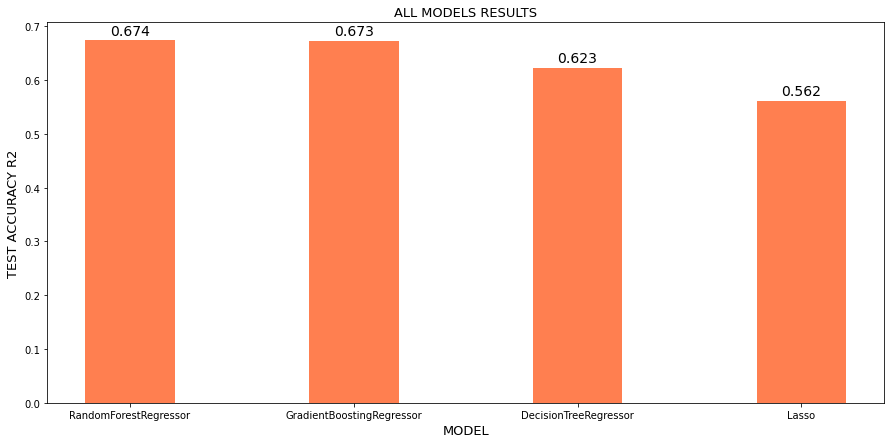

In [42]:
results = pd.read_csv(f"../results/all_models_results.csv")
plt.figure(figsize=(15, 7))
plt.bar(results['Model'], results['test_accuracy_R2'], width = 0.4, color='coral')
plt.title(f"ALL MODELS RESULTS", fontsize=13)
plt.xlabel("MODEL", fontsize=13)
plt.ylabel("TEST ACCURACY R2", fontsize=13)
for i in range(len(results)):
     plt.text(i, results['test_accuracy_R2'][i] + 0.01, "{:.3f}".format(results['test_accuracy_R2'][i]), ha = 'center', fontsize=14)
plt.savefig(f'../results/all_models_results.jpg')
plt.show()